In [1]:
from keras import Input, layers, backend, Model, losses, datasets, models, metrics, optimizers, initializers
from keras.regularizers import l2
from keras.utils import Sequence
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import math


In [2]:
def LoadNewImages(TrainingPaths, ValidationPaths, TestPaths, NumberInSet):
    NumberImagesPerCrystal = 1
    #TrainingPaths = [[All training inputs], [All training outputs]]
    
    NewTrainingImages = np.zeros(NumberInSet[0] * NumberImagesPerCrystal * 128 * 128 * 2, dtype = np.float32).reshape(NumberInSet[0] * NumberImagesPerCrystal, 2, 128, 128)
    NewValidationImages = np.zeros(NumberInSet[1] * NumberImagesPerCrystal * 128 * 128 * 2, dtype = np.float32).reshape(NumberInSet[1] * NumberImagesPerCrystal, 2, 128, 128)
    NewTestImages = np.zeros(NumberInSet[2] * NumberImagesPerCrystal * 128 * 128 * 2, dtype = np.float32).reshape(NumberInSet[2] * NumberImagesPerCrystal, 2, 128, 128)
    
    
    for i in range(0, NumberInSet[0] * NumberImagesPerCrystal):
        NewTrainingImages[i][0] = np.load(TrainingPaths[0][i]).astype(np.float32)
        NewTrainingImages[i][1] = np.load(TrainingPaths[1][i]).astype(np.float32)
        
    for i in range(0, NumberInSet[1] * NumberImagesPerCrystal):
        NewValidationImages[i][0] = np.load(ValidationPaths[0][i]).astype(np.float32)
        NewValidationImages[i][1] = np.load(ValidationPaths[1][i]).astype(np.float32)
    
    for i in range(0, NumberInSet[2] * NumberImagesPerCrystal):
        NewTestImages[i][0] = np.load(TestPaths[0][i]).astype(np.float32)
        NewTestImages[i][1] = np.load(TestPaths[1][i]).astype(np.float32)
    
    AllNewImages = [NewTrainingImages, NewValidationImages, NewTestImages]
    return(AllNewImages)

def PairInputImages(All_Images): #Comparison done by a root mean square
    NumberImagesPerCrystal = 4
    #with All_Images = [Train_Images, Validation_Images, Test_Images]
    DataSetSize = [len(All_Images[0]), len(All_Images[1]), len(All_Images[2])] * NumberImagesPerCrystal
    TrainValidationPairs = np.zeros(DataSetSize[0] * DataSetSize[1], dtype = np.float32).reshape(DataSetSize[0], DataSetSize[1])
    TrainTestPairs = np.zeros(DataSetSize[0] * DataSetSize[2], dtype = np.float32).reshape(DataSetSize[0], DataSetSize[2])
    
    for i in range(0, DataSetSize[0]):
        print("1: ", i)
        for j in range(0, DataSetSize[1]):
            TrainValidationPairs[i][j] = MeanSquare(All_Images[0][i][0], All_Images[1][j][0])
            
    for i in range(0, DataSetSize[0]):
        print("2: ", i)
        for j in range(0, DataSetSize[2]):
            TrainTestPairs[i][j] = MeanSquare(All_Images[0][i][0], All_Images[2][j][0])
    
    BestPairTrainValidation = np.zeros(DataSetSize[1], dtype = np.int)
    BestPairTrainTest = np.zeros(DataSetSize[2], dtype = np.int)
    
    for i in range(0, DataSetSize[1]):
        print("3: ", i)
        min_val = np.inf
        for j in range(0, DataSetSize[0]):
            if(TrainValidationPairs[j][i] < min_val):
                BestPairTrainValidation[i] = j
                min_val = TrainValidationPairs[j][i]
                
    for i in range(0, DataSetSize[2]):
        print("4: ", i)
        min_val = np.inf
        for j in range(0, DataSetSize[0]):
            if(TrainTestPairs[j][i] < min_val):
                BestPairTrainTest[i] = j
                min_val = TrainTestPairs[j][i]
    return(BestPairTrainValidation, BestPairTrainTest)

def BestPairLoss(All_Images, BestPairTrainValidation, BestPairTrainTest):
    Val_Loss_Sum = 0
    Test_Loss_Sum = 0
    for i in range(0, len(BestPairTrainValidation)):
        Val_Loss_Sum+=MeanSquareLogError(All_Images[1][i][1], All_Images[0][BestPairTrainValidation[i]][1])
        print("1: ", i)
    for i in range(0, len(BestPairTrainTest)):
        Test_Loss_Sum+=MeanSquareLogError(All_Images[2][i][1], All_Images[0][BestPairTrainTest[i]][1])
        print("2: ", i)
    Val_Loss = Val_Loss_Sum / len(BestPairTrainValidation)
    Test_Loss = Test_Loss_Sum / len(BestPairTrainTest)
    return(Val_Loss, Test_Loss)

def MeanSquare(Image_1, Image_2): #Shape N by N
    ms = (np.sum(np.square(Image_1 - Image_2)))
    return(ms)

def MeanSquareLogError(Image_1, Image_2):
    msle = 0
    for i in range(0, len(Image_1)):
        for j in range(0, len(Image_1[i])):
            msle+=(math.log(1+Image_1[i][j]) - math.log(1+Image_2[i][j])) ** 2
    return(msle)

def JeremyFunc(NewTrainingPaths, NewValidationPaths, NewTestPaths):
    NumberInSet = [len(NewTrainingPaths[0]), len(NewValidationPaths[0]), len(NewTestPaths[0])]
    AllNewImages = LoadNewImages(NewTrainingPaths, NewValidationPaths, NewTestPaths, NumberInSet)
    BestPairTrainValidation, BestPairTrainTest = PairInputImages(AllNewImages)
    Val_Loss, Test_Loss = BestPairLoss(AllNewImages, BestPairTrainValidation, BestPairTrainTest)
    return(Val_Loss, Test_Loss)

In [3]:

class FelixSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        """Here self.x is a list of paths to .npy input files. self.y is a
        corresponding list of paths to .npy output files."""
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        #print(np.array([np.load(file_name) for file_name in batch_x]).shape, np.array([np.load(file_name) for file_name in batch_y]).shape)
        return np.array([np.reshape(np.load(file_name), (128, 128, 1)) for file_name in batch_x]), np.array([np.reshape(np.load(file_name), (128, 128, 1)) for file_name in batch_y])
    

def gen_paths_labels(base_path = "D:\\Uni Work\\Masters Project\\electron_dists\\Data\\VAE_000_1\\Data"):
    """A generator to yield (data-paths, corresponding labels) tuples for each
    segment of data (typically training, validation, and testing)."""
    for segment in sorted(os.listdir(base_path)):
        segment_path = os.path.join(base_path, segment)
        input_paths = []
        output_paths = []
        for crystal in sorted(os.listdir(segment_path)):
            crystal_path = os.path.join(segment_path, crystal)
            files = sorted(os.listdir(crystal_path))
            input_paths.append(os.path.join(crystal_path, files[0]))
            output_paths.append(os.path.join(crystal_path, files[1]))
        yield [input_paths, output_paths]

def gen_paths_fromfile(Path):
    Paths = []
    with open(Path) as textFile:
        lines = [line.split() for line in textFile]
    for i in lines:
        Paths.append(i[0])
        
    Paths = np.array(Paths, dtype = "object")
    return(Paths)

In [4]:
latent_dim = 16

"""
## Create a sampling layer
"""
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def __init__(self, gamma = 1, **kwargs):
        super(Sampling, self).__init__(**kwargs)
        self.gamma = gamma

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        #print(self.gamma)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon * self.gamma


In [5]:
"""
## Build the encoder
"""

Num_Kernals = 16
Size_Kernals = 8

class Encoder(Model):
    def __init__(self, gamma = 0, **kwargs):
        super(Encoder, self).__init__(**kwargs)

        self.Conv1 = layers.Conv2D(Num_Kernals, kernel_size = (Size_Kernals, Size_Kernals), activation="relu", strides=2, padding="same")
        self.Conv2 = layers.Conv2D(Num_Kernals, kernel_size = (8, 8), activation="relu", strides=2, padding="same")
        #self.Conv3 = layers.Conv2D(Num_Kernals, kernel_size = (8, 8), activation="relu", strides=2, padding="same")
        #self.Conv4 = layers.Conv2D(Num_Kernals, kernel_size = (8, 8), activation="relu", strides=2, padding="same")

        self.flat = layers.Flatten()

        self.DenseParam_Encode = 1500000
        self.DenseNeurons_Encode = int(self.DenseParam_Encode / 16400)

        self.dense = layers.Dense(self.DenseNeurons_Encode, activation="relu", kernel_regularizer = l2(0.1))
        self.z_mean = layers.Dense(latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var", kernel_initializer='zeros', bias_initializer='zeros')
        self.sampling = Sampling(gamma=gamma)
    
    def call(self, inputs):

        x = self.Conv1(inputs)
        x = self.Conv2(x)
        #x = self.Conv3(x)
        #x = self.Conv4(x)
        x = self.flat(x)
        x = self.dense(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        return z_mean, z_log_var, z
    
encoder = Encoder(gamma = 0, name="encoder")
encoder(Input(batch_shape=(None,128,128,1)))

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        1040      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        16400     
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 91)                1491035   
_________________________________________________________________
z_mean (Dense)               (None, 16)                1472      
_________________________________________________________________
z_log_var (Dense)            (None, 16)                1472      
_________________________________________________________________
sampling (Sampling)          (None, 16)                0   

In [6]:
"""
## Build the decoder
"""


class Decoder(Model):
    def __init__(self, encoder_layer, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        Dense_Size = encoder_layer[1]
        
        DenseParam_Decode = 1500000
        Dense_Depth = int(DenseParam_Decode / (latent_dim * Dense_Size * Dense_Size))
        
        self.dense1 = layers.Dense(Dense_Size * Dense_Size * Dense_Depth, activation="relu",  kernel_regularizer = l2(0.1))
        self.dense2 = layers.Reshape((Dense_Size, Dense_Size, Dense_Depth))
                
        self.convT1 = layers.Conv2DTranspose(Num_Kernals, kernel_size = (Size_Kernals, Size_Kernals), activation="relu", strides=2, padding="same")
        self.convT2 = layers.Conv2DTranspose(Num_Kernals, kernel_size = (8, 8), activation="relu", strides=2, padding="same")
        #self.convT3 = layers.Conv2DTranspose(Num_Kernals, kernel_size = (8, 8), activation="relu", strides=2, padding="same")
        #self.convT4 = layers.Conv2DTranspose(Num_Kernals, kernel_size = (8, 8), activation="relu", strides=2, padding="same")

        self.outputs = layers.Conv2DTranspose(1, kernel_size = (2, 2), activation="relu", padding= "same")
    
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
                
        x = self.convT1(x)
        x = self.convT2(x)
        #x = self.convT3(x)
        #x = self.convT4(x)
        
        output = self.outputs(x)
        
        return output
    
decoder = Decoder(encoder.layers[1].output_shape, name="decoder")
decoder(Input(batch_shape=(None, latent_dim)))
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 93184)             1584128   
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 91)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 16)        93200     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 16)      16400     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 1)       65        
Total params: 1,693,793
Trainable params: 1,693,793
Non-trainable params: 0
_________________________________________________________________


In [7]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                losses.mean_squared_logarithmic_error(y, reconstruction), axis=(1, 2)
                )
            )
            #print(z_mean, z_log_var, z)
            beta = 1
            kl_loss = (-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))) * beta
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def call(self, data):
        return self.decoder(self.encoder(data)[2])

#losses.MSE(y, reconstruction), axis=(1, 2)
#losses.mean_squared_logarithmic_error(y, reconstruction), axis=(1, 2)

In [8]:
data_path = "/home/ug-ml/felix-ML/VAE_000/Data/FilePaths/"


TrainingPathsInput = gen_paths_fromfile(data_path + "TrainingInput_J1.txt")
TrainingPathsOutput = gen_paths_fromfile(data_path + "TrainingOutput_J1.txt")

ValidationPathsInput = gen_paths_fromfile(data_path + "ValidationInput_J1.txt")
ValidationPathsOutput = gen_paths_fromfile(data_path + "ValidationOutput_J1.txt")

TestPathsInput = gen_paths_fromfile(data_path + "TestInput_J1.txt")
TestPathsOutput = gen_paths_fromfile(data_path + "TestOutput_J1.txt")

fractions = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0]

train_len = TrainingPathsInput.size
val_len = ValidationPathsInput.size
test_len = TestPathsInput.size

train_indexes = np.arange(0, int(train_len))
val_indexes = np.arange(0, int(val_len))
test_indexes = np.arange(0, int(test_len))
np.random.shuffle(train_indexes)
np.random.shuffle(val_indexes)
np.random.shuffle(test_indexes)
#print(train_len, val_len, test_len)



In [9]:
#vae = models.load_model("/home/ug-ml/felix-ML/VAE_000/Data/Models/VAE_3")
batch_size=32
epochs = 1500
patience = 100
best_model_name = "VAE_Reduced_J1_V2"

for frac in fractions:
    #training and validation histories, containing [0] the total loss, [1] the reconstruction loss, and [2] the kl loss.
    val_hist = np.zeros(shape=(3,1,epochs))
    train_hist = np.zeros(shape=(3,3,epochs))
    james_hist = np.zeros(shape=(3,2))
    for run in range(3):

        wrk_train_in = TrainingPathsInput[train_indexes[:int(train_len*frac)]]
        wrk_train_out = TrainingPathsOutput[train_indexes[:int(train_len*frac)]]

        wrk_val_in = ValidationPathsInput[val_indexes[:int(val_len*frac)]]
        wrk_val_out = ValidationPathsOutput[val_indexes[:int(val_len*frac)]]

        wrk_test_in = TestPathsInput[test_indexes[:int(test_len*frac)]]
        wrk_test_out = TestPathsOutput[test_indexes[:int(test_len*frac)]]
        
        print(wrk_train_in.size, wrk_val_in.size, wrk_test_in.size)
        
        encoder = Encoder(gamma = 0, name="encoder")
        encoder(Input(batch_shape=(None,128,128,1)))
        
        decoder = Decoder(encoder.layers[1].output_shape, name="decoder")
        decoder(Input(batch_shape=(None, latent_dim)))
        
        
        james_hist[run][0], james_hist[run][1] = JeremyFunc([wrk_train_in, wrk_train_out], 
                                                            [wrk_val_in, wrk_val_out], 
                                                            [wrk_test_in, wrk_test_out])


        vae = VAE(encoder, decoder)
        #vae.add_metric(trainable_metric(vae), name="testMetric")
        vae.compile(optimizer=optimizers.Adam())


        #data_path = "/home/ug-ml/felix-ML/VAE_000/Data/Data/"

        #data = [i for i in gen_paths_labels(data_path)]
        #val_seq = FelixSequence(data[2][0], data[2][1], batch_size)
        #train_seq = FelixSequence(data[1][0], data[1][1], batch_size)
        #test_seq = FelixSequence(data[0][0], data[0][1], batch_size)

        train_seq = FelixSequence(wrk_train_in, wrk_train_out, batch_size)
        val_seq = FelixSequence(wrk_val_in, wrk_val_out, batch_size)
        test_seq = FelixSequence(wrk_test_in, wrk_test_out, batch_size)

        #vae.fit(train_seq, shuffle=True, workers=16, epochs=1500)

        
        patience_i = 0
        best_val_loss = np.inf


        for epoch in range(0, epochs):
            print("-------------------------------------------------------------------------")
            print("Epoch", epoch, "/", epochs, ": ")
            print("Training: ")
            vae.encoder.sampling.gamma=1
            #print(vae.encoder.sampling.gamma)
            hist = vae.fit(x = train_seq, shuffle=True, epochs = epoch+1, workers = 16, initial_epoch=epoch)
            train_hist[run][0][epoch] = hist.history["loss"][0]
            train_hist[run][1][epoch] = hist.history["reconstruction_loss"][0]
            train_hist[run][2][epoch] = hist.history["kl_loss"][0]
            print("Validation: ")

            tot_batch_recon_loss = 0
            count = 0
            vae.encoder.sampling.gamma=0
            #print(vae.encoder.sampling.gamma)
            for x, y in val_seq:
                #rint(x.shape, y.shape)
                count += 1
                reconstruction = vae(x)


                reconstruction_loss = tf.reduce_mean(
                        tf.reduce_sum(
                        losses.mean_squared_logarithmic_error(y, reconstruction), axis=(1, 2)
                        )
                    )
                tot_batch_recon_loss += reconstruction_loss
                #print(batch_log_loss)


            avg_recon_loss = float(tot_batch_recon_loss/count)
            if(avg_recon_loss < best_val_loss):
                vae.save("/home/ug-ml/felix-ML/VAE_000/Data/Models/V3/"+str(frac)+"_"+str(run)+"_"+str(best_model_name))
                print("The model improved from: ",best_val_loss, "to: ", avg_recon_loss)
                best_val_loss = avg_recon_loss
                patience_i = 0
            else:
                patience_i+=1
                print("The model did not improve, patience_i = ", patience_i)

            print("Average reconstruction loss: ", avg_recon_loss)
            val_hist[run][0][epoch] = avg_recon_loss
            if(patience_i > patience):
                print("Early Stopping, the model did not improve from: ", best_val_loss)
                break

        print("-------------------------------------------------------------------------")
    np.save(str(frac)+"train_hist.npy",train_hist)
    np.save(str(frac)+"val_hist.npy",val_hist)
    np.save(str(frac)+"james_hist.npy",james_hist)



231 27 13
1:  0
1:  1
1:  2
1:  3
1:  4
1:  5
1:  6
1:  7
1:  8
1:  9
1:  10
1:  11
1:  12
1:  13
1:  14
1:  15
1:  16
1:  17
1:  18
1:  19
1:  20
1:  21
1:  22
1:  23
1:  24
1:  25
1:  26
1:  27
1:  28
1:  29
1:  30
1:  31
1:  32
1:  33
1:  34
1:  35
1:  36
1:  37
1:  38
1:  39
1:  40
1:  41
1:  42
1:  43
1:  44
1:  45
1:  46
1:  47
1:  48
1:  49
1:  50
1:  51
1:  52
1:  53
1:  54
1:  55
1:  56
1:  57
1:  58
1:  59
1:  60
1:  61
1:  62
1:  63
1:  64
1:  65
1:  66
1:  67
1:  68
1:  69
1:  70
1:  71
1:  72
1:  73
1:  74
1:  75
1:  76
1:  77
1:  78
1:  79
1:  80
1:  81
1:  82
1:  83
1:  84
1:  85
1:  86
1:  87
1:  88
1:  89
1:  90
1:  91
1:  92
1:  93
1:  94
1:  95
1:  96
1:  97
1:  98
1:  99
1:  100
1:  101
1:  102
1:  103
1:  104
1:  105
1:  106
1:  107
1:  108
1:  109
1:  110
1:  111
1:  112
1:  113
1:  114
1:  115
1:  116
1:  117
1:  118
1:  119
1:  120
1:  121
1:  122
1:  123
1:  124
1:  125
1:  126
1:  127
1:  128
1:  129
1:  130
1:  131
1:  132
1:  133
1:  134
1:  135
1:  136
1:  

8/8 [==============================] - 0s 21ms/step - loss: 344.2716 - reconstruction_loss: 311.8605 - kl_loss: 12.5986
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  353.0595397949219
-------------------------------------------------------------------------
Epoch 9 / 1500 : 
Training: 
Epoch 10/10
8/8 [==============================] - 0s 21ms/step - loss: 321.6859 - reconstruction_loss: 305.4586 - kl_loss: 11.2871
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  363.4208679199219
-------------------------------------------------------------------------
Epoch 10 / 1500 : 
Training: 
Epoch 11/11
8/8 [==============================] - 0s 21ms/step - loss: 314.7807 - reconstruction_loss: 296.3284 - kl_loss: 14.8663
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.05_0_VAE_Reduced_J1_V2/assets
The model improved from:  344.02264404296875 to:  330.8758239746094
Average r

8/8 [==============================] - 0s 23ms/step - loss: 171.2796 - reconstruction_loss: 149.1116 - kl_loss: 21.4610
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.05_0_VAE_Reduced_J1_V2/assets
The model improved from:  254.23582458496094 to:  246.3514862060547
Average reconstruction loss:  246.3514862060547
-------------------------------------------------------------------------
Epoch 30 / 1500 : 
Training: 
Epoch 31/31
8/8 [==============================] - 0s 23ms/step - loss: 153.8269 - reconstruction_loss: 139.9155 - kl_loss: 23.4557
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  259.9984436035156
-------------------------------------------------------------------------
Epoch 31 / 1500 : 
Training: 
Epoch 32/32
8/8 [==============================] - 1s 68ms/step - loss: 154.8759 - reconstruction_loss: 142.3292 - kl_loss: 23.6868
Validation: 
The model did not improve, patience_i =  2
Average 

Epoch 52/52
8/8 [==============================] - 0s 24ms/step - loss: 109.8802 - reconstruction_loss: 90.3764 - kl_loss: 23.8860
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  226.20616149902344
-------------------------------------------------------------------------
Epoch 52 / 1500 : 
Training: 
Epoch 53/53
8/8 [==============================] - 0s 23ms/step - loss: 105.8306 - reconstruction_loss: 83.0005 - kl_loss: 22.7492
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.05_0_VAE_Reduced_J1_V2/assets
The model improved from:  221.39857482910156 to:  218.79490661621094
Average reconstruction loss:  218.79490661621094
-------------------------------------------------------------------------
Epoch 53 / 1500 : 
Training: 
Epoch 54/54
8/8 [==============================] - 0s 23ms/step - loss: 100.8276 - reconstruction_loss: 74.8393 - kl_loss: 24.5344
Validation: 
INFO:tensorflow:Assets written to: /hom

Epoch 98/98
8/8 [==============================] - 0s 18ms/step - loss: 89.6491 - reconstruction_loss: 63.2339 - kl_loss: 23.9108
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  202.7389373779297
-------------------------------------------------------------------------
Epoch 98 / 1500 : 
Training: 
Epoch 99/99
8/8 [==============================] - 0s 21ms/step - loss: 75.4777 - reconstruction_loss: 47.6008 - kl_loss: 23.1860
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  207.5198211669922
-------------------------------------------------------------------------
Epoch 99 / 1500 : 
Training: 
Epoch 100/100
8/8 [==============================] - 0s 61ms/step - loss: 64.3292 - reconstruction_loss: 41.6803 - kl_loss: 24.8989
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  204.7665252685547
-------------------------------------------------------------------------
Epoch 100 / 15

8/8 [==============================] - 0s 17ms/step - loss: 66.1912 - reconstruction_loss: 42.8955 - kl_loss: 22.2748
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  197.17132568359375
-------------------------------------------------------------------------
Epoch 121 / 1500 : 
Training: 
Epoch 122/122
8/8 [==============================] - 0s 22ms/step - loss: 60.7143 - reconstruction_loss: 37.2062 - kl_loss: 24.9494
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  188.47311401367188
-------------------------------------------------------------------------
Epoch 122 / 1500 : 
Training: 
Epoch 123/123
8/8 [==============================] - 0s 21ms/step - loss: 67.2125 - reconstruction_loss: 40.5702 - kl_loss: 24.6568
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  200.68661499023438
-------------------------------------------------------------------------
Epoch 123 / 1500 :

Epoch 145/145
8/8 [==============================] - 0s 20ms/step - loss: 49.6428 - reconstruction_loss: 24.9993 - kl_loss: 23.6698
Validation: 
The model did not improve, patience_i =  32
Average reconstruction loss:  191.27615356445312
-------------------------------------------------------------------------
Epoch 145 / 1500 : 
Training: 
Epoch 146/146
8/8 [==============================] - 0s 20ms/step - loss: 49.0430 - reconstruction_loss: 25.6353 - kl_loss: 23.8362
Validation: 
The model did not improve, patience_i =  33
Average reconstruction loss:  206.8382568359375
-------------------------------------------------------------------------
Epoch 146 / 1500 : 
Training: 
Epoch 147/147
8/8 [==============================] - 0s 19ms/step - loss: 49.3462 - reconstruction_loss: 26.3357 - kl_loss: 23.1820
Validation: 
The model did not improve, patience_i =  34
Average reconstruction loss:  189.18740844726562
-------------------------------------------------------------------------
Epo

Epoch 192/192
8/8 [==============================] - 0s 20ms/step - loss: 50.0048 - reconstruction_loss: 28.4962 - kl_loss: 21.8781
Validation: 
The model did not improve, patience_i =  35
Average reconstruction loss:  206.67605590820312
-------------------------------------------------------------------------
Epoch 192 / 1500 : 
Training: 
Epoch 193/193
8/8 [==============================] - 0s 22ms/step - loss: 41.8517 - reconstruction_loss: 21.4696 - kl_loss: 22.2430
Validation: 
The model did not improve, patience_i =  36
Average reconstruction loss:  192.96261596679688
-------------------------------------------------------------------------
Epoch 193 / 1500 : 
Training: 
Epoch 194/194
8/8 [==============================] - 0s 17ms/step - loss: 42.5181 - reconstruction_loss: 19.1010 - kl_loss: 23.0617
Validation: 
The model did not improve, patience_i =  37
Average reconstruction loss:  178.05775451660156
-------------------------------------------------------------------------
Ep

Epoch 216/216
8/8 [==============================] - 1s 63ms/step - loss: 40.7656 - reconstruction_loss: 20.1330 - kl_loss: 22.4815
Validation: 
The model did not improve, patience_i =  59
Average reconstruction loss:  188.26028442382812
-------------------------------------------------------------------------
Epoch 216 / 1500 : 
Training: 
Epoch 217/217
8/8 [==============================] - 0s 21ms/step - loss: 40.4894 - reconstruction_loss: 17.7525 - kl_loss: 21.9666
Validation: 
The model did not improve, patience_i =  60
Average reconstruction loss:  192.5563507080078
-------------------------------------------------------------------------
Epoch 217 / 1500 : 
Training: 
Epoch 218/218
8/8 [==============================] - 0s 20ms/step - loss: 40.1945 - reconstruction_loss: 17.8456 - kl_loss: 22.0878
Validation: 
The model did not improve, patience_i =  61
Average reconstruction loss:  177.1516571044922
-------------------------------------------------------------------------
Epoc

Epoch 240/240
8/8 [==============================] - 0s 20ms/step - loss: 40.5711 - reconstruction_loss: 18.6832 - kl_loss: 22.5907
Validation: 
The model did not improve, patience_i =  83
Average reconstruction loss:  179.7014617919922
-------------------------------------------------------------------------
Epoch 240 / 1500 : 
Training: 
Epoch 241/241
8/8 [==============================] - 0s 19ms/step - loss: 39.4812 - reconstruction_loss: 17.1922 - kl_loss: 21.7098
Validation: 
The model did not improve, patience_i =  84
Average reconstruction loss:  180.6339874267578
-------------------------------------------------------------------------
Epoch 241 / 1500 : 
Training: 
Epoch 242/242
8/8 [==============================] - 0s 20ms/step - loss: 42.1102 - reconstruction_loss: 17.6391 - kl_loss: 22.9815
Validation: 
The model did not improve, patience_i =  85
Average reconstruction loss:  179.23789978027344
-------------------------------------------------------------------------
Epoc

2:  105
2:  106
2:  107
2:  108
2:  109
2:  110
2:  111
2:  112
2:  113
2:  114
2:  115
2:  116
2:  117
2:  118
2:  119
2:  120
2:  121
2:  122
2:  123
2:  124
2:  125
2:  126
2:  127
2:  128
2:  129
2:  130
2:  131
2:  132
2:  133
2:  134
2:  135
2:  136
2:  137
2:  138
2:  139
2:  140
2:  141
2:  142
2:  143
2:  144
2:  145
2:  146
2:  147
2:  148
2:  149
2:  150
2:  151
2:  152
2:  153
2:  154
2:  155
2:  156
2:  157
2:  158
2:  159
2:  160
2:  161
2:  162
2:  163
2:  164
2:  165
2:  166
2:  167
2:  168
2:  169
2:  170
2:  171
2:  172
2:  173
2:  174
2:  175
2:  176
2:  177
2:  178
2:  179
2:  180
2:  181
2:  182
2:  183
2:  184
2:  185
2:  186
2:  187
2:  188
2:  189
2:  190
2:  191
2:  192
2:  193
2:  194
2:  195
2:  196
2:  197
2:  198
2:  199
2:  200
2:  201
2:  202
2:  203
2:  204
2:  205
2:  206
2:  207
2:  208
2:  209
2:  210
2:  211
2:  212
2:  213
2:  214
2:  215
2:  216
2:  217
2:  218
2:  219
2:  220
2:  221
2:  222
2:  223
2:  224
2:  225
2:  226
2:  227
2:  228
2:  229


Epoch 37/37
8/8 [==============================] - 0s 21ms/step - loss: 158.8553 - reconstruction_loss: 134.1870 - kl_loss: 22.6002
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.05_1_VAE_Reduced_J1_V2/assets
The model improved from:  240.22714233398438 to:  232.23321533203125
Average reconstruction loss:  232.23321533203125
-------------------------------------------------------------------------
Epoch 37 / 1500 : 
Training: 
Epoch 38/38
8/8 [==============================] - 0s 18ms/step - loss: 149.5874 - reconstruction_loss: 123.6763 - kl_loss: 22.6027
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.05_1_VAE_Reduced_J1_V2/assets
The model improved from:  232.23321533203125 to:  229.29730224609375
Average reconstruction loss:  229.29730224609375
-------------------------------------------------------------------------
Epoch 38 / 1500 : 
Training: 
Epoch 39/39
8/8 [===========================

8/8 [==============================] - 0s 20ms/step - loss: 88.3825 - reconstruction_loss: 65.3756 - kl_loss: 24.2410
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  217.2532501220703
-------------------------------------------------------------------------
Epoch 82 / 1500 : 
Training: 
Epoch 83/83
8/8 [==============================] - 0s 21ms/step - loss: 87.3226 - reconstruction_loss: 58.8591 - kl_loss: 24.6749
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  212.0902099609375
-------------------------------------------------------------------------
Epoch 83 / 1500 : 
Training: 
Epoch 84/84
8/8 [==============================] - 0s 20ms/step - loss: 77.0210 - reconstruction_loss: 56.3798 - kl_loss: 23.6168
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  213.01316833496094
-------------------------------------------------------------------------
Epoch 84 / 1500 : 
Training

Epoch 105/105
8/8 [==============================] - 1s 69ms/step - loss: 62.5139 - reconstruction_loss: 41.0091 - kl_loss: 23.6076
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  217.5970458984375
-------------------------------------------------------------------------
Epoch 105 / 1500 : 
Training: 
Epoch 106/106
8/8 [==============================] - 0s 19ms/step - loss: 66.1353 - reconstruction_loss: 43.2052 - kl_loss: 24.1891
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  216.7179412841797
-------------------------------------------------------------------------
Epoch 106 / 1500 : 
Training: 
Epoch 107/107
8/8 [==============================] - 0s 21ms/step - loss: 61.6641 - reconstruction_loss: 35.8699 - kl_loss: 25.0106
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  207.23133850097656
-------------------------------------------------------------------------
Epoch 1

Epoch 152/152
8/8 [==============================] - 0s 19ms/step - loss: 49.2397 - reconstruction_loss: 25.7434 - kl_loss: 23.0166
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  190.26217651367188
-------------------------------------------------------------------------
Epoch 152 / 1500 : 
Training: 
Epoch 153/153
8/8 [==============================] - 0s 19ms/step - loss: 49.7082 - reconstruction_loss: 27.6637 - kl_loss: 23.4027
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  202.73171997070312
-------------------------------------------------------------------------
Epoch 153 / 1500 : 
Training: 
Epoch 154/154
8/8 [==============================] - 0s 20ms/step - loss: 53.5850 - reconstruction_loss: 30.2084 - kl_loss: 22.1335
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  191.64076232910156
-------------------------------------------------------------------------
Epoch

Epoch 176/176
8/8 [==============================] - 0s 21ms/step - loss: 51.8943 - reconstruction_loss: 29.2031 - kl_loss: 21.4748
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  200.81170654296875
-------------------------------------------------------------------------
Epoch 176 / 1500 : 
Training: 
Epoch 177/177
8/8 [==============================] - 0s 20ms/step - loss: 46.1833 - reconstruction_loss: 23.3539 - kl_loss: 22.9090
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  189.27947998046875
-------------------------------------------------------------------------
Epoch 177 / 1500 : 
Training: 
Epoch 178/178
8/8 [==============================] - 0s 20ms/step - loss: 48.0149 - reconstruction_loss: 23.2090 - kl_loss: 22.3993
Validation: 
The model did not improve, patience_i =  20
Average reconstruction loss:  201.80099487304688
-------------------------------------------------------------------------
Ep

Epoch 200/200
8/8 [==============================] - 1s 65ms/step - loss: 56.5498 - reconstruction_loss: 36.0636 - kl_loss: 23.5398
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.05_1_VAE_Reduced_J1_V2/assets
The model improved from:  186.22952270507812 to:  183.35195922851562
Average reconstruction loss:  183.35195922851562
-------------------------------------------------------------------------
Epoch 200 / 1500 : 
Training: 
Epoch 201/201
8/8 [==============================] - 0s 62ms/step - loss: 51.9441 - reconstruction_loss: 34.2362 - kl_loss: 21.7509
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  210.0472412109375
-------------------------------------------------------------------------
Epoch 201 / 1500 : 
Training: 
Epoch 202/202
8/8 [==============================] - 0s 23ms/step - loss: 49.0964 - reconstruction_loss: 26.6019 - kl_loss: 22.6944
Validation: 
The model did not improve, patience

Epoch 223/223
8/8 [==============================] - 0s 19ms/step - loss: 41.8572 - reconstruction_loss: 21.2796 - kl_loss: 21.5232
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  183.9976806640625
-------------------------------------------------------------------------
Epoch 223 / 1500 : 
Training: 
Epoch 224/224
8/8 [==============================] - 0s 20ms/step - loss: 44.2947 - reconstruction_loss: 22.4801 - kl_loss: 21.8239
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  197.27655029296875
-------------------------------------------------------------------------
Epoch 224 / 1500 : 
Training: 
Epoch 225/225
8/8 [==============================] - 0s 19ms/step - loss: 45.8613 - reconstruction_loss: 20.9054 - kl_loss: 23.0455
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  189.16702270507812
-------------------------------------------------------------------------
Epoch 

Epoch 247/247
8/8 [==============================] - 0s 19ms/step - loss: 38.8718 - reconstruction_loss: 19.8224 - kl_loss: 21.4235
Validation: 
The model did not improve, patience_i =  26
Average reconstruction loss:  189.65908813476562
-------------------------------------------------------------------------
Epoch 247 / 1500 : 
Training: 
Epoch 248/248
8/8 [==============================] - 0s 20ms/step - loss: 43.4221 - reconstruction_loss: 20.5481 - kl_loss: 22.3495
Validation: 
The model did not improve, patience_i =  27
Average reconstruction loss:  192.27972412109375
-------------------------------------------------------------------------
Epoch 248 / 1500 : 
Training: 
Epoch 249/249
8/8 [==============================] - 0s 19ms/step - loss: 40.5565 - reconstruction_loss: 18.4715 - kl_loss: 21.1206
Validation: 
The model did not improve, patience_i =  28
Average reconstruction loss:  189.76556396484375
-------------------------------------------------------------------------
Ep

Epoch 271/271
8/8 [==============================] - 0s 20ms/step - loss: 38.2916 - reconstruction_loss: 17.0018 - kl_loss: 20.9605
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  178.86192321777344
-------------------------------------------------------------------------
Epoch 271 / 1500 : 
Training: 
Epoch 272/272
8/8 [==============================] - 0s 19ms/step - loss: 38.0491 - reconstruction_loss: 17.1636 - kl_loss: 22.0838
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  187.88504028320312
-------------------------------------------------------------------------
Epoch 272 / 1500 : 
Training: 
Epoch 273/273
8/8 [==============================] - 0s 21ms/step - loss: 38.8612 - reconstruction_loss: 17.6427 - kl_loss: 21.7836
Validation: 
The model did not improve, patience_i =  20
Average reconstruction loss:  184.4120330810547
-------------------------------------------------------------------------
Epo

Epoch 295/295
8/8 [==============================] - 0s 41ms/step - loss: 40.5149 - reconstruction_loss: 19.5755 - kl_loss: 21.1371
Validation: 
The model did not improve, patience_i =  42
Average reconstruction loss:  189.58836364746094
-------------------------------------------------------------------------
Epoch 295 / 1500 : 
Training: 
Epoch 296/296
8/8 [==============================] - 0s 19ms/step - loss: 39.7105 - reconstruction_loss: 17.8391 - kl_loss: 21.7390
Validation: 
The model did not improve, patience_i =  43
Average reconstruction loss:  182.4553680419922
-------------------------------------------------------------------------
Epoch 296 / 1500 : 
Training: 
Epoch 297/297
8/8 [==============================] - 0s 19ms/step - loss: 37.2189 - reconstruction_loss: 15.7482 - kl_loss: 21.1237
Validation: 
The model did not improve, patience_i =  44
Average reconstruction loss:  179.3258819580078
-------------------------------------------------------------------------
Epoc

Epoch 319/319
8/8 [==============================] - 0s 20ms/step - loss: 40.4295 - reconstruction_loss: 18.3943 - kl_loss: 20.7996
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  192.19610595703125
-------------------------------------------------------------------------
Epoch 319 / 1500 : 
Training: 
Epoch 320/320
8/8 [==============================] - 1s 68ms/step - loss: 35.2005 - reconstruction_loss: 14.8872 - kl_loss: 21.9984
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  178.0836181640625
-------------------------------------------------------------------------
Epoch 320 / 1500 : 
Training: 
Epoch 321/321
8/8 [==============================] - 0s 21ms/step - loss: 38.8303 - reconstruction_loss: 17.6723 - kl_loss: 20.3322
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  184.80812072753906
-------------------------------------------------------------------------
Epoch 

Epoch 342/342
8/8 [==============================] - 0s 22ms/step - loss: 32.6785 - reconstruction_loss: 13.0412 - kl_loss: 20.7673
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  179.4015655517578
-------------------------------------------------------------------------
Epoch 342 / 1500 : 
Training: 
Epoch 343/343
8/8 [==============================] - 0s 19ms/step - loss: 36.4493 - reconstruction_loss: 17.1350 - kl_loss: 20.8488
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  184.88339233398438
-------------------------------------------------------------------------
Epoch 343 / 1500 : 
Training: 
Epoch 344/344
8/8 [==============================] - 0s 20ms/step - loss: 40.8398 - reconstruction_loss: 21.9352 - kl_loss: 20.0376
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  187.91078186035156
-------------------------------------------------------------------------
Epoch 

Epoch 366/366
8/8 [==============================] - 0s 20ms/step - loss: 34.1578 - reconstruction_loss: 13.8151 - kl_loss: 20.4861
Validation: 
The model did not improve, patience_i =  27
Average reconstruction loss:  183.77001953125
-------------------------------------------------------------------------
Epoch 366 / 1500 : 
Training: 
Epoch 367/367
8/8 [==============================] - 0s 20ms/step - loss: 32.3571 - reconstruction_loss: 13.2198 - kl_loss: 19.9549
Validation: 
The model did not improve, patience_i =  28
Average reconstruction loss:  182.64450073242188
-------------------------------------------------------------------------
Epoch 367 / 1500 : 
Training: 
Epoch 368/368
8/8 [==============================] - 0s 20ms/step - loss: 33.5479 - reconstruction_loss: 13.7733 - kl_loss: 20.5354
Validation: 
The model did not improve, patience_i =  29
Average reconstruction loss:  183.24142456054688
-------------------------------------------------------------------------
Epoch

Epoch 390/390
8/8 [==============================] - 0s 19ms/step - loss: 31.8802 - reconstruction_loss: 12.9590 - kl_loss: 19.8948
Validation: 
The model did not improve, patience_i =  51
Average reconstruction loss:  177.22935485839844
-------------------------------------------------------------------------
Epoch 390 / 1500 : 
Training: 
Epoch 391/391
8/8 [==============================] - 1s 65ms/step - loss: 31.8271 - reconstruction_loss: 12.4845 - kl_loss: 19.8986
Validation: 
The model did not improve, patience_i =  52
Average reconstruction loss:  173.22605895996094
-------------------------------------------------------------------------
Epoch 391 / 1500 : 
Training: 
Epoch 392/392
8/8 [==============================] - 0s 20ms/step - loss: 31.3286 - reconstruction_loss: 11.3954 - kl_loss: 20.0219
Validation: 
The model did not improve, patience_i =  53
Average reconstruction loss:  177.1849822998047
-------------------------------------------------------------------------
Epo

Epoch 414/414
8/8 [==============================] - 0s 20ms/step - loss: 31.3709 - reconstruction_loss: 12.2059 - kl_loss: 19.4787
Validation: 
The model did not improve, patience_i =  75
Average reconstruction loss:  177.99217224121094
-------------------------------------------------------------------------
Epoch 414 / 1500 : 
Training: 
Epoch 415/415
8/8 [==============================] - 0s 21ms/step - loss: 34.4311 - reconstruction_loss: 15.1349 - kl_loss: 19.7408
Validation: 
The model did not improve, patience_i =  76
Average reconstruction loss:  176.07835388183594
-------------------------------------------------------------------------
Epoch 415 / 1500 : 
Training: 
Epoch 416/416
8/8 [==============================] - 0s 19ms/step - loss: 35.7271 - reconstruction_loss: 19.2554 - kl_loss: 20.1263
Validation: 
The model did not improve, patience_i =  77
Average reconstruction loss:  188.13775634765625
-------------------------------------------------------------------------
Ep

Epoch 438/438
8/8 [==============================] - 0s 20ms/step - loss: 32.4729 - reconstruction_loss: 12.5011 - kl_loss: 19.9692
Validation: 
The model did not improve, patience_i =  99
Average reconstruction loss:  179.6077117919922
-------------------------------------------------------------------------
Epoch 438 / 1500 : 
Training: 
Epoch 439/439
8/8 [==============================] - 0s 21ms/step - loss: 36.1541 - reconstruction_loss: 16.7085 - kl_loss: 19.7018
Validation: 
The model did not improve, patience_i =  100
Average reconstruction loss:  174.93527221679688
-------------------------------------------------------------------------
Epoch 439 / 1500 : 
Training: 
Epoch 440/440
8/8 [==============================] - 0s 20ms/step - loss: 38.5583 - reconstruction_loss: 16.9078 - kl_loss: 19.8063
Validation: 
The model did not improve, patience_i =  101
Average reconstruction loss:  182.1051025390625
Early Stopping, the model did not improve from:  168.6428985595703
---------

8/8 [==============================] - 0s 19ms/step - loss: 418.6129 - reconstruction_loss: 418.8106 - kl_loss: 4.3065
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  481.5490417480469
-------------------------------------------------------------------------
Epoch 9 / 1500 : 
Training: 
Epoch 10/10
8/8 [==============================] - 0s 19ms/step - loss: 437.4802 - reconstruction_loss: 426.0844 - kl_loss: 4.0386
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.05_2_VAE_Reduced_J1_V2/assets
The model improved from:  453.5171203613281 to:  425.6324462890625
Average reconstruction loss:  425.6324462890625
-------------------------------------------------------------------------
Epoch 10 / 1500 : 
Training: 
Epoch 11/11
8/8 [==============================] - 0s 19ms/step - loss: 404.8159 - reconstruction_loss: 395.5136 - kl_loss: 6.0373
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/

8/8 [==============================] - 0s 18ms/step - loss: 259.1342 - reconstruction_loss: 245.3327 - kl_loss: 16.1978
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  324.6351318359375
-------------------------------------------------------------------------
Epoch 29 / 1500 : 
Training: 
Epoch 30/30
8/8 [==============================] - 0s 19ms/step - loss: 264.6137 - reconstruction_loss: 246.3203 - kl_loss: 17.9106
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  338.5607604980469
-------------------------------------------------------------------------
Epoch 30 / 1500 : 
Training: 
Epoch 31/31
8/8 [==============================] - 0s 62ms/step - loss: 250.0636 - reconstruction_loss: 241.1325 - kl_loss: 16.0228
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.05_2_VAE_Reduced_J1_V2/assets
The model improved from:  308.0711669921875 to:  304.98773193359375
Average 

8/8 [==============================] - 1s 64ms/step - loss: 108.7631 - reconstruction_loss: 97.0174 - kl_loss: 24.7194
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.05_2_VAE_Reduced_J1_V2/assets
The model improved from:  226.35003662109375 to:  226.0706329345703
Average reconstruction loss:  226.0706329345703
-------------------------------------------------------------------------
Epoch 70 / 1500 : 
Training: 
Epoch 71/71
8/8 [==============================] - 0s 20ms/step - loss: 120.1762 - reconstruction_loss: 93.9704 - kl_loss: 24.8764
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.05_2_VAE_Reduced_J1_V2/assets
The model improved from:  226.0706329345703 to:  222.36761474609375
Average reconstruction loss:  222.36761474609375
-------------------------------------------------------------------------
Epoch 71 / 1500 : 
Training: 
Epoch 72/72
8/8 [==============================] - 1s 64ms/st

8/8 [==============================] - 0s 20ms/step - loss: 98.9470 - reconstruction_loss: 70.9355 - kl_loss: 25.1629
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  212.17137145996094
-------------------------------------------------------------------------
Epoch 92 / 1500 : 
Training: 
Epoch 93/93
8/8 [==============================] - 0s 20ms/step - loss: 90.5436 - reconstruction_loss: 66.2858 - kl_loss: 25.9456
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  228.5485382080078
-------------------------------------------------------------------------
Epoch 93 / 1500 : 
Training: 
Epoch 94/94
8/8 [==============================] - 0s 20ms/step - loss: 94.1329 - reconstruction_loss: 70.4201 - kl_loss: 26.1391
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  212.7930450439453
-------------------------------------------------------------------------
Epoch 94 / 1500 : 
Training

Epoch 139/139
8/8 [==============================] - 0s 21ms/step - loss: 74.6181 - reconstruction_loss: 52.9362 - kl_loss: 25.1631
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  227.36871337890625
-------------------------------------------------------------------------
Epoch 139 / 1500 : 
Training: 
Epoch 140/140
8/8 [==============================] - 0s 20ms/step - loss: 70.9818 - reconstruction_loss: 45.5388 - kl_loss: 26.1331
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  205.39312744140625
-------------------------------------------------------------------------
Epoch 140 / 1500 : 
Training: 
Epoch 141/141
8/8 [==============================] - 0s 20ms/step - loss: 64.7004 - reconstruction_loss: 38.2842 - kl_loss: 26.0789
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  195.9224853515625
-------------------------------------------------------------------------
Epoc

Epoch 163/163
8/8 [==============================] - 0s 20ms/step - loss: 56.4808 - reconstruction_loss: 30.7874 - kl_loss: 25.4066
Validation: 
The model did not improve, patience_i =  33
Average reconstruction loss:  225.09207153320312
-------------------------------------------------------------------------
Epoch 163 / 1500 : 
Training: 
Epoch 164/164
8/8 [==============================] - 0s 19ms/step - loss: 58.7753 - reconstruction_loss: 32.3634 - kl_loss: 25.4565
Validation: 
The model did not improve, patience_i =  34
Average reconstruction loss:  204.5965118408203
-------------------------------------------------------------------------
Epoch 164 / 1500 : 
Training: 
Epoch 165/165
8/8 [==============================] - 0s 23ms/step - loss: 59.0144 - reconstruction_loss: 32.0551 - kl_loss: 25.2486
Validation: 
The model did not improve, patience_i =  35
Average reconstruction loss:  212.53570556640625
-------------------------------------------------------------------------
Epo

Epoch 187/187
8/8 [==============================] - 0s 18ms/step - loss: 48.1990 - reconstruction_loss: 25.4340 - kl_loss: 24.9253
Validation: 
The model did not improve, patience_i =  57
Average reconstruction loss:  195.6840057373047
-------------------------------------------------------------------------
Epoch 187 / 1500 : 
Training: 
Epoch 188/188
8/8 [==============================] - 0s 19ms/step - loss: 52.0108 - reconstruction_loss: 26.3810 - kl_loss: 24.6751
Validation: 
The model did not improve, patience_i =  58
Average reconstruction loss:  195.4617462158203
-------------------------------------------------------------------------
Epoch 188 / 1500 : 
Training: 
Epoch 189/189
8/8 [==============================] - 0s 20ms/step - loss: 48.3117 - reconstruction_loss: 25.2144 - kl_loss: 24.7769
Validation: 
The model did not improve, patience_i =  59
Average reconstruction loss:  208.7688751220703
-------------------------------------------------------------------------
Epoch

Epoch 211/211
8/8 [==============================] - 0s 20ms/step - loss: 49.5085 - reconstruction_loss: 24.9319 - kl_loss: 24.7352
Validation: 
The model did not improve, patience_i =  20
Average reconstruction loss:  184.07574462890625
-------------------------------------------------------------------------
Epoch 211 / 1500 : 
Training: 
Epoch 212/212
8/8 [==============================] - 0s 19ms/step - loss: 46.4596 - reconstruction_loss: 24.5547 - kl_loss: 23.6316
Validation: 
The model did not improve, patience_i =  21
Average reconstruction loss:  209.01524353027344
-------------------------------------------------------------------------
Epoch 212 / 1500 : 
Training: 
Epoch 213/213
8/8 [==============================] - 0s 62ms/step - loss: 45.5076 - reconstruction_loss: 23.6047 - kl_loss: 23.7372
Validation: 
The model did not improve, patience_i =  22
Average reconstruction loss:  195.01022338867188
-------------------------------------------------------------------------
Ep

Epoch 235/235
8/8 [==============================] - 0s 19ms/step - loss: 56.4360 - reconstruction_loss: 34.0340 - kl_loss: 24.1304
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  199.70782470703125
-------------------------------------------------------------------------
Epoch 235 / 1500 : 
Training: 
Epoch 236/236
8/8 [==============================] - 0s 21ms/step - loss: 60.5550 - reconstruction_loss: 34.4380 - kl_loss: 24.3828
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  206.01846313476562
-------------------------------------------------------------------------
Epoch 236 / 1500 : 
Training: 
Epoch 237/237
8/8 [==============================] - 0s 19ms/step - loss: 65.1426 - reconstruction_loss: 43.5851 - kl_loss: 23.6435
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.05_2_VAE_Reduced_J1_V2/assets
The model improved from:  178.39637756347656 to:  174.172576

Epoch 259/259
8/8 [==============================] - 0s 18ms/step - loss: 40.2362 - reconstruction_loss: 18.6026 - kl_loss: 24.0605
Validation: 
The model did not improve, patience_i =  22
Average reconstruction loss:  198.06040954589844
-------------------------------------------------------------------------
Epoch 259 / 1500 : 
Training: 
Epoch 260/260
8/8 [==============================] - 0s 18ms/step - loss: 42.2747 - reconstruction_loss: 18.5144 - kl_loss: 23.4842
Validation: 
The model did not improve, patience_i =  23
Average reconstruction loss:  196.31739807128906
-------------------------------------------------------------------------
Epoch 260 / 1500 : 
Training: 
Epoch 261/261
8/8 [==============================] - 0s 18ms/step - loss: 41.8226 - reconstruction_loss: 18.8880 - kl_loss: 23.0544
Validation: 
The model did not improve, patience_i =  24
Average reconstruction loss:  187.2102508544922
-------------------------------------------------------------------------
Epo

Epoch 283/283
8/8 [==============================] - 0s 20ms/step - loss: 42.8449 - reconstruction_loss: 18.8638 - kl_loss: 23.3686
Validation: 
The model did not improve, patience_i =  46
Average reconstruction loss:  191.26393127441406
-------------------------------------------------------------------------
Epoch 283 / 1500 : 
Training: 
Epoch 284/284
8/8 [==============================] - 0s 19ms/step - loss: 42.9886 - reconstruction_loss: 20.3257 - kl_loss: 23.1393
Validation: 
The model did not improve, patience_i =  47
Average reconstruction loss:  194.56007385253906
-------------------------------------------------------------------------
Epoch 284 / 1500 : 
Training: 
Epoch 285/285
8/8 [==============================] - 0s 19ms/step - loss: 43.2830 - reconstruction_loss: 18.8328 - kl_loss: 22.7575
Validation: 
The model did not improve, patience_i =  48
Average reconstruction loss:  181.2740936279297
-------------------------------------------------------------------------
Epo

Epoch 307/307
8/8 [==============================] - 0s 20ms/step - loss: 36.3873 - reconstruction_loss: 15.7915 - kl_loss: 22.0850
Validation: 
The model did not improve, patience_i =  70
Average reconstruction loss:  186.5758056640625
-------------------------------------------------------------------------
Epoch 307 / 1500 : 
Training: 
Epoch 308/308
8/8 [==============================] - 0s 58ms/step - loss: 37.2595 - reconstruction_loss: 17.0452 - kl_loss: 21.9296
Validation: 
The model did not improve, patience_i =  71
Average reconstruction loss:  206.6996307373047
-------------------------------------------------------------------------
Epoch 308 / 1500 : 
Training: 
Epoch 309/309
8/8 [==============================] - 0s 62ms/step - loss: 37.9331 - reconstruction_loss: 16.5119 - kl_loss: 22.6205
Validation: 
The model did not improve, patience_i =  72
Average reconstruction loss:  191.9954833984375
-------------------------------------------------------------------------
Epoch

8/8 [==============================] - 0s 21ms/step - loss: 42.4662 - reconstruction_loss: 18.4138 - kl_loss: 22.3344
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  195.6227569580078
-------------------------------------------------------------------------
Epoch 331 / 1500 : 
Training: 
Epoch 332/332
8/8 [==============================] - 0s 23ms/step - loss: 39.7507 - reconstruction_loss: 18.2256 - kl_loss: 21.6128
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  196.66696166992188
-------------------------------------------------------------------------
Epoch 332 / 1500 : 
Training: 
Epoch 333/333
8/8 [==============================] - 0s 20ms/step - loss: 38.5213 - reconstruction_loss: 17.5751 - kl_loss: 21.7162
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  201.66558837890625
-------------------------------------------------------------------------
Epoch 333 / 1500 : 


Epoch 355/355
8/8 [==============================] - 0s 20ms/step - loss: 38.1787 - reconstruction_loss: 16.1699 - kl_loss: 21.7711
Validation: 
The model did not improve, patience_i =  25
Average reconstruction loss:  193.17828369140625
-------------------------------------------------------------------------
Epoch 355 / 1500 : 
Training: 
Epoch 356/356
8/8 [==============================] - 0s 21ms/step - loss: 40.0526 - reconstruction_loss: 18.8841 - kl_loss: 21.3657
Validation: 
The model did not improve, patience_i =  26
Average reconstruction loss:  193.15293884277344
-------------------------------------------------------------------------
Epoch 356 / 1500 : 
Training: 
Epoch 357/357
8/8 [==============================] - 0s 18ms/step - loss: 40.2314 - reconstruction_loss: 17.8682 - kl_loss: 22.4324
Validation: 
The model did not improve, patience_i =  27
Average reconstruction loss:  184.63465881347656
-------------------------------------------------------------------------
Ep

Epoch 379/379
8/8 [==============================] - 1s 64ms/step - loss: 36.5921 - reconstruction_loss: 17.9786 - kl_loss: 20.9595
Validation: 
The model did not improve, patience_i =  49
Average reconstruction loss:  176.6077423095703
-------------------------------------------------------------------------
Epoch 379 / 1500 : 
Training: 
Epoch 380/380
8/8 [==============================] - 0s 21ms/step - loss: 36.7038 - reconstruction_loss: 17.0735 - kl_loss: 20.7690
Validation: 
The model did not improve, patience_i =  50
Average reconstruction loss:  190.69483947753906
-------------------------------------------------------------------------
Epoch 380 / 1500 : 
Training: 
Epoch 381/381
8/8 [==============================] - 0s 19ms/step - loss: 37.9569 - reconstruction_loss: 16.2432 - kl_loss: 21.2857
Validation: 
The model did not improve, patience_i =  51
Average reconstruction loss:  192.50157165527344
-------------------------------------------------------------------------
Epo

Epoch 403/403
8/8 [==============================] - 0s 20ms/step - loss: 33.6933 - reconstruction_loss: 12.6382 - kl_loss: 21.5545
Validation: 
The model did not improve, patience_i =  73
Average reconstruction loss:  185.09225463867188
-------------------------------------------------------------------------
Epoch 403 / 1500 : 
Training: 
Epoch 404/404
8/8 [==============================] - 0s 61ms/step - loss: 34.3130 - reconstruction_loss: 14.1062 - kl_loss: 20.3112
Validation: 
The model did not improve, patience_i =  74
Average reconstruction loss:  180.94154357910156
-------------------------------------------------------------------------
Epoch 404 / 1500 : 
Training: 
Epoch 405/405
8/8 [==============================] - 0s 19ms/step - loss: 38.5483 - reconstruction_loss: 19.8524 - kl_loss: 21.0649
Validation: 
The model did not improve, patience_i =  75
Average reconstruction loss:  212.21876525878906
-------------------------------------------------------------------------
Ep

Epoch 427/427
8/8 [==============================] - 0s 20ms/step - loss: 37.9849 - reconstruction_loss: 18.5867 - kl_loss: 20.1280
Validation: 
The model did not improve, patience_i =  97
Average reconstruction loss:  199.27676391601562
-------------------------------------------------------------------------
Epoch 427 / 1500 : 
Training: 
Epoch 428/428
8/8 [==============================] - 0s 20ms/step - loss: 41.4129 - reconstruction_loss: 18.6792 - kl_loss: 20.6809
Validation: 
The model did not improve, patience_i =  98
Average reconstruction loss:  187.87525939941406
-------------------------------------------------------------------------
Epoch 428 / 1500 : 
Training: 
Epoch 429/429
8/8 [==============================] - 0s 20ms/step - loss: 40.8621 - reconstruction_loss: 20.7078 - kl_loss: 21.2536
Validation: 
The model did not improve, patience_i =  99
Average reconstruction loss:  196.79934692382812
-------------------------------------------------------------------------
Ep

2:  395
2:  396
2:  397
2:  398
2:  399
2:  400
2:  401
2:  402
2:  403
2:  404
2:  405
2:  406
2:  407
2:  408
2:  409
2:  410
2:  411
2:  412
2:  413
2:  414
2:  415
2:  416
2:  417
2:  418
2:  419
2:  420
2:  421
2:  422
2:  423
2:  424
2:  425
2:  426
2:  427
2:  428
2:  429
2:  430
2:  431
2:  432
2:  433
2:  434
2:  435
2:  436
2:  437
2:  438
2:  439
2:  440
2:  441
2:  442
2:  443
2:  444
2:  445
2:  446
2:  447
2:  448
2:  449
2:  450
2:  451
2:  452
2:  453
2:  454
2:  455
2:  456
2:  457
2:  458
2:  459
2:  460
2:  461
3:  0
3:  1
3:  2
3:  3
3:  4
3:  5
3:  6
3:  7
3:  8
3:  9
3:  10
3:  11
3:  12
3:  13
3:  14
3:  15
3:  16
3:  17
3:  18
3:  19
3:  20
3:  21
3:  22
3:  23
3:  24
3:  25
3:  26
3:  27
3:  28
3:  29
3:  30
3:  31
3:  32
3:  33
3:  34
3:  35
3:  36
3:  37
3:  38
3:  39
3:  40
3:  41
3:  42
3:  43
3:  44
3:  45
3:  46
3:  47
3:  48
3:  49
3:  50
3:  51
3:  52
3:  53
4:  0
4:  1
4:  2
4:  3
4:  4
4:  5
4:  6
4:  7
4:  8
4:  9
4:  10
4:  11
4:  12
4:  13
4:  14
4

The model improved from:  235.72537231445312 to:  224.92222595214844
Average reconstruction loss:  224.92222595214844
-------------------------------------------------------------------------
Epoch 15 / 1500 : 
Training: 
Epoch 16/16
15/15 [==============================] - 0s 22ms/step - loss: 199.9065 - reconstruction_loss: 186.3055 - kl_loss: 18.1713
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_0_VAE_Reduced_J1_V2/assets
The model improved from:  224.92222595214844 to:  222.45367431640625
Average reconstruction loss:  222.45367431640625
-------------------------------------------------------------------------
Epoch 16 / 1500 : 
Training: 
Epoch 17/17
15/15 [==============================] - 0s 21ms/step - loss: 199.2876 - reconstruction_loss: 173.5136 - kl_loss: 19.3502
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_0_VAE_Reduced_J1_V2/assets
The model improved from:  222.453674316406

15/15 [==============================] - 0s 21ms/step - loss: 108.8296 - reconstruction_loss: 84.0526 - kl_loss: 24.0073
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  144.60516357421875
-------------------------------------------------------------------------
Epoch 35 / 1500 : 
Training: 
Epoch 36/36
15/15 [==============================] - 0s 21ms/step - loss: 97.3737 - reconstruction_loss: 76.7011 - kl_loss: 24.8360
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_0_VAE_Reduced_J1_V2/assets
The model improved from:  144.2349090576172 to:  134.6011505126953
Average reconstruction loss:  134.6011505126953
-------------------------------------------------------------------------
Epoch 36 / 1500 : 
Training: 
Epoch 37/37
15/15 [==============================] - 0s 22ms/step - loss: 99.9481 - reconstruction_loss: 77.9366 - kl_loss: 24.7303
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/feli

The model improved from:  115.64697265625 to:  112.02378845214844
Average reconstruction loss:  112.02378845214844
-------------------------------------------------------------------------
Epoch 56 / 1500 : 
Training: 
Epoch 57/57
15/15 [==============================] - 0s 21ms/step - loss: 67.7135 - reconstruction_loss: 44.1863 - kl_loss: 24.5488
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  119.11692810058594
-------------------------------------------------------------------------
Epoch 57 / 1500 : 
Training: 
Epoch 58/58
15/15 [==============================] - 0s 23ms/step - loss: 68.3745 - reconstruction_loss: 46.3781 - kl_loss: 24.9033
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  122.85346984863281
-------------------------------------------------------------------------
Epoch 58 / 1500 : 
Training: 
Epoch 59/59
15/15 [==============================] - 0s 21ms/step - loss: 73.4826 - reconstruction_

Epoch 79/79
15/15 [==============================] - 0s 19ms/step - loss: 57.0271 - reconstruction_loss: 33.3957 - kl_loss: 24.6824
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  109.82861328125
-------------------------------------------------------------------------
Epoch 79 / 1500 : 
Training: 
Epoch 80/80
15/15 [==============================] - 0s 19ms/step - loss: 60.1526 - reconstruction_loss: 35.7730 - kl_loss: 24.6726
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  108.51226806640625
-------------------------------------------------------------------------
Epoch 80 / 1500 : 
Training: 
Epoch 81/81
15/15 [==============================] - 0s 19ms/step - loss: 60.4261 - reconstruction_loss: 35.1494 - kl_loss: 24.5317
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  105.63774108886719
-------------------------------------------------------------------------
Epoch 81 

Epoch 103/103
15/15 [==============================] - 0s 21ms/step - loss: 49.1253 - reconstruction_loss: 25.6229 - kl_loss: 23.8043
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  107.38467407226562
-------------------------------------------------------------------------
Epoch 103 / 1500 : 
Training: 
Epoch 104/104
15/15 [==============================] - 0s 22ms/step - loss: 50.9435 - reconstruction_loss: 26.7737 - kl_loss: 23.6685
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  100.35104370117188
-------------------------------------------------------------------------
Epoch 104 / 1500 : 
Training: 
Epoch 105/105
15/15 [==============================] - 0s 20ms/step - loss: 50.5595 - reconstruction_loss: 27.9059 - kl_loss: 23.7996
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  101.83186340332031
-------------------------------------------------------------------------

Epoch 150/150
15/15 [==============================] - 0s 21ms/step - loss: 43.3562 - reconstruction_loss: 21.0928 - kl_loss: 23.0725
Validation: 
The model did not improve, patience_i =  33
Average reconstruction loss:  103.76683044433594
-------------------------------------------------------------------------
Epoch 150 / 1500 : 
Training: 
Epoch 151/151
15/15 [==============================] - 0s 21ms/step - loss: 41.4882 - reconstruction_loss: 19.0015 - kl_loss: 22.8501
Validation: 
The model did not improve, patience_i =  34
Average reconstruction loss:  95.73042297363281
-------------------------------------------------------------------------
Epoch 151 / 1500 : 
Training: 
Epoch 152/152
15/15 [==============================] - 0s 21ms/step - loss: 40.4416 - reconstruction_loss: 18.9427 - kl_loss: 22.4676
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_0_VAE_Reduced_J1_V2/assets
The model improved from:  94.13050079345703 to:  93.11

Epoch 196/196
15/15 [==============================] - 0s 21ms/step - loss: 41.1137 - reconstruction_loss: 19.5932 - kl_loss: 22.0846
Validation: 
The model did not improve, patience_i =  30
Average reconstruction loss:  94.9257583618164
-------------------------------------------------------------------------
Epoch 196 / 1500 : 
Training: 
Epoch 197/197
15/15 [==============================] - 0s 22ms/step - loss: 39.5164 - reconstruction_loss: 17.7423 - kl_loss: 22.2826
Validation: 
The model did not improve, patience_i =  31
Average reconstruction loss:  97.32815551757812
-------------------------------------------------------------------------
Epoch 197 / 1500 : 
Training: 
Epoch 198/198
15/15 [==============================] - 0s 21ms/step - loss: 40.1649 - reconstruction_loss: 18.5922 - kl_loss: 21.5797
Validation: 
The model did not improve, patience_i =  32
Average reconstruction loss:  91.22889709472656
-------------------------------------------------------------------------


15/15 [==============================] - 0s 20ms/step - loss: 40.4181 - reconstruction_loss: 19.7310 - kl_loss: 21.4284
Validation: 
The model did not improve, patience_i =  13
Average reconstruction loss:  93.91441345214844
-------------------------------------------------------------------------
Epoch 220 / 1500 : 
Training: 
Epoch 221/221
15/15 [==============================] - 0s 21ms/step - loss: 40.5645 - reconstruction_loss: 19.1793 - kl_loss: 21.6315
Validation: 
The model did not improve, patience_i =  14
Average reconstruction loss:  105.39994812011719
-------------------------------------------------------------------------
Epoch 221 / 1500 : 
Training: 
Epoch 222/222
15/15 [==============================] - 0s 21ms/step - loss: 43.1905 - reconstruction_loss: 21.2988 - kl_loss: 21.2157
Validation: 
The model did not improve, patience_i =  15
Average reconstruction loss:  97.00497436523438
-------------------------------------------------------------------------
Epoch 222 / 

Epoch 267/267
15/15 [==============================] - 0s 19ms/step - loss: 36.7388 - reconstruction_loss: 15.2417 - kl_loss: 20.7994
Validation: 
The model did not improve, patience_i =  25
Average reconstruction loss:  94.60224914550781
-------------------------------------------------------------------------
Epoch 267 / 1500 : 
Training: 
Epoch 268/268
15/15 [==============================] - 0s 22ms/step - loss: 34.6004 - reconstruction_loss: 14.9202 - kl_loss: 20.1186
Validation: 
The model did not improve, patience_i =  26
Average reconstruction loss:  90.47257995605469
-------------------------------------------------------------------------
Epoch 268 / 1500 : 
Training: 
Epoch 269/269
15/15 [==============================] - 0s 21ms/step - loss: 34.9095 - reconstruction_loss: 14.5870 - kl_loss: 20.1992
Validation: 
The model did not improve, patience_i =  27
Average reconstruction loss:  98.29460144042969
-------------------------------------------------------------------------

15/15 [==============================] - 0s 22ms/step - loss: 34.4406 - reconstruction_loss: 14.6355 - kl_loss: 20.3935
Validation: 
The model did not improve, patience_i =  12
Average reconstruction loss:  100.2669677734375
-------------------------------------------------------------------------
Epoch 314 / 1500 : 
Training: 
Epoch 315/315
15/15 [==============================] - 0s 21ms/step - loss: 37.8412 - reconstruction_loss: 17.7552 - kl_loss: 20.5214
Validation: 
The model did not improve, patience_i =  13
Average reconstruction loss:  92.84294128417969
-------------------------------------------------------------------------
Epoch 315 / 1500 : 
Training: 
Epoch 316/316
15/15 [==============================] - 0s 21ms/step - loss: 38.3768 - reconstruction_loss: 17.7952 - kl_loss: 20.4354
Validation: 
The model did not improve, patience_i =  14
Average reconstruction loss:  96.1510238647461
-------------------------------------------------------------------------
Epoch 316 / 15

Epoch 338/338
15/15 [==============================] - 1s 46ms/step - loss: 35.6741 - reconstruction_loss: 15.8925 - kl_loss: 20.1567
Validation: 
The model did not improve, patience_i =  36
Average reconstruction loss:  95.11912536621094
-------------------------------------------------------------------------
Epoch 338 / 1500 : 
Training: 
Epoch 339/339
15/15 [==============================] - 1s 39ms/step - loss: 37.9812 - reconstruction_loss: 19.1678 - kl_loss: 20.1060
Validation: 
The model did not improve, patience_i =  37
Average reconstruction loss:  94.20977783203125
-------------------------------------------------------------------------
Epoch 339 / 1500 : 
Training: 
Epoch 340/340
15/15 [==============================] - 0s 21ms/step - loss: 37.5639 - reconstruction_loss: 17.2684 - kl_loss: 20.6359
Validation: 
The model did not improve, patience_i =  38
Average reconstruction loss:  93.76542663574219
-------------------------------------------------------------------------

Epoch 362/362
15/15 [==============================] - 0s 21ms/step - loss: 31.7238 - reconstruction_loss: 12.2831 - kl_loss: 19.6952
Validation: 
The model did not improve, patience_i =  60
Average reconstruction loss:  92.07481384277344
-------------------------------------------------------------------------
Epoch 362 / 1500 : 
Training: 
Epoch 363/363
15/15 [==============================] - 0s 21ms/step - loss: 31.5048 - reconstruction_loss: 12.6742 - kl_loss: 19.0124
Validation: 
The model did not improve, patience_i =  61
Average reconstruction loss:  91.72069549560547
-------------------------------------------------------------------------
Epoch 363 / 1500 : 
Training: 
Epoch 364/364
15/15 [==============================] - 0s 22ms/step - loss: 32.7390 - reconstruction_loss: 13.7859 - kl_loss: 19.6866
Validation: 
The model did not improve, patience_i =  62
Average reconstruction loss:  97.9221420288086
-------------------------------------------------------------------------


15/15 [==============================] - 0s 19ms/step - loss: 31.5488 - reconstruction_loss: 13.1344 - kl_loss: 19.0477
Validation: 
The model did not improve, patience_i =  84
Average reconstruction loss:  92.48715209960938
-------------------------------------------------------------------------
Epoch 386 / 1500 : 
Training: 
Epoch 387/387
15/15 [==============================] - 0s 21ms/step - loss: 33.3353 - reconstruction_loss: 14.0665 - kl_loss: 19.6825
Validation: 
The model did not improve, patience_i =  85
Average reconstruction loss:  92.80989074707031
-------------------------------------------------------------------------
Epoch 387 / 1500 : 
Training: 
Epoch 388/388
15/15 [==============================] - 0s 21ms/step - loss: 32.5784 - reconstruction_loss: 13.0523 - kl_loss: 19.4793
Validation: 
The model did not improve, patience_i =  86
Average reconstruction loss:  91.12361907958984
-------------------------------------------------------------------------
Epoch 388 / 1

1:  296
1:  297
1:  298
1:  299
1:  300
1:  301
1:  302
1:  303
1:  304
1:  305
1:  306
1:  307
1:  308
1:  309
1:  310
1:  311
1:  312
1:  313
1:  314
1:  315
1:  316
1:  317
1:  318
1:  319
1:  320
1:  321
1:  322
1:  323
1:  324
1:  325
1:  326
1:  327
1:  328
1:  329
1:  330
1:  331
1:  332
1:  333
1:  334
1:  335
1:  336
1:  337
1:  338
1:  339
1:  340
1:  341
1:  342
1:  343
1:  344
1:  345
1:  346
1:  347
1:  348
1:  349
1:  350
1:  351
1:  352
1:  353
1:  354
1:  355
1:  356
1:  357
1:  358
1:  359
1:  360
1:  361
1:  362
1:  363
1:  364
1:  365
1:  366
1:  367
1:  368
1:  369
1:  370
1:  371
1:  372
1:  373
1:  374
1:  375
1:  376
1:  377
1:  378
1:  379
1:  380
1:  381
1:  382
1:  383
1:  384
1:  385
1:  386
1:  387
1:  388
1:  389
1:  390
1:  391
1:  392
1:  393
1:  394
1:  395
1:  396
1:  397
1:  398
1:  399
1:  400
1:  401
1:  402
1:  403
1:  404
1:  405
1:  406
1:  407
1:  408
1:  409
1:  410
1:  411
1:  412
1:  413
1:  414
1:  415
1:  416
1:  417
1:  418
1:  419
1:  420


15/15 [==============================] - 0s 21ms/step - loss: 387.3650 - reconstruction_loss: 375.6890 - kl_loss: 4.3480
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  426.27459716796875
-------------------------------------------------------------------------
Epoch 6 / 1500 : 
Training: 
Epoch 7/7
15/15 [==============================] - 0s 21ms/step - loss: 386.1105 - reconstruction_loss: 375.4614 - kl_loss: 4.5285
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_1_VAE_Reduced_J1_V2/assets
The model improved from:  410.372314453125 to:  380.79742431640625
Average reconstruction loss:  380.79742431640625
-------------------------------------------------------------------------
Epoch 7 / 1500 : 
Training: 
Epoch 8/8
15/15 [==============================] - 0s 21ms/step - loss: 360.4053 - reconstruction_loss: 352.3914 - kl_loss: 6.0820
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-M

The model improved from:  232.1271514892578 to:  222.6315460205078
Average reconstruction loss:  222.6315460205078
-------------------------------------------------------------------------
Epoch 24 / 1500 : 
Training: 
Epoch 25/25
15/15 [==============================] - 0s 21ms/step - loss: 196.1748 - reconstruction_loss: 177.9513 - kl_loss: 17.2552
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_1_VAE_Reduced_J1_V2/assets
The model improved from:  222.6315460205078 to:  215.063232421875
Average reconstruction loss:  215.063232421875
-------------------------------------------------------------------------
Epoch 25 / 1500 : 
Training: 
Epoch 26/26
15/15 [==============================] - 0s 21ms/step - loss: 184.8292 - reconstruction_loss: 173.2201 - kl_loss: 18.2309
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  224.37615966796875
--------------------------------------------------------------------

Epoch 66/66
15/15 [==============================] - 0s 22ms/step - loss: 88.0036 - reconstruction_loss: 66.0533 - kl_loss: 23.6974
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  162.86178588867188
-------------------------------------------------------------------------
Epoch 66 / 1500 : 
Training: 
Epoch 67/67
15/15 [==============================] - 0s 22ms/step - loss: 85.4643 - reconstruction_loss: 62.0947 - kl_loss: 23.6249
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  145.16659545898438
-------------------------------------------------------------------------
Epoch 67 / 1500 : 
Training: 
Epoch 68/68
15/15 [==============================] - 0s 21ms/step - loss: 77.4657 - reconstruction_loss: 57.9815 - kl_loss: 23.4985
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  151.7384796142578
-------------------------------------------------------------------------
Epoch 68

Epoch 90/90
15/15 [==============================] - 0s 21ms/step - loss: 64.8065 - reconstruction_loss: 43.2635 - kl_loss: 24.0387
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_1_VAE_Reduced_J1_V2/assets
The model improved from:  137.7432403564453 to:  134.74818420410156
Average reconstruction loss:  134.74818420410156
-------------------------------------------------------------------------
Epoch 90 / 1500 : 
Training: 
Epoch 91/91
15/15 [==============================] - 0s 20ms/step - loss: 67.5368 - reconstruction_loss: 42.6123 - kl_loss: 24.2391
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  135.80445861816406
-------------------------------------------------------------------------
Epoch 91 / 1500 : 
Training: 
Epoch 92/92
15/15 [==============================] - 0s 21ms/step - loss: 64.0480 - reconstruction_loss: 41.8373 - kl_loss: 23.7868
Validation: 
The model did not improve, patience_i 

Epoch 135/135
15/15 [==============================] - 0s 21ms/step - loss: 48.0624 - reconstruction_loss: 25.3235 - kl_loss: 23.2589
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  135.57339477539062
-------------------------------------------------------------------------
Epoch 135 / 1500 : 
Training: 
Epoch 136/136
15/15 [==============================] - 0s 21ms/step - loss: 46.3572 - reconstruction_loss: 25.2210 - kl_loss: 22.6105
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_1_VAE_Reduced_J1_V2/assets
The model improved from:  129.63165283203125 to:  128.1510467529297
Average reconstruction loss:  128.1510467529297
-------------------------------------------------------------------------
Epoch 136 / 1500 : 
Training: 
Epoch 137/137
15/15 [==============================] - 1s 47ms/step - loss: 46.1470 - reconstruction_loss: 25.6959 - kl_loss: 22.8358
Validation: 
The model did not improve, pati

15/15 [==============================] - 0s 22ms/step - loss: 44.5382 - reconstruction_loss: 23.1550 - kl_loss: 22.2910
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  128.7172088623047
-------------------------------------------------------------------------
Epoch 157 / 1500 : 
Training: 
Epoch 158/158
15/15 [==============================] - 0s 19ms/step - loss: 44.6444 - reconstruction_loss: 22.2930 - kl_loss: 22.6765
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_1_VAE_Reduced_J1_V2/assets
The model improved from:  126.05442810058594 to:  125.90007781982422
Average reconstruction loss:  125.90007781982422
-------------------------------------------------------------------------
Epoch 158 / 1500 : 
Training: 
Epoch 159/159
15/15 [==============================] - 0s 23ms/step - loss: 44.6547 - reconstruction_loss: 22.2348 - kl_loss: 22.2467
Validation: 
The model did not improve, patience_i =  1
A

Epoch 204/204
15/15 [==============================] - 0s 22ms/step - loss: 45.1704 - reconstruction_loss: 23.8428 - kl_loss: 21.5135
Validation: 
The model did not improve, patience_i =  24
Average reconstruction loss:  126.16177368164062
-------------------------------------------------------------------------
Epoch 204 / 1500 : 
Training: 
Epoch 205/205
15/15 [==============================] - 0s 22ms/step - loss: 42.8287 - reconstruction_loss: 21.0514 - kl_loss: 21.3273
Validation: 
The model did not improve, patience_i =  25
Average reconstruction loss:  127.53778839111328
-------------------------------------------------------------------------
Epoch 205 / 1500 : 
Training: 
Epoch 206/206
15/15 [==============================] - 0s 22ms/step - loss: 41.5588 - reconstruction_loss: 19.3445 - kl_loss: 22.0001
Validation: 
The model did not improve, patience_i =  26
Average reconstruction loss:  123.56800079345703
----------------------------------------------------------------------

Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  124.5242919921875
-------------------------------------------------------------------------
Epoch 227 / 1500 : 
Training: 
Epoch 228/228
15/15 [==============================] - 0s 21ms/step - loss: 38.1697 - reconstruction_loss: 17.3913 - kl_loss: 21.1150
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  125.46915435791016
-------------------------------------------------------------------------
Epoch 228 / 1500 : 
Training: 
Epoch 229/229
15/15 [==============================] - 0s 20ms/step - loss: 38.5354 - reconstruction_loss: 17.1170 - kl_loss: 20.9965
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  121.36406707763672
-------------------------------------------------------------------------
Epoch 229 / 1500 : 
Training: 
Epoch 230/230
15/15 [==============================] - 0s 20ms/step - loss: 40.2336 - reconstruction_lo

15/15 [==============================] - 1s 47ms/step - loss: 36.7504 - reconstruction_loss: 16.6542 - kl_loss: 20.8300
Validation: 
The model did not improve, patience_i =  15
Average reconstruction loss:  124.63958740234375
-------------------------------------------------------------------------
Epoch 251 / 1500 : 
Training: 
Epoch 252/252
15/15 [==============================] - 0s 20ms/step - loss: 36.4605 - reconstruction_loss: 16.1128 - kl_loss: 20.5472
Validation: 
The model did not improve, patience_i =  16
Average reconstruction loss:  130.913818359375
-------------------------------------------------------------------------
Epoch 252 / 1500 : 
Training: 
Epoch 253/253
15/15 [==============================] - 0s 20ms/step - loss: 36.5680 - reconstruction_loss: 16.0770 - kl_loss: 20.7073
Validation: 
The model did not improve, patience_i =  17
Average reconstruction loss:  125.89759063720703
-------------------------------------------------------------------------
Epoch 253 / 

Epoch 275/275
15/15 [==============================] - 0s 21ms/step - loss: 34.6886 - reconstruction_loss: 14.5312 - kl_loss: 20.2754
Validation: 
The model did not improve, patience_i =  39
Average reconstruction loss:  123.6462173461914
-------------------------------------------------------------------------
Epoch 275 / 1500 : 
Training: 
Epoch 276/276
15/15 [==============================] - 0s 22ms/step - loss: 36.1192 - reconstruction_loss: 16.4490 - kl_loss: 20.2090
Validation: 
The model did not improve, patience_i =  40
Average reconstruction loss:  125.54788208007812
-------------------------------------------------------------------------
Epoch 276 / 1500 : 
Training: 
Epoch 277/277
15/15 [==============================] - 1s 48ms/step - loss: 35.0875 - reconstruction_loss: 15.3115 - kl_loss: 20.5569
Validation: 
The model did not improve, patience_i =  41
Average reconstruction loss:  120.75714111328125
-----------------------------------------------------------------------

The model did not improve, patience_i =  10
Average reconstruction loss:  123.78829956054688
-------------------------------------------------------------------------
Epoch 298 / 1500 : 
Training: 
Epoch 299/299
15/15 [==============================] - 0s 22ms/step - loss: 36.7162 - reconstruction_loss: 16.3783 - kl_loss: 20.1994
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_1_VAE_Reduced_J1_V2/assets
The model improved from:  116.54603576660156 to:  116.10518646240234
Average reconstruction loss:  116.10518646240234
-------------------------------------------------------------------------
Epoch 299 / 1500 : 
Training: 
Epoch 300/300
15/15 [==============================] - 0s 21ms/step - loss: 36.4421 - reconstruction_loss: 16.0303 - kl_loss: 20.2734
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  117.74908447265625
-------------------------------------------------------------------------
Epoch 300

Epoch 322/322
15/15 [==============================] - 0s 21ms/step - loss: 41.8242 - reconstruction_loss: 23.8959 - kl_loss: 19.8115
Validation: 
The model did not improve, patience_i =  23
Average reconstruction loss:  139.67193603515625
-------------------------------------------------------------------------
Epoch 322 / 1500 : 
Training: 
Epoch 323/323
15/15 [==============================] - 0s 21ms/step - loss: 46.8411 - reconstruction_loss: 25.5749 - kl_loss: 20.4257
Validation: 
The model did not improve, patience_i =  24
Average reconstruction loss:  129.52285766601562
-------------------------------------------------------------------------
Epoch 323 / 1500 : 
Training: 
Epoch 324/324
15/15 [==============================] - 0s 19ms/step - loss: 43.7463 - reconstruction_loss: 25.8069 - kl_loss: 20.4860
Validation: 
The model did not improve, patience_i =  25
Average reconstruction loss:  126.15625762939453
----------------------------------------------------------------------

Epoch 346/346
15/15 [==============================] - 0s 22ms/step - loss: 36.3016 - reconstruction_loss: 16.1441 - kl_loss: 19.6440
Validation: 
The model did not improve, patience_i =  47
Average reconstruction loss:  124.4653091430664
-------------------------------------------------------------------------
Epoch 346 / 1500 : 
Training: 
Epoch 347/347
15/15 [==============================] - 0s 22ms/step - loss: 33.7658 - reconstruction_loss: 14.5890 - kl_loss: 19.5376
Validation: 
The model did not improve, patience_i =  48
Average reconstruction loss:  118.86053466796875
-------------------------------------------------------------------------
Epoch 347 / 1500 : 
Training: 
Epoch 348/348
15/15 [==============================] - 0s 21ms/step - loss: 34.7185 - reconstruction_loss: 15.6884 - kl_loss: 19.3553
Validation: 
The model did not improve, patience_i =  49
Average reconstruction loss:  116.44416809082031
-----------------------------------------------------------------------

INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_1_VAE_Reduced_J1_V2/assets
The model improved from:  115.421630859375 to:  115.13902282714844
Average reconstruction loss:  115.13902282714844
-------------------------------------------------------------------------
Epoch 369 / 1500 : 
Training: 
Epoch 370/370
15/15 [==============================] - 0s 21ms/step - loss: 33.4200 - reconstruction_loss: 13.8897 - kl_loss: 19.6079
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  122.27067565917969
-------------------------------------------------------------------------
Epoch 370 / 1500 : 
Training: 
Epoch 371/371
15/15 [==============================] - 0s 20ms/step - loss: 35.4929 - reconstruction_loss: 16.3560 - kl_loss: 19.5485
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  123.71622467041016
-------------------------------------------------------------------------
Epoch 371 / 

Epoch 393/393
15/15 [==============================] - 1s 51ms/step - loss: 33.6400 - reconstruction_loss: 15.2121 - kl_loss: 19.3015
Validation: 
The model did not improve, patience_i =  24
Average reconstruction loss:  117.27482604980469
-------------------------------------------------------------------------
Epoch 393 / 1500 : 
Training: 
Epoch 394/394
15/15 [==============================] - 1s 47ms/step - loss: 31.7601 - reconstruction_loss: 13.5889 - kl_loss: 19.3366
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_1_VAE_Reduced_J1_V2/assets
The model improved from:  115.13902282714844 to:  108.80850219726562
Average reconstruction loss:  108.80850219726562
-------------------------------------------------------------------------
Epoch 394 / 1500 : 
Training: 
Epoch 395/395
15/15 [==============================] - 0s 21ms/step - loss: 33.4732 - reconstruction_loss: 14.3658 - kl_loss: 18.8787
Validation: 
The model did not improve, p

The model did not improve, patience_i =  22
Average reconstruction loss:  116.53302001953125
-------------------------------------------------------------------------
Epoch 416 / 1500 : 
Training: 
Epoch 417/417
15/15 [==============================] - 0s 21ms/step - loss: 30.2914 - reconstruction_loss: 12.2512 - kl_loss: 18.5461
Validation: 
The model did not improve, patience_i =  23
Average reconstruction loss:  123.75914001464844
-------------------------------------------------------------------------
Epoch 417 / 1500 : 
Training: 
Epoch 418/418
15/15 [==============================] - 0s 20ms/step - loss: 30.7855 - reconstruction_loss: 11.9912 - kl_loss: 18.6785
Validation: 
The model did not improve, patience_i =  24
Average reconstruction loss:  117.89913940429688
-------------------------------------------------------------------------
Epoch 418 / 1500 : 
Training: 
Epoch 419/419
15/15 [==============================] - 0s 20ms/step - loss: 29.9265 - reconstruction_loss: 11.75

Epoch 464/464
15/15 [==============================] - 0s 21ms/step - loss: 32.9093 - reconstruction_loss: 13.2385 - kl_loss: 18.8144
Validation: 
The model did not improve, patience_i =  70
Average reconstruction loss:  116.42247009277344
-------------------------------------------------------------------------
Epoch 464 / 1500 : 
Training: 
Epoch 465/465
15/15 [==============================] - 0s 19ms/step - loss: 31.0287 - reconstruction_loss: 12.3667 - kl_loss: 18.5446
Validation: 
The model did not improve, patience_i =  71
Average reconstruction loss:  121.43865966796875
-------------------------------------------------------------------------
Epoch 465 / 1500 : 
Training: 
Epoch 466/466
15/15 [==============================] - 0s 21ms/step - loss: 30.8571 - reconstruction_loss: 12.6340 - kl_loss: 18.5083
Validation: 
The model did not improve, patience_i =  72
Average reconstruction loss:  113.32279968261719
----------------------------------------------------------------------

Epoch 488/488
15/15 [==============================] - 0s 23ms/step - loss: 30.3216 - reconstruction_loss: 12.1675 - kl_loss: 18.3607
Validation: 
The model did not improve, patience_i =  94
Average reconstruction loss:  120.18988800048828
-------------------------------------------------------------------------
Epoch 488 / 1500 : 
Training: 
Epoch 489/489
15/15 [==============================] - 0s 27ms/step - loss: 32.4892 - reconstruction_loss: 15.1570 - kl_loss: 17.8739
Validation: 
The model did not improve, patience_i =  95
Average reconstruction loss:  117.56712341308594
-------------------------------------------------------------------------
Epoch 489 / 1500 : 
Training: 
Epoch 490/490
15/15 [==============================] - 0s 19ms/step - loss: 31.4499 - reconstruction_loss: 13.1405 - kl_loss: 18.5654
Validation: 
The model did not improve, patience_i =  96
Average reconstruction loss:  118.62684631347656
----------------------------------------------------------------------

2:  281
2:  282
2:  283
2:  284
2:  285
2:  286
2:  287
2:  288
2:  289
2:  290
2:  291
2:  292
2:  293
2:  294
2:  295
2:  296
2:  297
2:  298
2:  299
2:  300
2:  301
2:  302
2:  303
2:  304
2:  305
2:  306
2:  307
2:  308
2:  309
2:  310
2:  311
2:  312
2:  313
2:  314
2:  315
2:  316
2:  317
2:  318
2:  319
2:  320
2:  321
2:  322
2:  323
2:  324
2:  325
2:  326
2:  327
2:  328
2:  329
2:  330
2:  331
2:  332
2:  333
2:  334
2:  335
2:  336
2:  337
2:  338
2:  339
2:  340
2:  341
2:  342
2:  343
2:  344
2:  345
2:  346
2:  347
2:  348
2:  349
2:  350
2:  351
2:  352
2:  353
2:  354
2:  355
2:  356
2:  357
2:  358
2:  359
2:  360
2:  361
2:  362
2:  363
2:  364
2:  365
2:  366
2:  367
2:  368
2:  369
2:  370
2:  371
2:  372
2:  373
2:  374
2:  375
2:  376
2:  377
2:  378
2:  379
2:  380
2:  381
2:  382
2:  383
2:  384
2:  385
2:  386
2:  387
2:  388
2:  389
2:  390
2:  391
2:  392
2:  393
2:  394
2:  395
2:  396
2:  397
2:  398
2:  399
2:  400
2:  401
2:  402
2:  403
2:  404
2:  405


The model improved from:  160.1175994873047 to:  155.05984497070312
Average reconstruction loss:  155.05984497070312
-------------------------------------------------------------------------
Epoch 32 / 1500 : 
Training: 
Epoch 33/33
15/15 [==============================] - 0s 21ms/step - loss: 142.4749 - reconstruction_loss: 115.2420 - kl_loss: 22.2894
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_2_VAE_Reduced_J1_V2/assets
The model improved from:  155.05984497070312 to:  152.76730346679688
Average reconstruction loss:  152.76730346679688
-------------------------------------------------------------------------
Epoch 33 / 1500 : 
Training: 
Epoch 34/34
15/15 [==============================] - 0s 19ms/step - loss: 133.3654 - reconstruction_loss: 111.0649 - kl_loss: 22.2379
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_2_VAE_Reduced_J1_V2/assets
The model improved from:  152.7673034667968

15/15 [==============================] - 0s 20ms/step - loss: 90.1930 - reconstruction_loss: 68.8117 - kl_loss: 23.7096
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  124.27391815185547
-------------------------------------------------------------------------
Epoch 53 / 1500 : 
Training: 
Epoch 54/54
15/15 [==============================] - 0s 23ms/step - loss: 90.9699 - reconstruction_loss: 71.7247 - kl_loss: 23.7569
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  122.02793884277344
-------------------------------------------------------------------------
Epoch 54 / 1500 : 
Training: 
Epoch 55/55
15/15 [==============================] - 0s 24ms/step - loss: 90.8182 - reconstruction_loss: 66.1954 - kl_loss: 24.4566
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  122.52082061767578
-------------------------------------------------------------------------
Epoch 55 / 1500 : 


Epoch 76/76
15/15 [==============================] - 0s 20ms/step - loss: 66.0389 - reconstruction_loss: 43.3584 - kl_loss: 23.7522
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  114.44659423828125
-------------------------------------------------------------------------
Epoch 76 / 1500 : 
Training: 
Epoch 77/77
15/15 [==============================] - 0s 21ms/step - loss: 65.0180 - reconstruction_loss: 41.6075 - kl_loss: 24.1149
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_2_VAE_Reduced_J1_V2/assets
The model improved from:  106.60029602050781 to:  100.73704528808594
Average reconstruction loss:  100.73704528808594
-------------------------------------------------------------------------
Epoch 77 / 1500 : 
Training: 
Epoch 78/78
15/15 [==============================] - 1s 53ms/step - loss: 62.6144 - reconstruction_loss: 41.3636 - kl_loss: 23.9249
Validation: 
The model did not improve, patience_i

Epoch 123/123
15/15 [==============================] - 0s 21ms/step - loss: 48.9702 - reconstruction_loss: 28.7493 - kl_loss: 22.7955
Validation: 
The model did not improve, patience_i =  32
Average reconstruction loss:  101.44389343261719
-------------------------------------------------------------------------
Epoch 123 / 1500 : 
Training: 
Epoch 124/124
15/15 [==============================] - 0s 21ms/step - loss: 53.6013 - reconstruction_loss: 29.1946 - kl_loss: 23.3573
Validation: 
The model did not improve, patience_i =  33
Average reconstruction loss:  114.7374496459961
-------------------------------------------------------------------------
Epoch 124 / 1500 : 
Training: 
Epoch 125/125
15/15 [==============================] - 0s 21ms/step - loss: 50.9537 - reconstruction_loss: 28.0655 - kl_loss: 22.7700
Validation: 
The model did not improve, patience_i =  34
Average reconstruction loss:  100.62528991699219
-----------------------------------------------------------------------

Epoch 147/147
15/15 [==============================] - 0s 21ms/step - loss: 45.0049 - reconstruction_loss: 23.4515 - kl_loss: 22.1855
Validation: 
The model did not improve, patience_i =  56
Average reconstruction loss:  103.91934204101562
-------------------------------------------------------------------------
Epoch 147 / 1500 : 
Training: 
Epoch 148/148
15/15 [==============================] - 0s 23ms/step - loss: 43.5368 - reconstruction_loss: 22.7145 - kl_loss: 22.3855
Validation: 
The model did not improve, patience_i =  57
Average reconstruction loss:  98.27627563476562
-------------------------------------------------------------------------
Epoch 148 / 1500 : 
Training: 
Epoch 149/149
15/15 [==============================] - 0s 23ms/step - loss: 45.1001 - reconstruction_loss: 24.2944 - kl_loss: 22.5178
Validation: 
The model did not improve, patience_i =  58
Average reconstruction loss:  103.47442626953125
-----------------------------------------------------------------------

15/15 [==============================] - 0s 22ms/step - loss: 42.5029 - reconstruction_loss: 20.9983 - kl_loss: 21.7326
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_2_VAE_Reduced_J1_V2/assets
The model improved from:  94.91537475585938 to:  94.87622833251953
Average reconstruction loss:  94.87622833251953
-------------------------------------------------------------------------
Epoch 170 / 1500 : 
Training: 
Epoch 171/171
15/15 [==============================] - 0s 21ms/step - loss: 41.1769 - reconstruction_loss: 19.9419 - kl_loss: 21.7271
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  96.53929138183594
-------------------------------------------------------------------------
Epoch 171 / 1500 : 
Training: 
Epoch 172/172
15/15 [==============================] - 0s 21ms/step - loss: 40.6937 - reconstruction_loss: 19.4273 - kl_loss: 21.8558
Validation: 
The model did not improve, patience_i =  2
Aver

Epoch 193/193
15/15 [==============================] - 0s 21ms/step - loss: 38.4062 - reconstruction_loss: 18.0422 - kl_loss: 21.5797
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  96.71524047851562
-------------------------------------------------------------------------
Epoch 193 / 1500 : 
Training: 
Epoch 194/194
15/15 [==============================] - 0s 21ms/step - loss: 40.6960 - reconstruction_loss: 19.2970 - kl_loss: 20.9473
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  96.32029724121094
-------------------------------------------------------------------------
Epoch 194 / 1500 : 
Training: 
Epoch 195/195
15/15 [==============================] - 0s 18ms/step - loss: 39.5498 - reconstruction_loss: 18.7940 - kl_loss: 21.4005
Validation: 
The model did not improve, patience_i =  20
Average reconstruction loss:  102.39208984375
-------------------------------------------------------------------------
E

Epoch 217/217
15/15 [==============================] - 0s 21ms/step - loss: 39.1414 - reconstruction_loss: 18.7785 - kl_loss: 20.9287
Validation: 
The model did not improve, patience_i =  42
Average reconstruction loss:  94.91181945800781
-------------------------------------------------------------------------
Epoch 217 / 1500 : 
Training: 
Epoch 218/218
15/15 [==============================] - 0s 21ms/step - loss: 38.3684 - reconstruction_loss: 17.9119 - kl_loss: 21.3443
Validation: 
The model did not improve, patience_i =  43
Average reconstruction loss:  94.61129760742188
-------------------------------------------------------------------------
Epoch 218 / 1500 : 
Training: 
Epoch 219/219
15/15 [==============================] - 0s 20ms/step - loss: 38.6393 - reconstruction_loss: 18.1945 - kl_loss: 20.9903
Validation: 
The model did not improve, patience_i =  44
Average reconstruction loss:  101.31684875488281
------------------------------------------------------------------------

15/15 [==============================] - 0s 24ms/step - loss: 36.8456 - reconstruction_loss: 16.3083 - kl_loss: 20.9347
Validation: 
The model did not improve, patience_i =  15
Average reconstruction loss:  98.86383056640625
-------------------------------------------------------------------------
Epoch 241 / 1500 : 
Training: 
Epoch 242/242
15/15 [==============================] - 0s 26ms/step - loss: 37.6129 - reconstruction_loss: 17.3784 - kl_loss: 20.8672
Validation: 
The model did not improve, patience_i =  16
Average reconstruction loss:  97.77349853515625
-------------------------------------------------------------------------
Epoch 242 / 1500 : 
Training: 
Epoch 243/243
15/15 [==============================] - 0s 20ms/step - loss: 36.9397 - reconstruction_loss: 16.9711 - kl_loss: 20.6973
Validation: 
The model did not improve, patience_i =  17
Average reconstruction loss:  96.91986846923828
-------------------------------------------------------------------------
Epoch 243 / 1

Epoch 265/265
15/15 [==============================] - 0s 21ms/step - loss: 36.1048 - reconstruction_loss: 16.7128 - kl_loss: 20.3068
Validation: 
The model did not improve, patience_i =  39
Average reconstruction loss:  113.30528259277344
-------------------------------------------------------------------------
Epoch 265 / 1500 : 
Training: 
Epoch 266/266
15/15 [==============================] - 0s 21ms/step - loss: 38.8163 - reconstruction_loss: 18.1189 - kl_loss: 20.3223
Validation: 
The model did not improve, patience_i =  40
Average reconstruction loss:  97.57431030273438
-------------------------------------------------------------------------
Epoch 266 / 1500 : 
Training: 
Epoch 267/267
15/15 [==============================] - 0s 21ms/step - loss: 37.7653 - reconstruction_loss: 17.6087 - kl_loss: 20.4724
Validation: 
The model did not improve, patience_i =  41
Average reconstruction loss:  96.42069244384766
------------------------------------------------------------------------

Epoch 289/289
15/15 [==============================] - 0s 21ms/step - loss: 36.2129 - reconstruction_loss: 14.9686 - kl_loss: 20.5598
Validation: 
The model did not improve, patience_i =  63
Average reconstruction loss:  95.29591369628906
-------------------------------------------------------------------------
Epoch 289 / 1500 : 
Training: 
Epoch 290/290
15/15 [==============================] - 0s 19ms/step - loss: 36.0022 - reconstruction_loss: 15.5960 - kl_loss: 19.9152
Validation: 
The model did not improve, patience_i =  64
Average reconstruction loss:  94.42068481445312
-------------------------------------------------------------------------
Epoch 290 / 1500 : 
Training: 
Epoch 291/291
15/15 [==============================] - 0s 20ms/step - loss: 34.7437 - reconstruction_loss: 16.0047 - kl_loss: 19.9126
Validation: 
The model did not improve, patience_i =  65
Average reconstruction loss:  106.83261108398438
------------------------------------------------------------------------

Epoch 313/313
15/15 [==============================] - 0s 20ms/step - loss: 33.3672 - reconstruction_loss: 14.0768 - kl_loss: 19.9003
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  101.42789459228516
-------------------------------------------------------------------------
Epoch 313 / 1500 : 
Training: 
Epoch 314/314
15/15 [==============================] - 0s 21ms/step - loss: 34.6543 - reconstruction_loss: 14.7258 - kl_loss: 19.8684
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  100.19326782226562
-------------------------------------------------------------------------
Epoch 314 / 1500 : 
Training: 
Epoch 315/315
15/15 [==============================] - 0s 22ms/step - loss: 35.8581 - reconstruction_loss: 16.5962 - kl_loss: 19.8333
Validation: 
The model did not improve, patience_i =  20
Average reconstruction loss:  102.833251953125
------------------------------------------------------------------------

Epoch 337/337
15/15 [==============================] - 0s 21ms/step - loss: 33.3640 - reconstruction_loss: 13.8844 - kl_loss: 19.6614
Validation: 
The model did not improve, patience_i =  42
Average reconstruction loss:  100.36517333984375
-------------------------------------------------------------------------
Epoch 337 / 1500 : 
Training: 
Epoch 338/338
15/15 [==============================] - 0s 19ms/step - loss: 32.3949 - reconstruction_loss: 13.3289 - kl_loss: 19.8094
Validation: 
The model did not improve, patience_i =  43
Average reconstruction loss:  93.27969360351562
-------------------------------------------------------------------------
Epoch 338 / 1500 : 
Training: 
Epoch 339/339
15/15 [==============================] - 0s 21ms/step - loss: 33.1867 - reconstruction_loss: 13.2226 - kl_loss: 20.0310
Validation: 
The model did not improve, patience_i =  44
Average reconstruction loss:  98.70275115966797
------------------------------------------------------------------------

Epoch 361/361
15/15 [==============================] - 0s 20ms/step - loss: 32.6292 - reconstruction_loss: 14.1392 - kl_loss: 19.0250
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  92.9546890258789
-------------------------------------------------------------------------
Epoch 361 / 1500 : 
Training: 
Epoch 362/362
15/15 [==============================] - 0s 21ms/step - loss: 34.1730 - reconstruction_loss: 15.5565 - kl_loss: 19.5367
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  103.4456787109375
-------------------------------------------------------------------------
Epoch 362 / 1500 : 
Training: 
Epoch 363/363
15/15 [==============================] - 0s 27ms/step - loss: 37.3055 - reconstruction_loss: 15.9488 - kl_loss: 19.7666
Validation: 
The model did not improve, patience_i =  12
Average reconstruction loss:  99.16081237792969
-------------------------------------------------------------------------


Epoch 385/385
15/15 [==============================] - 0s 21ms/step - loss: 32.2710 - reconstruction_loss: 13.5680 - kl_loss: 19.1794
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  99.7126693725586
-------------------------------------------------------------------------
Epoch 385 / 1500 : 
Training: 
Epoch 386/386
15/15 [==============================] - 0s 21ms/step - loss: 33.0316 - reconstruction_loss: 13.7603 - kl_loss: 19.5806
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  103.16705322265625
-------------------------------------------------------------------------
Epoch 386 / 1500 : 
Training: 
Epoch 387/387
15/15 [==============================] - 0s 22ms/step - loss: 32.5395 - reconstruction_loss: 13.7943 - kl_loss: 19.1925
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.1_2_VAE_Reduced_J1_V2/assets
The model improved from:  88.75569915771484 to:  87.758

15/15 [==============================] - 1s 44ms/step - loss: 34.0799 - reconstruction_loss: 14.5138 - kl_loss: 19.5727
Validation: 
The model did not improve, patience_i =  22
Average reconstruction loss:  103.282470703125
-------------------------------------------------------------------------
Epoch 409 / 1500 : 
Training: 
Epoch 410/410
15/15 [==============================] - 0s 20ms/step - loss: 34.0078 - reconstruction_loss: 14.2774 - kl_loss: 18.7694
Validation: 
The model did not improve, patience_i =  23
Average reconstruction loss:  100.19110107421875
-------------------------------------------------------------------------
Epoch 410 / 1500 : 
Training: 
Epoch 411/411
15/15 [==============================] - 0s 21ms/step - loss: 34.1252 - reconstruction_loss: 15.6216 - kl_loss: 19.8178
Validation: 
The model did not improve, patience_i =  24
Average reconstruction loss:  109.27014923095703
-------------------------------------------------------------------------
Epoch 411 / 

Epoch 433/433
15/15 [==============================] - 0s 21ms/step - loss: 31.2171 - reconstruction_loss: 12.5161 - kl_loss: 18.4547
Validation: 
The model did not improve, patience_i =  46
Average reconstruction loss:  97.37425231933594
-------------------------------------------------------------------------
Epoch 433 / 1500 : 
Training: 
Epoch 434/434
15/15 [==============================] - 0s 20ms/step - loss: 30.2491 - reconstruction_loss: 11.7956 - kl_loss: 18.7761
Validation: 
The model did not improve, patience_i =  47
Average reconstruction loss:  95.95724487304688
-------------------------------------------------------------------------
Epoch 434 / 1500 : 
Training: 
Epoch 435/435
15/15 [==============================] - 0s 20ms/step - loss: 31.1256 - reconstruction_loss: 12.9924 - kl_loss: 18.1042
Validation: 
The model did not improve, patience_i =  48
Average reconstruction loss:  98.8189926147461
-------------------------------------------------------------------------


Epoch 457/457
15/15 [==============================] - 0s 21ms/step - loss: 29.3024 - reconstruction_loss: 11.9294 - kl_loss: 18.3730
Validation: 
The model did not improve, patience_i =  70
Average reconstruction loss:  103.82469177246094
-------------------------------------------------------------------------
Epoch 457 / 1500 : 
Training: 
Epoch 458/458
15/15 [==============================] - 0s 21ms/step - loss: 30.5871 - reconstruction_loss: 12.3949 - kl_loss: 18.6166
Validation: 
The model did not improve, patience_i =  71
Average reconstruction loss:  95.91708374023438
-------------------------------------------------------------------------
Epoch 458 / 1500 : 
Training: 
Epoch 459/459
15/15 [==============================] - 0s 20ms/step - loss: 31.1152 - reconstruction_loss: 12.2875 - kl_loss: 18.5004
Validation: 
The model did not improve, patience_i =  72
Average reconstruction loss:  89.22956848144531
------------------------------------------------------------------------

Epoch 481/481
15/15 [==============================] - 0s 20ms/step - loss: 33.5752 - reconstruction_loss: 14.5908 - kl_loss: 19.0175
Validation: 
The model did not improve, patience_i =  94
Average reconstruction loss:  95.88076782226562
-------------------------------------------------------------------------
Epoch 481 / 1500 : 
Training: 
Epoch 482/482
15/15 [==============================] - 0s 20ms/step - loss: 31.8024 - reconstruction_loss: 13.2760 - kl_loss: 18.5340
Validation: 
The model did not improve, patience_i =  95
Average reconstruction loss:  90.00865173339844
-------------------------------------------------------------------------
Epoch 482 / 1500 : 
Training: 
Epoch 483/483
15/15 [==============================] - 0s 21ms/step - loss: 30.5143 - reconstruction_loss: 12.6227 - kl_loss: 18.4285
Validation: 
The model did not improve, patience_i =  96
Average reconstruction loss:  98.41034698486328
-------------------------------------------------------------------------

1:  710
1:  711
1:  712
1:  713
1:  714
1:  715
1:  716
1:  717
1:  718
1:  719
1:  720
1:  721
1:  722
1:  723
1:  724
1:  725
1:  726
1:  727
1:  728
1:  729
1:  730
1:  731
1:  732
1:  733
1:  734
1:  735
1:  736
1:  737
1:  738
1:  739
1:  740
1:  741
1:  742
1:  743
1:  744
1:  745
1:  746
1:  747
1:  748
1:  749
1:  750
1:  751
1:  752
1:  753
1:  754
1:  755
1:  756
1:  757
1:  758
1:  759
1:  760
1:  761
1:  762
1:  763
1:  764
1:  765
1:  766
1:  767
1:  768
1:  769
1:  770
1:  771
1:  772
1:  773
1:  774
1:  775
1:  776
1:  777
1:  778
1:  779
1:  780
1:  781
1:  782
1:  783
1:  784
1:  785
1:  786
1:  787
1:  788
1:  789
1:  790
1:  791
1:  792
1:  793
1:  794
1:  795
1:  796
1:  797
1:  798
1:  799
1:  800
1:  801
1:  802
1:  803
1:  804
1:  805
1:  806
1:  807
1:  808
1:  809
1:  810
1:  811
1:  812
1:  813
1:  814
1:  815
1:  816
1:  817
1:  818
1:  819
1:  820
1:  821
1:  822
1:  823
1:  824
1:  825
1:  826
1:  827
1:  828
1:  829
1:  830
1:  831
1:  832
1:  833
1:  834


2:  840
2:  841
2:  842
2:  843
2:  844
2:  845
2:  846
2:  847
2:  848
2:  849
2:  850
2:  851
2:  852
2:  853
2:  854
2:  855
2:  856
2:  857
2:  858
2:  859
2:  860
2:  861
2:  862
2:  863
2:  864
2:  865
2:  866
2:  867
2:  868
2:  869
2:  870
2:  871
2:  872
2:  873
2:  874
2:  875
2:  876
2:  877
2:  878
2:  879
2:  880
2:  881
2:  882
2:  883
2:  884
2:  885
2:  886
2:  887
2:  888
2:  889
2:  890
2:  891
2:  892
2:  893
2:  894
2:  895
2:  896
2:  897
2:  898
2:  899
2:  900
2:  901
2:  902
2:  903
2:  904
2:  905
2:  906
2:  907
2:  908
2:  909
2:  910
2:  911
2:  912
2:  913
2:  914
2:  915
2:  916
2:  917
2:  918
2:  919
2:  920
2:  921
2:  922
2:  923
3:  0
3:  1
3:  2
3:  3
3:  4
3:  5
3:  6
3:  7
3:  8
3:  9
3:  10
3:  11
3:  12
3:  13
3:  14
3:  15
3:  16
3:  17
3:  18
3:  19
3:  20
3:  21
3:  22
3:  23
3:  24
3:  25
3:  26
3:  27
3:  28
3:  29
3:  30
3:  31
3:  32
3:  33
3:  34
3:  35
3:  36
3:  37
3:  38
3:  39
3:  40
3:  41
3:  42
3:  43
3:  44
3:  45
3:  46
3:  47
3:

29/29 [==============================] - 1s 32ms/step - loss: 116.6406 - reconstruction_loss: 92.8092 - kl_loss: 25.0788
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.2_0_VAE_Reduced_J1_V2/assets
The model improved from:  174.1765594482422 to:  169.23672485351562
Average reconstruction loss:  169.23672485351562
-------------------------------------------------------------------------
Epoch 31 / 1500 : 
Training: 
Epoch 32/32
29/29 [==============================] - 1s 45ms/step - loss: 110.8438 - reconstruction_loss: 87.9945 - kl_loss: 25.4189
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.2_0_VAE_Reduced_J1_V2/assets
The model improved from:  169.23672485351562 to:  165.31643676757812
Average reconstruction loss:  165.31643676757812
-------------------------------------------------------------------------
Epoch 32 / 1500 : 
Training: 
Epoch 33/33
29/29 [==============================] - 1s 3

Epoch 52/52
29/29 [==============================] - 1s 48ms/step - loss: 83.7073 - reconstruction_loss: 61.0202 - kl_loss: 26.0041
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  157.25485229492188
-------------------------------------------------------------------------
Epoch 52 / 1500 : 
Training: 
Epoch 53/53
29/29 [==============================] - 1s 49ms/step - loss: 81.2201 - reconstruction_loss: 54.7800 - kl_loss: 27.0194
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  151.42127990722656
-------------------------------------------------------------------------
Epoch 53 / 1500 : 
Training: 
Epoch 54/54
29/29 [==============================] - 1s 48ms/step - loss: 78.9602 - reconstruction_loss: 53.1968 - kl_loss: 26.1388
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.2_0_VAE_Reduced_J1_V2/assets
The model improved from:  148.6903533935547 to:  148.4624328613

Epoch 75/75
29/29 [==============================] - 1s 42ms/step - loss: 72.8728 - reconstruction_loss: 45.3514 - kl_loss: 26.5138
Validation: 
The model did not improve, patience_i =  17
Average reconstruction loss:  144.97918701171875
-------------------------------------------------------------------------
Epoch 75 / 1500 : 
Training: 
Epoch 76/76
29/29 [==============================] - 1s 50ms/step - loss: 65.9110 - reconstruction_loss: 40.9698 - kl_loss: 25.7654
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  144.87551879882812
-------------------------------------------------------------------------
Epoch 76 / 1500 : 
Training: 
Epoch 77/77
29/29 [==============================] - 1s 44ms/step - loss: 65.6205 - reconstruction_loss: 40.1071 - kl_loss: 26.1509
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  146.84716796875
-------------------------------------------------------------------------
Epoch 7

Epoch 122/122
29/29 [==============================] - 1s 50ms/step - loss: 52.5406 - reconstruction_loss: 28.9897 - kl_loss: 24.7702
Validation: 
The model did not improve, patience_i =  33
Average reconstruction loss:  142.54217529296875
-------------------------------------------------------------------------
Epoch 122 / 1500 : 
Training: 
Epoch 123/123
29/29 [==============================] - 1s 49ms/step - loss: 52.4282 - reconstruction_loss: 28.7177 - kl_loss: 24.9421
Validation: 
The model did not improve, patience_i =  34
Average reconstruction loss:  142.79933166503906
-------------------------------------------------------------------------
Epoch 123 / 1500 : 
Training: 
Epoch 124/124
29/29 [==============================] - 1s 41ms/step - loss: 53.7265 - reconstruction_loss: 27.2059 - kl_loss: 24.8544
Validation: 
The model did not improve, patience_i =  35
Average reconstruction loss:  139.94635009765625
----------------------------------------------------------------------

29/29 [==============================] - 1s 44ms/step - loss: 44.7730 - reconstruction_loss: 21.2257 - kl_loss: 23.7293
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  139.76385498046875
-------------------------------------------------------------------------
Epoch 167 / 1500 : 
Training: 
Epoch 168/168
29/29 [==============================] - 1s 47ms/step - loss: 43.4713 - reconstruction_loss: 20.3654 - kl_loss: 23.6202 0s - loss: 43.2055 - reconstruction_loss: 20.3458 
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  136.58534240722656
-------------------------------------------------------------------------
Epoch 168 / 1500 : 
Training: 
Epoch 169/169
29/29 [==============================] - 1s 45ms/step - loss: 44.9924 - reconstruction_loss: 21.5353 - kl_loss: 23.9213
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  135.99110412597656
------------------------------------

29/29 [==============================] - 2s 52ms/step - loss: 43.6972 - reconstruction_loss: 20.7489 - kl_loss: 23.6950
Validation: 
The model did not improve, patience_i =  29
Average reconstruction loss:  141.6100311279297
-------------------------------------------------------------------------
Epoch 191 / 1500 : 
Training: 
Epoch 192/192
29/29 [==============================] - 1s 48ms/step - loss: 44.2463 - reconstruction_loss: 22.0511 - kl_loss: 23.7634
Validation: 
The model did not improve, patience_i =  30
Average reconstruction loss:  139.70062255859375
-------------------------------------------------------------------------
Epoch 192 / 1500 : 
Training: 
Epoch 193/193
29/29 [==============================] - 1s 48ms/step - loss: 43.9537 - reconstruction_loss: 20.8719 - kl_loss: 23.3767
Validation: 
The model did not improve, patience_i =  31
Average reconstruction loss:  144.462890625
-------------------------------------------------------------------------
Epoch 193 / 1500

Epoch 215/215
29/29 [==============================] - 1s 42ms/step - loss: 42.3751 - reconstruction_loss: 19.2319 - kl_loss: 23.4519
Validation: 
The model did not improve, patience_i =  53
Average reconstruction loss:  133.66629028320312
-------------------------------------------------------------------------
Epoch 215 / 1500 : 
Training: 
Epoch 216/216
29/29 [==============================] - 1s 45ms/step - loss: 41.3455 - reconstruction_loss: 18.1700 - kl_loss: 23.3259
Validation: 
The model did not improve, patience_i =  54
Average reconstruction loss:  139.99778747558594
-------------------------------------------------------------------------
Epoch 216 / 1500 : 
Training: 
Epoch 217/217
29/29 [==============================] - 1s 48ms/step - loss: 41.0951 - reconstruction_loss: 17.9674 - kl_loss: 23.1232
Validation: 
The model did not improve, patience_i =  55
Average reconstruction loss:  134.1348419189453
-----------------------------------------------------------------------

The model did not improve, patience_i =  76
Average reconstruction loss:  144.20071411132812
-------------------------------------------------------------------------
Epoch 238 / 1500 : 
Training: 
Epoch 239/239
29/29 [==============================] - 1s 49ms/step - loss: 42.4614 - reconstruction_loss: 20.1413 - kl_loss: 23.0399
Validation: 
The model did not improve, patience_i =  77
Average reconstruction loss:  135.96963500976562
-------------------------------------------------------------------------
Epoch 239 / 1500 : 
Training: 
Epoch 240/240
29/29 [==============================] - 1s 49ms/step - loss: 43.0897 - reconstruction_loss: 20.3254 - kl_loss: 22.9976
Validation: 
The model did not improve, patience_i =  78
Average reconstruction loss:  135.33544921875
-------------------------------------------------------------------------
Epoch 240 / 1500 : 
Training: 
Epoch 241/241
29/29 [==============================] - 1s 43ms/step - loss: 42.0223 - reconstruction_loss: 19.5633 

29/29 [==============================] - 1s 48ms/step - loss: 40.0074 - reconstruction_loss: 17.4489 - kl_loss: 22.6268
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  137.04776000976562
-------------------------------------------------------------------------
Epoch 262 / 1500 : 
Training: 
Epoch 263/263
29/29 [==============================] - 1s 43ms/step - loss: 40.4163 - reconstruction_loss: 17.9586 - kl_loss: 22.9623
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  136.89710998535156
-------------------------------------------------------------------------
Epoch 263 / 1500 : 
Training: 
Epoch 264/264
29/29 [==============================] - 1s 44ms/step - loss: 40.9729 - reconstruction_loss: 19.2868 - kl_loss: 22.7385
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  136.23709106445312
-------------------------------------------------------------------------
Epoch 264 / 1

29/29 [==============================] - 1s 49ms/step - loss: 40.1221 - reconstruction_loss: 17.3537 - kl_loss: 22.2902 0s - loss: 40.1198 - reconstruction_loss: 18
Validation: 
The model did not improve, patience_i =  34
Average reconstruction loss:  142.55413818359375
-------------------------------------------------------------------------
Epoch 308 / 1500 : 
Training: 
Epoch 309/309
29/29 [==============================] - 1s 48ms/step - loss: 38.4619 - reconstruction_loss: 15.7617 - kl_loss: 22.3963
Validation: 
The model did not improve, patience_i =  35
Average reconstruction loss:  132.89596557617188
-------------------------------------------------------------------------
Epoch 309 / 1500 : 
Training: 
Epoch 310/310
29/29 [==============================] - 1s 47ms/step - loss: 38.3363 - reconstruction_loss: 16.7461 - kl_loss: 22.3002
Validation: 
The model did not improve, patience_i =  36
Average reconstruction loss:  141.09959411621094
---------------------------------------

Epoch 355/355
29/29 [==============================] - 1s 36ms/step - loss: 36.6696 - reconstruction_loss: 14.7877 - kl_loss: 21.8357
Validation: 
The model did not improve, patience_i =  37
Average reconstruction loss:  136.23973083496094
-------------------------------------------------------------------------
Epoch 355 / 1500 : 
Training: 
Epoch 356/356
29/29 [==============================] - 1s 33ms/step - loss: 35.8885 - reconstruction_loss: 14.1672 - kl_loss: 21.8767
Validation: 
The model did not improve, patience_i =  38
Average reconstruction loss:  134.0314178466797
-------------------------------------------------------------------------
Epoch 356 / 1500 : 
Training: 
Epoch 357/357
29/29 [==============================] - 1s 33ms/step - loss: 36.0330 - reconstruction_loss: 14.6895 - kl_loss: 21.7121
Validation: 
The model did not improve, patience_i =  39
Average reconstruction loss:  135.60372924804688
-----------------------------------------------------------------------

Epoch 379/379
29/29 [==============================] - 1s 38ms/step - loss: 35.5798 - reconstruction_loss: 14.6559 - kl_loss: 21.3611
Validation: 
The model did not improve, patience_i =  61
Average reconstruction loss:  132.50625610351562
-------------------------------------------------------------------------
Epoch 379 / 1500 : 
Training: 
Epoch 380/380
29/29 [==============================] - 1s 37ms/step - loss: 36.1523 - reconstruction_loss: 14.5984 - kl_loss: 21.4940
Validation: 
The model did not improve, patience_i =  62
Average reconstruction loss:  131.08221435546875
-------------------------------------------------------------------------
Epoch 380 / 1500 : 
Training: 
Epoch 381/381
29/29 [==============================] - 1s 43ms/step - loss: 36.7953 - reconstruction_loss: 15.6677 - kl_loss: 21.6781
Validation: 
The model did not improve, patience_i =  63
Average reconstruction loss:  133.45700073242188
----------------------------------------------------------------------

29/29 [==============================] - 1s 41ms/step - loss: 35.0674 - reconstruction_loss: 14.3026 - kl_loss: 21.1845 0s - loss: 34.6212 - reconstruction_loss: 14.0
Validation: 
The model did not improve, patience_i =  85
Average reconstruction loss:  139.3141632080078
-------------------------------------------------------------------------
Epoch 403 / 1500 : 
Training: 
Epoch 404/404
29/29 [==============================] - 1s 48ms/step - loss: 35.5811 - reconstruction_loss: 13.9517 - kl_loss: 21.7895
Validation: 
The model did not improve, patience_i =  86
Average reconstruction loss:  136.081298828125
-------------------------------------------------------------------------
Epoch 404 / 1500 : 
Training: 
Epoch 405/405
29/29 [==============================] - 1s 41ms/step - loss: 36.0889 - reconstruction_loss: 14.3993 - kl_loss: 21.5756
Validation: 
The model did not improve, patience_i =  87
Average reconstruction loss:  133.44891357421875
----------------------------------------

1:  334
1:  335
1:  336
1:  337
1:  338
1:  339
1:  340
1:  341
1:  342
1:  343
1:  344
1:  345
1:  346
1:  347
1:  348
1:  349
1:  350
1:  351
1:  352
1:  353
1:  354
1:  355
1:  356
1:  357
1:  358
1:  359
1:  360
1:  361
1:  362
1:  363
1:  364
1:  365
1:  366
1:  367
1:  368
1:  369
1:  370
1:  371
1:  372
1:  373
1:  374
1:  375
1:  376
1:  377
1:  378
1:  379
1:  380
1:  381
1:  382
1:  383
1:  384
1:  385
1:  386
1:  387
1:  388
1:  389
1:  390
1:  391
1:  392
1:  393
1:  394
1:  395
1:  396
1:  397
1:  398
1:  399
1:  400
1:  401
1:  402
1:  403
1:  404
1:  405
1:  406
1:  407
1:  408
1:  409
1:  410
1:  411
1:  412
1:  413
1:  414
1:  415
1:  416
1:  417
1:  418
1:  419
1:  420
1:  421
1:  422
1:  423
1:  424
1:  425
1:  426
1:  427
1:  428
1:  429
1:  430
1:  431
1:  432
1:  433
1:  434
1:  435
1:  436
1:  437
1:  438
1:  439
1:  440
1:  441
1:  442
1:  443
1:  444
1:  445
1:  446
1:  447
1:  448
1:  449
1:  450
1:  451
1:  452
1:  453
1:  454
1:  455
1:  456
1:  457
1:  458


2:  473
2:  474
2:  475
2:  476
2:  477
2:  478
2:  479
2:  480
2:  481
2:  482
2:  483
2:  484
2:  485
2:  486
2:  487
2:  488
2:  489
2:  490
2:  491
2:  492
2:  493
2:  494
2:  495
2:  496
2:  497
2:  498
2:  499
2:  500
2:  501
2:  502
2:  503
2:  504
2:  505
2:  506
2:  507
2:  508
2:  509
2:  510
2:  511
2:  512
2:  513
2:  514
2:  515
2:  516
2:  517
2:  518
2:  519
2:  520
2:  521
2:  522
2:  523
2:  524
2:  525
2:  526
2:  527
2:  528
2:  529
2:  530
2:  531
2:  532
2:  533
2:  534
2:  535
2:  536
2:  537
2:  538
2:  539
2:  540
2:  541
2:  542
2:  543
2:  544
2:  545
2:  546
2:  547
2:  548
2:  549
2:  550
2:  551
2:  552
2:  553
2:  554
2:  555
2:  556
2:  557
2:  558
2:  559
2:  560
2:  561
2:  562
2:  563
2:  564
2:  565
2:  566
2:  567
2:  568
2:  569
2:  570
2:  571
2:  572
2:  573
2:  574
2:  575
2:  576
2:  577
2:  578
2:  579
2:  580
2:  581
2:  582
2:  583
2:  584
2:  585
2:  586
2:  587
2:  588
2:  589
2:  590
2:  591
2:  592
2:  593
2:  594
2:  595
2:  596
2:  597


Epoch 25/25
29/29 [==============================] - 1s 48ms/step - loss: 139.5456 - reconstruction_loss: 114.4733 - kl_loss: 23.9679
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.2_1_VAE_Reduced_J1_V2/assets
The model improved from:  191.60980224609375 to:  183.50772094726562
Average reconstruction loss:  183.50772094726562
-------------------------------------------------------------------------
Epoch 25 / 1500 : 
Training: 
Epoch 26/26
29/29 [==============================] - 1s 41ms/step - loss: 128.7758 - reconstruction_loss: 109.1827 - kl_loss: 24.9304
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.2_1_VAE_Reduced_J1_V2/assets
The model improved from:  183.50772094726562 to:  181.98704528808594
Average reconstruction loss:  181.98704528808594
-------------------------------------------------------------------------
Epoch 26 / 1500 : 
Training: 
Epoch 27/27
29/29 [=======================

Epoch 67/67
29/29 [==============================] - 1s 49ms/step - loss: 68.4208 - reconstruction_loss: 43.8976 - kl_loss: 26.0378
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  150.73912048339844
-------------------------------------------------------------------------
Epoch 67 / 1500 : 
Training: 
Epoch 68/68
29/29 [==============================] - 1s 49ms/step - loss: 71.9208 - reconstruction_loss: 45.6913 - kl_loss: 26.0187
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.2_1_VAE_Reduced_J1_V2/assets
The model improved from:  141.32923889160156 to:  138.59376525878906
Average reconstruction loss:  138.59376525878906
-------------------------------------------------------------------------
Epoch 68 / 1500 : 
Training: 
Epoch 69/69
29/29 [==============================] - 1s 43ms/step - loss: 69.4151 - reconstruction_loss: 43.6049 - kl_loss: 26.6193
Validation: 
The model did not improve, patience_i

Epoch 90/90
29/29 [==============================] - 1s 43ms/step - loss: 59.3919 - reconstruction_loss: 35.6198 - kl_loss: 25.9602
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  148.25997924804688
-------------------------------------------------------------------------
Epoch 90 / 1500 : 
Training: 
Epoch 91/91
29/29 [==============================] - 1s 42ms/step - loss: 63.2496 - reconstruction_loss: 36.4897 - kl_loss: 25.8698
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  141.90960693359375
-------------------------------------------------------------------------
Epoch 91 / 1500 : 
Training: 
Epoch 92/92
29/29 [==============================] - 1s 44ms/step - loss: 60.5180 - reconstruction_loss: 35.2991 - kl_loss: 25.7040
Validation: 
The model did not improve, patience_i =  12
Average reconstruction loss:  138.36257934570312
-------------------------------------------------------------------------
Epoc

Epoch 114/114
29/29 [==============================] - 1s 35ms/step - loss: 52.0787 - reconstruction_loss: 27.4276 - kl_loss: 25.0736
Validation: 
The model did not improve, patience_i =  34
Average reconstruction loss:  135.50238037109375
-------------------------------------------------------------------------
Epoch 114 / 1500 : 
Training: 
Epoch 115/115
29/29 [==============================] - 1s 39ms/step - loss: 55.8612 - reconstruction_loss: 30.5056 - kl_loss: 25.4808
Validation: 
The model did not improve, patience_i =  35
Average reconstruction loss:  134.8309326171875
-------------------------------------------------------------------------
Epoch 115 / 1500 : 
Training: 
Epoch 116/116
29/29 [==============================] - 1s 39ms/step - loss: 52.8491 - reconstruction_loss: 28.7363 - kl_loss: 25.1210
Validation: 
The model did not improve, patience_i =  36
Average reconstruction loss:  138.70054626464844
-----------------------------------------------------------------------

29/29 [==============================] - 1s 46ms/step - loss: 49.9936 - reconstruction_loss: 26.2704 - kl_loss: 24.8159
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  142.4766387939453
-------------------------------------------------------------------------
Epoch 137 / 1500 : 
Training: 
Epoch 138/138
29/29 [==============================] - 1s 41ms/step - loss: 48.8186 - reconstruction_loss: 25.1844 - kl_loss: 24.3858
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  137.12948608398438
-------------------------------------------------------------------------
Epoch 138 / 1500 : 
Training: 
Epoch 139/139
29/29 [==============================] - 1s 45ms/step - loss: 48.4137 - reconstruction_loss: 24.3806 - kl_loss: 24.5199
Validation: 
The model did not improve, patience_i =  12
Average reconstruction loss:  139.42425537109375
-------------------------------------------------------------------------
Epoch 139 /

Epoch 161/161
29/29 [==============================] - 1s 41ms/step - loss: 46.1908 - reconstruction_loss: 22.1771 - kl_loss: 24.3932
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.2_1_VAE_Reduced_J1_V2/assets
The model improved from:  132.6209716796875 to:  131.20614624023438
Average reconstruction loss:  131.20614624023438
-------------------------------------------------------------------------
Epoch 161 / 1500 : 
Training: 
Epoch 162/162
29/29 [==============================] - 1s 45ms/step - loss: 45.6862 - reconstruction_loss: 22.0075 - kl_loss: 24.0742
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  138.62210083007812
-------------------------------------------------------------------------
Epoch 162 / 1500 : 
Training: 
Epoch 163/163
29/29 [==============================] - 1s 47ms/step - loss: 46.9434 - reconstruction_loss: 22.6343 - kl_loss: 24.2245 0s - loss: 46.9978 - reconstruction_loss: 2

Epoch 184/184
29/29 [==============================] - 2s 52ms/step - loss: 47.4079 - reconstruction_loss: 24.9322 - kl_loss: 24.0681 0s - loss: 46.6477 - reconstruction_loss: 22.835
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  136.7295684814453
-------------------------------------------------------------------------
Epoch 184 / 1500 : 
Training: 
Epoch 185/185
29/29 [==============================] - 1s 42ms/step - loss: 50.5199 - reconstruction_loss: 24.9000 - kl_loss: 24.1719
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  133.16610717773438
-------------------------------------------------------------------------
Epoch 185 / 1500 : 
Training: 
Epoch 186/186
29/29 [==============================] - 1s 39ms/step - loss: 45.5352 - reconstruction_loss: 21.9153 - kl_loss: 23.7643
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  142.91552734375
----------------------------

29/29 [==============================] - 1s 37ms/step - loss: 42.2231 - reconstruction_loss: 19.2075 - kl_loss: 23.0750
Validation: 
The model did not improve, patience_i =  32
Average reconstruction loss:  137.27484130859375
-------------------------------------------------------------------------
Epoch 231 / 1500 : 
Training: 
Epoch 232/232
29/29 [==============================] - 1s 46ms/step - loss: 41.2837 - reconstruction_loss: 19.1757 - kl_loss: 22.8605
Validation: 
The model did not improve, patience_i =  33
Average reconstruction loss:  134.33712768554688
-------------------------------------------------------------------------
Epoch 232 / 1500 : 
Training: 
Epoch 233/233
29/29 [==============================] - 1s 39ms/step - loss: 41.3371 - reconstruction_loss: 18.5867 - kl_loss: 23.3291
Validation: 
The model did not improve, patience_i =  34
Average reconstruction loss:  137.36907958984375
-------------------------------------------------------------------------
Epoch 233 

29/29 [==============================] - 1s 40ms/step - loss: 40.6371 - reconstruction_loss: 18.0934 - kl_loss: 22.5592
Validation: 
The model did not improve, patience_i =  56
Average reconstruction loss:  133.61935424804688
-------------------------------------------------------------------------
Epoch 255 / 1500 : 
Training: 
Epoch 256/256
29/29 [==============================] - 1s 44ms/step - loss: 40.5456 - reconstruction_loss: 18.2265 - kl_loss: 22.7703
Validation: 
The model did not improve, patience_i =  57
Average reconstruction loss:  139.46351623535156
-------------------------------------------------------------------------
Epoch 256 / 1500 : 
Training: 
Epoch 257/257
29/29 [==============================] - 1s 43ms/step - loss: 40.4055 - reconstruction_loss: 17.8549 - kl_loss: 22.6394
Validation: 
The model did not improve, patience_i =  58
Average reconstruction loss:  137.30767822265625
-------------------------------------------------------------------------
Epoch 257 

Validation: 
The model did not improve, patience_i =  79
Average reconstruction loss:  132.6525115966797
-------------------------------------------------------------------------
Epoch 278 / 1500 : 
Training: 
Epoch 279/279
29/29 [==============================] - 1s 37ms/step - loss: 39.5878 - reconstruction_loss: 17.5439 - kl_loss: 22.4254
Validation: 
The model did not improve, patience_i =  80
Average reconstruction loss:  135.2794952392578
-------------------------------------------------------------------------
Epoch 279 / 1500 : 
Training: 
Epoch 280/280
29/29 [==============================] - 1s 43ms/step - loss: 38.6451 - reconstruction_loss: 16.2728 - kl_loss: 22.3409
Validation: 
The model did not improve, patience_i =  81
Average reconstruction loss:  133.3971405029297
-------------------------------------------------------------------------
Epoch 280 / 1500 : 
Training: 
Epoch 281/281
29/29 [==============================] - 1s 41ms/step - loss: 39.1467 - reconstruction_l

1:  86
1:  87
1:  88
1:  89
1:  90
1:  91
1:  92
1:  93
1:  94
1:  95
1:  96
1:  97
1:  98
1:  99
1:  100
1:  101
1:  102
1:  103
1:  104
1:  105
1:  106
1:  107
1:  108
1:  109
1:  110
1:  111
1:  112
1:  113
1:  114
1:  115
1:  116
1:  117
1:  118
1:  119
1:  120
1:  121
1:  122
1:  123
1:  124
1:  125
1:  126
1:  127
1:  128
1:  129
1:  130
1:  131
1:  132
1:  133
1:  134
1:  135
1:  136
1:  137
1:  138
1:  139
1:  140
1:  141
1:  142
1:  143
1:  144
1:  145
1:  146
1:  147
1:  148
1:  149
1:  150
1:  151
1:  152
1:  153
1:  154
1:  155
1:  156
1:  157
1:  158
1:  159
1:  160
1:  161
1:  162
1:  163
1:  164
1:  165
1:  166
1:  167
1:  168
1:  169
1:  170
1:  171
1:  172
1:  173
1:  174
1:  175
1:  176
1:  177
1:  178
1:  179
1:  180
1:  181
1:  182
1:  183
1:  184
1:  185
1:  186
1:  187
1:  188
1:  189
1:  190
1:  191
1:  192
1:  193
1:  194
1:  195
1:  196
1:  197
1:  198
1:  199
1:  200
1:  201
1:  202
1:  203
1:  204
1:  205
1:  206
1:  207
1:  208
1:  209
1:  210
1:  211
1:  21

2:  210
2:  211
2:  212
2:  213
2:  214
2:  215
2:  216
2:  217
2:  218
2:  219
2:  220
2:  221
2:  222
2:  223
2:  224
2:  225
2:  226
2:  227
2:  228
2:  229
2:  230
2:  231
2:  232
2:  233
2:  234
2:  235
2:  236
2:  237
2:  238
2:  239
2:  240
2:  241
2:  242
2:  243
2:  244
2:  245
2:  246
2:  247
2:  248
2:  249
2:  250
2:  251
2:  252
2:  253
2:  254
2:  255
2:  256
2:  257
2:  258
2:  259
2:  260
2:  261
2:  262
2:  263
2:  264
2:  265
2:  266
2:  267
2:  268
2:  269
2:  270
2:  271
2:  272
2:  273
2:  274
2:  275
2:  276
2:  277
2:  278
2:  279
2:  280
2:  281
2:  282
2:  283
2:  284
2:  285
2:  286
2:  287
2:  288
2:  289
2:  290
2:  291
2:  292
2:  293
2:  294
2:  295
2:  296
2:  297
2:  298
2:  299
2:  300
2:  301
2:  302
2:  303
2:  304
2:  305
2:  306
2:  307
2:  308
2:  309
2:  310
2:  311
2:  312
2:  313
2:  314
2:  315
2:  316
2:  317
2:  318
2:  319
2:  320
2:  321
2:  322
2:  323
2:  324
2:  325
2:  326
2:  327
2:  328
2:  329
2:  330
2:  331
2:  332
2:  333
2:  334


INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.2_2_VAE_Reduced_J1_V2/assets
The model improved from:  inf to:  666.1148681640625
Average reconstruction loss:  666.1148681640625
-------------------------------------------------------------------------
Epoch 1 / 1500 : 
Training: 
Epoch 2/2
29/29 [==============================] - 1s 43ms/step - loss: 609.4289 - reconstruction_loss: 598.1612 - kl_loss: 9.5950
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.2_2_VAE_Reduced_J1_V2/assets
The model improved from:  666.1148681640625 to:  614.8942260742188
Average reconstruction loss:  614.8942260742188
-------------------------------------------------------------------------
Epoch 2 / 1500 : 
Training: 
Epoch 3/3
29/29 [==============================] - 1s 42ms/step - loss: 584.3851 - reconstruction_loss: 574.8728 - kl_loss: 9.5994
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss

29/29 [==============================] - 1s 33ms/step - loss: 80.9764 - reconstruction_loss: 55.4443 - kl_loss: 26.1003
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  170.8681182861328
-------------------------------------------------------------------------
Epoch 41 / 1500 : 
Training: 
Epoch 42/42
29/29 [==============================] - 1s 46ms/step - loss: 83.0945 - reconstruction_loss: 57.4774 - kl_loss: 26.1473
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.2_2_VAE_Reduced_J1_V2/assets
The model improved from:  167.37745666503906 to:  164.7141876220703
Average reconstruction loss:  164.7141876220703
-------------------------------------------------------------------------
Epoch 42 / 1500 : 
Training: 
Epoch 43/43
29/29 [==============================] - 1s 43ms/step - loss: 80.9153 - reconstruction_loss: 55.4836 - kl_loss: 26.4146
Validation: 
The model did not improve, patience_i =  1
Average r

Epoch 63/63
29/29 [==============================] - 1s 42ms/step - loss: 61.0255 - reconstruction_loss: 38.0620 - kl_loss: 25.7772
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  154.0878143310547
-------------------------------------------------------------------------
Epoch 63 / 1500 : 
Training: 
Epoch 64/64
29/29 [==============================] - 1s 41ms/step - loss: 60.8788 - reconstruction_loss: 37.4525 - kl_loss: 25.8776
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  157.81675720214844
-------------------------------------------------------------------------
Epoch 64 / 1500 : 
Training: 
Epoch 65/65
29/29 [==============================] - 1s 45ms/step - loss: 64.7762 - reconstruction_loss: 38.5093 - kl_loss: 25.5467
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  156.59912109375
-------------------------------------------------------------------------
Epoch 65 / 

29/29 [==============================] - 1s 49ms/step - loss: 51.7173 - reconstruction_loss: 28.2449 - kl_loss: 25.0622
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  143.1634979248047
-------------------------------------------------------------------------
Epoch 109 / 1500 : 
Training: 
Epoch 110/110
29/29 [==============================] - 1s 43ms/step - loss: 50.7384 - reconstruction_loss: 26.5202 - kl_loss: 24.8493
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  147.7825164794922
-------------------------------------------------------------------------
Epoch 110 / 1500 : 
Training: 
Epoch 111/111
29/29 [==============================] - 1s 45ms/step - loss: 49.9571 - reconstruction_loss: 25.4386 - kl_loss: 24.6284
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  143.9623565673828
-------------------------------------------------------------------------
Epoch 111 / 1500

Epoch 154/154
29/29 [==============================] - 1s 43ms/step - loss: 45.1978 - reconstruction_loss: 21.7235 - kl_loss: 23.7815
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  143.9716796875
-------------------------------------------------------------------------
Epoch 154 / 1500 : 
Training: 
Epoch 155/155
29/29 [==============================] - 1s 38ms/step - loss: 43.7645 - reconstruction_loss: 20.0933 - kl_loss: 24.1621
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  138.2860107421875
-------------------------------------------------------------------------
Epoch 155 / 1500 : 
Training: 
Epoch 156/156
29/29 [==============================] - 1s 37ms/step - loss: 43.7911 - reconstruction_loss: 20.7398 - kl_loss: 23.8629
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  138.46478271484375
-------------------------------------------------------------------------
Epoc

Validation: 
The model did not improve, patience_i =  26
Average reconstruction loss:  140.9124755859375
-------------------------------------------------------------------------
Epoch 177 / 1500 : 
Training: 
Epoch 178/178
29/29 [==============================] - 2s 52ms/step - loss: 43.4629 - reconstruction_loss: 20.6921 - kl_loss: 23.7809
Validation: 
The model did not improve, patience_i =  27
Average reconstruction loss:  140.74464416503906
-------------------------------------------------------------------------
Epoch 178 / 1500 : 
Training: 
Epoch 179/179
29/29 [==============================] - 1s 42ms/step - loss: 42.8172 - reconstruction_loss: 19.6399 - kl_loss: 23.5212
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.2_2_VAE_Reduced_J1_V2/assets
The model improved from:  137.6827392578125 to:  137.3002166748047
Average reconstruction loss:  137.3002166748047
-------------------------------------------------------------------------

Epoch 223/223
29/29 [==============================] - 1s 49ms/step - loss: 40.9366 - reconstruction_loss: 17.6629 - kl_loss: 22.9827
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  136.90748596191406
-------------------------------------------------------------------------
Epoch 223 / 1500 : 
Training: 
Epoch 224/224
29/29 [==============================] - 1s 42ms/step - loss: 40.0241 - reconstruction_loss: 17.1816 - kl_loss: 22.8855
Validation: 
The model did not improve, patience_i =  20
Average reconstruction loss:  136.2122344970703
-------------------------------------------------------------------------
Epoch 224 / 1500 : 
Training: 
Epoch 225/225
29/29 [==============================] - 1s 32ms/step - loss: 39.6769 - reconstruction_loss: 16.6860 - kl_loss: 22.8092
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.2_2_VAE_Reduced_J1_V2/assets
The model improved from:  131.91432189941406 to:  131.

Epoch 270/270
29/29 [==============================] - 1s 45ms/step - loss: 39.4130 - reconstruction_loss: 16.6145 - kl_loss: 22.6541
Validation: 
The model did not improve, patience_i =  45
Average reconstruction loss:  141.5933380126953
-------------------------------------------------------------------------
Epoch 270 / 1500 : 
Training: 
Epoch 271/271
29/29 [==============================] - 1s 37ms/step - loss: 38.9314 - reconstruction_loss: 17.6398 - kl_loss: 22.7349
Validation: 
The model did not improve, patience_i =  46
Average reconstruction loss:  131.5442657470703
-------------------------------------------------------------------------
Epoch 271 / 1500 : 
Training: 
Epoch 272/272
29/29 [==============================] - 1s 42ms/step - loss: 39.2855 - reconstruction_loss: 16.5698 - kl_loss: 22.5275
Validation: 
The model did not improve, patience_i =  47
Average reconstruction loss:  137.05490112304688
------------------------------------------------------------------------

Epoch 294/294
29/29 [==============================] - 1s 44ms/step - loss: 38.9666 - reconstruction_loss: 17.2935 - kl_loss: 22.3010
Validation: 
The model did not improve, patience_i =  69
Average reconstruction loss:  143.52073669433594
-------------------------------------------------------------------------
Epoch 294 / 1500 : 
Training: 
Epoch 295/295
29/29 [==============================] - 1s 48ms/step - loss: 38.9213 - reconstruction_loss: 17.3394 - kl_loss: 22.4568 0s - loss: 38.2321 - reconstruction_loss: 17.1420 - kl
Validation: 
The model did not improve, patience_i =  70
Average reconstruction loss:  142.5138397216797
-------------------------------------------------------------------------
Epoch 295 / 1500 : 
Training: 
Epoch 296/296
29/29 [==============================] - 1s 45ms/step - loss: 40.5755 - reconstruction_loss: 18.1537 - kl_loss: 22.5966
Validation: 
The model did not improve, patience_i =  71
Average reconstruction loss:  148.7617645263672
-----------------

Epoch 318/318
29/29 [==============================] - 1s 44ms/step - loss: 38.4117 - reconstruction_loss: 15.6628 - kl_loss: 22.4593
Validation: 
The model did not improve, patience_i =  93
Average reconstruction loss:  146.78164672851562
-------------------------------------------------------------------------
Epoch 318 / 1500 : 
Training: 
Epoch 319/319
29/29 [==============================] - 1s 44ms/step - loss: 37.1026 - reconstruction_loss: 15.2185 - kl_loss: 21.9928
Validation: 
The model did not improve, patience_i =  94
Average reconstruction loss:  147.19036865234375
-------------------------------------------------------------------------
Epoch 319 / 1500 : 
Training: 
Epoch 320/320
29/29 [==============================] - 1s 44ms/step - loss: 39.5102 - reconstruction_loss: 17.9188 - kl_loss: 22.2084
Validation: 
The model did not improve, patience_i =  95
Average reconstruction loss:  137.2874755859375
-----------------------------------------------------------------------

1:  665
1:  666
1:  667
1:  668
1:  669
1:  670
1:  671
1:  672
1:  673
1:  674
1:  675
1:  676
1:  677
1:  678
1:  679
1:  680
1:  681
1:  682
1:  683
1:  684
1:  685
1:  686
1:  687
1:  688
1:  689
1:  690
1:  691
1:  692
1:  693
1:  694
1:  695
1:  696
1:  697
1:  698
1:  699
1:  700
1:  701
1:  702
1:  703
1:  704
1:  705
1:  706
1:  707
1:  708
1:  709
1:  710
1:  711
1:  712
1:  713
1:  714
1:  715
1:  716
1:  717
1:  718
1:  719
1:  720
1:  721
1:  722
1:  723
1:  724
1:  725
1:  726
1:  727
1:  728
1:  729
1:  730
1:  731
1:  732
1:  733
1:  734
1:  735
1:  736
1:  737
1:  738
1:  739
1:  740
1:  741
1:  742
1:  743
1:  744
1:  745
1:  746
1:  747
1:  748
1:  749
1:  750
1:  751
1:  752
1:  753
1:  754
1:  755
1:  756
1:  757
1:  758
1:  759
1:  760
1:  761
1:  762
1:  763
1:  764
1:  765
1:  766
1:  767
1:  768
1:  769
1:  770
1:  771
1:  772
1:  773
1:  774
1:  775
1:  776
1:  777
1:  778
1:  779
1:  780
1:  781
1:  782
1:  783
1:  784
1:  785
1:  786
1:  787
1:  788
1:  789


1:  1623
1:  1624
1:  1625
1:  1626
1:  1627
1:  1628
1:  1629
1:  1630
1:  1631
1:  1632
1:  1633
1:  1634
1:  1635
1:  1636
1:  1637
1:  1638
1:  1639
1:  1640
1:  1641
1:  1642
1:  1643
1:  1644
1:  1645
1:  1646
1:  1647
1:  1648
1:  1649
1:  1650
1:  1651
1:  1652
1:  1653
1:  1654
1:  1655
1:  1656
1:  1657
1:  1658
1:  1659
1:  1660
1:  1661
1:  1662
1:  1663
1:  1664
1:  1665
1:  1666
1:  1667
1:  1668
1:  1669
1:  1670
1:  1671
1:  1672
1:  1673
1:  1674
1:  1675
1:  1676
1:  1677
1:  1678
1:  1679
1:  1680
1:  1681
1:  1682
1:  1683
1:  1684
1:  1685
1:  1686
1:  1687
1:  1688
1:  1689
1:  1690
1:  1691
1:  1692
1:  1693
1:  1694
1:  1695
1:  1696
1:  1697
1:  1698
1:  1699
1:  1700
1:  1701
1:  1702
1:  1703
1:  1704
1:  1705
1:  1706
1:  1707
1:  1708
1:  1709
1:  1710
1:  1711
1:  1712
1:  1713
1:  1714
1:  1715
1:  1716
1:  1717
1:  1718
1:  1719
1:  1720
1:  1721
1:  1722
1:  1723
1:  1724
1:  1725
1:  1726
1:  1727
1:  1728
1:  1729
1:  1730
1:  1731
1:  1732
1:  1733
1

2:  823
2:  824
2:  825
2:  826
2:  827
2:  828
2:  829
2:  830
2:  831
2:  832
2:  833
2:  834
2:  835
2:  836
2:  837
2:  838
2:  839
2:  840
2:  841
2:  842
2:  843
2:  844
2:  845
2:  846
2:  847
2:  848
2:  849
2:  850
2:  851
2:  852
2:  853
2:  854
2:  855
2:  856
2:  857
2:  858
2:  859
2:  860
2:  861
2:  862
2:  863
2:  864
2:  865
2:  866
2:  867
2:  868
2:  869
2:  870
2:  871
2:  872
2:  873
2:  874
2:  875
2:  876
2:  877
2:  878
2:  879
2:  880
2:  881
2:  882
2:  883
2:  884
2:  885
2:  886
2:  887
2:  888
2:  889
2:  890
2:  891
2:  892
2:  893
2:  894
2:  895
2:  896
2:  897
2:  898
2:  899
2:  900
2:  901
2:  902
2:  903
2:  904
2:  905
2:  906
2:  907
2:  908
2:  909
2:  910
2:  911
2:  912
2:  913
2:  914
2:  915
2:  916
2:  917
2:  918
2:  919
2:  920
2:  921
2:  922
2:  923
2:  924
2:  925
2:  926
2:  927
2:  928
2:  929
2:  930
2:  931
2:  932
2:  933
2:  934
2:  935
2:  936
2:  937
2:  938
2:  939
2:  940
2:  941
2:  942
2:  943
2:  944
2:  945
2:  946
2:  947


2:  1756
2:  1757
2:  1758
2:  1759
2:  1760
2:  1761
2:  1762
2:  1763
2:  1764
2:  1765
2:  1766
2:  1767
2:  1768
2:  1769
2:  1770
2:  1771
2:  1772
2:  1773
2:  1774
2:  1775
2:  1776
2:  1777
2:  1778
2:  1779
2:  1780
2:  1781
2:  1782
2:  1783
2:  1784
2:  1785
2:  1786
2:  1787
2:  1788
2:  1789
2:  1790
2:  1791
2:  1792
2:  1793
2:  1794
2:  1795
2:  1796
2:  1797
2:  1798
2:  1799
2:  1800
2:  1801
2:  1802
2:  1803
2:  1804
2:  1805
2:  1806
2:  1807
2:  1808
2:  1809
2:  1810
2:  1811
2:  1812
2:  1813
2:  1814
2:  1815
2:  1816
2:  1817
2:  1818
2:  1819
2:  1820
2:  1821
2:  1822
2:  1823
2:  1824
2:  1825
2:  1826
2:  1827
2:  1828
2:  1829
2:  1830
2:  1831
2:  1832
2:  1833
2:  1834
2:  1835
2:  1836
2:  1837
2:  1838
2:  1839
2:  1840
2:  1841
2:  1842
2:  1843
2:  1844
2:  1845
2:  1846
2:  1847
3:  0
3:  1
3:  2
3:  3
3:  4
3:  5
3:  6
3:  7
3:  8
3:  9
3:  10
3:  11
3:  12
3:  13
3:  14
3:  15
3:  16
3:  17
3:  18
3:  19
3:  20
3:  21
3:  22
3:  23
3:  24
3:  25


The model improved from:  285.2784118652344 to:  269.50213623046875
Average reconstruction loss:  269.50213623046875
-------------------------------------------------------------------------
Epoch 6 / 1500 : 
Training: 
Epoch 7/7
58/58 [==============================] - 4s 66ms/step - loss: 266.0406 - reconstruction_loss: 243.6932 - kl_loss: 18.3875
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.4_0_VAE_Reduced_J1_V2/assets
The model improved from:  269.50213623046875 to:  262.5023193359375
Average reconstruction loss:  262.5023193359375
-------------------------------------------------------------------------
Epoch 7 / 1500 : 
Training: 
Epoch 8/8
58/58 [==============================] - 3s 57ms/step - loss: 247.8115 - reconstruction_loss: 227.5916 - kl_loss: 19.6609
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.4_0_VAE_Reduced_J1_V2/assets
The model improved from:  262.5023193359375 to:  24

58/58 [==============================] - 3s 49ms/step - loss: 93.2790 - reconstruction_loss: 68.1531 - kl_loss: 26.8727 1s - loss: 91.8403 - recon
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  170.9532012939453
-------------------------------------------------------------------------
Epoch 47 / 1500 : 
Training: 
Epoch 48/48
58/58 [==============================] - 3s 48ms/step - loss: 100.6453 - reconstruction_loss: 68.5442 - kl_loss: 27.1123: 1s - loss: 106.1458 - reconstruction_loss: 7
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  160.9988555908203
-------------------------------------------------------------------------
Epoch 48 / 1500 : 
Training: 
Epoch 49/49
58/58 [==============================] - 3s 55ms/step - loss: 93.5016 - reconstruction_loss: 66.6108 - kl_loss: 27.1212
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  180.17897033691406
---------------------

58/58 [==============================] - 3s 52ms/step - loss: 68.6408 - reconstruction_loss: 41.7260 - kl_loss: 26.5774
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  154.2934112548828
-------------------------------------------------------------------------
Epoch 92 / 1500 : 
Training: 
Epoch 93/93
58/58 [==============================] - 3s 52ms/step - loss: 66.9488 - reconstruction_loss: 41.5570 - kl_loss: 26.4809
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  160.8723907470703
-------------------------------------------------------------------------
Epoch 93 / 1500 : 
Training: 
Epoch 94/94
58/58 [==============================] - 3s 50ms/step - loss: 68.5912 - reconstruction_loss: 42.8331 - kl_loss: 26.5340
Validation: 
The model did not improve, patience_i =  12
Average reconstruction loss:  150.2097930908203
-------------------------------------------------------------------------
Epoch 94 / 1500 : 


58/58 [==============================] - 3s 51ms/step - loss: 58.2559 - reconstruction_loss: 32.9893 - kl_loss: 25.4944
Validation: 
The model did not improve, patience_i =  12
Average reconstruction loss:  146.19534301757812
-------------------------------------------------------------------------
Epoch 138 / 1500 : 
Training: 
Epoch 139/139
58/58 [==============================] - 3s 55ms/step - loss: 57.3139 - reconstruction_loss: 32.4155 - kl_loss: 25.6153
Validation: 
The model did not improve, patience_i =  13
Average reconstruction loss:  151.3759002685547
-------------------------------------------------------------------------
Epoch 139 / 1500 : 
Training: 
Epoch 140/140
58/58 [==============================] - 3s 49ms/step - loss: 58.6867 - reconstruction_loss: 34.0616 - kl_loss: 25.4330
Validation: 
The model did not improve, patience_i =  14
Average reconstruction loss:  154.8043212890625
-------------------------------------------------------------------------
Epoch 140 / 

Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  144.05287170410156
-------------------------------------------------------------------------
Epoch 161 / 1500 : 
Training: 
Epoch 162/162
58/58 [==============================] - 3s 47ms/step - loss: 53.8366 - reconstruction_loss: 30.0714 - kl_loss: 24.8307
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  144.96713256835938
-------------------------------------------------------------------------
Epoch 162 / 1500 : 
Training: 
Epoch 163/163
58/58 [==============================] - 3s 52ms/step - loss: 54.1270 - reconstruction_loss: 29.8429 - kl_loss: 24.8320
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  148.0875701904297
-------------------------------------------------------------------------
Epoch 163 / 1500 : 
Training: 
Epoch 164/164
58/58 [==============================] - 3s 53ms/step - loss: 53.3345 - reconstruction_l

58/58 [==============================] - 3s 49ms/step - loss: 52.8390 - reconstruction_loss: 29.0620 - kl_loss: 24.4161
Validation: 
The model did not improve, patience_i =  32
Average reconstruction loss:  144.89990234375
-------------------------------------------------------------------------
Epoch 185 / 1500 : 
Training: 
Epoch 186/186
58/58 [==============================] - 3s 53ms/step - loss: 52.3123 - reconstruction_loss: 27.8064 - kl_loss: 24.7952
Validation: 
The model did not improve, patience_i =  33
Average reconstruction loss:  146.50192260742188
-------------------------------------------------------------------------
Epoch 186 / 1500 : 
Training: 
Epoch 187/187
58/58 [==============================] - 3s 47ms/step - loss: 50.2636 - reconstruction_loss: 27.5009 - kl_loss: 24.3185
Validation: 
The model did not improve, patience_i =  34
Average reconstruction loss:  145.68002319335938
-------------------------------------------------------------------------
Epoch 187 / 1

58/58 [==============================] - 3s 51ms/step - loss: 52.1245 - reconstruction_loss: 27.8282 - kl_loss: 24.3196 1s - loss: 51.5474 - reconstruction_loss: 27.9672 - kl_loss: 24. - ETA: 1s - loss: 51.6201
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  147.5295867919922
-------------------------------------------------------------------------
Epoch 208 / 1500 : 
Training: 
Epoch 209/209
58/58 [==============================] - 3s 50ms/step - loss: 50.9646 - reconstruction_loss: 27.5576 - kl_loss: 24.2332
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  145.17515563964844
-------------------------------------------------------------------------
Epoch 209 / 1500 : 
Training: 
Epoch 210/210
58/58 [==============================] - 3s 50ms/step - loss: 50.6339 - reconstruction_loss: 26.0101 - kl_loss: 24.2502
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  140.0571746826

58/58 [==============================] - 3s 49ms/step - loss: 49.5600 - reconstruction_loss: 26.8984 - kl_loss: 24.0122
Validation: 
The model did not improve, patience_i =  56
Average reconstruction loss:  159.02809143066406
-------------------------------------------------------------------------
Epoch 255 / 1500 : 
Training: 
Epoch 256/256
58/58 [==============================] - 3s 47ms/step - loss: 51.1878 - reconstruction_loss: 26.5425 - kl_loss: 24.0909
Validation: 
The model did not improve, patience_i =  57
Average reconstruction loss:  150.07015991210938
-------------------------------------------------------------------------
Epoch 256 / 1500 : 
Training: 
Epoch 257/257
58/58 [==============================] - 2s 43ms/step - loss: 54.5189 - reconstruction_loss: 30.1789 - kl_loss: 24.0700
Validation: 
The model did not improve, patience_i =  58
Average reconstruction loss:  150.04360961914062
-------------------------------------------------------------------------
Epoch 257 

58/58 [==============================] - 3s 49ms/step - loss: 47.8483 - reconstruction_loss: 23.8098 - kl_loss: 23.9072
Validation: 
The model did not improve, patience_i =  80
Average reconstruction loss:  141.62261962890625
-------------------------------------------------------------------------
Epoch 279 / 1500 : 
Training: 
Epoch 280/280
58/58 [==============================] - 3s 51ms/step - loss: 47.5485 - reconstruction_loss: 23.1838 - kl_loss: 23.6545 0s - loss: 47.7572 - reconstruction_lo
Validation: 
The model did not improve, patience_i =  81
Average reconstruction loss:  147.73226928710938
-------------------------------------------------------------------------
Epoch 280 / 1500 : 
Training: 
Epoch 281/281
58/58 [==============================] - 3s 48ms/step - loss: 46.1368 - reconstruction_loss: 22.5817 - kl_loss: 23.6592
Validation: 
The model did not improve, patience_i =  82
Average reconstruction loss:  145.53663635253906
---------------------------------------------

58/58 [==============================] - 3s 53ms/step - loss: 45.4283 - reconstruction_loss: 22.2812 - kl_loss: 23.5572
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  144.8253936767578
-------------------------------------------------------------------------
Epoch 302 / 1500 : 
Training: 
Epoch 303/303
58/58 [==============================] - 3s 51ms/step - loss: 45.3250 - reconstruction_loss: 21.7677 - kl_loss: 23.4244
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  150.0669403076172
-------------------------------------------------------------------------
Epoch 303 / 1500 : 
Training: 
Epoch 304/304
58/58 [==============================] - 3s 52ms/step - loss: 45.0041 - reconstruction_loss: 22.4094 - kl_loss: 23.5824
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  146.51393127441406
-------------------------------------------------------------------------
Epoch 304 / 15

58/58 [==============================] - 3s 50ms/step - loss: 43.6944 - reconstruction_loss: 21.2260 - kl_loss: 23.4078
Validation: 
The model did not improve, patience_i =  32
Average reconstruction loss:  143.0886688232422
-------------------------------------------------------------------------
Epoch 326 / 1500 : 
Training: 
Epoch 327/327
58/58 [==============================] - 3s 50ms/step - loss: 43.7204 - reconstruction_loss: 20.6477 - kl_loss: 23.2917
Validation: 
The model did not improve, patience_i =  33
Average reconstruction loss:  145.3229522705078
-------------------------------------------------------------------------
Epoch 327 / 1500 : 
Training: 
Epoch 328/328
58/58 [==============================] - 3s 46ms/step - loss: 44.2716 - reconstruction_loss: 20.9958 - kl_loss: 23.2450
Validation: 
The model did not improve, patience_i =  34
Average reconstruction loss:  145.4848175048828
-------------------------------------------------------------------------
Epoch 328 / 1

58/58 [==============================] - 3s 52ms/step - loss: 44.4121 - reconstruction_loss: 21.6116 - kl_loss: 23.2637 1s - l
Validation: 
The model did not improve, patience_i =  56
Average reconstruction loss:  145.2948455810547
-------------------------------------------------------------------------
Epoch 350 / 1500 : 
Training: 
Epoch 351/351
58/58 [==============================] - 3s 55ms/step - loss: 46.3833 - reconstruction_loss: 23.0367 - kl_loss: 23.4029
Validation: 
The model did not improve, patience_i =  57
Average reconstruction loss:  147.95590209960938
-------------------------------------------------------------------------
Epoch 351 / 1500 : 
Training: 
Epoch 352/352
58/58 [==============================] - 3s 51ms/step - loss: 44.8008 - reconstruction_loss: 22.6087 - kl_loss: 23.1976
Validation: 
The model did not improve, patience_i =  58
Average reconstruction loss:  144.79806518554688
-------------------------------------------------------------------------
Epoc

58/58 [==============================] - 3s 53ms/step - loss: 42.5144 - reconstruction_loss: 20.3119 - kl_loss: 22.8685
Validation: 
The model did not improve, patience_i =  13
Average reconstruction loss:  147.00772094726562
-------------------------------------------------------------------------
Epoch 397 / 1500 : 
Training: 
Epoch 398/398
58/58 [==============================] - 3s 51ms/step - loss: 43.7850 - reconstruction_loss: 20.2263 - kl_loss: 23.0826
Validation: 
The model did not improve, patience_i =  14
Average reconstruction loss:  139.95082092285156
-------------------------------------------------------------------------
Epoch 398 / 1500 : 
Training: 
Epoch 399/399
58/58 [==============================] - 3s 49ms/step - loss: 42.1743 - reconstruction_loss: 19.4897 - kl_loss: 22.8607
Validation: 
The model did not improve, patience_i =  15
Average reconstruction loss:  139.3839874267578
-------------------------------------------------------------------------
Epoch 399 /

58/58 [==============================] - 3s 55ms/step - loss: 41.7872 - reconstruction_loss: 19.0401 - kl_loss: 22.7386
Validation: 
The model did not improve, patience_i =  37
Average reconstruction loss:  141.72169494628906
-------------------------------------------------------------------------
Epoch 421 / 1500 : 
Training: 
Epoch 422/422
58/58 [==============================] - 3s 54ms/step - loss: 41.6121 - reconstruction_loss: 19.4175 - kl_loss: 22.5414
Validation: 
The model did not improve, patience_i =  38
Average reconstruction loss:  144.5534210205078
-------------------------------------------------------------------------
Epoch 422 / 1500 : 
Training: 
Epoch 423/423
58/58 [==============================] - 3s 50ms/step - loss: 40.6111 - reconstruction_loss: 19.3177 - kl_loss: 22.5081
Validation: 
The model did not improve, patience_i =  39
Average reconstruction loss:  145.6584930419922
-------------------------------------------------------------------------
Epoch 423 / 

58/58 [==============================] - 3s 48ms/step - loss: 40.8566 - reconstruction_loss: 18.6873 - kl_loss: 22.5169
Validation: 
The model did not improve, patience_i =  61
Average reconstruction loss:  144.6381072998047
-------------------------------------------------------------------------
Epoch 445 / 1500 : 
Training: 
Epoch 446/446
58/58 [==============================] - 3s 52ms/step - loss: 41.6976 - reconstruction_loss: 18.6375 - kl_loss: 22.5410 0s - loss: 41.8212 - reconstruction_loss: 18.6921 - 
Validation: 
The model did not improve, patience_i =  62
Average reconstruction loss:  143.5144805908203
-------------------------------------------------------------------------
Epoch 446 / 1500 : 
Training: 
Epoch 447/447
58/58 [==============================] - 3s 50ms/step - loss: 40.9083 - reconstruction_loss: 19.2279 - kl_loss: 22.3930
Validation: 
The model did not improve, patience_i =  63
Average reconstruction loss:  148.6931610107422
----------------------------------

1:  251
1:  252
1:  253
1:  254
1:  255
1:  256
1:  257
1:  258
1:  259
1:  260
1:  261
1:  262
1:  263
1:  264
1:  265
1:  266
1:  267
1:  268
1:  269
1:  270
1:  271
1:  272
1:  273
1:  274
1:  275
1:  276
1:  277
1:  278
1:  279
1:  280
1:  281
1:  282
1:  283
1:  284
1:  285
1:  286
1:  287
1:  288
1:  289
1:  290
1:  291
1:  292
1:  293
1:  294
1:  295
1:  296
1:  297
1:  298
1:  299
1:  300
1:  301
1:  302
1:  303
1:  304
1:  305
1:  306
1:  307
1:  308
1:  309
1:  310
1:  311
1:  312
1:  313
1:  314
1:  315
1:  316
1:  317
1:  318
1:  319
1:  320
1:  321
1:  322
1:  323
1:  324
1:  325
1:  326
1:  327
1:  328
1:  329
1:  330
1:  331
1:  332
1:  333
1:  334
1:  335
1:  336
1:  337
1:  338
1:  339
1:  340
1:  341
1:  342
1:  343
1:  344
1:  345
1:  346
1:  347
1:  348
1:  349
1:  350
1:  351
1:  352
1:  353
1:  354
1:  355
1:  356
1:  357
1:  358
1:  359
1:  360
1:  361
1:  362
1:  363
1:  364
1:  365
1:  366
1:  367
1:  368
1:  369
1:  370
1:  371
1:  372
1:  373
1:  374
1:  375


1:  1250
1:  1251
1:  1252
1:  1253
1:  1254
1:  1255
1:  1256
1:  1257
1:  1258
1:  1259
1:  1260
1:  1261
1:  1262
1:  1263
1:  1264
1:  1265
1:  1266
1:  1267
1:  1268
1:  1269
1:  1270
1:  1271
1:  1272
1:  1273
1:  1274
1:  1275
1:  1276
1:  1277
1:  1278
1:  1279
1:  1280
1:  1281
1:  1282
1:  1283
1:  1284
1:  1285
1:  1286
1:  1287
1:  1288
1:  1289
1:  1290
1:  1291
1:  1292
1:  1293
1:  1294
1:  1295
1:  1296
1:  1297
1:  1298
1:  1299
1:  1300
1:  1301
1:  1302
1:  1303
1:  1304
1:  1305
1:  1306
1:  1307
1:  1308
1:  1309
1:  1310
1:  1311
1:  1312
1:  1313
1:  1314
1:  1315
1:  1316
1:  1317
1:  1318
1:  1319
1:  1320
1:  1321
1:  1322
1:  1323
1:  1324
1:  1325
1:  1326
1:  1327
1:  1328
1:  1329
1:  1330
1:  1331
1:  1332
1:  1333
1:  1334
1:  1335
1:  1336
1:  1337
1:  1338
1:  1339
1:  1340
1:  1341
1:  1342
1:  1343
1:  1344
1:  1345
1:  1346
1:  1347
1:  1348
1:  1349
1:  1350
1:  1351
1:  1352
1:  1353
1:  1354
1:  1355
1:  1356
1:  1357
1:  1358
1:  1359
1:  1360
1

2:  390
2:  391
2:  392
2:  393
2:  394
2:  395
2:  396
2:  397
2:  398
2:  399
2:  400
2:  401
2:  402
2:  403
2:  404
2:  405
2:  406
2:  407
2:  408
2:  409
2:  410
2:  411
2:  412
2:  413
2:  414
2:  415
2:  416
2:  417
2:  418
2:  419
2:  420
2:  421
2:  422
2:  423
2:  424
2:  425
2:  426
2:  427
2:  428
2:  429
2:  430
2:  431
2:  432
2:  433
2:  434
2:  435
2:  436
2:  437
2:  438
2:  439
2:  440
2:  441
2:  442
2:  443
2:  444
2:  445
2:  446
2:  447
2:  448
2:  449
2:  450
2:  451
2:  452
2:  453
2:  454
2:  455
2:  456
2:  457
2:  458
2:  459
2:  460
2:  461
2:  462
2:  463
2:  464
2:  465
2:  466
2:  467
2:  468
2:  469
2:  470
2:  471
2:  472
2:  473
2:  474
2:  475
2:  476
2:  477
2:  478
2:  479
2:  480
2:  481
2:  482
2:  483
2:  484
2:  485
2:  486
2:  487
2:  488
2:  489
2:  490
2:  491
2:  492
2:  493
2:  494
2:  495
2:  496
2:  497
2:  498
2:  499
2:  500
2:  501
2:  502
2:  503
2:  504
2:  505
2:  506
2:  507
2:  508
2:  509
2:  510
2:  511
2:  512
2:  513
2:  514


2:  1374
2:  1375
2:  1376
2:  1377
2:  1378
2:  1379
2:  1380
2:  1381
2:  1382
2:  1383
2:  1384
2:  1385
2:  1386
2:  1387
2:  1388
2:  1389
2:  1390
2:  1391
2:  1392
2:  1393
2:  1394
2:  1395
2:  1396
2:  1397
2:  1398
2:  1399
2:  1400
2:  1401
2:  1402
2:  1403
2:  1404
2:  1405
2:  1406
2:  1407
2:  1408
2:  1409
2:  1410
2:  1411
2:  1412
2:  1413
2:  1414
2:  1415
2:  1416
2:  1417
2:  1418
2:  1419
2:  1420
2:  1421
2:  1422
2:  1423
2:  1424
2:  1425
2:  1426
2:  1427
2:  1428
2:  1429
2:  1430
2:  1431
2:  1432
2:  1433
2:  1434
2:  1435
2:  1436
2:  1437
2:  1438
2:  1439
2:  1440
2:  1441
2:  1442
2:  1443
2:  1444
2:  1445
2:  1446
2:  1447
2:  1448
2:  1449
2:  1450
2:  1451
2:  1452
2:  1453
2:  1454
2:  1455
2:  1456
2:  1457
2:  1458
2:  1459
2:  1460
2:  1461
2:  1462
2:  1463
2:  1464
2:  1465
2:  1466
2:  1467
2:  1468
2:  1469
2:  1470
2:  1471
2:  1472
2:  1473
2:  1474
2:  1475
2:  1476
2:  1477
2:  1478
2:  1479
2:  1480
2:  1481
2:  1482
2:  1483
2:  1484
2

1:  208
1:  209
1:  210
1:  211
1:  212
1:  213
1:  214
1:  215
1:  216
2:  0
2:  1
2:  2
2:  3
2:  4
2:  5
2:  6
2:  7
2:  8
2:  9
2:  10
2:  11
2:  12
2:  13
2:  14
2:  15
2:  16
2:  17
2:  18
2:  19
2:  20
2:  21
2:  22
2:  23
2:  24
2:  25
2:  26
2:  27
2:  28
2:  29
2:  30
2:  31
2:  32
2:  33
2:  34
2:  35
2:  36
2:  37
2:  38
2:  39
2:  40
2:  41
2:  42
2:  43
2:  44
2:  45
2:  46
2:  47
2:  48
2:  49
2:  50
2:  51
2:  52
2:  53
2:  54
2:  55
2:  56
2:  57
2:  58
2:  59
2:  60
2:  61
2:  62
2:  63
2:  64
2:  65
2:  66
2:  67
2:  68
2:  69
2:  70
2:  71
2:  72
2:  73
2:  74
2:  75
2:  76
2:  77
2:  78
2:  79
2:  80
2:  81
2:  82
2:  83
2:  84
2:  85
2:  86
2:  87
2:  88
2:  89
2:  90
2:  91
2:  92
2:  93
2:  94
2:  95
2:  96
2:  97
2:  98
2:  99
2:  100
2:  101
2:  102
2:  103
2:  104
2:  105
2:  106
2:  107
2:  108
-------------------------------------------------------------------------
Epoch 0 / 1500 : 
Training: 
58/58 [==============================] - 3s 49ms/step - loss: 7

58/58 [==============================] - 3s 51ms/step - loss: 164.7501 - reconstruction_loss: 143.1393 - kl_loss: 22.6568
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.4_1_VAE_Reduced_J1_V2/assets
The model improved from:  200.03419494628906 to:  196.7500457763672
Average reconstruction loss:  196.7500457763672
-------------------------------------------------------------------------
Epoch 16 / 1500 : 
Training: 
Epoch 17/17
58/58 [==============================] - 3s 48ms/step - loss: 166.7076 - reconstruction_loss: 139.6156 - kl_loss: 22.7125 1s - loss: 169.2227 - reconstruction_loss: 139
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.4_1_VAE_Reduced_J1_V2/assets
The model improved from:  196.7500457763672 to:  194.4261932373047
Average reconstruction loss:  194.4261932373047
-------------------------------------------------------------------------
Epoch 17 / 1500 : 
Training: 
Epoch 18/18


58/58 [==============================] - 3s 52ms/step - loss: 101.0889 - reconstruction_loss: 78.8431 - kl_loss: 25.8950
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  171.67881774902344
-------------------------------------------------------------------------
Epoch 36 / 1500 : 
Training: 
Epoch 37/37
58/58 [==============================] - 3s 49ms/step - loss: 102.4640 - reconstruction_loss: 77.1878 - kl_loss: 25.8496
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.4_1_VAE_Reduced_J1_V2/assets
The model improved from:  165.57254028320312 to:  163.41734313964844
Average reconstruction loss:  163.41734313964844
-------------------------------------------------------------------------
Epoch 37 / 1500 : 
Training: 
Epoch 38/38
58/58 [==============================] - 3s 46ms/step - loss: 99.2825 - reconstruction_loss: 73.3100 - kl_loss: 25.8800
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/

58/58 [==============================] - 3s 51ms/step - loss: 76.7278 - reconstruction_loss: 51.9690 - kl_loss: 26.4865
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  160.3494873046875
-------------------------------------------------------------------------
Epoch 58 / 1500 : 
Training: 
Epoch 59/59
58/58 [==============================] - 3s 49ms/step - loss: 74.6083 - reconstruction_loss: 49.4568 - kl_loss: 26.5259
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.4_1_VAE_Reduced_J1_V2/assets
The model improved from:  153.68820190429688 to:  151.0448455810547
Average reconstruction loss:  151.0448455810547
-------------------------------------------------------------------------
Epoch 59 / 1500 : 
Training: 
Epoch 60/60
58/58 [==============================] - 3s 49ms/step - loss: 75.7523 - reconstruction_loss: 51.3272 - kl_loss: 26.2399
Validation: 
The model did not improve, patience_i =  1
Average r

58/58 [==============================] - 3s 49ms/step - loss: 68.3220 - reconstruction_loss: 41.4333 - kl_loss: 26.3830
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  152.34146118164062
-------------------------------------------------------------------------
Epoch 81 / 1500 : 
Training: 
Epoch 82/82
58/58 [==============================] - 3s 47ms/step - loss: 68.3255 - reconstruction_loss: 41.3571 - kl_loss: 26.1822
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  149.5676727294922
-------------------------------------------------------------------------
Epoch 82 / 1500 : 
Training: 
Epoch 83/83
58/58 [==============================] - 3s 46ms/step - loss: 65.9588 - reconstruction_loss: 40.9552 - kl_loss: 26.3786
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  148.77589416503906
-------------------------------------------------------------------------
Epoch 83 / 1500 : 

58/58 [==============================] - 3s 48ms/step - loss: 59.3376 - reconstruction_loss: 33.6120 - kl_loss: 26.5255 1s - loss: 58.7958 - recon
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  149.83226013183594
-------------------------------------------------------------------------
Epoch 104 / 1500 : 
Training: 
Epoch 105/105
58/58 [==============================] - 3s 54ms/step - loss: 58.3022 - reconstruction_loss: 32.8116 - kl_loss: 26.1000
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.4_1_VAE_Reduced_J1_V2/assets
The model improved from:  143.31544494628906 to:  140.61764526367188
Average reconstruction loss:  140.61764526367188
-------------------------------------------------------------------------
Epoch 105 / 1500 : 
Training: 
Epoch 106/106
58/58 [==============================] - 3s 44ms/step - loss: 58.2902 - reconstruction_loss: 33.2852 - kl_loss: 26.0758
Validation: 
The model did n

58/58 [==============================] - 3s 52ms/step - loss: 57.2949 - reconstruction_loss: 31.7149 - kl_loss: 25.8486
Validation: 
The model did not improve, patience_i =  22
Average reconstruction loss:  143.73175048828125
-------------------------------------------------------------------------
Epoch 127 / 1500 : 
Training: 
Epoch 128/128
58/58 [==============================] - 3s 48ms/step - loss: 55.1027 - reconstruction_loss: 29.8132 - kl_loss: 25.7111
Validation: 
The model did not improve, patience_i =  23
Average reconstruction loss:  147.65365600585938
-------------------------------------------------------------------------
Epoch 128 / 1500 : 
Training: 
Epoch 129/129
58/58 [==============================] - 3s 52ms/step - loss: 56.2635 - reconstruction_loss: 30.8241 - kl_loss: 26.0026
Validation: 
The model did not improve, patience_i =  24
Average reconstruction loss:  150.07127380371094
-------------------------------------------------------------------------
Epoch 129 

58/58 [==============================] - 3s 49ms/step - loss: 50.1524 - reconstruction_loss: 25.3537 - kl_loss: 25.4150
Validation: 
The model did not improve, patience_i =  17
Average reconstruction loss:  142.4742431640625
-------------------------------------------------------------------------
Epoch 173 / 1500 : 
Training: 
Epoch 174/174
58/58 [==============================] - 3s 49ms/step - loss: 50.3288 - reconstruction_loss: 25.8494 - kl_loss: 25.5167
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  140.7928009033203
-------------------------------------------------------------------------
Epoch 174 / 1500 : 
Training: 
Epoch 175/175
58/58 [==============================] - 3s 49ms/step - loss: 49.7973 - reconstruction_loss: 25.2351 - kl_loss: 25.3360
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  146.8201141357422
-------------------------------------------------------------------------
Epoch 175 / 1

58/58 [==============================] - 3s 49ms/step - loss: 50.0916 - reconstruction_loss: 25.2057 - kl_loss: 25.0121
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  139.62794494628906
-------------------------------------------------------------------------
Epoch 196 / 1500 : 
Training: 
Epoch 197/197
58/58 [==============================] - 3s 48ms/step - loss: 47.5799 - reconstruction_loss: 23.6538 - kl_loss: 25.0633
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  138.0876922607422
-------------------------------------------------------------------------
Epoch 197 / 1500 : 
Training: 
Epoch 198/198
58/58 [==============================] - 3s 52ms/step - loss: 48.6831 - reconstruction_loss: 23.6937 - kl_loss: 25.1800
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  142.42379760742188
-------------------------------------------------------------------------
Epoch 198 / 15

58/58 [==============================] - 3s 44ms/step - loss: 46.7189 - reconstruction_loss: 22.5355 - kl_loss: 24.5928
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.4_1_VAE_Reduced_J1_V2/assets
The model improved from:  135.73104858398438 to:  135.48623657226562
Average reconstruction loss:  135.48623657226562
-------------------------------------------------------------------------
Epoch 242 / 1500 : 
Training: 
Epoch 243/243
58/58 [==============================] - 3s 44ms/step - loss: 46.1452 - reconstruction_loss: 22.1870 - kl_loss: 24.6540 1s - loss: 46.
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  140.3821258544922
-------------------------------------------------------------------------
Epoch 243 / 1500 : 
Training: 
Epoch 244/244
58/58 [==============================] - 3s 45ms/step - loss: 46.3932 - reconstruction_loss: 21.8162 - kl_loss: 24.6641
Validation: 
The model did not improve, pa

58/58 [==============================] - 3s 52ms/step - loss: 45.1378 - reconstruction_loss: 21.1928 - kl_loss: 24.4015
Validation: 
The model did not improve, patience_i =  23
Average reconstruction loss:  136.4969024658203
-------------------------------------------------------------------------
Epoch 265 / 1500 : 
Training: 
Epoch 266/266
58/58 [==============================] - 3s 51ms/step - loss: 44.8022 - reconstruction_loss: 21.3544 - kl_loss: 24.3608
Validation: 
The model did not improve, patience_i =  24
Average reconstruction loss:  148.4678497314453
-------------------------------------------------------------------------
Epoch 266 / 1500 : 
Training: 
Epoch 267/267
58/58 [==============================] - 3s 52ms/step - loss: 46.7445 - reconstruction_loss: 21.6088 - kl_loss: 24.4924
Validation: 
The model did not improve, patience_i =  25
Average reconstruction loss:  142.99923706054688
-------------------------------------------------------------------------
Epoch 267 / 

58/58 [==============================] - 3s 47ms/step - loss: 44.2167 - reconstruction_loss: 21.0681 - kl_loss: 24.2846
Validation: 
The model did not improve, patience_i =  47
Average reconstruction loss:  147.27793884277344
-------------------------------------------------------------------------
Epoch 289 / 1500 : 
Training: 
Epoch 290/290
58/58 [==============================] - 3s 52ms/step - loss: 47.0614 - reconstruction_loss: 22.9742 - kl_loss: 24.4181
Validation: 
The model did not improve, patience_i =  48
Average reconstruction loss:  138.73350524902344
-------------------------------------------------------------------------
Epoch 290 / 1500 : 
Training: 
Epoch 291/291
58/58 [==============================] - 3s 49ms/step - loss: 46.2951 - reconstruction_loss: 22.0876 - kl_loss: 24.6581
Validation: 
The model did not improve, patience_i =  49
Average reconstruction loss:  142.344482421875
-------------------------------------------------------------------------
Epoch 291 / 

Validation: 
The model did not improve, patience_i =  37
Average reconstruction loss:  148.33033752441406
-------------------------------------------------------------------------
Epoch 335 / 1500 : 
Training: 
Epoch 336/336
58/58 [==============================] - 3s 49ms/step - loss: 43.4054 - reconstruction_loss: 19.6454 - kl_loss: 24.1189
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.4_1_VAE_Reduced_J1_V2/assets
The model improved from:  135.40501403808594 to:  135.39572143554688
Average reconstruction loss:  135.39572143554688
-------------------------------------------------------------------------
Epoch 336 / 1500 : 
Training: 
Epoch 337/337
58/58 [==============================] - 3s 47ms/step - loss: 42.7838 - reconstruction_loss: 18.7869 - kl_loss: 24.0454
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  138.69740295410156
----------------------------------------------------------------------

58/58 [==============================] - 5s 82ms/step - loss: 43.5366 - reconstruction_loss: 19.1794 - kl_loss: 23.8324
Validation: 
The model did not improve, patience_i =  20
Average reconstruction loss:  137.82101440429688
-------------------------------------------------------------------------
Epoch 381 / 1500 : 
Training: 
Epoch 382/382
58/58 [==============================] - 3s 50ms/step - loss: 41.6865 - reconstruction_loss: 18.4112 - kl_loss: 23.7790
Validation: 
The model did not improve, patience_i =  21
Average reconstruction loss:  139.28077697753906
-------------------------------------------------------------------------
Epoch 382 / 1500 : 
Training: 
Epoch 383/383
58/58 [==============================] - 3s 51ms/step - loss: 41.7489 - reconstruction_loss: 18.4786 - kl_loss: 23.7487
Validation: 
The model did not improve, patience_i =  22
Average reconstruction loss:  146.02760314941406
-------------------------------------------------------------------------
Epoch 383 

58/58 [==============================] - 3s 49ms/step - loss: 41.7724 - reconstruction_loss: 18.3265 - kl_loss: 23.9289
Validation: 
The model did not improve, patience_i =  44
Average reconstruction loss:  138.78659057617188
-------------------------------------------------------------------------
Epoch 405 / 1500 : 
Training: 
Epoch 406/406
58/58 [==============================] - 3s 54ms/step - loss: 41.4481 - reconstruction_loss: 17.4562 - kl_loss: 23.7709
Validation: 
The model did not improve, patience_i =  45
Average reconstruction loss:  141.885498046875
-------------------------------------------------------------------------
Epoch 406 / 1500 : 
Training: 
Epoch 407/407
58/58 [==============================] - 3s 45ms/step - loss: 42.6112 - reconstruction_loss: 18.4615 - kl_loss: 23.7822
Validation: 
The model did not improve, patience_i =  46
Average reconstruction loss:  137.8323974609375
-------------------------------------------------------------------------
Epoch 407 / 1

58/58 [==============================] - 3s 54ms/step - loss: 42.5547 - reconstruction_loss: 17.7207 - kl_loss: 23.7845
Validation: 
The model did not improve, patience_i =  68
Average reconstruction loss:  136.04872131347656
-------------------------------------------------------------------------
Epoch 429 / 1500 : 
Training: 
Epoch 430/430
58/58 [==============================] - 3s 47ms/step - loss: 40.8135 - reconstruction_loss: 17.9276 - kl_loss: 23.4875
Validation: 
The model did not improve, patience_i =  69
Average reconstruction loss:  138.86497497558594
-------------------------------------------------------------------------
Epoch 430 / 1500 : 
Training: 
Epoch 431/431
58/58 [==============================] - 3s 46ms/step - loss: 41.6470 - reconstruction_loss: 17.9149 - kl_loss: 23.6918
Validation: 
The model did not improve, patience_i =  70
Average reconstruction loss:  136.4040069580078
-------------------------------------------------------------------------
Epoch 431 /

58/58 [==============================] - 3s 47ms/step - loss: 39.7842 - reconstruction_loss: 16.6264 - kl_loss: 23.3548 0s - loss: 39.7189 - reconstruction_loss: 16.635
Validation: 
The model did not improve, patience_i =  40
Average reconstruction loss:  134.51307678222656
-------------------------------------------------------------------------
Epoch 475 / 1500 : 
Training: 
Epoch 476/476
58/58 [==============================] - 3s 46ms/step - loss: 39.4455 - reconstruction_loss: 16.2735 - kl_loss: 23.3680
Validation: 
The model did not improve, patience_i =  41
Average reconstruction loss:  139.9851837158203
-------------------------------------------------------------------------
Epoch 476 / 1500 : 
Training: 
Epoch 477/477
58/58 [==============================] - 2s 42ms/step - loss: 40.5797 - reconstruction_loss: 17.0561 - kl_loss: 23.5549
Validation: 
The model did not improve, patience_i =  42
Average reconstruction loss:  139.0670928955078
-------------------------------------

58/58 [==============================] - 3s 49ms/step - loss: 39.0024 - reconstruction_loss: 16.4973 - kl_loss: 23.2474
Validation: 
The model did not improve, patience_i =  20
Average reconstruction loss:  135.26734924316406
-------------------------------------------------------------------------
Epoch 521 / 1500 : 
Training: 
Epoch 522/522
58/58 [==============================] - 3s 50ms/step - loss: 39.6380 - reconstruction_loss: 16.6536 - kl_loss: 23.2288
Validation: 
The model did not improve, patience_i =  21
Average reconstruction loss:  136.2499237060547
-------------------------------------------------------------------------
Epoch 522 / 1500 : 
Training: 
Epoch 523/523
58/58 [==============================] - 3s 49ms/step - loss: 39.3717 - reconstruction_loss: 16.2003 - kl_loss: 23.2143
Validation: 
The model did not improve, patience_i =  22
Average reconstruction loss:  138.03738403320312
-------------------------------------------------------------------------
Epoch 523 /

58/58 [==============================] - 3s 50ms/step - loss: 38.8514 - reconstruction_loss: 15.6680 - kl_loss: 23.1831
Validation: 
The model did not improve, patience_i =  21
Average reconstruction loss:  137.11911010742188
-------------------------------------------------------------------------
Epoch 567 / 1500 : 
Training: 
Epoch 568/568
58/58 [==============================] - 3s 49ms/step - loss: 38.9341 - reconstruction_loss: 16.1378 - kl_loss: 23.0793
Validation: 
The model did not improve, patience_i =  22
Average reconstruction loss:  133.1384735107422
-------------------------------------------------------------------------
Epoch 568 / 1500 : 
Training: 
Epoch 569/569
58/58 [==============================] - 3s 48ms/step - loss: 38.8505 - reconstruction_loss: 15.9366 - kl_loss: 22.9896
Validation: 
The model did not improve, patience_i =  23
Average reconstruction loss:  136.01478576660156
-------------------------------------------------------------------------
Epoch 569 /

58/58 [==============================] - 3s 53ms/step - loss: 38.1004 - reconstruction_loss: 15.5177 - kl_loss: 23.0971
Validation: 
The model did not improve, patience_i =  16
Average reconstruction loss:  140.85047912597656
-------------------------------------------------------------------------
Epoch 590 / 1500 : 
Training: 
Epoch 591/591
58/58 [==============================] - 3s 50ms/step - loss: 38.5747 - reconstruction_loss: 16.0097 - kl_loss: 23.0400 0s - loss: 38.4706 - reconstruction_loss: 15.5825 - 
Validation: 
The model did not improve, patience_i =  17
Average reconstruction loss:  135.28968811035156
-------------------------------------------------------------------------
Epoch 591 / 1500 : 
Training: 
Epoch 592/592
58/58 [==============================] - 3s 52ms/step - loss: 39.2428 - reconstruction_loss: 16.3615 - kl_loss: 23.2799 1s - loss: 39.0094 -
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  138.0291290283203
-----------

58/58 [==============================] - 3s 52ms/step - loss: 38.9672 - reconstruction_loss: 15.9319 - kl_loss: 23.0036
Validation: 
The model did not improve, patience_i =  63
Average reconstruction loss:  135.7359161376953
-------------------------------------------------------------------------
Epoch 637 / 1500 : 
Training: 
Epoch 638/638
58/58 [==============================] - 3s 52ms/step - loss: 38.8283 - reconstruction_loss: 15.8689 - kl_loss: 23.1899
Validation: 
The model did not improve, patience_i =  64
Average reconstruction loss:  138.51547241210938
-------------------------------------------------------------------------
Epoch 638 / 1500 : 
Training: 
Epoch 639/639
58/58 [==============================] - 3s 50ms/step - loss: 39.3504 - reconstruction_loss: 16.0975 - kl_loss: 23.1141
Validation: 
The model did not improve, patience_i =  65
Average reconstruction loss:  135.27728271484375
-------------------------------------------------------------------------
Epoch 639 /

58/58 [==============================] - 3s 46ms/step - loss: 38.5258 - reconstruction_loss: 15.9446 - kl_loss: 23.0260
Validation: 
The model did not improve, patience_i =  87
Average reconstruction loss:  137.41976928710938
-------------------------------------------------------------------------
Epoch 661 / 1500 : 
Training: 
Epoch 662/662
58/58 [==============================] - 3s 47ms/step - loss: 38.9805 - reconstruction_loss: 15.9783 - kl_loss: 22.9956
Validation: 
The model did not improve, patience_i =  88
Average reconstruction loss:  136.0070343017578
-------------------------------------------------------------------------
Epoch 662 / 1500 : 
Training: 
Epoch 663/663
58/58 [==============================] - 3s 45ms/step - loss: 38.2519 - reconstruction_loss: 15.3130 - kl_loss: 22.9904
Validation: 
The model did not improve, patience_i =  89
Average reconstruction loss:  135.62637329101562
-------------------------------------------------------------------------
Epoch 663 /

1:  376
1:  377
1:  378
1:  379
1:  380
1:  381
1:  382
1:  383
1:  384
1:  385
1:  386
1:  387
1:  388
1:  389
1:  390
1:  391
1:  392
1:  393
1:  394
1:  395
1:  396
1:  397
1:  398
1:  399
1:  400
1:  401
1:  402
1:  403
1:  404
1:  405
1:  406
1:  407
1:  408
1:  409
1:  410
1:  411
1:  412
1:  413
1:  414
1:  415
1:  416
1:  417
1:  418
1:  419
1:  420
1:  421
1:  422
1:  423
1:  424
1:  425
1:  426
1:  427
1:  428
1:  429
1:  430
1:  431
1:  432
1:  433
1:  434
1:  435
1:  436
1:  437
1:  438
1:  439
1:  440
1:  441
1:  442
1:  443
1:  444
1:  445
1:  446
1:  447
1:  448
1:  449
1:  450
1:  451
1:  452
1:  453
1:  454
1:  455
1:  456
1:  457
1:  458
1:  459
1:  460
1:  461
1:  462
1:  463
1:  464
1:  465
1:  466
1:  467
1:  468
1:  469
1:  470
1:  471
1:  472
1:  473
1:  474
1:  475
1:  476
1:  477
1:  478
1:  479
1:  480
1:  481
1:  482
1:  483
1:  484
1:  485
1:  486
1:  487
1:  488
1:  489
1:  490
1:  491
1:  492
1:  493
1:  494
1:  495
1:  496
1:  497
1:  498
1:  499
1:  500


1:  1367
1:  1368
1:  1369
1:  1370
1:  1371
1:  1372
1:  1373
1:  1374
1:  1375
1:  1376
1:  1377
1:  1378
1:  1379
1:  1380
1:  1381
1:  1382
1:  1383
1:  1384
1:  1385
1:  1386
1:  1387
1:  1388
1:  1389
1:  1390
1:  1391
1:  1392
1:  1393
1:  1394
1:  1395
1:  1396
1:  1397
1:  1398
1:  1399
1:  1400
1:  1401
1:  1402
1:  1403
1:  1404
1:  1405
1:  1406
1:  1407
1:  1408
1:  1409
1:  1410
1:  1411
1:  1412
1:  1413
1:  1414
1:  1415
1:  1416
1:  1417
1:  1418
1:  1419
1:  1420
1:  1421
1:  1422
1:  1423
1:  1424
1:  1425
1:  1426
1:  1427
1:  1428
1:  1429
1:  1430
1:  1431
1:  1432
1:  1433
1:  1434
1:  1435
1:  1436
1:  1437
1:  1438
1:  1439
1:  1440
1:  1441
1:  1442
1:  1443
1:  1444
1:  1445
1:  1446
1:  1447
1:  1448
1:  1449
1:  1450
1:  1451
1:  1452
1:  1453
1:  1454
1:  1455
1:  1456
1:  1457
1:  1458
1:  1459
1:  1460
1:  1461
1:  1462
1:  1463
1:  1464
1:  1465
1:  1466
1:  1467
1:  1468
1:  1469
1:  1470
1:  1471
1:  1472
1:  1473
1:  1474
1:  1475
1:  1476
1:  1477
1

2:  513
2:  514
2:  515
2:  516
2:  517
2:  518
2:  519
2:  520
2:  521
2:  522
2:  523
2:  524
2:  525
2:  526
2:  527
2:  528
2:  529
2:  530
2:  531
2:  532
2:  533
2:  534
2:  535
2:  536
2:  537
2:  538
2:  539
2:  540
2:  541
2:  542
2:  543
2:  544
2:  545
2:  546
2:  547
2:  548
2:  549
2:  550
2:  551
2:  552
2:  553
2:  554
2:  555
2:  556
2:  557
2:  558
2:  559
2:  560
2:  561
2:  562
2:  563
2:  564
2:  565
2:  566
2:  567
2:  568
2:  569
2:  570
2:  571
2:  572
2:  573
2:  574
2:  575
2:  576
2:  577
2:  578
2:  579
2:  580
2:  581
2:  582
2:  583
2:  584
2:  585
2:  586
2:  587
2:  588
2:  589
2:  590
2:  591
2:  592
2:  593
2:  594
2:  595
2:  596
2:  597
2:  598
2:  599
2:  600
2:  601
2:  602
2:  603
2:  604
2:  605
2:  606
2:  607
2:  608
2:  609
2:  610
2:  611
2:  612
2:  613
2:  614
2:  615
2:  616
2:  617
2:  618
2:  619
2:  620
2:  621
2:  622
2:  623
2:  624
2:  625
2:  626
2:  627
2:  628
2:  629
2:  630
2:  631
2:  632
2:  633
2:  634
2:  635
2:  636
2:  637


2:  1508
2:  1509
2:  1510
2:  1511
2:  1512
2:  1513
2:  1514
2:  1515
2:  1516
2:  1517
2:  1518
2:  1519
2:  1520
2:  1521
2:  1522
2:  1523
2:  1524
2:  1525
2:  1526
2:  1527
2:  1528
2:  1529
2:  1530
2:  1531
2:  1532
2:  1533
2:  1534
2:  1535
2:  1536
2:  1537
2:  1538
2:  1539
2:  1540
2:  1541
2:  1542
2:  1543
2:  1544
2:  1545
2:  1546
2:  1547
2:  1548
2:  1549
2:  1550
2:  1551
2:  1552
2:  1553
2:  1554
2:  1555
2:  1556
2:  1557
2:  1558
2:  1559
2:  1560
2:  1561
2:  1562
2:  1563
2:  1564
2:  1565
2:  1566
2:  1567
2:  1568
2:  1569
2:  1570
2:  1571
2:  1572
2:  1573
2:  1574
2:  1575
2:  1576
2:  1577
2:  1578
2:  1579
2:  1580
2:  1581
2:  1582
2:  1583
2:  1584
2:  1585
2:  1586
2:  1587
2:  1588
2:  1589
2:  1590
2:  1591
2:  1592
2:  1593
2:  1594
2:  1595
2:  1596
2:  1597
2:  1598
2:  1599
2:  1600
2:  1601
2:  1602
2:  1603
2:  1604
2:  1605
2:  1606
2:  1607
2:  1608
2:  1609
2:  1610
2:  1611
2:  1612
2:  1613
2:  1614
2:  1615
2:  1616
2:  1617
2:  1618
2

58/58 [==============================] - 3s 48ms/step - loss: 435.9539 - reconstruction_loss: 429.1959 - kl_loss: 3.1941: 1s - loss: 435.9967 - reconstruction_loss: 434.22
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.4_2_VAE_Reduced_J1_V2/assets
The model improved from:  464.28106689453125 to:  411.84686279296875
Average reconstruction loss:  411.84686279296875
-------------------------------------------------------------------------
Epoch 2 / 1500 : 
Training: 
Epoch 3/3
58/58 [==============================] - 3s 50ms/step - loss: 415.4757 - reconstruction_loss: 397.1010 - kl_loss: 5.0960
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.4_2_VAE_Reduced_J1_V2/assets
The model improved from:  411.84686279296875 to:  381.2958068847656
Average reconstruction loss:  381.2958068847656
-------------------------------------------------------------------------
Epoch 3 / 1500 : 
Training: 
Epoch 4/4
5

The model improved from:  190.50833129882812 to:  188.05899047851562
Average reconstruction loss:  188.05899047851562
-------------------------------------------------------------------------
Epoch 19 / 1500 : 
Training: 
Epoch 20/20
58/58 [==============================] - 3s 52ms/step - loss: 137.9886 - reconstruction_loss: 118.5589 - kl_loss: 23.5138
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  188.63832092285156
-------------------------------------------------------------------------
Epoch 20 / 1500 : 
Training: 
Epoch 21/21
58/58 [==============================] - 3s 46ms/step - loss: 134.0809 - reconstruction_loss: 115.2111 - kl_loss: 23.7856
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  195.40647888183594
-------------------------------------------------------------------------
Epoch 21 / 1500 : 
Training: 
Epoch 22/22
58/58 [==============================] - 3s 51ms/step - loss: 133.4895 - reconst

The model did not improve, patience_i =  2
Average reconstruction loss:  162.74855041503906
-------------------------------------------------------------------------
Epoch 39 / 1500 : 
Training: 
Epoch 40/40
58/58 [==============================] - 3s 53ms/step - loss: 92.6962 - reconstruction_loss: 66.5971 - kl_loss: 25.5718 1s - loss: 93.1134 - reconstruction_
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  168.51048278808594
-------------------------------------------------------------------------
Epoch 40 / 1500 : 
Training: 
Epoch 41/41
58/58 [==============================] - 2s 34ms/step - loss: 90.9208 - reconstruction_loss: 64.9261 - kl_loss: 25.2681 0s - loss: 91.3592 - reconstruction_lo
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  172.70236206054688
-------------------------------------------------------------------------
Epoch 41 / 1500 : 
Training: 
Epoch 42/42
58/58 [===========================

58/58 [==============================] - 3s 50ms/step - loss: 68.8700 - reconstruction_loss: 41.4836 - kl_loss: 26.0959
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  148.65357971191406
-------------------------------------------------------------------------
Epoch 83 / 1500 : 
Training: 
Epoch 84/84
58/58 [==============================] - 3s 53ms/step - loss: 63.7363 - reconstruction_loss: 37.4370 - kl_loss: 25.9047
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  146.3983917236328
-------------------------------------------------------------------------
Epoch 84 / 1500 : 
Training: 
Epoch 85/85
58/58 [==============================] - 3s 50ms/step - loss: 61.2959 - reconstruction_loss: 37.3808 - kl_loss: 25.7769
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  149.7032928466797
-------------------------------------------------------------------------
Epoch 85 / 1500 : 
Tr

58/58 [==============================] - 3s 48ms/step - loss: 57.2746 - reconstruction_loss: 31.5909 - kl_loss: 25.5777
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  142.6153106689453
-------------------------------------------------------------------------
Epoch 106 / 1500 : 
Training: 
Epoch 107/107
58/58 [==============================] - 3s 48ms/step - loss: 54.6512 - reconstruction_loss: 30.1141 - kl_loss: 25.3101
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  157.08631896972656
-------------------------------------------------------------------------
Epoch 107 / 1500 : 
Training: 
Epoch 108/108
58/58 [==============================] - 3s 50ms/step - loss: 57.9815 - reconstruction_loss: 32.2368 - kl_loss: 25.4666
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  154.37269592285156
-------------------------------------------------------------------------
Epoch 108 / 15

Validation: 
The model did not improve, patience_i =  25
Average reconstruction loss:  140.65745544433594
-------------------------------------------------------------------------
Epoch 129 / 1500 : 
Training: 
Epoch 130/130
58/58 [==============================] - 3s 50ms/step - loss: 52.6953 - reconstruction_loss: 28.4127 - kl_loss: 25.2061
Validation: 
The model did not improve, patience_i =  26
Average reconstruction loss:  142.91310119628906
-------------------------------------------------------------------------
Epoch 130 / 1500 : 
Training: 
Epoch 131/131
58/58 [==============================] - 3s 48ms/step - loss: 53.3147 - reconstruction_loss: 29.5106 - kl_loss: 25.2384
Validation: 
The model did not improve, patience_i =  27
Average reconstruction loss:  152.6287384033203
-------------------------------------------------------------------------
Epoch 131 / 1500 : 
Training: 
Epoch 132/132
58/58 [==============================] - 3s 48ms/step - loss: 54.6439 - reconstruction

58/58 [==============================] - 3s 45ms/step - loss: 49.5474 - reconstruction_loss: 25.2695 - kl_loss: 24.7594
Validation: 
The model did not improve, patience_i =  21
Average reconstruction loss:  148.73887634277344
-------------------------------------------------------------------------
Epoch 175 / 1500 : 
Training: 
Epoch 176/176
58/58 [==============================] - 3s 51ms/step - loss: 50.5484 - reconstruction_loss: 25.4876 - kl_loss: 24.6725
Validation: 
The model did not improve, patience_i =  22
Average reconstruction loss:  136.63375854492188
-------------------------------------------------------------------------
Epoch 176 / 1500 : 
Training: 
Epoch 177/177
58/58 [==============================] - 3s 51ms/step - loss: 48.0387 - reconstruction_loss: 23.9746 - kl_loss: 24.6609
Validation: 
The model did not improve, patience_i =  23
Average reconstruction loss:  142.35511779785156
-------------------------------------------------------------------------
Epoch 177 

58/58 [==============================] - 3s 52ms/step - loss: 46.6895 - reconstruction_loss: 22.4746 - kl_loss: 24.3375
Validation: 
The model did not improve, patience_i =  37
Average reconstruction loss:  135.70689392089844
-------------------------------------------------------------------------
Epoch 222 / 1500 : 
Training: 
Epoch 223/223
58/58 [==============================] - 3s 48ms/step - loss: 46.3722 - reconstruction_loss: 22.6362 - kl_loss: 24.3539
Validation: 
The model did not improve, patience_i =  38
Average reconstruction loss:  138.28684997558594
-------------------------------------------------------------------------
Epoch 223 / 1500 : 
Training: 
Epoch 224/224
58/58 [==============================] - 3s 48ms/step - loss: 46.6265 - reconstruction_loss: 23.1628 - kl_loss: 24.2847
Validation: 
The model did not improve, patience_i =  39
Average reconstruction loss:  142.1156768798828
-------------------------------------------------------------------------
Epoch 224 /

58/58 [==============================] - 3s 43ms/step - loss: 44.9913 - reconstruction_loss: 21.3632 - kl_loss: 23.9955
Validation: 
The model did not improve, patience_i =  61
Average reconstruction loss:  137.3892364501953
-------------------------------------------------------------------------
Epoch 246 / 1500 : 
Training: 
Epoch 247/247
58/58 [==============================] - 2s 41ms/step - loss: 44.6475 - reconstruction_loss: 20.7795 - kl_loss: 24.0770
Validation: 
The model did not improve, patience_i =  62
Average reconstruction loss:  135.4586181640625
-------------------------------------------------------------------------
Epoch 247 / 1500 : 
Training: 
Epoch 248/248
58/58 [==============================] - 3s 50ms/step - loss: 45.5685 - reconstruction_loss: 22.4380 - kl_loss: 24.2401
Validation: 
The model did not improve, patience_i =  63
Average reconstruction loss:  142.32691955566406
-------------------------------------------------------------------------
Epoch 248 / 

1:  251
1:  252
1:  253
1:  254
1:  255
1:  256
1:  257
1:  258
1:  259
1:  260
1:  261
1:  262
1:  263
1:  264
1:  265
1:  266
1:  267
1:  268
1:  269
1:  270
1:  271
1:  272
1:  273
1:  274
1:  275
1:  276
1:  277
1:  278
1:  279
1:  280
1:  281
1:  282
1:  283
1:  284
1:  285
1:  286
1:  287
1:  288
1:  289
1:  290
1:  291
1:  292
1:  293
1:  294
1:  295
1:  296
1:  297
1:  298
1:  299
1:  300
1:  301
1:  302
1:  303
1:  304
1:  305
1:  306
1:  307
1:  308
1:  309
1:  310
1:  311
1:  312
1:  313
1:  314
1:  315
1:  316
1:  317
1:  318
1:  319
1:  320
1:  321
1:  322
1:  323
1:  324
1:  325
1:  326
1:  327
1:  328
1:  329
1:  330
1:  331
1:  332
1:  333
1:  334
1:  335
1:  336
1:  337
1:  338
1:  339
1:  340
1:  341
1:  342
1:  343
1:  344
1:  345
1:  346
1:  347
1:  348
1:  349
1:  350
1:  351
1:  352
1:  353
1:  354
1:  355
1:  356
1:  357
1:  358
1:  359
1:  360
1:  361
1:  362
1:  363
1:  364
1:  365
1:  366
1:  367
1:  368
1:  369
1:  370
1:  371
1:  372
1:  373
1:  374
1:  375


1:  1256
1:  1257
1:  1258
1:  1259
1:  1260
1:  1261
1:  1262
1:  1263
1:  1264
1:  1265
1:  1266
1:  1267
1:  1268
1:  1269
1:  1270
1:  1271
1:  1272
1:  1273
1:  1274
1:  1275
1:  1276
1:  1277
1:  1278
1:  1279
1:  1280
1:  1281
1:  1282
1:  1283
1:  1284
1:  1285
1:  1286
1:  1287
1:  1288
1:  1289
1:  1290
1:  1291
1:  1292
1:  1293
1:  1294
1:  1295
1:  1296
1:  1297
1:  1298
1:  1299
1:  1300
1:  1301
1:  1302
1:  1303
1:  1304
1:  1305
1:  1306
1:  1307
1:  1308
1:  1309
1:  1310
1:  1311
1:  1312
1:  1313
1:  1314
1:  1315
1:  1316
1:  1317
1:  1318
1:  1319
1:  1320
1:  1321
1:  1322
1:  1323
1:  1324
1:  1325
1:  1326
1:  1327
1:  1328
1:  1329
1:  1330
1:  1331
1:  1332
1:  1333
1:  1334
1:  1335
1:  1336
1:  1337
1:  1338
1:  1339
1:  1340
1:  1341
1:  1342
1:  1343
1:  1344
1:  1345
1:  1346
1:  1347
1:  1348
1:  1349
1:  1350
1:  1351
1:  1352
1:  1353
1:  1354
1:  1355
1:  1356
1:  1357
1:  1358
1:  1359
1:  1360
1:  1361
1:  1362
1:  1363
1:  1364
1:  1365
1:  1366
1

1:  2177
1:  2178
1:  2179
1:  2180
1:  2181
1:  2182
1:  2183
1:  2184
1:  2185
1:  2186
1:  2187
1:  2188
1:  2189
1:  2190
1:  2191
1:  2192
1:  2193
1:  2194
1:  2195
1:  2196
1:  2197
1:  2198
1:  2199
1:  2200
1:  2201
1:  2202
1:  2203
1:  2204
1:  2205
1:  2206
1:  2207
1:  2208
1:  2209
1:  2210
1:  2211
1:  2212
1:  2213
1:  2214
1:  2215
1:  2216
1:  2217
1:  2218
1:  2219
1:  2220
1:  2221
1:  2222
1:  2223
1:  2224
1:  2225
1:  2226
1:  2227
1:  2228
1:  2229
1:  2230
1:  2231
1:  2232
1:  2233
1:  2234
1:  2235
1:  2236
1:  2237
1:  2238
1:  2239
1:  2240
1:  2241
1:  2242
1:  2243
1:  2244
1:  2245
1:  2246
1:  2247
1:  2248
1:  2249
1:  2250
1:  2251
1:  2252
1:  2253
1:  2254
1:  2255
1:  2256
1:  2257
1:  2258
1:  2259
1:  2260
1:  2261
1:  2262
1:  2263
1:  2264
1:  2265
1:  2266
1:  2267
1:  2268
1:  2269
1:  2270
1:  2271
1:  2272
1:  2273
1:  2274
1:  2275
1:  2276
1:  2277
1:  2278
1:  2279
1:  2280
1:  2281
1:  2282
1:  2283
1:  2284
1:  2285
1:  2286
1:  2287
1

2:  377
2:  378
2:  379
2:  380
2:  381
2:  382
2:  383
2:  384
2:  385
2:  386
2:  387
2:  388
2:  389
2:  390
2:  391
2:  392
2:  393
2:  394
2:  395
2:  396
2:  397
2:  398
2:  399
2:  400
2:  401
2:  402
2:  403
2:  404
2:  405
2:  406
2:  407
2:  408
2:  409
2:  410
2:  411
2:  412
2:  413
2:  414
2:  415
2:  416
2:  417
2:  418
2:  419
2:  420
2:  421
2:  422
2:  423
2:  424
2:  425
2:  426
2:  427
2:  428
2:  429
2:  430
2:  431
2:  432
2:  433
2:  434
2:  435
2:  436
2:  437
2:  438
2:  439
2:  440
2:  441
2:  442
2:  443
2:  444
2:  445
2:  446
2:  447
2:  448
2:  449
2:  450
2:  451
2:  452
2:  453
2:  454
2:  455
2:  456
2:  457
2:  458
2:  459
2:  460
2:  461
2:  462
2:  463
2:  464
2:  465
2:  466
2:  467
2:  468
2:  469
2:  470
2:  471
2:  472
2:  473
2:  474
2:  475
2:  476
2:  477
2:  478
2:  479
2:  480
2:  481
2:  482
2:  483
2:  484
2:  485
2:  486
2:  487
2:  488
2:  489
2:  490
2:  491
2:  492
2:  493
2:  494
2:  495
2:  496
2:  497
2:  498
2:  499
2:  500
2:  501


2:  1362
2:  1363
2:  1364
2:  1365
2:  1366
2:  1367
2:  1368
2:  1369
2:  1370
2:  1371
2:  1372
2:  1373
2:  1374
2:  1375
2:  1376
2:  1377
2:  1378
2:  1379
2:  1380
2:  1381
2:  1382
2:  1383
2:  1384
2:  1385
2:  1386
2:  1387
2:  1388
2:  1389
2:  1390
2:  1391
2:  1392
2:  1393
2:  1394
2:  1395
2:  1396
2:  1397
2:  1398
2:  1399
2:  1400
2:  1401
2:  1402
2:  1403
2:  1404
2:  1405
2:  1406
2:  1407
2:  1408
2:  1409
2:  1410
2:  1411
2:  1412
2:  1413
2:  1414
2:  1415
2:  1416
2:  1417
2:  1418
2:  1419
2:  1420
2:  1421
2:  1422
2:  1423
2:  1424
2:  1425
2:  1426
2:  1427
2:  1428
2:  1429
2:  1430
2:  1431
2:  1432
2:  1433
2:  1434
2:  1435
2:  1436
2:  1437
2:  1438
2:  1439
2:  1440
2:  1441
2:  1442
2:  1443
2:  1444
2:  1445
2:  1446
2:  1447
2:  1448
2:  1449
2:  1450
2:  1451
2:  1452
2:  1453
2:  1454
2:  1455
2:  1456
2:  1457
2:  1458
2:  1459
2:  1460
2:  1461
2:  1462
2:  1463
2:  1464
2:  1465
2:  1466
2:  1467
2:  1468
2:  1469
2:  1470
2:  1471
2:  1472
2

2:  2273
2:  2274
2:  2275
2:  2276
2:  2277
2:  2278
2:  2279
2:  2280
2:  2281
2:  2282
2:  2283
2:  2284
2:  2285
2:  2286
2:  2287
2:  2288
2:  2289
2:  2290
2:  2291
2:  2292
2:  2293
2:  2294
2:  2295
2:  2296
2:  2297
2:  2298
2:  2299
2:  2300
2:  2301
2:  2302
2:  2303
2:  2304
2:  2305
2:  2306
2:  2307
2:  2308
2:  2309
2:  2310
2:  2311
2:  2312
2:  2313
2:  2314
2:  2315
2:  2316
2:  2317
2:  2318
2:  2319
2:  2320
2:  2321
2:  2322
2:  2323
2:  2324
2:  2325
2:  2326
2:  2327
2:  2328
2:  2329
2:  2330
2:  2331
2:  2332
2:  2333
2:  2334
2:  2335
2:  2336
2:  2337
2:  2338
2:  2339
2:  2340
2:  2341
2:  2342
2:  2343
2:  2344
2:  2345
2:  2346
2:  2347
2:  2348
2:  2349
2:  2350
2:  2351
2:  2352
2:  2353
2:  2354
2:  2355
2:  2356
2:  2357
2:  2358
2:  2359
2:  2360
2:  2361
2:  2362
2:  2363
2:  2364
2:  2365
2:  2366
2:  2367
2:  2368
2:  2369
2:  2370
2:  2371
2:  2372
2:  2373
2:  2374
2:  2375
2:  2376
2:  2377
2:  2378
2:  2379
2:  2380
2:  2381
2:  2382
2:  2383
2

1:  2
1:  3
1:  4
1:  5
1:  6
1:  7
1:  8
1:  9
1:  10
1:  11
1:  12
1:  13
1:  14
1:  15
1:  16
1:  17
1:  18
1:  19
1:  20
1:  21
1:  22
1:  23
1:  24
1:  25
1:  26
1:  27
1:  28
1:  29
1:  30
1:  31
1:  32
1:  33
1:  34
1:  35
1:  36
1:  37
1:  38
1:  39
1:  40
1:  41
1:  42
1:  43
1:  44
1:  45
1:  46
1:  47
1:  48
1:  49
1:  50
1:  51
1:  52
1:  53
1:  54
1:  55
1:  56
1:  57
1:  58
1:  59
1:  60
1:  61
1:  62
1:  63
1:  64
1:  65
1:  66
1:  67
1:  68
1:  69
1:  70
1:  71
1:  72
1:  73
1:  74
1:  75
1:  76
1:  77
1:  78
1:  79
1:  80
1:  81
1:  82
1:  83
1:  84
1:  85
1:  86
1:  87
1:  88
1:  89
1:  90
1:  91
1:  92
1:  93
1:  94
1:  95
1:  96
1:  97
1:  98
1:  99
1:  100
1:  101
1:  102
1:  103
1:  104
1:  105
1:  106
1:  107
1:  108
1:  109
1:  110
1:  111
1:  112
1:  113
1:  114
1:  115
1:  116
1:  117
1:  118
1:  119
1:  120
1:  121
1:  122
1:  123
1:  124
1:  125
1:  126
1:  127
1:  128
1:  129
1:  130
1:  131
1:  132
1:  133
1:  134
1:  135
1:  136
1:  137
1:  138
1:  139
1:

The model improved from:  224.08274841308594 to:  214.78915405273438
Average reconstruction loss:  214.78915405273438
-------------------------------------------------------------------------
Epoch 10 / 1500 : 
Training: 
Epoch 11/11
87/87 [==============================] - 5s 52ms/step - loss: 200.3058 - reconstruction_loss: 185.2593 - kl_loss: 21.5330
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.6_0_VAE_Reduced_J1_V2/assets
The model improved from:  214.78915405273438 to:  213.44638061523438
Average reconstruction loss:  213.44638061523438
-------------------------------------------------------------------------
Epoch 11 / 1500 : 
Training: 
Epoch 12/12
87/87 [==============================] - 5s 52ms/step - loss: 212.0313 - reconstruction_loss: 184.0636 - kl_loss: 21.9424
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.6_0_VAE_Reduced_J1_V2/assets
The model improved from:  213.446380615234

87/87 [==============================] - 5s 54ms/step - loss: 118.7118 - reconstruction_loss: 91.9903 - kl_loss: 26.3709
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.6_0_VAE_Reduced_J1_V2/assets
The model improved from:  146.73023986816406 to:  145.24478149414062
Average reconstruction loss:  145.24478149414062
-------------------------------------------------------------------------
Epoch 29 / 1500 : 
Training: 
Epoch 30/30
87/87 [==============================] - 5s 53ms/step - loss: 113.4734 - reconstruction_loss: 90.6841 - kl_loss: 26.7221
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.6_0_VAE_Reduced_J1_V2/assets
The model improved from:  145.24478149414062 to:  139.3880157470703
Average reconstruction loss:  139.3880157470703
-------------------------------------------------------------------------
Epoch 30 / 1500 : 
Training: 
Epoch 31/31
87/87 [==============================] - 4s 51

87/87 [==============================] - 5s 57ms/step - loss: 85.6517 - reconstruction_loss: 60.1756 - kl_loss: 27.6430
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.6_0_VAE_Reduced_J1_V2/assets
The model improved from:  128.83277893066406 to:  128.36012268066406
Average reconstruction loss:  128.36012268066406
-------------------------------------------------------------------------
Epoch 51 / 1500 : 
Training: 
Epoch 52/52
87/87 [==============================] - 5s 57ms/step - loss: 86.6504 - reconstruction_loss: 62.0900 - kl_loss: 27.5559
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  138.99925231933594
-------------------------------------------------------------------------
Epoch 52 / 1500 : 
Training: 
Epoch 53/53
87/87 [==============================] - 5s 59ms/step - loss: 85.8678 - reconstruction_loss: 59.3355 - kl_loss: 27.7123
Validation: 
The model did not improve, patience_i =  2
Averag

87/87 [==============================] - 5s 53ms/step - loss: 71.6275 - reconstruction_loss: 45.8265 - kl_loss: 27.6264 2s - loss: 70.
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  123.04918670654297
-------------------------------------------------------------------------
Epoch 73 / 1500 : 
Training: 
Epoch 74/74
87/87 [==============================] - 5s 52ms/step - loss: 72.1523 - reconstruction_loss: 45.2614 - kl_loss: 27.7355
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  122.22673797607422
-------------------------------------------------------------------------
Epoch 74 / 1500 : 
Training: 
Epoch 75/75
87/87 [==============================] - 4s 48ms/step - loss: 70.6870 - reconstruction_loss: 45.5911 - kl_loss: 27.6770 2s - los
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  132.27723693847656
---------------------------------------------------------------------

The model did not improve, patience_i =  13
Average reconstruction loss:  119.94940948486328
-------------------------------------------------------------------------
Epoch 96 / 1500 : 
Training: 
Epoch 97/97
87/87 [==============================] - 4s 50ms/step - loss: 65.4956 - reconstruction_loss: 37.8325 - kl_loss: 27.4243
Validation: 
The model did not improve, patience_i =  14
Average reconstruction loss:  120.03124237060547
-------------------------------------------------------------------------
Epoch 97 / 1500 : 
Training: 
Epoch 98/98
87/87 [==============================] - 5s 53ms/step - loss: 68.3390 - reconstruction_loss: 40.5059 - kl_loss: 27.5442
Validation: 
The model did not improve, patience_i =  15
Average reconstruction loss:  119.62322235107422
-------------------------------------------------------------------------
Epoch 98 / 1500 : 
Training: 
Epoch 99/99
87/87 [==============================] - 4s 49ms/step - loss: 66.2806 - reconstruction_loss: 39.1497 - kl_l

87/87 [==============================] - 5s 54ms/step - loss: 56.3968 - reconstruction_loss: 29.6114 - kl_loss: 26.7348
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  115.86750793457031
-------------------------------------------------------------------------
Epoch 142 / 1500 : 
Training: 
Epoch 143/143
87/87 [==============================] - 5s 52ms/step - loss: 58.7927 - reconstruction_loss: 32.3647 - kl_loss: 27.1347 2s
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  114.6158218383789
-------------------------------------------------------------------------
Epoch 143 / 1500 : 
Training: 
Epoch 144/144
87/87 [==============================] - 5s 52ms/step - loss: 56.7602 - reconstruction_loss: 30.2285 - kl_loss: 26.9289
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  114.06591033935547
-------------------------------------------------------------------------
Epoch 144 /

87/87 [==============================] - 5s 56ms/step - loss: 52.8740 - reconstruction_loss: 27.2243 - kl_loss: 26.6694
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  110.9847412109375
-------------------------------------------------------------------------
Epoch 188 / 1500 : 
Training: 
Epoch 189/189
87/87 [==============================] - 5s 54ms/step - loss: 54.2927 - reconstruction_loss: 28.0099 - kl_loss: 26.6692
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  113.82636260986328
-------------------------------------------------------------------------
Epoch 189 / 1500 : 
Training: 
Epoch 190/190
87/87 [==============================] - 5s 55ms/step - loss: 54.7537 - reconstruction_loss: 27.4597 - kl_loss: 26.8060
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  112.919677734375
-------------------------------------------------------------------------
Epoch 190 / 15

87/87 [==============================] - 5s 52ms/step - loss: 49.8772 - reconstruction_loss: 24.5859 - kl_loss: 26.2583
Validation: 
The model did not improve, patience_i =  23
Average reconstruction loss:  111.22112274169922
-------------------------------------------------------------------------
Epoch 233 / 1500 : 
Training: 
Epoch 234/234
87/87 [==============================] - 5s 54ms/step - loss: 51.1729 - reconstruction_loss: 25.2943 - kl_loss: 26.3018
Validation: 
The model did not improve, patience_i =  24
Average reconstruction loss:  114.34268188476562
-------------------------------------------------------------------------
Epoch 234 / 1500 : 
Training: 
Epoch 235/235
87/87 [==============================] - 5s 53ms/step - loss: 50.4846 - reconstruction_loss: 24.3419 - kl_loss: 26.0540 1s - loss: 50.5130 - recon
Validation: 
The model did not improve, patience_i =  25
Average reconstruction loss:  109.35177612304688
---------------------------------------------------------

87/87 [==============================] - 5s 57ms/step - loss: 48.2152 - reconstruction_loss: 22.6614 - kl_loss: 26.0509
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.6_0_VAE_Reduced_J1_V2/assets
The model improved from:  106.87614440917969 to:  106.04440307617188
Average reconstruction loss:  106.04440307617188
-------------------------------------------------------------------------
Epoch 256 / 1500 : 
Training: 
Epoch 257/257
87/87 [==============================] - 5s 55ms/step - loss: 48.8222 - reconstruction_loss: 22.5357 - kl_loss: 26.1228
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  107.43102264404297
-------------------------------------------------------------------------
Epoch 257 / 1500 : 
Training: 
Epoch 258/258
87/87 [==============================] - 5s 52ms/step - loss: 48.3097 - reconstruction_loss: 22.7968 - kl_loss: 25.9821
Validation: 
The model did not improve, patience_i =  2


87/87 [==============================] - 5s 56ms/step - loss: 47.5806 - reconstruction_loss: 21.7262 - kl_loss: 25.8852
Validation: 
The model did not improve, patience_i =  31
Average reconstruction loss:  108.5793228149414
-------------------------------------------------------------------------
Epoch 303 / 1500 : 
Training: 
Epoch 304/304
87/87 [==============================] - 5s 53ms/step - loss: 47.1066 - reconstruction_loss: 21.2796 - kl_loss: 25.7922
Validation: 
The model did not improve, patience_i =  32
Average reconstruction loss:  109.8335189819336
-------------------------------------------------------------------------
Epoch 304 / 1500 : 
Training: 
Epoch 305/305
87/87 [==============================] - 5s 52ms/step - loss: 47.9681 - reconstruction_loss: 22.1890 - kl_loss: 25.9167
Validation: 
The model did not improve, patience_i =  33
Average reconstruction loss:  108.74893188476562
-------------------------------------------------------------------------
Epoch 305 / 

87/87 [==============================] - 5s 54ms/step - loss: 48.0760 - reconstruction_loss: 22.3367 - kl_loss: 25.9239
Validation: 
The model did not improve, patience_i =  55
Average reconstruction loss:  108.4919204711914
-------------------------------------------------------------------------
Epoch 327 / 1500 : 
Training: 
Epoch 328/328
87/87 [==============================] - 5s 52ms/step - loss: 46.8175 - reconstruction_loss: 21.1070 - kl_loss: 25.6806
Validation: 
The model did not improve, patience_i =  56
Average reconstruction loss:  107.03820037841797
-------------------------------------------------------------------------
Epoch 328 / 1500 : 
Training: 
Epoch 329/329
87/87 [==============================] - 5s 53ms/step - loss: 46.7146 - reconstruction_loss: 21.7467 - kl_loss: 25.7191
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.6_0_VAE_Reduced_J1_V2/assets
The model improved from:  105.54548645019531 to:  105.04403686523438

87/87 [==============================] - 5s 56ms/step - loss: 45.1143 - reconstruction_loss: 19.9613 - kl_loss: 25.4412
Validation: 
The model did not improve, patience_i =  44
Average reconstruction loss:  108.39570617675781
-------------------------------------------------------------------------
Epoch 373 / 1500 : 
Training: 
Epoch 374/374
87/87 [==============================] - 4s 49ms/step - loss: 46.5937 - reconstruction_loss: 21.0802 - kl_loss: 25.5982
Validation: 
The model did not improve, patience_i =  45
Average reconstruction loss:  108.21846008300781
-------------------------------------------------------------------------
Epoch 374 / 1500 : 
Training: 
Epoch 375/375
87/87 [==============================] - 5s 54ms/step - loss: 45.8866 - reconstruction_loss: 20.2340 - kl_loss: 25.6252 2s - loss: 45.9252 - reconstruction_loss: 19.9951 - kl - E
Validation: 
The model did not improve, patience_i =  46
Average reconstruction loss:  105.85282897949219
-------------------------

87/87 [==============================] - 4s 51ms/step - loss: 44.3968 - reconstruction_loss: 19.3386 - kl_loss: 25.2049
Validation: 
The model did not improve, patience_i =  90
Average reconstruction loss:  107.2992935180664
-------------------------------------------------------------------------
Epoch 419 / 1500 : 
Training: 
Epoch 420/420
87/87 [==============================] - 5s 55ms/step - loss: 44.0945 - reconstruction_loss: 19.3269 - kl_loss: 25.3134
Validation: 
The model did not improve, patience_i =  91
Average reconstruction loss:  108.22248077392578
-------------------------------------------------------------------------
Epoch 420 / 1500 : 
Training: 
Epoch 421/421
87/87 [==============================] - 5s 54ms/step - loss: 44.3441 - reconstruction_loss: 19.4961 - kl_loss: 25.3895
Validation: 
The model did not improve, patience_i =  92
Average reconstruction loss:  107.21176147460938
-------------------------------------------------------------------------
Epoch 421 /

1:  519
1:  520
1:  521
1:  522
1:  523
1:  524
1:  525
1:  526
1:  527
1:  528
1:  529
1:  530
1:  531
1:  532
1:  533
1:  534
1:  535
1:  536
1:  537
1:  538
1:  539
1:  540
1:  541
1:  542
1:  543
1:  544
1:  545
1:  546
1:  547
1:  548
1:  549
1:  550
1:  551
1:  552
1:  553
1:  554
1:  555
1:  556
1:  557
1:  558
1:  559
1:  560
1:  561
1:  562
1:  563
1:  564
1:  565
1:  566
1:  567
1:  568
1:  569
1:  570
1:  571
1:  572
1:  573
1:  574
1:  575
1:  576
1:  577
1:  578
1:  579
1:  580
1:  581
1:  582
1:  583
1:  584
1:  585
1:  586
1:  587
1:  588
1:  589
1:  590
1:  591
1:  592
1:  593
1:  594
1:  595
1:  596
1:  597
1:  598
1:  599
1:  600
1:  601
1:  602
1:  603
1:  604
1:  605
1:  606
1:  607
1:  608
1:  609
1:  610
1:  611
1:  612
1:  613
1:  614
1:  615
1:  616
1:  617
1:  618
1:  619
1:  620
1:  621
1:  622
1:  623
1:  624
1:  625
1:  626
1:  627
1:  628
1:  629
1:  630
1:  631
1:  632
1:  633
1:  634
1:  635
1:  636
1:  637
1:  638
1:  639
1:  640
1:  641
1:  642
1:  643


1:  1491
1:  1492
1:  1493
1:  1494
1:  1495
1:  1496
1:  1497
1:  1498
1:  1499
1:  1500
1:  1501
1:  1502
1:  1503
1:  1504
1:  1505
1:  1506
1:  1507
1:  1508
1:  1509
1:  1510
1:  1511
1:  1512
1:  1513
1:  1514
1:  1515
1:  1516
1:  1517
1:  1518
1:  1519
1:  1520
1:  1521
1:  1522
1:  1523
1:  1524
1:  1525
1:  1526
1:  1527
1:  1528
1:  1529
1:  1530
1:  1531
1:  1532
1:  1533
1:  1534
1:  1535
1:  1536
1:  1537
1:  1538
1:  1539
1:  1540
1:  1541
1:  1542
1:  1543
1:  1544
1:  1545
1:  1546
1:  1547
1:  1548
1:  1549
1:  1550
1:  1551
1:  1552
1:  1553
1:  1554
1:  1555
1:  1556
1:  1557
1:  1558
1:  1559
1:  1560
1:  1561
1:  1562
1:  1563
1:  1564
1:  1565
1:  1566
1:  1567
1:  1568
1:  1569
1:  1570
1:  1571
1:  1572
1:  1573
1:  1574
1:  1575
1:  1576
1:  1577
1:  1578
1:  1579
1:  1580
1:  1581
1:  1582
1:  1583
1:  1584
1:  1585
1:  1586
1:  1587
1:  1588
1:  1589
1:  1590
1:  1591
1:  1592
1:  1593
1:  1594
1:  1595
1:  1596
1:  1597
1:  1598
1:  1599
1:  1600
1:  1601
1

1:  2412
1:  2413
1:  2414
1:  2415
1:  2416
1:  2417
1:  2418
1:  2419
1:  2420
1:  2421
1:  2422
1:  2423
1:  2424
1:  2425
1:  2426
1:  2427
1:  2428
1:  2429
1:  2430
1:  2431
1:  2432
1:  2433
1:  2434
1:  2435
1:  2436
1:  2437
1:  2438
1:  2439
1:  2440
1:  2441
1:  2442
1:  2443
1:  2444
1:  2445
1:  2446
1:  2447
1:  2448
1:  2449
1:  2450
1:  2451
1:  2452
1:  2453
1:  2454
1:  2455
1:  2456
1:  2457
1:  2458
1:  2459
1:  2460
1:  2461
1:  2462
1:  2463
1:  2464
1:  2465
1:  2466
1:  2467
1:  2468
1:  2469
1:  2470
1:  2471
1:  2472
1:  2473
1:  2474
1:  2475
1:  2476
1:  2477
1:  2478
1:  2479
1:  2480
1:  2481
1:  2482
1:  2483
1:  2484
1:  2485
1:  2486
1:  2487
1:  2488
1:  2489
1:  2490
1:  2491
1:  2492
1:  2493
1:  2494
1:  2495
1:  2496
1:  2497
1:  2498
1:  2499
1:  2500
1:  2501
1:  2502
1:  2503
1:  2504
1:  2505
1:  2506
1:  2507
1:  2508
1:  2509
1:  2510
1:  2511
1:  2512
1:  2513
1:  2514
1:  2515
1:  2516
1:  2517
1:  2518
1:  2519
1:  2520
1:  2521
1:  2522
1

2:  637
2:  638
2:  639
2:  640
2:  641
2:  642
2:  643
2:  644
2:  645
2:  646
2:  647
2:  648
2:  649
2:  650
2:  651
2:  652
2:  653
2:  654
2:  655
2:  656
2:  657
2:  658
2:  659
2:  660
2:  661
2:  662
2:  663
2:  664
2:  665
2:  666
2:  667
2:  668
2:  669
2:  670
2:  671
2:  672
2:  673
2:  674
2:  675
2:  676
2:  677
2:  678
2:  679
2:  680
2:  681
2:  682
2:  683
2:  684
2:  685
2:  686
2:  687
2:  688
2:  689
2:  690
2:  691
2:  692
2:  693
2:  694
2:  695
2:  696
2:  697
2:  698
2:  699
2:  700
2:  701
2:  702
2:  703
2:  704
2:  705
2:  706
2:  707
2:  708
2:  709
2:  710
2:  711
2:  712
2:  713
2:  714
2:  715
2:  716
2:  717
2:  718
2:  719
2:  720
2:  721
2:  722
2:  723
2:  724
2:  725
2:  726
2:  727
2:  728
2:  729
2:  730
2:  731
2:  732
2:  733
2:  734
2:  735
2:  736
2:  737
2:  738
2:  739
2:  740
2:  741
2:  742
2:  743
2:  744
2:  745
2:  746
2:  747
2:  748
2:  749
2:  750
2:  751
2:  752
2:  753
2:  754
2:  755
2:  756
2:  757
2:  758
2:  759
2:  760
2:  761


2:  1608
2:  1609
2:  1610
2:  1611
2:  1612
2:  1613
2:  1614
2:  1615
2:  1616
2:  1617
2:  1618
2:  1619
2:  1620
2:  1621
2:  1622
2:  1623
2:  1624
2:  1625
2:  1626
2:  1627
2:  1628
2:  1629
2:  1630
2:  1631
2:  1632
2:  1633
2:  1634
2:  1635
2:  1636
2:  1637
2:  1638
2:  1639
2:  1640
2:  1641
2:  1642
2:  1643
2:  1644
2:  1645
2:  1646
2:  1647
2:  1648
2:  1649
2:  1650
2:  1651
2:  1652
2:  1653
2:  1654
2:  1655
2:  1656
2:  1657
2:  1658
2:  1659
2:  1660
2:  1661
2:  1662
2:  1663
2:  1664
2:  1665
2:  1666
2:  1667
2:  1668
2:  1669
2:  1670
2:  1671
2:  1672
2:  1673
2:  1674
2:  1675
2:  1676
2:  1677
2:  1678
2:  1679
2:  1680
2:  1681
2:  1682
2:  1683
2:  1684
2:  1685
2:  1686
2:  1687
2:  1688
2:  1689
2:  1690
2:  1691
2:  1692
2:  1693
2:  1694
2:  1695
2:  1696
2:  1697
2:  1698
2:  1699
2:  1700
2:  1701
2:  1702
2:  1703
2:  1704
2:  1705
2:  1706
2:  1707
2:  1708
2:  1709
2:  1710
2:  1711
2:  1712
2:  1713
2:  1714
2:  1715
2:  1716
2:  1717
2:  1718
2

2:  2540
2:  2541
2:  2542
2:  2543
2:  2544
2:  2545
2:  2546
2:  2547
2:  2548
2:  2549
2:  2550
2:  2551
2:  2552
2:  2553
2:  2554
2:  2555
2:  2556
2:  2557
2:  2558
2:  2559
2:  2560
2:  2561
2:  2562
2:  2563
2:  2564
2:  2565
2:  2566
2:  2567
2:  2568
2:  2569
2:  2570
2:  2571
2:  2572
2:  2573
2:  2574
2:  2575
2:  2576
2:  2577
2:  2578
2:  2579
2:  2580
2:  2581
2:  2582
2:  2583
2:  2584
2:  2585
2:  2586
2:  2587
2:  2588
2:  2589
2:  2590
2:  2591
2:  2592
2:  2593
2:  2594
2:  2595
2:  2596
2:  2597
2:  2598
2:  2599
2:  2600
2:  2601
2:  2602
2:  2603
2:  2604
2:  2605
2:  2606
2:  2607
2:  2608
2:  2609
2:  2610
2:  2611
2:  2612
2:  2613
2:  2614
2:  2615
2:  2616
2:  2617
2:  2618
2:  2619
2:  2620
2:  2621
2:  2622
2:  2623
2:  2624
2:  2625
2:  2626
2:  2627
2:  2628
2:  2629
2:  2630
2:  2631
2:  2632
2:  2633
2:  2634
2:  2635
2:  2636
2:  2637
2:  2638
2:  2639
2:  2640
2:  2641
2:  2642
2:  2643
2:  2644
2:  2645
2:  2646
2:  2647
2:  2648
2:  2649
2:  2650
2

1:  317
1:  318
1:  319
1:  320
1:  321
1:  322
1:  323
1:  324
2:  0
2:  1
2:  2
2:  3
2:  4
2:  5
2:  6
2:  7
2:  8
2:  9
2:  10
2:  11
2:  12
2:  13
2:  14
2:  15
2:  16
2:  17
2:  18
2:  19
2:  20
2:  21
2:  22
2:  23
2:  24
2:  25
2:  26
2:  27
2:  28
2:  29
2:  30
2:  31
2:  32
2:  33
2:  34
2:  35
2:  36
2:  37
2:  38
2:  39
2:  40
2:  41
2:  42
2:  43
2:  44
2:  45
2:  46
2:  47
2:  48
2:  49
2:  50
2:  51
2:  52
2:  53
2:  54
2:  55
2:  56
2:  57
2:  58
2:  59
2:  60
2:  61
2:  62
2:  63
2:  64
2:  65
2:  66
2:  67
2:  68
2:  69
2:  70
2:  71
2:  72
2:  73
2:  74
2:  75
2:  76
2:  77
2:  78
2:  79
2:  80
2:  81
2:  82
2:  83
2:  84
2:  85
2:  86
2:  87
2:  88
2:  89
2:  90
2:  91
2:  92
2:  93
2:  94
2:  95
2:  96
2:  97
2:  98
2:  99
2:  100
2:  101
2:  102
2:  103
2:  104
2:  105
2:  106
2:  107
2:  108
2:  109
2:  110
2:  111
2:  112
2:  113
2:  114
2:  115
2:  116
2:  117
2:  118
2:  119
2:  120
2:  121
2:  122
2:  123
2:  124
2:  125
2:  126
2:  127
2:  128
2:  129
2:  13

The model improved from:  170.68882751464844 to:  166.9796600341797
Average reconstruction loss:  166.9796600341797
-------------------------------------------------------------------------
Epoch 15 / 1500 : 
Training: 
Epoch 16/16
87/87 [==============================] - 4s 42ms/step - loss: 153.7807 - reconstruction_loss: 127.3311 - kl_loss: 24.8192
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.6_1_VAE_Reduced_J1_V2/assets
The model improved from:  166.9796600341797 to:  159.44696044921875
Average reconstruction loss:  159.44696044921875
-------------------------------------------------------------------------
Epoch 16 / 1500 : 
Training: 
Epoch 17/17
87/87 [==============================] - 5s 56ms/step - loss: 142.7591 - reconstruction_loss: 119.2808 - kl_loss: 25.4383 1s - loss: 142.1105 - reconstruction_l
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.6_1_VAE_Reduced_J1_V2/assets
The mo

87/87 [==============================] - 5s 53ms/step - loss: 100.5999 - reconstruction_loss: 74.3609 - kl_loss: 27.4688
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  137.9143829345703
-------------------------------------------------------------------------
Epoch 35 / 1500 : 
Training: 
Epoch 36/36
87/87 [==============================] - 4s 48ms/step - loss: 97.7638 - reconstruction_loss: 71.6202 - kl_loss: 27.3438
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  132.31101989746094
-------------------------------------------------------------------------
Epoch 36 / 1500 : 
Training: 
Epoch 37/37
87/87 [==============================] - 5s 53ms/step - loss: 98.7622 - reconstruction_loss: 70.0977 - kl_loss: 27.4490
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.6_1_VAE_Reduced_J1_V2/assets
The model improved from:  131.755126953125 to:  127.3566665649414
Average r

87/87 [==============================] - 4s 51ms/step - loss: 79.6373 - reconstruction_loss: 52.2692 - kl_loss: 27.5573
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  125.35637664794922
-------------------------------------------------------------------------
Epoch 57 / 1500 : 
Training: 
Epoch 58/58
87/87 [==============================] - 5s 56ms/step - loss: 76.1201 - reconstruction_loss: 50.0713 - kl_loss: 27.9644
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  123.56566619873047
-------------------------------------------------------------------------
Epoch 58 / 1500 : 
Training: 
Epoch 59/59
87/87 [==============================] - 5s 56ms/step - loss: 76.5274 - reconstruction_loss: 48.8173 - kl_loss: 27.7218
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  124.98654174804688
-------------------------------------------------------------------------
Epoch 59 / 1500 : 


87/87 [==============================] - 5s 54ms/step - loss: 68.0903 - reconstruction_loss: 40.8025 - kl_loss: 27.5481
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  120.40636444091797
-------------------------------------------------------------------------
Epoch 80 / 1500 : 
Training: 
Epoch 81/81
87/87 [==============================] - 5s 53ms/step - loss: 65.6789 - reconstruction_loss: 39.6014 - kl_loss: 27.6154
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  118.51502227783203
-------------------------------------------------------------------------
Epoch 81 / 1500 : 
Training: 
Epoch 82/82
87/87 [==============================] - 5s 53ms/step - loss: 64.6006 - reconstruction_loss: 39.1955 - kl_loss: 27.4630
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  121.25109100341797
-------------------------------------------------------------------------
Epoch 82 / 1500 : 


87/87 [==============================] - 5s 52ms/step - loss: 61.2129 - reconstruction_loss: 33.7803 - kl_loss: 27.3612
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  121.86532592773438
-------------------------------------------------------------------------
Epoch 103 / 1500 : 
Training: 
Epoch 104/104
87/87 [==============================] - 4s 50ms/step - loss: 62.7210 - reconstruction_loss: 34.3539 - kl_loss: 27.4386
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  120.21497344970703
-------------------------------------------------------------------------
Epoch 104 / 1500 : 
Training: 
Epoch 105/105
87/87 [==============================] - 5s 55ms/step - loss: 59.9819 - reconstruction_loss: 33.3176 - kl_loss: 27.2383
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  118.01264953613281
-------------------------------------------------------------------------
Epoch 105 / 1

87/87 [==============================] - 5s 56ms/step - loss: 60.2232 - reconstruction_loss: 33.4817 - kl_loss: 27.0626
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  118.0199203491211
-------------------------------------------------------------------------
Epoch 126 / 1500 : 
Training: 
Epoch 127/127
87/87 [==============================] - 5s 53ms/step - loss: 56.4159 - reconstruction_loss: 30.8775 - kl_loss: 26.9936
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  114.32965850830078
-------------------------------------------------------------------------
Epoch 127 / 1500 : 
Training: 
Epoch 128/128
87/87 [==============================] - 5s 55ms/step - loss: 58.8184 - reconstruction_loss: 31.4818 - kl_loss: 26.9423
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  116.93013000488281
-------------------------------------------------------------------------
Epoch 128 / 15

87/87 [==============================] - 4s 51ms/step - loss: 52.5671 - reconstruction_loss: 26.6782 - kl_loss: 26.5059
Validation: 
The model did not improve, patience_i =  21
Average reconstruction loss:  111.65544128417969
-------------------------------------------------------------------------
Epoch 172 / 1500 : 
Training: 
Epoch 173/173
87/87 [==============================] - 5s 54ms/step - loss: 52.7314 - reconstruction_loss: 26.8997 - kl_loss: 26.5114
Validation: 
The model did not improve, patience_i =  22
Average reconstruction loss:  112.73298645019531
-------------------------------------------------------------------------
Epoch 173 / 1500 : 
Training: 
Epoch 174/174
87/87 [==============================] - 5s 53ms/step - loss: 53.9416 - reconstruction_loss: 27.0143 - kl_loss: 26.6233
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.6_1_VAE_Reduced_J1_V2/assets
The model improved from:  111.43930053710938 to:  109.3141403198242

87/87 [==============================] - 5s 53ms/step - loss: 49.6330 - reconstruction_loss: 24.0623 - kl_loss: 26.0900
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  110.81399536132812
-------------------------------------------------------------------------
Epoch 218 / 1500 : 
Training: 
Epoch 219/219
87/87 [==============================] - 5s 56ms/step - loss: 51.0912 - reconstruction_loss: 24.5676 - kl_loss: 26.2989
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  109.99234008789062
-------------------------------------------------------------------------
Epoch 219 / 1500 : 
Training: 
Epoch 220/220
87/87 [==============================] - 5s 53ms/step - loss: 50.9987 - reconstruction_loss: 24.2897 - kl_loss: 26.2044
Validation: 
The model did not improve, patience_i =  12
Average reconstruction loss:  110.45154571533203
-------------------------------------------------------------------------
Epoch 220 

87/87 [==============================] - 4s 47ms/step - loss: 50.1521 - reconstruction_loss: 23.8870 - kl_loss: 26.1367
Validation: 
The model did not improve, patience_i =  56
Average reconstruction loss:  112.15090942382812
-------------------------------------------------------------------------
Epoch 264 / 1500 : 
Training: 
Epoch 265/265
87/87 [==============================] - 4s 48ms/step - loss: 48.5731 - reconstruction_loss: 23.0989 - kl_loss: 25.8816  - ETA: 0s - loss: 48.4503 - reconstruction_loss: 23
Validation: 
The model did not improve, patience_i =  57
Average reconstruction loss:  113.09687042236328
-------------------------------------------------------------------------
Epoch 265 / 1500 : 
Training: 
Epoch 266/266
87/87 [==============================] - 4s 50ms/step - loss: 48.5361 - reconstruction_loss: 23.0676 - kl_loss: 26.1524
Validation: 
The model did not improve, patience_i =  58
Average reconstruction loss:  113.10690307617188
-------------------------------

87/87 [==============================] - 5s 54ms/step - loss: 47.1874 - reconstruction_loss: 21.2749 - kl_loss: 25.8585
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  110.49871063232422
-------------------------------------------------------------------------
Epoch 309 / 1500 : 
Training: 
Epoch 310/310
87/87 [==============================] - 4s 50ms/step - loss: 47.2117 - reconstruction_loss: 21.8899 - kl_loss: 25.6981
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  113.5916519165039
-------------------------------------------------------------------------
Epoch 310 / 1500 : 
Training: 
Epoch 311/311
87/87 [==============================] - 4s 48ms/step - loss: 47.7558 - reconstruction_loss: 21.5918 - kl_loss: 25.8578
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  109.40772247314453
-------------------------------------------------------------------------
Epoch 311 / 15

87/87 [==============================] - 4s 50ms/step - loss: 46.5734 - reconstruction_loss: 20.5385 - kl_loss: 25.8962
Validation: 
The model did not improve, patience_i =  29
Average reconstruction loss:  109.62445831298828
-------------------------------------------------------------------------
Epoch 333 / 1500 : 
Training: 
Epoch 334/334
87/87 [==============================] - 4s 47ms/step - loss: 45.7863 - reconstruction_loss: 20.7725 - kl_loss: 25.6640
Validation: 
The model did not improve, patience_i =  30
Average reconstruction loss:  109.01941680908203
-------------------------------------------------------------------------
Epoch 334 / 1500 : 
Training: 
Epoch 335/335
87/87 [==============================] - 4s 49ms/step - loss: 45.9515 - reconstruction_loss: 20.5379 - kl_loss: 25.5906
Validation: 
The model did not improve, patience_i =  31
Average reconstruction loss:  110.70775604248047
-------------------------------------------------------------------------
Epoch 335 

87/87 [==============================] - 5s 55ms/step - loss: 46.8032 - reconstruction_loss: 20.6143 - kl_loss: 25.6591
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  110.78197479248047
-------------------------------------------------------------------------
Epoch 379 / 1500 : 
Training: 
Epoch 380/380
87/87 [==============================] - 4s 50ms/step - loss: 45.5432 - reconstruction_loss: 20.7312 - kl_loss: 25.5075
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  110.12641906738281
-------------------------------------------------------------------------
Epoch 380 / 1500 : 
Training: 
Epoch 381/381
87/87 [==============================] - 4s 52ms/step - loss: 45.5959 - reconstruction_loss: 20.6122 - kl_loss: 25.4737
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  110.01408386230469
-------------------------------------------------------------------------
Epoch 381 / 1

87/87 [==============================] - 4s 49ms/step - loss: 44.2922 - reconstruction_loss: 19.0436 - kl_loss: 25.3870
Validation: 
The model did not improve, patience_i =  52
Average reconstruction loss:  107.2162094116211
-------------------------------------------------------------------------
Epoch 425 / 1500 : 
Training: 
Epoch 426/426
87/87 [==============================] - 5s 52ms/step - loss: 44.5491 - reconstruction_loss: 19.7938 - kl_loss: 25.2914
Validation: 
The model did not improve, patience_i =  53
Average reconstruction loss:  109.07658386230469
-------------------------------------------------------------------------
Epoch 426 / 1500 : 
Training: 
Epoch 427/427
87/87 [==============================] - 4s 51ms/step - loss: 45.0110 - reconstruction_loss: 19.7716 - kl_loss: 25.4931
Validation: 
The model did not improve, patience_i =  54
Average reconstruction loss:  108.94774627685547
-------------------------------------------------------------------------
Epoch 427 /

87/87 [==============================] - 4s 50ms/step - loss: 43.8671 - reconstruction_loss: 18.7281 - kl_loss: 25.3046
Validation: 
The model did not improve, patience_i =  13
Average reconstruction loss:  108.4112319946289
-------------------------------------------------------------------------
Epoch 448 / 1500 : 
Training: 
Epoch 449/449
87/87 [==============================] - 4s 50ms/step - loss: 43.9053 - reconstruction_loss: 18.7459 - kl_loss: 25.1223
Validation: 
The model did not improve, patience_i =  14
Average reconstruction loss:  108.92716979980469
-------------------------------------------------------------------------
Epoch 449 / 1500 : 
Training: 
Epoch 450/450
87/87 [==============================] - 4s 50ms/step - loss: 43.4770 - reconstruction_loss: 18.5609 - kl_loss: 25.2143
Validation: 
The model did not improve, patience_i =  15
Average reconstruction loss:  109.81156921386719
-------------------------------------------------------------------------
Epoch 450 /

87/87 [==============================] - 4s 49ms/step - loss: 44.4710 - reconstruction_loss: 19.6974 - kl_loss: 25.2706
Validation: 
The model did not improve, patience_i =  37
Average reconstruction loss:  110.02651977539062
-------------------------------------------------------------------------
Epoch 472 / 1500 : 
Training: 
Epoch 473/473
87/87 [==============================] - 4s 49ms/step - loss: 44.9870 - reconstruction_loss: 18.9878 - kl_loss: 25.2472
Validation: 
The model did not improve, patience_i =  38
Average reconstruction loss:  109.73853302001953
-------------------------------------------------------------------------
Epoch 473 / 1500 : 
Training: 
Epoch 474/474
87/87 [==============================] - 4s 45ms/step - loss: 43.5416 - reconstruction_loss: 18.5888 - kl_loss: 25.0835
Validation: 
The model did not improve, patience_i =  39
Average reconstruction loss:  110.61450958251953
-------------------------------------------------------------------------
Epoch 474 

87/87 [==============================] - 4s 51ms/step - loss: 43.0577 - reconstruction_loss: 18.0807 - kl_loss: 25.1358
Validation: 
The model did not improve, patience_i =  24
Average reconstruction loss:  111.10769653320312
-------------------------------------------------------------------------
Epoch 518 / 1500 : 
Training: 
Epoch 519/519
87/87 [==============================] - 4s 48ms/step - loss: 43.4640 - reconstruction_loss: 18.7715 - kl_loss: 25.0244
Validation: 
The model did not improve, patience_i =  25
Average reconstruction loss:  109.38719940185547
-------------------------------------------------------------------------
Epoch 519 / 1500 : 
Training: 
Epoch 520/520
87/87 [==============================] - 4s 49ms/step - loss: 43.5328 - reconstruction_loss: 18.1706 - kl_loss: 25.1005
Validation: 
The model did not improve, patience_i =  26
Average reconstruction loss:  109.61894226074219
-------------------------------------------------------------------------
Epoch 520 

87/87 [==============================] - 4s 51ms/step - loss: 42.4040 - reconstruction_loss: 17.9667 - kl_loss: 24.9689
Validation: 
The model did not improve, patience_i =  17
Average reconstruction loss:  108.92317199707031
-------------------------------------------------------------------------
Epoch 542 / 1500 : 
Training: 
Epoch 543/543
87/87 [==============================] - 4s 49ms/step - loss: 42.9719 - reconstruction_loss: 17.7964 - kl_loss: 25.0368
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  108.81816101074219
-------------------------------------------------------------------------
Epoch 543 / 1500 : 
Training: 
Epoch 544/544
87/87 [==============================] - 4s 51ms/step - loss: 42.3376 - reconstruction_loss: 17.5343 - kl_loss: 24.9649 0s - loss: 42.3241 - reconstruction_loss: 17.5670 - kl_loss: 2
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  109.8897705078125
----------------------

87/87 [==============================] - 4s 50ms/step - loss: 42.1539 - reconstruction_loss: 17.3873 - kl_loss: 24.9322
Validation: 
The model did not improve, patience_i =  42
Average reconstruction loss:  111.17974090576172
-------------------------------------------------------------------------
Epoch 588 / 1500 : 
Training: 
Epoch 589/589
87/87 [==============================] - 4s 50ms/step - loss: 42.1253 - reconstruction_loss: 17.5268 - kl_loss: 24.8935
Validation: 
The model did not improve, patience_i =  43
Average reconstruction loss:  108.2274169921875
-------------------------------------------------------------------------
Epoch 589 / 1500 : 
Training: 
Epoch 590/590
87/87 [==============================] - 4s 51ms/step - loss: 42.8224 - reconstruction_loss: 17.9874 - kl_loss: 24.7308
Validation: 
The model did not improve, patience_i =  44
Average reconstruction loss:  107.79727172851562
-------------------------------------------------------------------------
Epoch 590 /

87/87 [==============================] - 4s 47ms/step - loss: 41.6131 - reconstruction_loss: 17.2781 - kl_loss: 24.7788
Validation: 
The model did not improve, patience_i =  66
Average reconstruction loss:  107.37202453613281
-------------------------------------------------------------------------
Epoch 612 / 1500 : 
Training: 
Epoch 613/613
87/87 [==============================] - 4s 51ms/step - loss: 42.1727 - reconstruction_loss: 17.7684 - kl_loss: 24.8006 0s - loss: 42.1218 - reconstruction_loss: 17.6024 - 
Validation: 
The model did not improve, patience_i =  67
Average reconstruction loss:  110.32087707519531
-------------------------------------------------------------------------
Epoch 613 / 1500 : 
Training: 
Epoch 614/614
87/87 [==============================] - 4s 50ms/step - loss: 42.8468 - reconstruction_loss: 17.7221 - kl_loss: 25.0746
Validation: 
The model did not improve, patience_i =  68
Average reconstruction loss:  107.26689910888672
-------------------------------

1:  475
1:  476
1:  477
1:  478
1:  479
1:  480
1:  481
1:  482
1:  483
1:  484
1:  485
1:  486
1:  487
1:  488
1:  489
1:  490
1:  491
1:  492
1:  493
1:  494
1:  495
1:  496
1:  497
1:  498
1:  499
1:  500
1:  501
1:  502
1:  503
1:  504
1:  505
1:  506
1:  507
1:  508
1:  509
1:  510
1:  511
1:  512
1:  513
1:  514
1:  515
1:  516
1:  517
1:  518
1:  519
1:  520
1:  521
1:  522
1:  523
1:  524
1:  525
1:  526
1:  527
1:  528
1:  529
1:  530
1:  531
1:  532
1:  533
1:  534
1:  535
1:  536
1:  537
1:  538
1:  539
1:  540
1:  541
1:  542
1:  543
1:  544
1:  545
1:  546
1:  547
1:  548
1:  549
1:  550
1:  551
1:  552
1:  553
1:  554
1:  555
1:  556
1:  557
1:  558
1:  559
1:  560
1:  561
1:  562
1:  563
1:  564
1:  565
1:  566
1:  567
1:  568
1:  569
1:  570
1:  571
1:  572
1:  573
1:  574
1:  575
1:  576
1:  577
1:  578
1:  579
1:  580
1:  581
1:  582
1:  583
1:  584
1:  585
1:  586
1:  587
1:  588
1:  589
1:  590
1:  591
1:  592
1:  593
1:  594
1:  595
1:  596
1:  597
1:  598
1:  599


1:  1451
1:  1452
1:  1453
1:  1454
1:  1455
1:  1456
1:  1457
1:  1458
1:  1459
1:  1460
1:  1461
1:  1462
1:  1463
1:  1464
1:  1465
1:  1466
1:  1467
1:  1468
1:  1469
1:  1470
1:  1471
1:  1472
1:  1473
1:  1474
1:  1475
1:  1476
1:  1477
1:  1478
1:  1479
1:  1480
1:  1481
1:  1482
1:  1483
1:  1484
1:  1485
1:  1486
1:  1487
1:  1488
1:  1489
1:  1490
1:  1491
1:  1492
1:  1493
1:  1494
1:  1495
1:  1496
1:  1497
1:  1498
1:  1499
1:  1500
1:  1501
1:  1502
1:  1503
1:  1504
1:  1505
1:  1506
1:  1507
1:  1508
1:  1509
1:  1510
1:  1511
1:  1512
1:  1513
1:  1514
1:  1515
1:  1516
1:  1517
1:  1518
1:  1519
1:  1520
1:  1521
1:  1522
1:  1523
1:  1524
1:  1525
1:  1526
1:  1527
1:  1528
1:  1529
1:  1530
1:  1531
1:  1532
1:  1533
1:  1534
1:  1535
1:  1536
1:  1537
1:  1538
1:  1539
1:  1540
1:  1541
1:  1542
1:  1543
1:  1544
1:  1545
1:  1546
1:  1547
1:  1548
1:  1549
1:  1550
1:  1551
1:  1552
1:  1553
1:  1554
1:  1555
1:  1556
1:  1557
1:  1558
1:  1559
1:  1560
1:  1561
1

1:  2368
1:  2369
1:  2370
1:  2371
1:  2372
1:  2373
1:  2374
1:  2375
1:  2376
1:  2377
1:  2378
1:  2379
1:  2380
1:  2381
1:  2382
1:  2383
1:  2384
1:  2385
1:  2386
1:  2387
1:  2388
1:  2389
1:  2390
1:  2391
1:  2392
1:  2393
1:  2394
1:  2395
1:  2396
1:  2397
1:  2398
1:  2399
1:  2400
1:  2401
1:  2402
1:  2403
1:  2404
1:  2405
1:  2406
1:  2407
1:  2408
1:  2409
1:  2410
1:  2411
1:  2412
1:  2413
1:  2414
1:  2415
1:  2416
1:  2417
1:  2418
1:  2419
1:  2420
1:  2421
1:  2422
1:  2423
1:  2424
1:  2425
1:  2426
1:  2427
1:  2428
1:  2429
1:  2430
1:  2431
1:  2432
1:  2433
1:  2434
1:  2435
1:  2436
1:  2437
1:  2438
1:  2439
1:  2440
1:  2441
1:  2442
1:  2443
1:  2444
1:  2445
1:  2446
1:  2447
1:  2448
1:  2449
1:  2450
1:  2451
1:  2452
1:  2453
1:  2454
1:  2455
1:  2456
1:  2457
1:  2458
1:  2459
1:  2460
1:  2461
1:  2462
1:  2463
1:  2464
1:  2465
1:  2466
1:  2467
1:  2468
1:  2469
1:  2470
1:  2471
1:  2472
1:  2473
1:  2474
1:  2475
1:  2476
1:  2477
1:  2478
1

2:  584
2:  585
2:  586
2:  587
2:  588
2:  589
2:  590
2:  591
2:  592
2:  593
2:  594
2:  595
2:  596
2:  597
2:  598
2:  599
2:  600
2:  601
2:  602
2:  603
2:  604
2:  605
2:  606
2:  607
2:  608
2:  609
2:  610
2:  611
2:  612
2:  613
2:  614
2:  615
2:  616
2:  617
2:  618
2:  619
2:  620
2:  621
2:  622
2:  623
2:  624
2:  625
2:  626
2:  627
2:  628
2:  629
2:  630
2:  631
2:  632
2:  633
2:  634
2:  635
2:  636
2:  637
2:  638
2:  639
2:  640
2:  641
2:  642
2:  643
2:  644
2:  645
2:  646
2:  647
2:  648
2:  649
2:  650
2:  651
2:  652
2:  653
2:  654
2:  655
2:  656
2:  657
2:  658
2:  659
2:  660
2:  661
2:  662
2:  663
2:  664
2:  665
2:  666
2:  667
2:  668
2:  669
2:  670
2:  671
2:  672
2:  673
2:  674
2:  675
2:  676
2:  677
2:  678
2:  679
2:  680
2:  681
2:  682
2:  683
2:  684
2:  685
2:  686
2:  687
2:  688
2:  689
2:  690
2:  691
2:  692
2:  693
2:  694
2:  695
2:  696
2:  697
2:  698
2:  699
2:  700
2:  701
2:  702
2:  703
2:  704
2:  705
2:  706
2:  707
2:  708


2:  1548
2:  1549
2:  1550
2:  1551
2:  1552
2:  1553
2:  1554
2:  1555
2:  1556
2:  1557
2:  1558
2:  1559
2:  1560
2:  1561
2:  1562
2:  1563
2:  1564
2:  1565
2:  1566
2:  1567
2:  1568
2:  1569
2:  1570
2:  1571
2:  1572
2:  1573
2:  1574
2:  1575
2:  1576
2:  1577
2:  1578
2:  1579
2:  1580
2:  1581
2:  1582
2:  1583
2:  1584
2:  1585
2:  1586
2:  1587
2:  1588
2:  1589
2:  1590
2:  1591
2:  1592
2:  1593
2:  1594
2:  1595
2:  1596
2:  1597
2:  1598
2:  1599
2:  1600
2:  1601
2:  1602
2:  1603
2:  1604
2:  1605
2:  1606
2:  1607
2:  1608
2:  1609
2:  1610
2:  1611
2:  1612
2:  1613
2:  1614
2:  1615
2:  1616
2:  1617
2:  1618
2:  1619
2:  1620
2:  1621
2:  1622
2:  1623
2:  1624
2:  1625
2:  1626
2:  1627
2:  1628
2:  1629
2:  1630
2:  1631
2:  1632
2:  1633
2:  1634
2:  1635
2:  1636
2:  1637
2:  1638
2:  1639
2:  1640
2:  1641
2:  1642
2:  1643
2:  1644
2:  1645
2:  1646
2:  1647
2:  1648
2:  1649
2:  1650
2:  1651
2:  1652
2:  1653
2:  1654
2:  1655
2:  1656
2:  1657
2:  1658
2

2:  2487
2:  2488
2:  2489
2:  2490
2:  2491
2:  2492
2:  2493
2:  2494
2:  2495
2:  2496
2:  2497
2:  2498
2:  2499
2:  2500
2:  2501
2:  2502
2:  2503
2:  2504
2:  2505
2:  2506
2:  2507
2:  2508
2:  2509
2:  2510
2:  2511
2:  2512
2:  2513
2:  2514
2:  2515
2:  2516
2:  2517
2:  2518
2:  2519
2:  2520
2:  2521
2:  2522
2:  2523
2:  2524
2:  2525
2:  2526
2:  2527
2:  2528
2:  2529
2:  2530
2:  2531
2:  2532
2:  2533
2:  2534
2:  2535
2:  2536
2:  2537
2:  2538
2:  2539
2:  2540
2:  2541
2:  2542
2:  2543
2:  2544
2:  2545
2:  2546
2:  2547
2:  2548
2:  2549
2:  2550
2:  2551
2:  2552
2:  2553
2:  2554
2:  2555
2:  2556
2:  2557
2:  2558
2:  2559
2:  2560
2:  2561
2:  2562
2:  2563
2:  2564
2:  2565
2:  2566
2:  2567
2:  2568
2:  2569
2:  2570
2:  2571
2:  2572
2:  2573
2:  2574
2:  2575
2:  2576
2:  2577
2:  2578
2:  2579
2:  2580
2:  2581
2:  2582
2:  2583
2:  2584
2:  2585
2:  2586
2:  2587
2:  2588
2:  2589
2:  2590
2:  2591
2:  2592
2:  2593
2:  2594
2:  2595
2:  2596
2:  2597
2

1:  256
1:  257
1:  258
1:  259
1:  260
1:  261
1:  262
1:  263
1:  264
1:  265
1:  266
1:  267
1:  268
1:  269
1:  270
1:  271
1:  272
1:  273
1:  274
1:  275
1:  276
1:  277
1:  278
1:  279
1:  280
1:  281
1:  282
1:  283
1:  284
1:  285
1:  286
1:  287
1:  288
1:  289
1:  290
1:  291
1:  292
1:  293
1:  294
1:  295
1:  296
1:  297
1:  298
1:  299
1:  300
1:  301
1:  302
1:  303
1:  304
1:  305
1:  306
1:  307
1:  308
1:  309
1:  310
1:  311
1:  312
1:  313
1:  314
1:  315
1:  316
1:  317
1:  318
1:  319
1:  320
1:  321
1:  322
1:  323
1:  324
2:  0
2:  1
2:  2
2:  3
2:  4
2:  5
2:  6
2:  7
2:  8
2:  9
2:  10
2:  11
2:  12
2:  13
2:  14
2:  15
2:  16
2:  17
2:  18
2:  19
2:  20
2:  21
2:  22
2:  23
2:  24
2:  25
2:  26
2:  27
2:  28
2:  29
2:  30
2:  31
2:  32
2:  33
2:  34
2:  35
2:  36
2:  37
2:  38
2:  39
2:  40
2:  41
2:  42
2:  43
2:  44
2:  45
2:  46
2:  47
2:  48
2:  49
2:  50
2:  51
2:  52
2:  53
2:  54
2:  55
2:  56
2:  57
2:  58
2:  59
2:  60
2:  61
2:  62
2:  63
2:  64
2: 

The model improved from:  175.29270935058594 to:  168.76296997070312
Average reconstruction loss:  168.76296997070312
-------------------------------------------------------------------------
Epoch 14 / 1500 : 
Training: 
Epoch 15/15
87/87 [==============================] - 5s 52ms/step - loss: 151.4653 - reconstruction_loss: 128.4374 - kl_loss: 25.0475
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  170.35874938964844
-------------------------------------------------------------------------
Epoch 15 / 1500 : 
Training: 
Epoch 16/16
87/87 [==============================] - 5s 54ms/step - loss: 147.5867 - reconstruction_loss: 121.5054 - kl_loss: 25.3357
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.6_2_VAE_Reduced_J1_V2/assets
The model improved from:  168.76296997070312 to:  163.00326538085938
Average reconstruction loss:  163.00326538085938
------------------------------------------------------------

87/87 [==============================] - 5s 54ms/step - loss: 77.6645 - reconstruction_loss: 50.6284 - kl_loss: 27.5871
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  128.37680053710938
-------------------------------------------------------------------------
Epoch 56 / 1500 : 
Training: 
Epoch 57/57
87/87 [==============================] - 5s 54ms/step - loss: 74.6005 - reconstruction_loss: 49.4036 - kl_loss: 27.5778
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  133.5731658935547
-------------------------------------------------------------------------
Epoch 57 / 1500 : 
Training: 
Epoch 58/58
87/87 [==============================] - 4s 48ms/step - loss: 74.0619 - reconstruction_loss: 46.7441 - kl_loss: 27.3983 1s - loss: 74.0167 - reconstruction_loss: 46.6
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  131.26841735839844
-----------------------------------------------

87/87 [==============================] - 4s 47ms/step - loss: 66.4265 - reconstruction_loss: 39.3862 - kl_loss: 27.3981
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  130.10464477539062
-------------------------------------------------------------------------
Epoch 79 / 1500 : 
Training: 
Epoch 80/80
87/87 [==============================] - 5s 60ms/step - loss: 66.1308 - reconstruction_loss: 39.7131 - kl_loss: 27.1248
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  134.4633331298828
-------------------------------------------------------------------------
Epoch 80 / 1500 : 
Training: 
Epoch 81/81
87/87 [==============================] - 4s 49ms/step - loss: 66.3410 - reconstruction_loss: 38.1076 - kl_loss: 27.1537
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  124.64258575439453
-------------------------------------------------------------------------
Epoch 81 / 1500 : 
T

87/87 [==============================] - 4s 51ms/step - loss: 59.0433 - reconstruction_loss: 33.1581 - kl_loss: 26.8011
Validation: 
The model did not improve, patience_i =  12
Average reconstruction loss:  126.05795288085938
-------------------------------------------------------------------------
Epoch 103 / 1500 : 
Training: 
Epoch 104/104
87/87 [==============================] - 5s 55ms/step - loss: 59.2402 - reconstruction_loss: 32.3178 - kl_loss: 26.9301
Validation: 
The model did not improve, patience_i =  13
Average reconstruction loss:  122.76889038085938
-------------------------------------------------------------------------
Epoch 104 / 1500 : 
Training: 
Epoch 105/105
87/87 [==============================] - 4s 45ms/step - loss: 61.3023 - reconstruction_loss: 34.2689 - kl_loss: 26.8629
Validation: 
The model did not improve, patience_i =  14
Average reconstruction loss:  122.55105590820312
-------------------------------------------------------------------------
Epoch 105 

87/87 [==============================] - 4s 50ms/step - loss: 58.3546 - reconstruction_loss: 32.2939 - kl_loss: 26.5767
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  124.0427017211914
-------------------------------------------------------------------------
Epoch 126 / 1500 : 
Training: 
Epoch 127/127
87/87 [==============================] - 5s 58ms/step - loss: 58.2961 - reconstruction_loss: 31.1876 - kl_loss: 26.8225
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  122.71028137207031
-------------------------------------------------------------------------
Epoch 127 / 1500 : 
Training: 
Epoch 128/128
87/87 [==============================] - 4s 50ms/step - loss: 56.2497 - reconstruction_loss: 29.8664 - kl_loss: 26.7875
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.6_2_VAE_Reduced_J1_V2/assets
The model improved from:  118.46487426757812 to:  115.56950378417969
A

87/87 [==============================] - 5s 60ms/step - loss: 53.8769 - reconstruction_loss: 27.3888 - kl_loss: 26.2692 0s - loss: 53.8912 - reconstruction_loss: 27.6097 - kl_loss: 26.
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.6_2_VAE_Reduced_J1_V2/assets
The model improved from:  115.56950378417969 to:  114.89093780517578
Average reconstruction loss:  114.89093780517578
-------------------------------------------------------------------------
Epoch 172 / 1500 : 
Training: 
Epoch 173/173
87/87 [==============================] - 5s 57ms/step - loss: 51.2186 - reconstruction_loss: 25.5350 - kl_loss: 26.3504
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  117.34069061279297
-------------------------------------------------------------------------
Epoch 173 / 1500 : 
Training: 
Epoch 174/174
87/87 [==============================] - 5s 55ms/step - loss: 51.7233 - reconstruction_loss: 26.0574 - kl_loss:

87/87 [==============================] - 6s 67ms/step - loss: 53.2343 - reconstruction_loss: 26.6786 - kl_loss: 26.1631
Validation: 
The model did not improve, patience_i =  23
Average reconstruction loss:  118.61726379394531
-------------------------------------------------------------------------
Epoch 195 / 1500 : 
Training: 
Epoch 196/196
87/87 [==============================] - 5s 59ms/step - loss: 50.8159 - reconstruction_loss: 25.7430 - kl_loss: 26.0115
Validation: 
The model did not improve, patience_i =  24
Average reconstruction loss:  119.2373046875
-------------------------------------------------------------------------
Epoch 196 / 1500 : 
Training: 
Epoch 197/197
87/87 [==============================] - 5s 60ms/step - loss: 51.6450 - reconstruction_loss: 25.3586 - kl_loss: 26.1752
Validation: 
The model did not improve, patience_i =  25
Average reconstruction loss:  118.16189575195312
-------------------------------------------------------------------------
Epoch 197 / 15

87/87 [==============================] - 5s 59ms/step - loss: 48.6671 - reconstruction_loss: 23.3088 - kl_loss: 25.8891
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  115.54293823242188
-------------------------------------------------------------------------
Epoch 241 / 1500 : 
Training: 
Epoch 242/242
87/87 [==============================] - 5s 61ms/step - loss: 47.6043 - reconstruction_loss: 22.1227 - kl_loss: 25.6723
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  114.20398712158203
-------------------------------------------------------------------------
Epoch 242 / 1500 : 
Training: 
Epoch 243/243
87/87 [==============================] - 5s 58ms/step - loss: 47.7610 - reconstruction_loss: 22.3792 - kl_loss: 25.7587
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  116.4955825805664
-------------------------------------------------------------------------
Epoch 243 / 1

87/87 [==============================] - 5s 57ms/step - loss: 48.0371 - reconstruction_loss: 22.6862 - kl_loss: 25.7892 1s - loss: 47.8774 - reconstruction_loss - ETA: 0s - loss: 47.9691 - reconstruction_loss: 22.5172 - kl
Validation: 
The model did not improve, patience_i =  32
Average reconstruction loss:  116.6760482788086
-------------------------------------------------------------------------
Epoch 265 / 1500 : 
Training: 
Epoch 266/266
87/87 [==============================] - 5s 60ms/step - loss: 48.0129 - reconstruction_loss: 22.3932 - kl_loss: 25.7353
Validation: 
The model did not improve, patience_i =  33
Average reconstruction loss:  116.74779510498047
-------------------------------------------------------------------------
Epoch 266 / 1500 : 
Training: 
Epoch 267/267
87/87 [==============================] - 5s 55ms/step - loss: 47.1959 - reconstruction_loss: 21.5917 - kl_loss: 25.6643
Validation: 
The model did not improve, patience_i =  34
Average reconstruction loss:  1

87/87 [==============================] - 5s 60ms/step - loss: 45.9064 - reconstruction_loss: 20.6765 - kl_loss: 25.3049
Validation: 
The model did not improve, patience_i =  79
Average reconstruction loss:  118.41980743408203
-------------------------------------------------------------------------
Epoch 312 / 1500 : 
Training: 
Epoch 313/313
87/87 [==============================] - 5s 55ms/step - loss: 45.6093 - reconstruction_loss: 20.4437 - kl_loss: 25.3454
Validation: 
The model did not improve, patience_i =  80
Average reconstruction loss:  115.20745086669922
-------------------------------------------------------------------------
Epoch 313 / 1500 : 
Training: 
Epoch 314/314
87/87 [==============================] - 5s 57ms/step - loss: 45.8719 - reconstruction_loss: 20.6075 - kl_loss: 25.5028
Validation: 
The model did not improve, patience_i =  81
Average reconstruction loss:  118.05010223388672
-------------------------------------------------------------------------
Epoch 314 

1:  22
1:  23
1:  24
1:  25
1:  26
1:  27
1:  28
1:  29
1:  30
1:  31
1:  32
1:  33
1:  34
1:  35
1:  36
1:  37
1:  38
1:  39
1:  40
1:  41
1:  42
1:  43
1:  44
1:  45
1:  46
1:  47
1:  48
1:  49
1:  50
1:  51
1:  52
1:  53
1:  54
1:  55
1:  56
1:  57
1:  58
1:  59
1:  60
1:  61
1:  62
1:  63
1:  64
1:  65
1:  66
1:  67
1:  68
1:  69
1:  70
1:  71
1:  72
1:  73
1:  74
1:  75
1:  76
1:  77
1:  78
1:  79
1:  80
1:  81
1:  82
1:  83
1:  84
1:  85
1:  86
1:  87
1:  88
1:  89
1:  90
1:  91
1:  92
1:  93
1:  94
1:  95
1:  96
1:  97
1:  98
1:  99
1:  100
1:  101
1:  102
1:  103
1:  104
1:  105
1:  106
1:  107
1:  108
1:  109
1:  110
1:  111
1:  112
1:  113
1:  114
1:  115
1:  116
1:  117
1:  118
1:  119
1:  120
1:  121
1:  122
1:  123
1:  124
1:  125
1:  126
1:  127
1:  128
1:  129
1:  130
1:  131
1:  132
1:  133
1:  134
1:  135
1:  136
1:  137
1:  138
1:  139
1:  140
1:  141
1:  142
1:  143
1:  144
1:  145
1:  146
1:  147
1:  148
1:  149
1:  150
1:  151
1:  152
1:  153
1:  154
1:  155
1:  15

1:  1056
1:  1057
1:  1058
1:  1059
1:  1060
1:  1061
1:  1062
1:  1063
1:  1064
1:  1065
1:  1066
1:  1067
1:  1068
1:  1069
1:  1070
1:  1071
1:  1072
1:  1073
1:  1074
1:  1075
1:  1076
1:  1077
1:  1078
1:  1079
1:  1080
1:  1081
1:  1082
1:  1083
1:  1084
1:  1085
1:  1086
1:  1087
1:  1088
1:  1089
1:  1090
1:  1091
1:  1092
1:  1093
1:  1094
1:  1095
1:  1096
1:  1097
1:  1098
1:  1099
1:  1100
1:  1101
1:  1102
1:  1103
1:  1104
1:  1105
1:  1106
1:  1107
1:  1108
1:  1109
1:  1110
1:  1111
1:  1112
1:  1113
1:  1114
1:  1115
1:  1116
1:  1117
1:  1118
1:  1119
1:  1120
1:  1121
1:  1122
1:  1123
1:  1124
1:  1125
1:  1126
1:  1127
1:  1128
1:  1129
1:  1130
1:  1131
1:  1132
1:  1133
1:  1134
1:  1135
1:  1136
1:  1137
1:  1138
1:  1139
1:  1140
1:  1141
1:  1142
1:  1143
1:  1144
1:  1145
1:  1146
1:  1147
1:  1148
1:  1149
1:  1150
1:  1151
1:  1152
1:  1153
1:  1154
1:  1155
1:  1156
1:  1157
1:  1158
1:  1159
1:  1160
1:  1161
1:  1162
1:  1163
1:  1164
1:  1165
1:  1166
1

1:  1974
1:  1975
1:  1976
1:  1977
1:  1978
1:  1979
1:  1980
1:  1981
1:  1982
1:  1983
1:  1984
1:  1985
1:  1986
1:  1987
1:  1988
1:  1989
1:  1990
1:  1991
1:  1992
1:  1993
1:  1994
1:  1995
1:  1996
1:  1997
1:  1998
1:  1999
1:  2000
1:  2001
1:  2002
1:  2003
1:  2004
1:  2005
1:  2006
1:  2007
1:  2008
1:  2009
1:  2010
1:  2011
1:  2012
1:  2013
1:  2014
1:  2015
1:  2016
1:  2017
1:  2018
1:  2019
1:  2020
1:  2021
1:  2022
1:  2023
1:  2024
1:  2025
1:  2026
1:  2027
1:  2028
1:  2029
1:  2030
1:  2031
1:  2032
1:  2033
1:  2034
1:  2035
1:  2036
1:  2037
1:  2038
1:  2039
1:  2040
1:  2041
1:  2042
1:  2043
1:  2044
1:  2045
1:  2046
1:  2047
1:  2048
1:  2049
1:  2050
1:  2051
1:  2052
1:  2053
1:  2054
1:  2055
1:  2056
1:  2057
1:  2058
1:  2059
1:  2060
1:  2061
1:  2062
1:  2063
1:  2064
1:  2065
1:  2066
1:  2067
1:  2068
1:  2069
1:  2070
1:  2071
1:  2072
1:  2073
1:  2074
1:  2075
1:  2076
1:  2077
1:  2078
1:  2079
1:  2080
1:  2081
1:  2082
1:  2083
1:  2084
1

1:  2892
1:  2893
1:  2894
1:  2895
1:  2896
1:  2897
1:  2898
1:  2899
1:  2900
1:  2901
1:  2902
1:  2903
1:  2904
1:  2905
1:  2906
1:  2907
1:  2908
1:  2909
1:  2910
1:  2911
1:  2912
1:  2913
1:  2914
1:  2915
1:  2916
1:  2917
1:  2918
1:  2919
1:  2920
1:  2921
1:  2922
1:  2923
1:  2924
1:  2925
1:  2926
1:  2927
1:  2928
1:  2929
1:  2930
1:  2931
1:  2932
1:  2933
1:  2934
1:  2935
1:  2936
1:  2937
1:  2938
1:  2939
1:  2940
1:  2941
1:  2942
1:  2943
1:  2944
1:  2945
1:  2946
1:  2947
1:  2948
1:  2949
1:  2950
1:  2951
1:  2952
1:  2953
1:  2954
1:  2955
1:  2956
1:  2957
1:  2958
1:  2959
1:  2960
1:  2961
1:  2962
1:  2963
1:  2964
1:  2965
1:  2966
1:  2967
1:  2968
1:  2969
1:  2970
1:  2971
1:  2972
1:  2973
1:  2974
1:  2975
1:  2976
1:  2977
1:  2978
1:  2979
1:  2980
1:  2981
1:  2982
1:  2983
1:  2984
1:  2985
1:  2986
1:  2987
1:  2988
1:  2989
1:  2990
1:  2991
1:  2992
1:  2993
1:  2994
1:  2995
1:  2996
1:  2997
1:  2998
1:  2999
1:  3000
1:  3001
1:  3002
1

2:  146
2:  147
2:  148
2:  149
2:  150
2:  151
2:  152
2:  153
2:  154
2:  155
2:  156
2:  157
2:  158
2:  159
2:  160
2:  161
2:  162
2:  163
2:  164
2:  165
2:  166
2:  167
2:  168
2:  169
2:  170
2:  171
2:  172
2:  173
2:  174
2:  175
2:  176
2:  177
2:  178
2:  179
2:  180
2:  181
2:  182
2:  183
2:  184
2:  185
2:  186
2:  187
2:  188
2:  189
2:  190
2:  191
2:  192
2:  193
2:  194
2:  195
2:  196
2:  197
2:  198
2:  199
2:  200
2:  201
2:  202
2:  203
2:  204
2:  205
2:  206
2:  207
2:  208
2:  209
2:  210
2:  211
2:  212
2:  213
2:  214
2:  215
2:  216
2:  217
2:  218
2:  219
2:  220
2:  221
2:  222
2:  223
2:  224
2:  225
2:  226
2:  227
2:  228
2:  229
2:  230
2:  231
2:  232
2:  233
2:  234
2:  235
2:  236
2:  237
2:  238
2:  239
2:  240
2:  241
2:  242
2:  243
2:  244
2:  245
2:  246
2:  247
2:  248
2:  249
2:  250
2:  251
2:  252
2:  253
2:  254
2:  255
2:  256
2:  257
2:  258
2:  259
2:  260
2:  261
2:  262
2:  263
2:  264
2:  265
2:  266
2:  267
2:  268
2:  269
2:  270


2:  1167
2:  1168
2:  1169
2:  1170
2:  1171
2:  1172
2:  1173
2:  1174
2:  1175
2:  1176
2:  1177
2:  1178
2:  1179
2:  1180
2:  1181
2:  1182
2:  1183
2:  1184
2:  1185
2:  1186
2:  1187
2:  1188
2:  1189
2:  1190
2:  1191
2:  1192
2:  1193
2:  1194
2:  1195
2:  1196
2:  1197
2:  1198
2:  1199
2:  1200
2:  1201
2:  1202
2:  1203
2:  1204
2:  1205
2:  1206
2:  1207
2:  1208
2:  1209
2:  1210
2:  1211
2:  1212
2:  1213
2:  1214
2:  1215
2:  1216
2:  1217
2:  1218
2:  1219
2:  1220
2:  1221
2:  1222
2:  1223
2:  1224
2:  1225
2:  1226
2:  1227
2:  1228
2:  1229
2:  1230
2:  1231
2:  1232
2:  1233
2:  1234
2:  1235
2:  1236
2:  1237
2:  1238
2:  1239
2:  1240
2:  1241
2:  1242
2:  1243
2:  1244
2:  1245
2:  1246
2:  1247
2:  1248
2:  1249
2:  1250
2:  1251
2:  1252
2:  1253
2:  1254
2:  1255
2:  1256
2:  1257
2:  1258
2:  1259
2:  1260
2:  1261
2:  1262
2:  1263
2:  1264
2:  1265
2:  1266
2:  1267
2:  1268
2:  1269
2:  1270
2:  1271
2:  1272
2:  1273
2:  1274
2:  1275
2:  1276
2:  1277
2

2:  2095
2:  2096
2:  2097
2:  2098
2:  2099
2:  2100
2:  2101
2:  2102
2:  2103
2:  2104
2:  2105
2:  2106
2:  2107
2:  2108
2:  2109
2:  2110
2:  2111
2:  2112
2:  2113
2:  2114
2:  2115
2:  2116
2:  2117
2:  2118
2:  2119
2:  2120
2:  2121
2:  2122
2:  2123
2:  2124
2:  2125
2:  2126
2:  2127
2:  2128
2:  2129
2:  2130
2:  2131
2:  2132
2:  2133
2:  2134
2:  2135
2:  2136
2:  2137
2:  2138
2:  2139
2:  2140
2:  2141
2:  2142
2:  2143
2:  2144
2:  2145
2:  2146
2:  2147
2:  2148
2:  2149
2:  2150
2:  2151
2:  2152
2:  2153
2:  2154
2:  2155
2:  2156
2:  2157
2:  2158
2:  2159
2:  2160
2:  2161
2:  2162
2:  2163
2:  2164
2:  2165
2:  2166
2:  2167
2:  2168
2:  2169
2:  2170
2:  2171
2:  2172
2:  2173
2:  2174
2:  2175
2:  2176
2:  2177
2:  2178
2:  2179
2:  2180
2:  2181
2:  2182
2:  2183
2:  2184
2:  2185
2:  2186
2:  2187
2:  2188
2:  2189
2:  2190
2:  2191
2:  2192
2:  2193
2:  2194
2:  2195
2:  2196
2:  2197
2:  2198
2:  2199
2:  2200
2:  2201
2:  2202
2:  2203
2:  2204
2:  2205
2

2:  3025
2:  3026
2:  3027
2:  3028
2:  3029
2:  3030
2:  3031
2:  3032
2:  3033
2:  3034
2:  3035
2:  3036
2:  3037
2:  3038
2:  3039
2:  3040
2:  3041
2:  3042
2:  3043
2:  3044
2:  3045
2:  3046
2:  3047
2:  3048
2:  3049
2:  3050
2:  3051
2:  3052
2:  3053
2:  3054
2:  3055
2:  3056
2:  3057
2:  3058
2:  3059
2:  3060
2:  3061
2:  3062
2:  3063
2:  3064
2:  3065
2:  3066
2:  3067
2:  3068
2:  3069
2:  3070
2:  3071
2:  3072
2:  3073
2:  3074
2:  3075
2:  3076
2:  3077
2:  3078
2:  3079
2:  3080
2:  3081
2:  3082
2:  3083
2:  3084
2:  3085
2:  3086
2:  3087
2:  3088
2:  3089
2:  3090
2:  3091
2:  3092
2:  3093
2:  3094
2:  3095
2:  3096
2:  3097
2:  3098
2:  3099
2:  3100
2:  3101
2:  3102
2:  3103
2:  3104
2:  3105
2:  3106
2:  3107
2:  3108
2:  3109
2:  3110
2:  3111
2:  3112
2:  3113
2:  3114
2:  3115
2:  3116
2:  3117
2:  3118
2:  3119
2:  3120
2:  3121
2:  3122
2:  3123
2:  3124
2:  3125
2:  3126
2:  3127
2:  3128
2:  3129
2:  3130
2:  3131
2:  3132
2:  3133
2:  3134
2:  3135
2

3:  313
3:  314
3:  315
3:  316
3:  317
3:  318
3:  319
3:  320
3:  321
3:  322
3:  323
3:  324
3:  325
3:  326
3:  327
3:  328
3:  329
3:  330
3:  331
3:  332
3:  333
3:  334
3:  335
3:  336
3:  337
3:  338
3:  339
3:  340
3:  341
3:  342
3:  343
3:  344
3:  345
3:  346
3:  347
3:  348
3:  349
3:  350
3:  351
3:  352
3:  353
3:  354
3:  355
3:  356
3:  357
3:  358
3:  359
3:  360
3:  361
3:  362
3:  363
3:  364
3:  365
3:  366
3:  367
3:  368
3:  369
3:  370
3:  371
3:  372
3:  373
3:  374
3:  375
3:  376
3:  377
3:  378
3:  379
3:  380
3:  381
3:  382
3:  383
3:  384
3:  385
3:  386
3:  387
3:  388
3:  389
3:  390
3:  391
3:  392
3:  393
3:  394
3:  395
3:  396
3:  397
3:  398
3:  399
3:  400
3:  401
3:  402
3:  403
3:  404
3:  405
3:  406
3:  407
3:  408
3:  409
3:  410
3:  411
3:  412
3:  413
3:  414
3:  415
3:  416
3:  417
3:  418
3:  419
3:  420
3:  421
3:  422
3:  423
3:  424
3:  425
3:  426
3:  427
3:  428
3:  429
3:  430
3:  431
3:  432
3:  433
4:  0
4:  1
4:  2
4:  3
4:  4
4:

116/116 [==============================] - 8s 66ms/step - loss: 130.1377 - reconstruction_loss: 106.0341 - kl_loss: 26.2669
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  164.2521209716797
-------------------------------------------------------------------------
Epoch 20 / 1500 : 
Training: 
Epoch 21/21
116/116 [==============================] - 7s 59ms/step - loss: 130.6271 - reconstruction_loss: 101.7696 - kl_loss: 26.3621
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.8_0_VAE_Reduced_J1_V2/assets
The model improved from:  154.436767578125 to:  151.28968811035156
Average reconstruction loss:  151.28968811035156
-------------------------------------------------------------------------
Epoch 21 / 1500 : 
Training: 
Epoch 22/22
116/116 [==============================] - 7s 62ms/step - loss: 121.7972 - reconstruction_loss: 94.2458 - kl_loss: 26.3575: 4s - l
Validation: 
INFO:tensorflow:Assets written to

116/116 [==============================] - 7s 59ms/step - loss: 88.1839 - reconstruction_loss: 61.7669 - kl_loss: 27.6225
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  140.72518920898438
-------------------------------------------------------------------------
Epoch 40 / 1500 : 
Training: 
Epoch 41/41
116/116 [==============================] - 6s 56ms/step - loss: 90.2654 - reconstruction_loss: 61.8072 - kl_loss: 27.6024
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  134.54949951171875
-------------------------------------------------------------------------
Epoch 41 / 1500 : 
Training: 
Epoch 42/42
116/116 [==============================] - 7s 62ms/step - loss: 84.6680 - reconstruction_loss: 59.4661 - kl_loss: 27.6318
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  134.1234588623047
-------------------------------------------------------------------------
Epoch 42 / 150

The model improved from:  125.34537506103516 to:  125.23089599609375
Average reconstruction loss:  125.23089599609375
-------------------------------------------------------------------------
Epoch 84 / 1500 : 
Training: 
Epoch 85/85
116/116 [==============================] - 8s 66ms/step - loss: 67.6013 - reconstruction_loss: 40.9856 - kl_loss: 27.7021
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  132.40846252441406
-------------------------------------------------------------------------
Epoch 85 / 1500 : 
Training: 
Epoch 86/86
116/116 [==============================] - 7s 63ms/step - loss: 67.9768 - reconstruction_loss: 40.9849 - kl_loss: 27.6986
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  132.78396606445312
-------------------------------------------------------------------------
Epoch 86 / 1500 : 
Training: 
Epoch 87/87
116/116 [==============================] - 7s 57ms/step - loss: 66.0471 - recons

116/116 [==============================] - 7s 62ms/step - loss: 57.7941 - reconstruction_loss: 31.3445 - kl_loss: 27.2459
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  123.3283920288086
-------------------------------------------------------------------------
Epoch 129 / 1500 : 
Training: 
Epoch 130/130
116/116 [==============================] - 7s 63ms/step - loss: 57.8267 - reconstruction_loss: 32.0083 - kl_loss: 27.1398
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  127.05622100830078
-------------------------------------------------------------------------
Epoch 130 / 1500 : 
Training: 
Epoch 131/131
116/116 [==============================] - 7s 62ms/step - loss: 59.7348 - reconstruction_loss: 32.4180 - kl_loss: 27.3021
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  124.62641906738281
-------------------------------------------------------------------------
Epoch 13

116/116 [==============================] - 6s 56ms/step - loss: 55.1096 - reconstruction_loss: 29.0523 - kl_loss: 26.9888
Validation: 
The model did not improve, patience_i =  24
Average reconstruction loss:  124.74919891357422
-------------------------------------------------------------------------
Epoch 152 / 1500 : 
Training: 
Epoch 153/153
116/116 [==============================] - 7s 60ms/step - loss: 56.4624 - reconstruction_loss: 29.7085 - kl_loss: 27.0292
Validation: 
The model did not improve, patience_i =  25
Average reconstruction loss:  125.39125061035156
-------------------------------------------------------------------------
Epoch 153 / 1500 : 
Training: 
Epoch 154/154
116/116 [==============================] - 7s 59ms/step - loss: 55.4889 - reconstruction_loss: 29.6378 - kl_loss: 27.0928
Validation: 
The model did not improve, patience_i =  26
Average reconstruction loss:  130.5377655029297
-------------------------------------------------------------------------
Epoch

116/116 [==============================] - 7s 62ms/step - loss: 53.8268 - reconstruction_loss: 26.4647 - kl_loss: 26.9186 4s - loss: 55.2661 - reconstruction_loss: 26.9201 - kl_loss: 2
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.8_0_VAE_Reduced_J1_V2/assets
The model improved from:  120.54588317871094 to:  119.70682525634766
Average reconstruction loss:  119.70682525634766
-------------------------------------------------------------------------
Epoch 197 / 1500 : 
Training: 
Epoch 198/198
116/116 [==============================] - 7s 62ms/step - loss: 53.5115 - reconstruction_loss: 27.8980 - kl_loss: 26.8229
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  122.02530670166016
-------------------------------------------------------------------------
Epoch 198 / 1500 : 
Training: 
Epoch 199/199
116/116 [==============================] - 7s 59ms/step - loss: 56.0074 - reconstruction_loss: 28.7542 - kl_l

116/116 [==============================] - 10s 87ms/step - loss: 51.0910 - reconstruction_loss: 25.1995 - kl_loss: 26.6663
Validation: 
The model did not improve, patience_i =  23
Average reconstruction loss:  121.24688720703125
-------------------------------------------------------------------------
Epoch 220 / 1500 : 
Training: 
Epoch 221/221
116/116 [==============================] - 6s 55ms/step - loss: 51.4954 - reconstruction_loss: 25.0182 - kl_loss: 26.5891
Validation: 
The model did not improve, patience_i =  24
Average reconstruction loss:  122.07726287841797
-------------------------------------------------------------------------
Epoch 221 / 1500 : 
Training: 
Epoch 222/222
116/116 [==============================] - 7s 64ms/step - loss: 50.8427 - reconstruction_loss: 24.8068 - kl_loss: 26.5988
Validation: 
The model did not improve, patience_i =  25
Average reconstruction loss:  123.3628158569336
-------------------------------------------------------------------------
Epoc

116/116 [==============================] - 7s 59ms/step - loss: 49.8428 - reconstruction_loss: 23.5315 - kl_loss: 26.3779 1s - loss: 49.8745 - reconstruction_loss: 23
Validation: 
The model did not improve, patience_i =  69
Average reconstruction loss:  120.97869873046875
-------------------------------------------------------------------------
Epoch 266 / 1500 : 
Training: 
Epoch 267/267
116/116 [==============================] - 7s 60ms/step - loss: 49.6145 - reconstruction_loss: 23.2123 - kl_loss: 26.3741
Validation: 
The model did not improve, patience_i =  70
Average reconstruction loss:  122.36881256103516
-------------------------------------------------------------------------
Epoch 267 / 1500 : 
Training: 
Epoch 268/268
116/116 [==============================] - 7s 63ms/step - loss: 49.6044 - reconstruction_loss: 23.6970 - kl_loss: 26.5499
Validation: 
The model did not improve, patience_i =  71
Average reconstruction loss:  123.22149658203125
---------------------------------

116/116 [==============================] - 7s 60ms/step - loss: 47.9777 - reconstruction_loss: 22.2339 - kl_loss: 26.3871 2s - l
Validation: 
The model did not improve, patience_i =  43
Average reconstruction loss:  122.75748443603516
-------------------------------------------------------------------------
Epoch 313 / 1500 : 
Training: 
Epoch 314/314
116/116 [==============================] - 7s 63ms/step - loss: 47.9448 - reconstruction_loss: 22.2123 - kl_loss: 26.3491
Validation: 
The model did not improve, patience_i =  44
Average reconstruction loss:  123.22501373291016
-------------------------------------------------------------------------
Epoch 314 / 1500 : 
Training: 
Epoch 315/315
116/116 [==============================] - 7s 62ms/step - loss: 49.5672 - reconstruction_loss: 23.5396 - kl_loss: 26.3761
Validation: 
The model did not improve, patience_i =  45
Average reconstruction loss:  122.98576354980469
-----------------------------------------------------------------------

The model did not improve, patience_i =  66
Average reconstruction loss:  121.56439971923828
-------------------------------------------------------------------------
Epoch 336 / 1500 : 
Training: 
Epoch 337/337
116/116 [==============================] - 7s 58ms/step - loss: 47.4234 - reconstruction_loss: 21.8141 - kl_loss: 26.2021
Validation: 
The model did not improve, patience_i =  67
Average reconstruction loss:  125.2381591796875
-------------------------------------------------------------------------
Epoch 337 / 1500 : 
Training: 
Epoch 338/338
116/116 [==============================] - 7s 57ms/step - loss: 48.9022 - reconstruction_loss: 22.4899 - kl_loss: 26.4140
Validation: 
The model did not improve, patience_i =  68
Average reconstruction loss:  120.5006332397461
-------------------------------------------------------------------------
Epoch 338 / 1500 : 
Training: 
Epoch 339/339
116/116 [==============================] - 7s 63ms/step - loss: 47.8361 - reconstruction_loss: 2

116/116 [==============================] - 7s 62ms/step - loss: 47.7042 - reconstruction_loss: 21.4742 - kl_loss: 26.1159
Validation: 
The model did not improve, patience_i =  90
Average reconstruction loss:  122.44964599609375
-------------------------------------------------------------------------
Epoch 360 / 1500 : 
Training: 
Epoch 361/361
116/116 [==============================] - 7s 61ms/step - loss: 47.4123 - reconstruction_loss: 21.4882 - kl_loss: 26.1506
Validation: 
The model did not improve, patience_i =  91
Average reconstruction loss:  122.70421600341797
-------------------------------------------------------------------------
Epoch 361 / 1500 : 
Training: 
Epoch 362/362
116/116 [==============================] - 8s 65ms/step - loss: 46.7725 - reconstruction_loss: 21.2164 - kl_loss: 26.1654
Validation: 
The model did not improve, patience_i =  92
Average reconstruction loss:  123.27592468261719
-------------------------------------------------------------------------
Epoc

1:  513
1:  514
1:  515
1:  516
1:  517
1:  518
1:  519
1:  520
1:  521
1:  522
1:  523
1:  524
1:  525
1:  526
1:  527
1:  528
1:  529
1:  530
1:  531
1:  532
1:  533
1:  534
1:  535
1:  536
1:  537
1:  538
1:  539
1:  540
1:  541
1:  542
1:  543
1:  544
1:  545
1:  546
1:  547
1:  548
1:  549
1:  550
1:  551
1:  552
1:  553
1:  554
1:  555
1:  556
1:  557
1:  558
1:  559
1:  560
1:  561
1:  562
1:  563
1:  564
1:  565
1:  566
1:  567
1:  568
1:  569
1:  570
1:  571
1:  572
1:  573
1:  574
1:  575
1:  576
1:  577
1:  578
1:  579
1:  580
1:  581
1:  582
1:  583
1:  584
1:  585
1:  586
1:  587
1:  588
1:  589
1:  590
1:  591
1:  592
1:  593
1:  594
1:  595
1:  596
1:  597
1:  598
1:  599
1:  600
1:  601
1:  602
1:  603
1:  604
1:  605
1:  606
1:  607
1:  608
1:  609
1:  610
1:  611
1:  612
1:  613
1:  614
1:  615
1:  616
1:  617
1:  618
1:  619
1:  620
1:  621
1:  622
1:  623
1:  624
1:  625
1:  626
1:  627
1:  628
1:  629
1:  630
1:  631
1:  632
1:  633
1:  634
1:  635
1:  636
1:  637


1:  1484
1:  1485
1:  1486
1:  1487
1:  1488
1:  1489
1:  1490
1:  1491
1:  1492
1:  1493
1:  1494
1:  1495
1:  1496
1:  1497
1:  1498
1:  1499
1:  1500
1:  1501
1:  1502
1:  1503
1:  1504
1:  1505
1:  1506
1:  1507
1:  1508
1:  1509
1:  1510
1:  1511
1:  1512
1:  1513
1:  1514
1:  1515
1:  1516
1:  1517
1:  1518
1:  1519
1:  1520
1:  1521
1:  1522
1:  1523
1:  1524
1:  1525
1:  1526
1:  1527
1:  1528
1:  1529
1:  1530
1:  1531
1:  1532
1:  1533
1:  1534
1:  1535
1:  1536
1:  1537
1:  1538
1:  1539
1:  1540
1:  1541
1:  1542
1:  1543
1:  1544
1:  1545
1:  1546
1:  1547
1:  1548
1:  1549
1:  1550
1:  1551
1:  1552
1:  1553
1:  1554
1:  1555
1:  1556
1:  1557
1:  1558
1:  1559
1:  1560
1:  1561
1:  1562
1:  1563
1:  1564
1:  1565
1:  1566
1:  1567
1:  1568
1:  1569
1:  1570
1:  1571
1:  1572
1:  1573
1:  1574
1:  1575
1:  1576
1:  1577
1:  1578
1:  1579
1:  1580
1:  1581
1:  1582
1:  1583
1:  1584
1:  1585
1:  1586
1:  1587
1:  1588
1:  1589
1:  1590
1:  1591
1:  1592
1:  1593
1:  1594
1

1:  2405
1:  2406
1:  2407
1:  2408
1:  2409
1:  2410
1:  2411
1:  2412
1:  2413
1:  2414
1:  2415
1:  2416
1:  2417
1:  2418
1:  2419
1:  2420
1:  2421
1:  2422
1:  2423
1:  2424
1:  2425
1:  2426
1:  2427
1:  2428
1:  2429
1:  2430
1:  2431
1:  2432
1:  2433
1:  2434
1:  2435
1:  2436
1:  2437
1:  2438
1:  2439
1:  2440
1:  2441
1:  2442
1:  2443
1:  2444
1:  2445
1:  2446
1:  2447
1:  2448
1:  2449
1:  2450
1:  2451
1:  2452
1:  2453
1:  2454
1:  2455
1:  2456
1:  2457
1:  2458
1:  2459
1:  2460
1:  2461
1:  2462
1:  2463
1:  2464
1:  2465
1:  2466
1:  2467
1:  2468
1:  2469
1:  2470
1:  2471
1:  2472
1:  2473
1:  2474
1:  2475
1:  2476
1:  2477
1:  2478
1:  2479
1:  2480
1:  2481
1:  2482
1:  2483
1:  2484
1:  2485
1:  2486
1:  2487
1:  2488
1:  2489
1:  2490
1:  2491
1:  2492
1:  2493
1:  2494
1:  2495
1:  2496
1:  2497
1:  2498
1:  2499
1:  2500
1:  2501
1:  2502
1:  2503
1:  2504
1:  2505
1:  2506
1:  2507
1:  2508
1:  2509
1:  2510
1:  2511
1:  2512
1:  2513
1:  2514
1:  2515
1

1:  3327
1:  3328
1:  3329
1:  3330
1:  3331
1:  3332
1:  3333
1:  3334
1:  3335
1:  3336
1:  3337
1:  3338
1:  3339
1:  3340
1:  3341
1:  3342
1:  3343
1:  3344
1:  3345
1:  3346
1:  3347
1:  3348
1:  3349
1:  3350
1:  3351
1:  3352
1:  3353
1:  3354
1:  3355
1:  3356
1:  3357
1:  3358
1:  3359
1:  3360
1:  3361
1:  3362
1:  3363
1:  3364
1:  3365
1:  3366
1:  3367
1:  3368
1:  3369
1:  3370
1:  3371
1:  3372
1:  3373
1:  3374
1:  3375
1:  3376
1:  3377
1:  3378
1:  3379
1:  3380
1:  3381
1:  3382
1:  3383
1:  3384
1:  3385
1:  3386
1:  3387
1:  3388
1:  3389
1:  3390
1:  3391
1:  3392
1:  3393
1:  3394
1:  3395
1:  3396
1:  3397
1:  3398
1:  3399
1:  3400
1:  3401
1:  3402
1:  3403
1:  3404
1:  3405
1:  3406
1:  3407
1:  3408
1:  3409
1:  3410
1:  3411
1:  3412
1:  3413
1:  3414
1:  3415
1:  3416
1:  3417
1:  3418
1:  3419
1:  3420
1:  3421
1:  3422
1:  3423
1:  3424
1:  3425
1:  3426
1:  3427
1:  3428
1:  3429
1:  3430
1:  3431
1:  3432
1:  3433
1:  3434
1:  3435
1:  3436
1:  3437
1

2:  638
2:  639
2:  640
2:  641
2:  642
2:  643
2:  644
2:  645
2:  646
2:  647
2:  648
2:  649
2:  650
2:  651
2:  652
2:  653
2:  654
2:  655
2:  656
2:  657
2:  658
2:  659
2:  660
2:  661
2:  662
2:  663
2:  664
2:  665
2:  666
2:  667
2:  668
2:  669
2:  670
2:  671
2:  672
2:  673
2:  674
2:  675
2:  676
2:  677
2:  678
2:  679
2:  680
2:  681
2:  682
2:  683
2:  684
2:  685
2:  686
2:  687
2:  688
2:  689
2:  690
2:  691
2:  692
2:  693
2:  694
2:  695
2:  696
2:  697
2:  698
2:  699
2:  700
2:  701
2:  702
2:  703
2:  704
2:  705
2:  706
2:  707
2:  708
2:  709
2:  710
2:  711
2:  712
2:  713
2:  714
2:  715
2:  716
2:  717
2:  718
2:  719
2:  720
2:  721
2:  722
2:  723
2:  724
2:  725
2:  726
2:  727
2:  728
2:  729
2:  730
2:  731
2:  732
2:  733
2:  734
2:  735
2:  736
2:  737
2:  738
2:  739
2:  740
2:  741
2:  742
2:  743
2:  744
2:  745
2:  746
2:  747
2:  748
2:  749
2:  750
2:  751
2:  752
2:  753
2:  754
2:  755
2:  756
2:  757
2:  758
2:  759
2:  760
2:  761
2:  762


2:  1605
2:  1606
2:  1607
2:  1608
2:  1609
2:  1610
2:  1611
2:  1612
2:  1613
2:  1614
2:  1615
2:  1616
2:  1617
2:  1618
2:  1619
2:  1620
2:  1621
2:  1622
2:  1623
2:  1624
2:  1625
2:  1626
2:  1627
2:  1628
2:  1629
2:  1630
2:  1631
2:  1632
2:  1633
2:  1634
2:  1635
2:  1636
2:  1637
2:  1638
2:  1639
2:  1640
2:  1641
2:  1642
2:  1643
2:  1644
2:  1645
2:  1646
2:  1647
2:  1648
2:  1649
2:  1650
2:  1651
2:  1652
2:  1653
2:  1654
2:  1655
2:  1656
2:  1657
2:  1658
2:  1659
2:  1660
2:  1661
2:  1662
2:  1663
2:  1664
2:  1665
2:  1666
2:  1667
2:  1668
2:  1669
2:  1670
2:  1671
2:  1672
2:  1673
2:  1674
2:  1675
2:  1676
2:  1677
2:  1678
2:  1679
2:  1680
2:  1681
2:  1682
2:  1683
2:  1684
2:  1685
2:  1686
2:  1687
2:  1688
2:  1689
2:  1690
2:  1691
2:  1692
2:  1693
2:  1694
2:  1695
2:  1696
2:  1697
2:  1698
2:  1699
2:  1700
2:  1701
2:  1702
2:  1703
2:  1704
2:  1705
2:  1706
2:  1707
2:  1708
2:  1709
2:  1710
2:  1711
2:  1712
2:  1713
2:  1714
2:  1715
2

2:  2526
2:  2527
2:  2528
2:  2529
2:  2530
2:  2531
2:  2532
2:  2533
2:  2534
2:  2535
2:  2536
2:  2537
2:  2538
2:  2539
2:  2540
2:  2541
2:  2542
2:  2543
2:  2544
2:  2545
2:  2546
2:  2547
2:  2548
2:  2549
2:  2550
2:  2551
2:  2552
2:  2553
2:  2554
2:  2555
2:  2556
2:  2557
2:  2558
2:  2559
2:  2560
2:  2561
2:  2562
2:  2563
2:  2564
2:  2565
2:  2566
2:  2567
2:  2568
2:  2569
2:  2570
2:  2571
2:  2572
2:  2573
2:  2574
2:  2575
2:  2576
2:  2577
2:  2578
2:  2579
2:  2580
2:  2581
2:  2582
2:  2583
2:  2584
2:  2585
2:  2586
2:  2587
2:  2588
2:  2589
2:  2590
2:  2591
2:  2592
2:  2593
2:  2594
2:  2595
2:  2596
2:  2597
2:  2598
2:  2599
2:  2600
2:  2601
2:  2602
2:  2603
2:  2604
2:  2605
2:  2606
2:  2607
2:  2608
2:  2609
2:  2610
2:  2611
2:  2612
2:  2613
2:  2614
2:  2615
2:  2616
2:  2617
2:  2618
2:  2619
2:  2620
2:  2621
2:  2622
2:  2623
2:  2624
2:  2625
2:  2626
2:  2627
2:  2628
2:  2629
2:  2630
2:  2631
2:  2632
2:  2633
2:  2634
2:  2635
2:  2636
2

2:  3444
2:  3445
2:  3446
2:  3447
2:  3448
2:  3449
2:  3450
2:  3451
2:  3452
2:  3453
2:  3454
2:  3455
2:  3456
2:  3457
2:  3458
2:  3459
2:  3460
2:  3461
2:  3462
2:  3463
2:  3464
2:  3465
2:  3466
2:  3467
2:  3468
2:  3469
2:  3470
2:  3471
2:  3472
2:  3473
2:  3474
2:  3475
2:  3476
2:  3477
2:  3478
2:  3479
2:  3480
2:  3481
2:  3482
2:  3483
2:  3484
2:  3485
2:  3486
2:  3487
2:  3488
2:  3489
2:  3490
2:  3491
2:  3492
2:  3493
2:  3494
2:  3495
2:  3496
2:  3497
2:  3498
2:  3499
2:  3500
2:  3501
2:  3502
2:  3503
2:  3504
2:  3505
2:  3506
2:  3507
2:  3508
2:  3509
2:  3510
2:  3511
2:  3512
2:  3513
2:  3514
2:  3515
2:  3516
2:  3517
2:  3518
2:  3519
2:  3520
2:  3521
2:  3522
2:  3523
2:  3524
2:  3525
2:  3526
2:  3527
2:  3528
2:  3529
2:  3530
2:  3531
2:  3532
2:  3533
2:  3534
2:  3535
2:  3536
2:  3537
2:  3538
2:  3539
2:  3540
2:  3541
2:  3542
2:  3543
2:  3544
2:  3545
2:  3546
2:  3547
2:  3548
2:  3549
2:  3550
2:  3551
2:  3552
2:  3553
2:  3554
2

1:  130
1:  131
1:  132
1:  133
1:  134
1:  135
1:  136
1:  137
1:  138
1:  139
1:  140
1:  141
1:  142
1:  143
1:  144
1:  145
1:  146
1:  147
1:  148
1:  149
1:  150
1:  151
1:  152
1:  153
1:  154
1:  155
1:  156
1:  157
1:  158
1:  159
1:  160
1:  161
1:  162
1:  163
1:  164
1:  165
1:  166
1:  167
1:  168
1:  169
1:  170
1:  171
1:  172
1:  173
1:  174
1:  175
1:  176
1:  177
1:  178
1:  179
1:  180
1:  181
1:  182
1:  183
1:  184
1:  185
1:  186
1:  187
1:  188
1:  189
1:  190
1:  191
1:  192
1:  193
1:  194
1:  195
1:  196
1:  197
1:  198
1:  199
1:  200
1:  201
1:  202
1:  203
1:  204
1:  205
1:  206
1:  207
1:  208
1:  209
1:  210
1:  211
1:  212
1:  213
1:  214
1:  215
1:  216
1:  217
1:  218
1:  219
1:  220
1:  221
1:  222
1:  223
1:  224
1:  225
1:  226
1:  227
1:  228
1:  229
1:  230
1:  231
1:  232
1:  233
1:  234
1:  235
1:  236
1:  237
1:  238
1:  239
1:  240
1:  241
1:  242
1:  243
1:  244
1:  245
1:  246
1:  247
1:  248
1:  249
1:  250
1:  251
1:  252
1:  253
1:  254


116/116 [==============================] - 7s 61ms/step - loss: 186.6564 - reconstruction_loss: 162.1394 - kl_loss: 24.5155
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.8_1_VAE_Reduced_J1_V2/assets
The model improved from:  192.52137756347656 to:  179.73631286621094
Average reconstruction loss:  179.73631286621094
-------------------------------------------------------------------------
Epoch 10 / 1500 : 
Training: 
Epoch 11/11
116/116 [==============================] - 7s 59ms/step - loss: 177.3051 - reconstruction_loss: 152.5082 - kl_loss: 24.6148
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.8_1_VAE_Reduced_J1_V2/assets
The model improved from:  179.73631286621094 to:  175.6409149169922
Average reconstruction loss:  175.6409149169922
-------------------------------------------------------------------------
Epoch 11 / 1500 : 
Training: 
Epoch 12/12
116/116 [==============================]

116/116 [==============================] - 7s 64ms/step - loss: 82.6408 - reconstruction_loss: 54.9295 - kl_loss: 28.3589
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.8_1_VAE_Reduced_J1_V2/assets
The model improved from:  128.0253448486328 to:  127.28914642333984
Average reconstruction loss:  127.28914642333984
-------------------------------------------------------------------------
Epoch 48 / 1500 : 
Training: 
Epoch 49/49
116/116 [==============================] - 7s 60ms/step - loss: 80.7029 - reconstruction_loss: 54.7171 - kl_loss: 28.3046 2s - los
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  131.77804565429688
-------------------------------------------------------------------------
Epoch 49 / 1500 : 
Training: 
Epoch 50/50
116/116 [==============================] - 7s 61ms/step - loss: 83.1155 - reconstruction_loss: 55.2164 - kl_loss: 28.3721
Validation: 
The model did not improve, patience

116/116 [==============================] - 7s 62ms/step - loss: 72.1372 - reconstruction_loss: 44.4800 - kl_loss: 28.2047
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  125.75801086425781
-------------------------------------------------------------------------
Epoch 70 / 1500 : 
Training: 
Epoch 71/71
116/116 [==============================] - 7s 62ms/step - loss: 71.0793 - reconstruction_loss: 43.3590 - kl_loss: 28.2795
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.8_1_VAE_Reduced_J1_V2/assets
The model improved from:  123.41340637207031 to:  122.68805694580078
Average reconstruction loss:  122.68805694580078
-------------------------------------------------------------------------
Epoch 71 / 1500 : 
Training: 
Epoch 72/72
116/116 [==============================] - 7s 59ms/step - loss: 71.6701 - reconstruction_loss: 44.8067 - kl_loss: 28.3294
Validation: 
The model did not improve, patience_i =  1

116/116 [==============================] - 7s 62ms/step - loss: 64.2562 - reconstruction_loss: 37.3492 - kl_loss: 27.9671
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  123.52839660644531
-------------------------------------------------------------------------
Epoch 93 / 1500 : 
Training: 
Epoch 94/94
116/116 [==============================] - 7s 64ms/step - loss: 64.5833 - reconstruction_loss: 37.8156 - kl_loss: 27.9756
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  123.31761169433594
-------------------------------------------------------------------------
Epoch 94 / 1500 : 
Training: 
Epoch 95/95
116/116 [==============================] - 7s 62ms/step - loss: 66.0762 - reconstruction_loss: 38.3833 - kl_loss: 27.9133
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.8_1_VAE_Reduced_J1_V2/assets
The model improved from:  122.50829315185547 to:  121.1516342163086


116/116 [==============================] - 7s 61ms/step - loss: 62.9204 - reconstruction_loss: 35.1330 - kl_loss: 27.8070
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  119.74211883544922
-------------------------------------------------------------------------
Epoch 115 / 1500 : 
Training: 
Epoch 116/116
116/116 [==============================] - 7s 58ms/step - loss: 60.5914 - reconstruction_loss: 34.1736 - kl_loss: 27.8202
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  125.52601623535156
-------------------------------------------------------------------------
Epoch 116 / 1500 : 
Training: 
Epoch 117/117
116/116 [==============================] - 7s 63ms/step - loss: 61.7076 - reconstruction_loss: 34.2573 - kl_loss: 27.8748
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  118.4561767578125
-------------------------------------------------------------------------
Epoch 11

The model did not improve, patience_i =  26
Average reconstruction loss:  119.39442443847656
-------------------------------------------------------------------------
Epoch 138 / 1500 : 
Training: 
Epoch 139/139
116/116 [==============================] - 7s 62ms/step - loss: 58.5414 - reconstruction_loss: 31.0942 - kl_loss: 27.6003
Validation: 
The model did not improve, patience_i =  27
Average reconstruction loss:  119.11681365966797
-------------------------------------------------------------------------
Epoch 139 / 1500 : 
Training: 
Epoch 140/140
116/116 [==============================] - 7s 57ms/step - loss: 58.5875 - reconstruction_loss: 32.1899 - kl_loss: 27.6577
Validation: 
The model did not improve, patience_i =  28
Average reconstruction loss:  128.09034729003906
-------------------------------------------------------------------------
Epoch 140 / 1500 : 
Training: 
Epoch 141/141
116/116 [==============================] - 7s 58ms/step - loss: 60.4310 - reconstruction_loss:

116/116 [==============================] - 7s 61ms/step - loss: 55.4831 - reconstruction_loss: 29.0854 - kl_loss: 27.4549 1s - loss: 55.2408 -
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  127.00830841064453
-------------------------------------------------------------------------
Epoch 160 / 1500 : 
Training: 
Epoch 161/161
116/116 [==============================] - 7s 58ms/step - loss: 57.5746 - reconstruction_loss: 30.7557 - kl_loss: 27.3637
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  118.76557159423828
-------------------------------------------------------------------------
Epoch 161 / 1500 : 
Training: 
Epoch 162/162
116/116 [==============================] - 7s 59ms/step - loss: 57.3183 - reconstruction_loss: 29.3520 - kl_loss: 27.5070
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  119.35074615478516
------------------------------------------------------------

116/116 [==============================] - 7s 62ms/step - loss: 54.1664 - reconstruction_loss: 27.0125 - kl_loss: 27.2626
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  120.44092559814453
-------------------------------------------------------------------------
Epoch 183 / 1500 : 
Training: 
Epoch 184/184
116/116 [==============================] - 7s 63ms/step - loss: 54.1736 - reconstruction_loss: 27.1153 - kl_loss: 27.1847
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  118.38092041015625
-------------------------------------------------------------------------
Epoch 184 / 1500 : 
Training: 
Epoch 185/185
116/116 [==============================] - 6s 55ms/step - loss: 54.0681 - reconstruction_loss: 27.3929 - kl_loss: 27.2024
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  118.44566345214844
-------------------------------------------------------------------------
Epoch 1

The model did not improve, patience_i =  38
Average reconstruction loss:  118.86259460449219
-------------------------------------------------------------------------
Epoch 229 / 1500 : 
Training: 
Epoch 230/230
116/116 [==============================] - 7s 62ms/step - loss: 52.5956 - reconstruction_loss: 25.1494 - kl_loss: 26.9819
Validation: 
The model did not improve, patience_i =  39
Average reconstruction loss:  119.07365417480469
-------------------------------------------------------------------------
Epoch 230 / 1500 : 
Training: 
Epoch 231/231
116/116 [==============================] - 7s 64ms/step - loss: 51.1050 - reconstruction_loss: 24.9443 - kl_loss: 26.9447
Validation: 
The model did not improve, patience_i =  40
Average reconstruction loss:  119.76496124267578
-------------------------------------------------------------------------
Epoch 231 / 1500 : 
Training: 
Epoch 232/232
116/116 [==============================] - 7s 58ms/step - loss: 51.7064 - reconstruction_loss:

116/116 [==============================] - 7s 61ms/step - loss: 50.3708 - reconstruction_loss: 23.7486 - kl_loss: 26.6566
Validation: 
The model did not improve, patience_i =  62
Average reconstruction loss:  119.11937713623047
-------------------------------------------------------------------------
Epoch 253 / 1500 : 
Training: 
Epoch 254/254
116/116 [==============================] - 7s 63ms/step - loss: 49.8427 - reconstruction_loss: 23.5586 - kl_loss: 26.5657
Validation: 
The model did not improve, patience_i =  63
Average reconstruction loss:  119.1115951538086
-------------------------------------------------------------------------
Epoch 254 / 1500 : 
Training: 
Epoch 255/255
116/116 [==============================] - 7s 57ms/step - loss: 49.9506 - reconstruction_loss: 23.4859 - kl_loss: 26.6792
Validation: 
The model did not improve, patience_i =  64
Average reconstruction loss:  119.54164123535156
-------------------------------------------------------------------------
Epoch

1:  276
1:  277
1:  278
1:  279
1:  280
1:  281
1:  282
1:  283
1:  284
1:  285
1:  286
1:  287
1:  288
1:  289
1:  290
1:  291
1:  292
1:  293
1:  294
1:  295
1:  296
1:  297
1:  298
1:  299
1:  300
1:  301
1:  302
1:  303
1:  304
1:  305
1:  306
1:  307
1:  308
1:  309
1:  310
1:  311
1:  312
1:  313
1:  314
1:  315
1:  316
1:  317
1:  318
1:  319
1:  320
1:  321
1:  322
1:  323
1:  324
1:  325
1:  326
1:  327
1:  328
1:  329
1:  330
1:  331
1:  332
1:  333
1:  334
1:  335
1:  336
1:  337
1:  338
1:  339
1:  340
1:  341
1:  342
1:  343
1:  344
1:  345
1:  346
1:  347
1:  348
1:  349
1:  350
1:  351
1:  352
1:  353
1:  354
1:  355
1:  356
1:  357
1:  358
1:  359
1:  360
1:  361
1:  362
1:  363
1:  364
1:  365
1:  366
1:  367
1:  368
1:  369
1:  370
1:  371
1:  372
1:  373
1:  374
1:  375
1:  376
1:  377
1:  378
1:  379
1:  380
1:  381
1:  382
1:  383
1:  384
1:  385
1:  386
1:  387
1:  388
1:  389
1:  390
1:  391
1:  392
1:  393
1:  394
1:  395
1:  396
1:  397
1:  398
1:  399
1:  400


1:  1268
1:  1269
1:  1270
1:  1271
1:  1272
1:  1273
1:  1274
1:  1275
1:  1276
1:  1277
1:  1278
1:  1279
1:  1280
1:  1281
1:  1282
1:  1283
1:  1284
1:  1285
1:  1286
1:  1287
1:  1288
1:  1289
1:  1290
1:  1291
1:  1292
1:  1293
1:  1294
1:  1295
1:  1296
1:  1297
1:  1298
1:  1299
1:  1300
1:  1301
1:  1302
1:  1303
1:  1304
1:  1305
1:  1306
1:  1307
1:  1308
1:  1309
1:  1310
1:  1311
1:  1312
1:  1313
1:  1314
1:  1315
1:  1316
1:  1317
1:  1318
1:  1319
1:  1320
1:  1321
1:  1322
1:  1323
1:  1324
1:  1325
1:  1326
1:  1327
1:  1328
1:  1329
1:  1330
1:  1331
1:  1332
1:  1333
1:  1334
1:  1335
1:  1336
1:  1337
1:  1338
1:  1339
1:  1340
1:  1341
1:  1342
1:  1343
1:  1344
1:  1345
1:  1346
1:  1347
1:  1348
1:  1349
1:  1350
1:  1351
1:  1352
1:  1353
1:  1354
1:  1355
1:  1356
1:  1357
1:  1358
1:  1359
1:  1360
1:  1361
1:  1362
1:  1363
1:  1364
1:  1365
1:  1366
1:  1367
1:  1368
1:  1369
1:  1370
1:  1371
1:  1372
1:  1373
1:  1374
1:  1375
1:  1376
1:  1377
1:  1378
1

1:  2187
1:  2188
1:  2189
1:  2190
1:  2191
1:  2192
1:  2193
1:  2194
1:  2195
1:  2196
1:  2197
1:  2198
1:  2199
1:  2200
1:  2201
1:  2202
1:  2203
1:  2204
1:  2205
1:  2206
1:  2207
1:  2208
1:  2209
1:  2210
1:  2211
1:  2212
1:  2213
1:  2214
1:  2215
1:  2216
1:  2217
1:  2218
1:  2219
1:  2220
1:  2221
1:  2222
1:  2223
1:  2224
1:  2225
1:  2226
1:  2227
1:  2228
1:  2229
1:  2230
1:  2231
1:  2232
1:  2233
1:  2234
1:  2235
1:  2236
1:  2237
1:  2238
1:  2239
1:  2240
1:  2241
1:  2242
1:  2243
1:  2244
1:  2245
1:  2246
1:  2247
1:  2248
1:  2249
1:  2250
1:  2251
1:  2252
1:  2253
1:  2254
1:  2255
1:  2256
1:  2257
1:  2258
1:  2259
1:  2260
1:  2261
1:  2262
1:  2263
1:  2264
1:  2265
1:  2266
1:  2267
1:  2268
1:  2269
1:  2270
1:  2271
1:  2272
1:  2273
1:  2274
1:  2275
1:  2276
1:  2277
1:  2278
1:  2279
1:  2280
1:  2281
1:  2282
1:  2283
1:  2284
1:  2285
1:  2286
1:  2287
1:  2288
1:  2289
1:  2290
1:  2291
1:  2292
1:  2293
1:  2294
1:  2295
1:  2296
1:  2297
1

1:  3105
1:  3106
1:  3107
1:  3108
1:  3109
1:  3110
1:  3111
1:  3112
1:  3113
1:  3114
1:  3115
1:  3116
1:  3117
1:  3118
1:  3119
1:  3120
1:  3121
1:  3122
1:  3123
1:  3124
1:  3125
1:  3126
1:  3127
1:  3128
1:  3129
1:  3130
1:  3131
1:  3132
1:  3133
1:  3134
1:  3135
1:  3136
1:  3137
1:  3138
1:  3139
1:  3140
1:  3141
1:  3142
1:  3143
1:  3144
1:  3145
1:  3146
1:  3147
1:  3148
1:  3149
1:  3150
1:  3151
1:  3152
1:  3153
1:  3154
1:  3155
1:  3156
1:  3157
1:  3158
1:  3159
1:  3160
1:  3161
1:  3162
1:  3163
1:  3164
1:  3165
1:  3166
1:  3167
1:  3168
1:  3169
1:  3170
1:  3171
1:  3172
1:  3173
1:  3174
1:  3175
1:  3176
1:  3177
1:  3178
1:  3179
1:  3180
1:  3181
1:  3182
1:  3183
1:  3184
1:  3185
1:  3186
1:  3187
1:  3188
1:  3189
1:  3190
1:  3191
1:  3192
1:  3193
1:  3194
1:  3195
1:  3196
1:  3197
1:  3198
1:  3199
1:  3200
1:  3201
1:  3202
1:  3203
1:  3204
1:  3205
1:  3206
1:  3207
1:  3208
1:  3209
1:  3210
1:  3211
1:  3212
1:  3213
1:  3214
1:  3215
1

2:  378
2:  379
2:  380
2:  381
2:  382
2:  383
2:  384
2:  385
2:  386
2:  387
2:  388
2:  389
2:  390
2:  391
2:  392
2:  393
2:  394
2:  395
2:  396
2:  397
2:  398
2:  399
2:  400
2:  401
2:  402
2:  403
2:  404
2:  405
2:  406
2:  407
2:  408
2:  409
2:  410
2:  411
2:  412
2:  413
2:  414
2:  415
2:  416
2:  417
2:  418
2:  419
2:  420
2:  421
2:  422
2:  423
2:  424
2:  425
2:  426
2:  427
2:  428
2:  429
2:  430
2:  431
2:  432
2:  433
2:  434
2:  435
2:  436
2:  437
2:  438
2:  439
2:  440
2:  441
2:  442
2:  443
2:  444
2:  445
2:  446
2:  447
2:  448
2:  449
2:  450
2:  451
2:  452
2:  453
2:  454
2:  455
2:  456
2:  457
2:  458
2:  459
2:  460
2:  461
2:  462
2:  463
2:  464
2:  465
2:  466
2:  467
2:  468
2:  469
2:  470
2:  471
2:  472
2:  473
2:  474
2:  475
2:  476
2:  477
2:  478
2:  479
2:  480
2:  481
2:  482
2:  483
2:  484
2:  485
2:  486
2:  487
2:  488
2:  489
2:  490
2:  491
2:  492
2:  493
2:  494
2:  495
2:  496
2:  497
2:  498
2:  499
2:  500
2:  501
2:  502


2:  1358
2:  1359
2:  1360
2:  1361
2:  1362
2:  1363
2:  1364
2:  1365
2:  1366
2:  1367
2:  1368
2:  1369
2:  1370
2:  1371
2:  1372
2:  1373
2:  1374
2:  1375
2:  1376
2:  1377
2:  1378
2:  1379
2:  1380
2:  1381
2:  1382
2:  1383
2:  1384
2:  1385
2:  1386
2:  1387
2:  1388
2:  1389
2:  1390
2:  1391
2:  1392
2:  1393
2:  1394
2:  1395
2:  1396
2:  1397
2:  1398
2:  1399
2:  1400
2:  1401
2:  1402
2:  1403
2:  1404
2:  1405
2:  1406
2:  1407
2:  1408
2:  1409
2:  1410
2:  1411
2:  1412
2:  1413
2:  1414
2:  1415
2:  1416
2:  1417
2:  1418
2:  1419
2:  1420
2:  1421
2:  1422
2:  1423
2:  1424
2:  1425
2:  1426
2:  1427
2:  1428
2:  1429
2:  1430
2:  1431
2:  1432
2:  1433
2:  1434
2:  1435
2:  1436
2:  1437
2:  1438
2:  1439
2:  1440
2:  1441
2:  1442
2:  1443
2:  1444
2:  1445
2:  1446
2:  1447
2:  1448
2:  1449
2:  1450
2:  1451
2:  1452
2:  1453
2:  1454
2:  1455
2:  1456
2:  1457
2:  1458
2:  1459
2:  1460
2:  1461
2:  1462
2:  1463
2:  1464
2:  1465
2:  1466
2:  1467
2:  1468
2

2:  2290
2:  2291
2:  2292
2:  2293
2:  2294
2:  2295
2:  2296
2:  2297
2:  2298
2:  2299
2:  2300
2:  2301
2:  2302
2:  2303
2:  2304
2:  2305
2:  2306
2:  2307
2:  2308
2:  2309
2:  2310
2:  2311
2:  2312
2:  2313
2:  2314
2:  2315
2:  2316
2:  2317
2:  2318
2:  2319
2:  2320
2:  2321
2:  2322
2:  2323
2:  2324
2:  2325
2:  2326
2:  2327
2:  2328
2:  2329
2:  2330
2:  2331
2:  2332
2:  2333
2:  2334
2:  2335
2:  2336
2:  2337
2:  2338
2:  2339
2:  2340
2:  2341
2:  2342
2:  2343
2:  2344
2:  2345
2:  2346
2:  2347
2:  2348
2:  2349
2:  2350
2:  2351
2:  2352
2:  2353
2:  2354
2:  2355
2:  2356
2:  2357
2:  2358
2:  2359
2:  2360
2:  2361
2:  2362
2:  2363
2:  2364
2:  2365
2:  2366
2:  2367
2:  2368
2:  2369
2:  2370
2:  2371
2:  2372
2:  2373
2:  2374
2:  2375
2:  2376
2:  2377
2:  2378
2:  2379
2:  2380
2:  2381
2:  2382
2:  2383
2:  2384
2:  2385
2:  2386
2:  2387
2:  2388
2:  2389
2:  2390
2:  2391
2:  2392
2:  2393
2:  2394
2:  2395
2:  2396
2:  2397
2:  2398
2:  2399
2:  2400
2

2:  3203
2:  3204
2:  3205
2:  3206
2:  3207
2:  3208
2:  3209
2:  3210
2:  3211
2:  3212
2:  3213
2:  3214
2:  3215
2:  3216
2:  3217
2:  3218
2:  3219
2:  3220
2:  3221
2:  3222
2:  3223
2:  3224
2:  3225
2:  3226
2:  3227
2:  3228
2:  3229
2:  3230
2:  3231
2:  3232
2:  3233
2:  3234
2:  3235
2:  3236
2:  3237
2:  3238
2:  3239
2:  3240
2:  3241
2:  3242
2:  3243
2:  3244
2:  3245
2:  3246
2:  3247
2:  3248
2:  3249
2:  3250
2:  3251
2:  3252
2:  3253
2:  3254
2:  3255
2:  3256
2:  3257
2:  3258
2:  3259
2:  3260
2:  3261
2:  3262
2:  3263
2:  3264
2:  3265
2:  3266
2:  3267
2:  3268
2:  3269
2:  3270
2:  3271
2:  3272
2:  3273
2:  3274
2:  3275
2:  3276
2:  3277
2:  3278
2:  3279
2:  3280
2:  3281
2:  3282
2:  3283
2:  3284
2:  3285
2:  3286
2:  3287
2:  3288
2:  3289
2:  3290
2:  3291
2:  3292
2:  3293
2:  3294
2:  3295
2:  3296
2:  3297
2:  3298
2:  3299
2:  3300
2:  3301
2:  3302
2:  3303
2:  3304
2:  3305
2:  3306
2:  3307
2:  3308
2:  3309
2:  3310
2:  3311
2:  3312
2:  3313
2

4:  136
4:  137
4:  138
4:  139
4:  140
4:  141
4:  142
4:  143
4:  144
4:  145
4:  146
4:  147
4:  148
4:  149
4:  150
4:  151
4:  152
4:  153
4:  154
4:  155
4:  156
4:  157
4:  158
4:  159
4:  160
4:  161
4:  162
4:  163
4:  164
4:  165
4:  166
4:  167
4:  168
4:  169
4:  170
4:  171
4:  172
4:  173
4:  174
4:  175
4:  176
4:  177
4:  178
4:  179
4:  180
4:  181
4:  182
4:  183
4:  184
4:  185
4:  186
4:  187
4:  188
4:  189
4:  190
4:  191
4:  192
4:  193
4:  194
4:  195
4:  196
4:  197
4:  198
4:  199
4:  200
4:  201
4:  202
4:  203
4:  204
4:  205
4:  206
4:  207
4:  208
4:  209
4:  210
4:  211
4:  212
4:  213
4:  214
4:  215
4:  216
4:  217
1:  0
1:  1
1:  2
1:  3
1:  4
1:  5
1:  6
1:  7
1:  8
1:  9
1:  10
1:  11
1:  12
1:  13
1:  14
1:  15
1:  16
1:  17
1:  18
1:  19
1:  20
1:  21
1:  22
1:  23
1:  24
1:  25
1:  26
1:  27
1:  28
1:  29
1:  30
1:  31
1:  32
1:  33
1:  34
1:  35
1:  36
1:  37
1:  38
1:  39
1:  40
1:  41
1:  42
1:  43
1:  44
1:  45
1:  46
1:  47
1:  48
1:  49
1:  

116/116 [==============================] - 8s 66ms/step - loss: 115.2351 - reconstruction_loss: 88.5324 - kl_loss: 27.0205
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.8_2_VAE_Reduced_J1_V2/assets
The model improved from:  141.5701446533203 to:  137.26544189453125
Average reconstruction loss:  137.26544189453125
-------------------------------------------------------------------------
Epoch 26 / 1500 : 
Training: 
Epoch 27/27
116/116 [==============================] - 7s 64ms/step - loss: 110.3160 - reconstruction_loss: 84.2753 - kl_loss: 27.1529: 4s -
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  138.72421264648438
-------------------------------------------------------------------------
Epoch 27 / 1500 : 
Training: 
Epoch 28/28
116/116 [==============================] - 7s 64ms/step - loss: 110.8223 - reconstruction_loss: 85.0408 - kl_loss: 27.1003: 2s - loss: 110.2329 - reconstruction_lo
Validat

116/116 [==============================] - 7s 63ms/step - loss: 87.3850 - reconstruction_loss: 57.2776 - kl_loss: 27.9857
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.8_2_VAE_Reduced_J1_V2/assets
The model improved from:  126.2859878540039 to:  125.51277160644531
Average reconstruction loss:  125.51277160644531
-------------------------------------------------------------------------
Epoch 48 / 1500 : 
Training: 
Epoch 49/49
116/116 [==============================] - 7s 62ms/step - loss: 86.4693 - reconstruction_loss: 57.5929 - kl_loss: 28.0377
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  127.87461853027344
-------------------------------------------------------------------------
Epoch 49 / 1500 : 
Training: 
Epoch 50/50
116/116 [==============================] - 7s 64ms/step - loss: 83.5261 - reconstruction_loss: 56.9912 - kl_loss: 27.9380
Validation: 
The model did not improve, patience_i =  2
A

116/116 [==============================] - 7s 63ms/step - loss: 74.8221 - reconstruction_loss: 46.5741 - kl_loss: 28.0208
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  124.92902374267578
-------------------------------------------------------------------------
Epoch 69 / 1500 : 
Training: 
Epoch 70/70
116/116 [==============================] - 7s 61ms/step - loss: 73.0816 - reconstruction_loss: 46.2207 - kl_loss: 28.1447
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  125.77593231201172
-------------------------------------------------------------------------
Epoch 70 / 1500 : 
Training: 
Epoch 71/71
116/116 [==============================] - 7s 62ms/step - loss: 76.5211 - reconstruction_loss: 47.2226 - kl_loss: 28.0708
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  123.5625991821289
-------------------------------------------------------------------------
Epoch 71 / 150

116/116 [==============================] - 7s 62ms/step - loss: 66.3248 - reconstruction_loss: 39.3521 - kl_loss: 27.7090
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  125.5879135131836
-------------------------------------------------------------------------
Epoch 92 / 1500 : 
Training: 
Epoch 93/93
116/116 [==============================] - 7s 59ms/step - loss: 66.6287 - reconstruction_loss: 39.4239 - kl_loss: 28.0719
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  121.26700592041016
-------------------------------------------------------------------------
Epoch 93 / 1500 : 
Training: 
Epoch 94/94
116/116 [==============================] - 8s 68ms/step - loss: 66.2474 - reconstruction_loss: 40.1621 - kl_loss: 28.0248
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  121.8429183959961
-------------------------------------------------------------------------
Epoch 94 / 1500

116/116 [==============================] - 7s 58ms/step - loss: 59.6546 - reconstruction_loss: 32.3886 - kl_loss: 27.7033
Validation: 
The model did not improve, patience_i =  25
Average reconstruction loss:  122.32430267333984
-------------------------------------------------------------------------
Epoch 137 / 1500 : 
Training: 
Epoch 138/138
116/116 [==============================] - 7s 64ms/step - loss: 58.6045 - reconstruction_loss: 31.6872 - kl_loss: 27.5520
Validation: 
The model did not improve, patience_i =  26
Average reconstruction loss:  121.1519775390625
-------------------------------------------------------------------------
Epoch 138 / 1500 : 
Training: 
Epoch 139/139
116/116 [==============================] - 7s 58ms/step - loss: 58.6639 - reconstruction_loss: 32.0545 - kl_loss: 27.7126
Validation: 
The model did not improve, patience_i =  27
Average reconstruction loss:  121.9096908569336
-------------------------------------------------------------------------
Epoch 

116/116 [==============================] - 7s 62ms/step - loss: 57.4209 - reconstruction_loss: 30.1669 - kl_loss: 27.5034 1s - loss: 57.3737 - reconstruction_loss: 
Validation: 
The model did not improve, patience_i =  49
Average reconstruction loss:  122.21766662597656
-------------------------------------------------------------------------
Epoch 161 / 1500 : 
Training: 
Epoch 162/162
116/116 [==============================] - 6s 54ms/step - loss: 57.2538 - reconstruction_loss: 29.8157 - kl_loss: 27.4496
Validation: 
The model did not improve, patience_i =  50
Average reconstruction loss:  122.21842956542969
-------------------------------------------------------------------------
Epoch 162 / 1500 : 
Training: 
Epoch 163/163
116/116 [==============================] - 7s 58ms/step - loss: 56.3090 - reconstruction_loss: 31.3868 - kl_loss: 27.5123
Validation: 
The model did not improve, patience_i =  51
Average reconstruction loss:  122.79341888427734
-----------------------------------

116/116 [==============================] - 7s 62ms/step - loss: 54.1747 - reconstruction_loss: 27.6947 - kl_loss: 27.3672
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  122.59703063964844
-------------------------------------------------------------------------
Epoch 206 / 1500 : 
Training: 
Epoch 207/207
116/116 [==============================] - 7s 62ms/step - loss: 54.6795 - reconstruction_loss: 27.0992 - kl_loss: 27.1229
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  119.07337951660156
-------------------------------------------------------------------------
Epoch 207 / 1500 : 
Training: 
Epoch 208/208
116/116 [==============================] - 7s 57ms/step - loss: 53.0114 - reconstruction_loss: 26.2175 - kl_loss: 27.1938
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  122.04766082763672
-------------------------------------------------------------------------
Epoch 2

116/116 [==============================] - 6s 55ms/step - loss: 53.5725 - reconstruction_loss: 25.7854 - kl_loss: 27.0198 
Validation: 
The model did not improve, patience_i =  28
Average reconstruction loss:  118.54012298583984
-------------------------------------------------------------------------
Epoch 251 / 1500 : 
Training: 
Epoch 252/252
116/116 [==============================] - 7s 60ms/step - loss: 51.5304 - reconstruction_loss: 24.9856 - kl_loss: 26.9767
Validation: 
The model did not improve, patience_i =  29
Average reconstruction loss:  118.38206481933594
-------------------------------------------------------------------------
Epoch 252 / 1500 : 
Training: 
Epoch 253/253
116/116 [==============================] - 7s 56ms/step - loss: 51.8204 - reconstruction_loss: 25.8255 - kl_loss: 27.0303
Validation: 
The model did not improve, patience_i =  30
Average reconstruction loss:  120.35966491699219
-------------------------------------------------------------------------
Epo

116/116 [==============================] - 7s 61ms/step - loss: 51.3657 - reconstruction_loss: 24.5363 - kl_loss: 26.8238
Validation: 
The model did not improve, patience_i =  20
Average reconstruction loss:  121.0197982788086
-------------------------------------------------------------------------
Epoch 297 / 1500 : 
Training: 
Epoch 298/298
116/116 [==============================] - 7s 60ms/step - loss: 51.5028 - reconstruction_loss: 24.7315 - kl_loss: 26.7922 2s - loss: 5 - ETA: 0s - loss: 51.4980 - reconstruction_loss: 24.7099 - kl_los
Validation: 
The model did not improve, patience_i =  21
Average reconstruction loss:  118.90100860595703
-------------------------------------------------------------------------
Epoch 298 / 1500 : 
Training: 
Epoch 299/299
116/116 [==============================] - 8s 65ms/step - loss: 51.0363 - reconstruction_loss: 23.9279 - kl_loss: 26.9379
Validation: 
The model did not improve, patience_i =  22
Average reconstruction loss:  117.16504669189453


116/116 [==============================] - 7s 59ms/step - loss: 49.5963 - reconstruction_loss: 23.5200 - kl_loss: 26.9104 2s - loss: 49.2668 -
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  118.91783905029297
-------------------------------------------------------------------------
Epoch 320 / 1500 : 
Training: 
Epoch 321/321
116/116 [==============================] - 7s 61ms/step - loss: 50.6064 - reconstruction_loss: 23.4590 - kl_loss: 26.7211
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  116.79387664794922
-------------------------------------------------------------------------
Epoch 321 / 1500 : 
Training: 
Epoch 322/322
116/116 [==============================] - 8s 66ms/step - loss: 50.1561 - reconstruction_loss: 23.0832 - kl_loss: 26.7435
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  116.91561126708984
------------------------------------------------------------

116/116 [==============================] - 7s 60ms/step - loss: 48.5859 - reconstruction_loss: 22.1787 - kl_loss: 26.6574
Validation: 
The model did not improve, patience_i =  52
Average reconstruction loss:  120.741943359375
-------------------------------------------------------------------------
Epoch 366 / 1500 : 
Training: 
Epoch 367/367
116/116 [==============================] - 6s 53ms/step - loss: 49.2619 - reconstruction_loss: 23.2339 - kl_loss: 26.6503
Validation: 
The model did not improve, patience_i =  53
Average reconstruction loss:  119.9602279663086
-------------------------------------------------------------------------
Epoch 367 / 1500 : 
Training: 
Epoch 368/368
116/116 [==============================] - 7s 62ms/step - loss: 49.0810 - reconstruction_loss: 22.5207 - kl_loss: 26.6349
Validation: 
The model did not improve, patience_i =  54
Average reconstruction loss:  117.49748992919922
-------------------------------------------------------------------------
Epoch 3

116/116 [==============================] - 7s 62ms/step - loss: 47.6888 - reconstruction_loss: 21.9794 - kl_loss: 26.5330
Validation: 
The model did not improve, patience_i =  98
Average reconstruction loss:  121.2524185180664
-------------------------------------------------------------------------
Epoch 412 / 1500 : 
Training: 
Epoch 413/413
116/116 [==============================] - 7s 64ms/step - loss: 48.6618 - reconstruction_loss: 22.6277 - kl_loss: 26.5966
Validation: 
The model did not improve, patience_i =  99
Average reconstruction loss:  118.70703125
-------------------------------------------------------------------------
Epoch 413 / 1500 : 
Training: 
Epoch 414/414
116/116 [==============================] - 7s 58ms/step - loss: 48.1903 - reconstruction_loss: 21.8422 - kl_loss: 26.4997
Validation: 
The model did not improve, patience_i =  100
Average reconstruction loss:  118.83997344970703
-------------------------------------------------------------------------
Epoch 414 

1:  863
1:  864
1:  865
1:  866
1:  867
1:  868
1:  869
1:  870
1:  871
1:  872
1:  873
1:  874
1:  875
1:  876
1:  877
1:  878
1:  879
1:  880
1:  881
1:  882
1:  883
1:  884
1:  885
1:  886
1:  887
1:  888
1:  889
1:  890
1:  891
1:  892
1:  893
1:  894
1:  895
1:  896
1:  897
1:  898
1:  899
1:  900
1:  901
1:  902
1:  903
1:  904
1:  905
1:  906
1:  907
1:  908
1:  909
1:  910
1:  911
1:  912
1:  913
1:  914
1:  915
1:  916
1:  917
1:  918
1:  919
1:  920
1:  921
1:  922
1:  923
1:  924
1:  925
1:  926
1:  927
1:  928
1:  929
1:  930
1:  931
1:  932
1:  933
1:  934
1:  935
1:  936
1:  937
1:  938
1:  939
1:  940
1:  941
1:  942
1:  943
1:  944
1:  945
1:  946
1:  947
1:  948
1:  949
1:  950
1:  951
1:  952
1:  953
1:  954
1:  955
1:  956
1:  957
1:  958
1:  959
1:  960
1:  961
1:  962
1:  963
1:  964
1:  965
1:  966
1:  967
1:  968
1:  969
1:  970
1:  971
1:  972
1:  973
1:  974
1:  975
1:  976
1:  977
1:  978
1:  979
1:  980
1:  981
1:  982
1:  983
1:  984
1:  985
1:  986
1:  987


1:  1792
1:  1793
1:  1794
1:  1795
1:  1796
1:  1797
1:  1798
1:  1799
1:  1800
1:  1801
1:  1802
1:  1803
1:  1804
1:  1805
1:  1806
1:  1807
1:  1808
1:  1809
1:  1810
1:  1811
1:  1812
1:  1813
1:  1814
1:  1815
1:  1816
1:  1817
1:  1818
1:  1819
1:  1820
1:  1821
1:  1822
1:  1823
1:  1824
1:  1825
1:  1826
1:  1827
1:  1828
1:  1829
1:  1830
1:  1831
1:  1832
1:  1833
1:  1834
1:  1835
1:  1836
1:  1837
1:  1838
1:  1839
1:  1840
1:  1841
1:  1842
1:  1843
1:  1844
1:  1845
1:  1846
1:  1847
1:  1848
1:  1849
1:  1850
1:  1851
1:  1852
1:  1853
1:  1854
1:  1855
1:  1856
1:  1857
1:  1858
1:  1859
1:  1860
1:  1861
1:  1862
1:  1863
1:  1864
1:  1865
1:  1866
1:  1867
1:  1868
1:  1869
1:  1870
1:  1871
1:  1872
1:  1873
1:  1874
1:  1875
1:  1876
1:  1877
1:  1878
1:  1879
1:  1880
1:  1881
1:  1882
1:  1883
1:  1884
1:  1885
1:  1886
1:  1887
1:  1888
1:  1889
1:  1890
1:  1891
1:  1892
1:  1893
1:  1894
1:  1895
1:  1896
1:  1897
1:  1898
1:  1899
1:  1900
1:  1901
1:  1902
1

1:  2703
1:  2704
1:  2705
1:  2706
1:  2707
1:  2708
1:  2709
1:  2710
1:  2711
1:  2712
1:  2713
1:  2714
1:  2715
1:  2716
1:  2717
1:  2718
1:  2719
1:  2720
1:  2721
1:  2722
1:  2723
1:  2724
1:  2725
1:  2726
1:  2727
1:  2728
1:  2729
1:  2730
1:  2731
1:  2732
1:  2733
1:  2734
1:  2735
1:  2736
1:  2737
1:  2738
1:  2739
1:  2740
1:  2741
1:  2742
1:  2743
1:  2744
1:  2745
1:  2746
1:  2747
1:  2748
1:  2749
1:  2750
1:  2751
1:  2752
1:  2753
1:  2754
1:  2755
1:  2756
1:  2757
1:  2758
1:  2759
1:  2760
1:  2761
1:  2762
1:  2763
1:  2764
1:  2765
1:  2766
1:  2767
1:  2768
1:  2769
1:  2770
1:  2771
1:  2772
1:  2773
1:  2774
1:  2775
1:  2776
1:  2777
1:  2778
1:  2779
1:  2780
1:  2781
1:  2782
1:  2783
1:  2784
1:  2785
1:  2786
1:  2787
1:  2788
1:  2789
1:  2790
1:  2791
1:  2792
1:  2793
1:  2794
1:  2795
1:  2796
1:  2797
1:  2798
1:  2799
1:  2800
1:  2801
1:  2802
1:  2803
1:  2804
1:  2805
1:  2806
1:  2807
1:  2808
1:  2809
1:  2810
1:  2811
1:  2812
1:  2813
1

1:  3623
1:  3624
1:  3625
1:  3626
1:  3627
1:  3628
1:  3629
1:  3630
1:  3631
1:  3632
1:  3633
1:  3634
1:  3635
1:  3636
1:  3637
1:  3638
1:  3639
1:  3640
1:  3641
1:  3642
1:  3643
1:  3644
1:  3645
1:  3646
1:  3647
1:  3648
1:  3649
1:  3650
1:  3651
1:  3652
1:  3653
1:  3654
1:  3655
1:  3656
1:  3657
1:  3658
1:  3659
1:  3660
1:  3661
1:  3662
1:  3663
1:  3664
1:  3665
1:  3666
1:  3667
1:  3668
1:  3669
1:  3670
1:  3671
1:  3672
1:  3673
1:  3674
1:  3675
1:  3676
1:  3677
1:  3678
1:  3679
1:  3680
1:  3681
1:  3682
1:  3683
1:  3684
1:  3685
1:  3686
1:  3687
1:  3688
1:  3689
1:  3690
1:  3691
1:  3692
1:  3693
1:  3694
1:  3695
1:  3696
1:  3697
1:  3698
1:  3699
1:  3700
1:  3701
1:  3702
1:  3703
1:  3704
1:  3705
1:  3706
1:  3707
1:  3708
1:  3709
1:  3710
1:  3711
1:  3712
1:  3713
1:  3714
1:  3715
1:  3716
1:  3717
1:  3718
1:  3719
1:  3720
1:  3721
1:  3722
1:  3723
1:  3724
1:  3725
1:  3726
1:  3727
1:  3728
1:  3729
1:  3730
1:  3731
1:  3732
1:  3733
1

2:  449
2:  450
2:  451
2:  452
2:  453
2:  454
2:  455
2:  456
2:  457
2:  458
2:  459
2:  460
2:  461
2:  462
2:  463
2:  464
2:  465
2:  466
2:  467
2:  468
2:  469
2:  470
2:  471
2:  472
2:  473
2:  474
2:  475
2:  476
2:  477
2:  478
2:  479
2:  480
2:  481
2:  482
2:  483
2:  484
2:  485
2:  486
2:  487
2:  488
2:  489
2:  490
2:  491
2:  492
2:  493
2:  494
2:  495
2:  496
2:  497
2:  498
2:  499
2:  500
2:  501
2:  502
2:  503
2:  504
2:  505
2:  506
2:  507
2:  508
2:  509
2:  510
2:  511
2:  512
2:  513
2:  514
2:  515
2:  516
2:  517
2:  518
2:  519
2:  520
2:  521
2:  522
2:  523
2:  524
2:  525
2:  526
2:  527
2:  528
2:  529
2:  530
2:  531
2:  532
2:  533
2:  534
2:  535
2:  536
2:  537
2:  538
2:  539
2:  540
2:  541
2:  542
2:  543
2:  544
2:  545
2:  546
2:  547
2:  548
2:  549
2:  550
2:  551
2:  552
2:  553
2:  554
2:  555
2:  556
2:  557
2:  558
2:  559
2:  560
2:  561
2:  562
2:  563
2:  564
2:  565
2:  566
2:  567
2:  568
2:  569
2:  570
2:  571
2:  572
2:  573


2:  1424
2:  1425
2:  1426
2:  1427
2:  1428
2:  1429
2:  1430
2:  1431
2:  1432
2:  1433
2:  1434
2:  1435
2:  1436
2:  1437
2:  1438
2:  1439
2:  1440
2:  1441
2:  1442
2:  1443
2:  1444
2:  1445
2:  1446
2:  1447
2:  1448
2:  1449
2:  1450
2:  1451
2:  1452
2:  1453
2:  1454
2:  1455
2:  1456
2:  1457
2:  1458
2:  1459
2:  1460
2:  1461
2:  1462
2:  1463
2:  1464
2:  1465
2:  1466
2:  1467
2:  1468
2:  1469
2:  1470
2:  1471
2:  1472
2:  1473
2:  1474
2:  1475
2:  1476
2:  1477
2:  1478
2:  1479
2:  1480
2:  1481
2:  1482
2:  1483
2:  1484
2:  1485
2:  1486
2:  1487
2:  1488
2:  1489
2:  1490
2:  1491
2:  1492
2:  1493
2:  1494
2:  1495
2:  1496
2:  1497
2:  1498
2:  1499
2:  1500
2:  1501
2:  1502
2:  1503
2:  1504
2:  1505
2:  1506
2:  1507
2:  1508
2:  1509
2:  1510
2:  1511
2:  1512
2:  1513
2:  1514
2:  1515
2:  1516
2:  1517
2:  1518
2:  1519
2:  1520
2:  1521
2:  1522
2:  1523
2:  1524
2:  1525
2:  1526
2:  1527
2:  1528
2:  1529
2:  1530
2:  1531
2:  1532
2:  1533
2:  1534
2

2:  2342
2:  2343
2:  2344
2:  2345
2:  2346
2:  2347
2:  2348
2:  2349
2:  2350
2:  2351
2:  2352
2:  2353
2:  2354
2:  2355
2:  2356
2:  2357
2:  2358
2:  2359
2:  2360
2:  2361
2:  2362
2:  2363
2:  2364
2:  2365
2:  2366
2:  2367
2:  2368
2:  2369
2:  2370
2:  2371
2:  2372
2:  2373
2:  2374
2:  2375
2:  2376
2:  2377
2:  2378
2:  2379
2:  2380
2:  2381
2:  2382
2:  2383
2:  2384
2:  2385
2:  2386
2:  2387
2:  2388
2:  2389
2:  2390
2:  2391
2:  2392
2:  2393
2:  2394
2:  2395
2:  2396
2:  2397
2:  2398
2:  2399
2:  2400
2:  2401
2:  2402
2:  2403
2:  2404
2:  2405
2:  2406
2:  2407
2:  2408
2:  2409
2:  2410
2:  2411
2:  2412
2:  2413
2:  2414
2:  2415
2:  2416
2:  2417
2:  2418
2:  2419
2:  2420
2:  2421
2:  2422
2:  2423
2:  2424
2:  2425
2:  2426
2:  2427
2:  2428
2:  2429
2:  2430
2:  2431
2:  2432
2:  2433
2:  2434
2:  2435
2:  2436
2:  2437
2:  2438
2:  2439
2:  2440
2:  2441
2:  2442
2:  2443
2:  2444
2:  2445
2:  2446
2:  2447
2:  2448
2:  2449
2:  2450
2:  2451
2:  2452
2

2:  3260
2:  3261
2:  3262
2:  3263
2:  3264
2:  3265
2:  3266
2:  3267
2:  3268
2:  3269
2:  3270
2:  3271
2:  3272
2:  3273
2:  3274
2:  3275
2:  3276
2:  3277
2:  3278
2:  3279
2:  3280
2:  3281
2:  3282
2:  3283
2:  3284
2:  3285
2:  3286
2:  3287
2:  3288
2:  3289
2:  3290
2:  3291
2:  3292
2:  3293
2:  3294
2:  3295
2:  3296
2:  3297
2:  3298
2:  3299
2:  3300
2:  3301
2:  3302
2:  3303
2:  3304
2:  3305
2:  3306
2:  3307
2:  3308
2:  3309
2:  3310
2:  3311
2:  3312
2:  3313
2:  3314
2:  3315
2:  3316
2:  3317
2:  3318
2:  3319
2:  3320
2:  3321
2:  3322
2:  3323
2:  3324
2:  3325
2:  3326
2:  3327
2:  3328
2:  3329
2:  3330
2:  3331
2:  3332
2:  3333
2:  3334
2:  3335
2:  3336
2:  3337
2:  3338
2:  3339
2:  3340
2:  3341
2:  3342
2:  3343
2:  3344
2:  3345
2:  3346
2:  3347
2:  3348
2:  3349
2:  3350
2:  3351
2:  3352
2:  3353
2:  3354
2:  3355
2:  3356
2:  3357
2:  3358
2:  3359
2:  3360
2:  3361
2:  3362
2:  3363
2:  3364
2:  3365
2:  3366
2:  3367
2:  3368
2:  3369
2:  3370
2

3:  101
3:  102
3:  103
3:  104
3:  105
3:  106
3:  107
3:  108
3:  109
3:  110
3:  111
3:  112
3:  113
3:  114
3:  115
3:  116
3:  117
3:  118
3:  119
3:  120
3:  121
3:  122
3:  123
3:  124
3:  125
3:  126
3:  127
3:  128
3:  129
3:  130
3:  131
3:  132
3:  133
3:  134
3:  135
3:  136
3:  137
3:  138
3:  139
3:  140
3:  141
3:  142
3:  143
3:  144
3:  145
3:  146
3:  147
3:  148
3:  149
3:  150
3:  151
3:  152
3:  153
3:  154
3:  155
3:  156
3:  157
3:  158
3:  159
3:  160
3:  161
3:  162
3:  163
3:  164
3:  165
3:  166
3:  167
3:  168
3:  169
3:  170
3:  171
3:  172
3:  173
3:  174
3:  175
3:  176
3:  177
3:  178
3:  179
3:  180
3:  181
3:  182
3:  183
3:  184
3:  185
3:  186
3:  187
3:  188
3:  189
3:  190
3:  191
3:  192
3:  193
3:  194
3:  195
3:  196
3:  197
3:  198
3:  199
3:  200
3:  201
3:  202
3:  203
3:  204
3:  205
3:  206
3:  207
3:  208
3:  209
3:  210
3:  211
3:  212
3:  213
3:  214
3:  215
3:  216
3:  217
3:  218
3:  219
3:  220
3:  221
3:  222
3:  223
3:  224
3:  225


1:  420
1:  421
1:  422
1:  423
1:  424
1:  425
1:  426
1:  427
1:  428
1:  429
1:  430
1:  431
1:  432
1:  433
1:  434
1:  435
1:  436
1:  437
1:  438
1:  439
1:  440
1:  441
1:  442
1:  443
1:  444
1:  445
1:  446
1:  447
1:  448
1:  449
1:  450
1:  451
1:  452
1:  453
1:  454
1:  455
1:  456
1:  457
1:  458
1:  459
1:  460
1:  461
1:  462
1:  463
1:  464
1:  465
1:  466
1:  467
1:  468
1:  469
1:  470
1:  471
1:  472
1:  473
1:  474
1:  475
1:  476
1:  477
1:  478
1:  479
1:  480
1:  481
1:  482
1:  483
1:  484
1:  485
1:  486
1:  487
2:  0
2:  1
2:  2
2:  3
2:  4
2:  5
2:  6
2:  7
2:  8
2:  9
2:  10
2:  11
2:  12
2:  13
2:  14
2:  15
2:  16
2:  17
2:  18
2:  19
2:  20
2:  21
2:  22
2:  23
2:  24
2:  25
2:  26
2:  27
2:  28
2:  29
2:  30
2:  31
2:  32
2:  33
2:  34
2:  35
2:  36
2:  37
2:  38
2:  39
2:  40
2:  41
2:  42
2:  43
2:  44
2:  45
2:  46
2:  47
2:  48
2:  49
2:  50
2:  51
2:  52
2:  53
2:  54
2:  55
2:  56
2:  57
2:  58
2:  59
2:  60
2:  61
2:  62
2:  63
2:  64
2:  65
2:  

130/130 [==============================] - 9s 67ms/step - loss: 180.0356 - reconstruction_loss: 158.4377 - kl_loss: 24.4127
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.9_0_VAE_Reduced_J1_V2/assets
The model improved from:  181.99063110351562 to:  180.9109344482422
Average reconstruction loss:  180.9109344482422
-------------------------------------------------------------------------
Epoch 13 / 1500 : 
Training: 
Epoch 14/14
130/130 [==============================] - 9s 66ms/step - loss: 169.9819 - reconstruction_loss: 148.4184 - kl_loss: 24.4182
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.9_0_VAE_Reduced_J1_V2/assets
The model improved from:  180.9109344482422 to:  177.51431274414062
Average reconstruction loss:  177.51431274414062
-------------------------------------------------------------------------
Epoch 14 / 1500 : 
Training: 
Epoch 15/15
130/130 [==============================] 

130/130 [==============================] - 8s 59ms/step - loss: 119.6846 - reconstruction_loss: 93.3405 - kl_loss: 27.2841: 4s - loss: 119.8633 - ETA: 1s - loss: 119.4495 - reconstruction_loss: 93.1994 - 
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  150.85763549804688
-------------------------------------------------------------------------
Epoch 31 / 1500 : 
Training: 
Epoch 32/32
130/130 [==============================] - 8s 63ms/step - loss: 116.2016 - reconstruction_loss: 89.8794 - kl_loss: 27.2582
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  150.03890991210938
-------------------------------------------------------------------------
Epoch 32 / 1500 : 
Training: 
Epoch 33/33
130/130 [==============================] - 8s 64ms/step - loss: 112.7288 - reconstruction_loss: 87.6529 - kl_loss: 27.3994
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.9_0_VAE_Reduc

130/130 [==============================] - 8s 63ms/step - loss: 90.2215 - reconstruction_loss: 62.8901 - kl_loss: 28.3892
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  142.33367919921875
-------------------------------------------------------------------------
Epoch 53 / 1500 : 
Training: 
Epoch 54/54
130/130 [==============================] - 8s 59ms/step - loss: 90.4156 - reconstruction_loss: 63.9099 - kl_loss: 28.0856
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.9_0_VAE_Reduced_J1_V2/assets
The model improved from:  138.6790313720703 to:  136.83328247070312
Average reconstruction loss:  136.83328247070312
-------------------------------------------------------------------------
Epoch 54 / 1500 : 
Training: 
Epoch 55/55
130/130 [==============================] - 8s 64ms/step - loss: 88.8166 - reconstruction_loss: 62.5265 - kl_loss: 28.3204
Validation: 
The model did not improve, patience_i =  1
A

130/130 [==============================] - 8s 60ms/step - loss: 78.9955 - reconstruction_loss: 52.2245 - kl_loss: 28.1840
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  137.0430908203125
-------------------------------------------------------------------------
Epoch 75 / 1500 : 
Training: 
Epoch 76/76
130/130 [==============================] - 8s 58ms/step - loss: 79.4781 - reconstruction_loss: 53.0335 - kl_loss: 28.2931
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  135.10354614257812
-------------------------------------------------------------------------
Epoch 76 / 1500 : 
Training: 
Epoch 77/77
130/130 [==============================] - 8s 63ms/step - loss: 79.3574 - reconstruction_loss: 51.1193 - kl_loss: 28.0626
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  138.0790252685547
-------------------------------------------------------------------------
Epoch 77 / 1500

130/130 [==============================] - 9s 66ms/step - loss: 73.4549 - reconstruction_loss: 45.1862 - kl_loss: 28.3634
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  135.106201171875
-------------------------------------------------------------------------
Epoch 98 / 1500 : 
Training: 
Epoch 99/99
130/130 [==============================] - 8s 63ms/step - loss: 72.6168 - reconstruction_loss: 45.1241 - kl_loss: 28.3205 0s - loss: 72.5128 - reconstruction_loss: 45.1575 
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  138.20089721679688
-------------------------------------------------------------------------
Epoch 99 / 1500 : 
Training: 
Epoch 100/100
130/130 [==============================] - 8s 62ms/step - loss: 72.7203 - reconstruction_loss: 44.4678 - kl_loss: 28.1643
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  130.14683532714844
------------------------------------

130/130 [==============================] - 8s 63ms/step - loss: 66.8324 - reconstruction_loss: 39.5325 - kl_loss: 28.0656
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  131.87652587890625
-------------------------------------------------------------------------
Epoch 121 / 1500 : 
Training: 
Epoch 122/122
130/130 [==============================] - 7s 56ms/step - loss: 67.3753 - reconstruction_loss: 39.0047 - kl_loss: 28.0076
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  130.29019165039062
-------------------------------------------------------------------------
Epoch 122 / 1500 : 
Training: 
Epoch 123/123
130/130 [==============================] - 8s 60ms/step - loss: 65.5186 - reconstruction_loss: 39.3785 - kl_loss: 27.9805
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  132.33657836914062
-------------------------------------------------------------------------
Epoch 1

130/130 [==============================] - 8s 59ms/step - loss: 65.5040 - reconstruction_loss: 37.7296 - kl_loss: 28.0427 2s - loss: 65.3566 - reconstruction_loss: 37.7531 - kl_loss: 28. - ETA: 2s - los
Validation: 
The model did not improve, patience_i =  17
Average reconstruction loss:  130.15257263183594
-------------------------------------------------------------------------
Epoch 144 / 1500 : 
Training: 
Epoch 145/145
130/130 [==============================] - 8s 65ms/step - loss: 65.4919 - reconstruction_loss: 37.7278 - kl_loss: 27.9406
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  128.96441650390625
-------------------------------------------------------------------------
Epoch 145 / 1500 : 
Training: 
Epoch 146/146
130/130 [==============================] - 8s 61ms/step - loss: 65.1492 - reconstruction_loss: 36.6277 - kl_loss: 27.9772
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  131.054061889648

130/130 [==============================] - 7s 57ms/step - loss: 61.7866 - reconstruction_loss: 34.2169 - kl_loss: 27.8390 0s - loss: 61.7767 - reconstruction_loss: 34.0026 - kl_l
Validation: 
The model did not improve, patience_i =  63
Average reconstruction loss:  128.72377014160156
-------------------------------------------------------------------------
Epoch 190 / 1500 : 
Training: 
Epoch 191/191
130/130 [==============================] - 8s 58ms/step - loss: 59.0032 - reconstruction_loss: 33.2905 - kl_loss: 27.7003
Validation: 
The model did not improve, patience_i =  64
Average reconstruction loss:  130.9029541015625
-------------------------------------------------------------------------
Epoch 191 / 1500 : 
Training: 
Epoch 192/192
130/130 [==============================] - 7s 57ms/step - loss: 61.7654 - reconstruction_loss: 33.5568 - kl_loss: 27.7910
Validation: 
The model did not improve, patience_i =  65
Average reconstruction loss:  128.1486358642578
-----------------------

130/130 [==============================] - 7s 50ms/step - loss: 59.2800 - reconstruction_loss: 32.8919 - kl_loss: 27.6864
Validation: 
The model did not improve, patience_i =  13
Average reconstruction loss:  131.27349853515625
-------------------------------------------------------------------------
Epoch 213 / 1500 : 
Training: 
Epoch 214/214
130/130 [==============================] - 8s 59ms/step - loss: 58.7636 - reconstruction_loss: 31.8334 - kl_loss: 27.5310
Validation: 
The model did not improve, patience_i =  14
Average reconstruction loss:  125.84718322753906
-------------------------------------------------------------------------
Epoch 214 / 1500 : 
Training: 
Epoch 215/215
130/130 [==============================] - 8s 63ms/step - loss: 58.0311 - reconstruction_loss: 30.8389 - kl_loss: 27.5272
Validation: 
The model did not improve, patience_i =  15
Average reconstruction loss:  126.42618560791016
-------------------------------------------------------------------------
Epoc

Validation: 
The model did not improve, patience_i =  36
Average reconstruction loss:  127.31107330322266
-------------------------------------------------------------------------
Epoch 236 / 1500 : 
Training: 
Epoch 237/237
130/130 [==============================] - 7s 52ms/step - loss: 56.8818 - reconstruction_loss: 30.0454 - kl_loss: 27.4259 
Validation: 
The model did not improve, patience_i =  37
Average reconstruction loss:  127.1164779663086
-------------------------------------------------------------------------
Epoch 237 / 1500 : 
Training: 
Epoch 238/238
130/130 [==============================] - 8s 61ms/step - loss: 57.5390 - reconstruction_loss: 30.7132 - kl_loss: 27.4286 4s - loss: 56.5718 - reconstruction_loss: 29.3081 - kl_los
Validation: 
The model did not improve, patience_i =  38
Average reconstruction loss:  130.28494262695312
-------------------------------------------------------------------------
Epoch 238 / 1500 : 
Training: 
Epoch 239/239
130/130 [=============

130/130 [==============================] - 8s 58ms/step - loss: 55.3469 - reconstruction_loss: 28.8802 - kl_loss: 27.3066
Validation: 
The model did not improve, patience_i =  60
Average reconstruction loss:  128.367431640625
-------------------------------------------------------------------------
Epoch 260 / 1500 : 
Training: 
Epoch 261/261
130/130 [==============================] - 8s 63ms/step - loss: 55.3273 - reconstruction_loss: 28.5905 - kl_loss: 27.4591 0s - loss: 55.2712 - reconstruction_loss: 28.4300 - kl_loss:
Validation: 
The model did not improve, patience_i =  61
Average reconstruction loss:  127.60521697998047
-------------------------------------------------------------------------
Epoch 261 / 1500 : 
Training: 
Epoch 262/262
130/130 [==============================] - 8s 58ms/step - loss: 55.2227 - reconstruction_loss: 29.1659 - kl_loss: 27.4309
Validation: 
The model did not improve, patience_i =  62
Average reconstruction loss:  128.3468780517578
--------------------

1:  171
1:  172
1:  173
1:  174
1:  175
1:  176
1:  177
1:  178
1:  179
1:  180
1:  181
1:  182
1:  183
1:  184
1:  185
1:  186
1:  187
1:  188
1:  189
1:  190
1:  191
1:  192
1:  193
1:  194
1:  195
1:  196
1:  197
1:  198
1:  199
1:  200
1:  201
1:  202
1:  203
1:  204
1:  205
1:  206
1:  207
1:  208
1:  209
1:  210
1:  211
1:  212
1:  213
1:  214
1:  215
1:  216
1:  217
1:  218
1:  219
1:  220
1:  221
1:  222
1:  223
1:  224
1:  225
1:  226
1:  227
1:  228
1:  229
1:  230
1:  231
1:  232
1:  233
1:  234
1:  235
1:  236
1:  237
1:  238
1:  239
1:  240
1:  241
1:  242
1:  243
1:  244
1:  245
1:  246
1:  247
1:  248
1:  249
1:  250
1:  251
1:  252
1:  253
1:  254
1:  255
1:  256
1:  257
1:  258
1:  259
1:  260
1:  261
1:  262
1:  263
1:  264
1:  265
1:  266
1:  267
1:  268
1:  269
1:  270
1:  271
1:  272
1:  273
1:  274
1:  275
1:  276
1:  277
1:  278
1:  279
1:  280
1:  281
1:  282
1:  283
1:  284
1:  285
1:  286
1:  287
1:  288
1:  289
1:  290
1:  291
1:  292
1:  293
1:  294
1:  295


1:  1180
1:  1181
1:  1182
1:  1183
1:  1184
1:  1185
1:  1186
1:  1187
1:  1188
1:  1189
1:  1190
1:  1191
1:  1192
1:  1193
1:  1194
1:  1195
1:  1196
1:  1197
1:  1198
1:  1199
1:  1200
1:  1201
1:  1202
1:  1203
1:  1204
1:  1205
1:  1206
1:  1207
1:  1208
1:  1209
1:  1210
1:  1211
1:  1212
1:  1213
1:  1214
1:  1215
1:  1216
1:  1217
1:  1218
1:  1219
1:  1220
1:  1221
1:  1222
1:  1223
1:  1224
1:  1225
1:  1226
1:  1227
1:  1228
1:  1229
1:  1230
1:  1231
1:  1232
1:  1233
1:  1234
1:  1235
1:  1236
1:  1237
1:  1238
1:  1239
1:  1240
1:  1241
1:  1242
1:  1243
1:  1244
1:  1245
1:  1246
1:  1247
1:  1248
1:  1249
1:  1250
1:  1251
1:  1252
1:  1253
1:  1254
1:  1255
1:  1256
1:  1257
1:  1258
1:  1259
1:  1260
1:  1261
1:  1262
1:  1263
1:  1264
1:  1265
1:  1266
1:  1267
1:  1268
1:  1269
1:  1270
1:  1271
1:  1272
1:  1273
1:  1274
1:  1275
1:  1276
1:  1277
1:  1278
1:  1279
1:  1280
1:  1281
1:  1282
1:  1283
1:  1284
1:  1285
1:  1286
1:  1287
1:  1288
1:  1289
1:  1290
1

1:  2099
1:  2100
1:  2101
1:  2102
1:  2103
1:  2104
1:  2105
1:  2106
1:  2107
1:  2108
1:  2109
1:  2110
1:  2111
1:  2112
1:  2113
1:  2114
1:  2115
1:  2116
1:  2117
1:  2118
1:  2119
1:  2120
1:  2121
1:  2122
1:  2123
1:  2124
1:  2125
1:  2126
1:  2127
1:  2128
1:  2129
1:  2130
1:  2131
1:  2132
1:  2133
1:  2134
1:  2135
1:  2136
1:  2137
1:  2138
1:  2139
1:  2140
1:  2141
1:  2142
1:  2143
1:  2144
1:  2145
1:  2146
1:  2147
1:  2148
1:  2149
1:  2150
1:  2151
1:  2152
1:  2153
1:  2154
1:  2155
1:  2156
1:  2157
1:  2158
1:  2159
1:  2160
1:  2161
1:  2162
1:  2163
1:  2164
1:  2165
1:  2166
1:  2167
1:  2168
1:  2169
1:  2170
1:  2171
1:  2172
1:  2173
1:  2174
1:  2175
1:  2176
1:  2177
1:  2178
1:  2179
1:  2180
1:  2181
1:  2182
1:  2183
1:  2184
1:  2185
1:  2186
1:  2187
1:  2188
1:  2189
1:  2190
1:  2191
1:  2192
1:  2193
1:  2194
1:  2195
1:  2196
1:  2197
1:  2198
1:  2199
1:  2200
1:  2201
1:  2202
1:  2203
1:  2204
1:  2205
1:  2206
1:  2207
1:  2208
1:  2209
1

1:  3019
1:  3020
1:  3021
1:  3022
1:  3023
1:  3024
1:  3025
1:  3026
1:  3027
1:  3028
1:  3029
1:  3030
1:  3031
1:  3032
1:  3033
1:  3034
1:  3035
1:  3036
1:  3037
1:  3038
1:  3039
1:  3040
1:  3041
1:  3042
1:  3043
1:  3044
1:  3045
1:  3046
1:  3047
1:  3048
1:  3049
1:  3050
1:  3051
1:  3052
1:  3053
1:  3054
1:  3055
1:  3056
1:  3057
1:  3058
1:  3059
1:  3060
1:  3061
1:  3062
1:  3063
1:  3064
1:  3065
1:  3066
1:  3067
1:  3068
1:  3069
1:  3070
1:  3071
1:  3072
1:  3073
1:  3074
1:  3075
1:  3076
1:  3077
1:  3078
1:  3079
1:  3080
1:  3081
1:  3082
1:  3083
1:  3084
1:  3085
1:  3086
1:  3087
1:  3088
1:  3089
1:  3090
1:  3091
1:  3092
1:  3093
1:  3094
1:  3095
1:  3096
1:  3097
1:  3098
1:  3099
1:  3100
1:  3101
1:  3102
1:  3103
1:  3104
1:  3105
1:  3106
1:  3107
1:  3108
1:  3109
1:  3110
1:  3111
1:  3112
1:  3113
1:  3114
1:  3115
1:  3116
1:  3117
1:  3118
1:  3119
1:  3120
1:  3121
1:  3122
1:  3123
1:  3124
1:  3125
1:  3126
1:  3127
1:  3128
1:  3129
1

1:  3934
1:  3935
1:  3936
1:  3937
1:  3938
1:  3939
1:  3940
1:  3941
1:  3942
1:  3943
1:  3944
1:  3945
1:  3946
1:  3947
1:  3948
1:  3949
1:  3950
1:  3951
1:  3952
1:  3953
1:  3954
1:  3955
1:  3956
1:  3957
1:  3958
1:  3959
1:  3960
1:  3961
1:  3962
1:  3963
1:  3964
1:  3965
1:  3966
1:  3967
1:  3968
1:  3969
1:  3970
1:  3971
1:  3972
1:  3973
1:  3974
1:  3975
1:  3976
1:  3977
1:  3978
1:  3979
1:  3980
1:  3981
1:  3982
1:  3983
1:  3984
1:  3985
1:  3986
1:  3987
1:  3988
1:  3989
1:  3990
1:  3991
1:  3992
1:  3993
1:  3994
1:  3995
1:  3996
1:  3997
1:  3998
1:  3999
1:  4000
1:  4001
1:  4002
1:  4003
1:  4004
1:  4005
1:  4006
1:  4007
1:  4008
1:  4009
1:  4010
1:  4011
1:  4012
1:  4013
1:  4014
1:  4015
1:  4016
1:  4017
1:  4018
1:  4019
1:  4020
1:  4021
1:  4022
1:  4023
1:  4024
1:  4025
1:  4026
1:  4027
1:  4028
1:  4029
1:  4030
1:  4031
1:  4032
1:  4033
1:  4034
1:  4035
1:  4036
1:  4037
1:  4038
1:  4039
1:  4040
1:  4041
1:  4042
1:  4043
1:  4044
1

2:  797
2:  798
2:  799
2:  800
2:  801
2:  802
2:  803
2:  804
2:  805
2:  806
2:  807
2:  808
2:  809
2:  810
2:  811
2:  812
2:  813
2:  814
2:  815
2:  816
2:  817
2:  818
2:  819
2:  820
2:  821
2:  822
2:  823
2:  824
2:  825
2:  826
2:  827
2:  828
2:  829
2:  830
2:  831
2:  832
2:  833
2:  834
2:  835
2:  836
2:  837
2:  838
2:  839
2:  840
2:  841
2:  842
2:  843
2:  844
2:  845
2:  846
2:  847
2:  848
2:  849
2:  850
2:  851
2:  852
2:  853
2:  854
2:  855
2:  856
2:  857
2:  858
2:  859
2:  860
2:  861
2:  862
2:  863
2:  864
2:  865
2:  866
2:  867
2:  868
2:  869
2:  870
2:  871
2:  872
2:  873
2:  874
2:  875
2:  876
2:  877
2:  878
2:  879
2:  880
2:  881
2:  882
2:  883
2:  884
2:  885
2:  886
2:  887
2:  888
2:  889
2:  890
2:  891
2:  892
2:  893
2:  894
2:  895
2:  896
2:  897
2:  898
2:  899
2:  900
2:  901
2:  902
2:  903
2:  904
2:  905
2:  906
2:  907
2:  908
2:  909
2:  910
2:  911
2:  912
2:  913
2:  914
2:  915
2:  916
2:  917
2:  918
2:  919
2:  920
2:  921


2:  1730
2:  1731
2:  1732
2:  1733
2:  1734
2:  1735
2:  1736
2:  1737
2:  1738
2:  1739
2:  1740
2:  1741
2:  1742
2:  1743
2:  1744
2:  1745
2:  1746
2:  1747
2:  1748
2:  1749
2:  1750
2:  1751
2:  1752
2:  1753
2:  1754
2:  1755
2:  1756
2:  1757
2:  1758
2:  1759
2:  1760
2:  1761
2:  1762
2:  1763
2:  1764
2:  1765
2:  1766
2:  1767
2:  1768
2:  1769
2:  1770
2:  1771
2:  1772
2:  1773
2:  1774
2:  1775
2:  1776
2:  1777
2:  1778
2:  1779
2:  1780
2:  1781
2:  1782
2:  1783
2:  1784
2:  1785
2:  1786
2:  1787
2:  1788
2:  1789
2:  1790
2:  1791
2:  1792
2:  1793
2:  1794
2:  1795
2:  1796
2:  1797
2:  1798
2:  1799
2:  1800
2:  1801
2:  1802
2:  1803
2:  1804
2:  1805
2:  1806
2:  1807
2:  1808
2:  1809
2:  1810
2:  1811
2:  1812
2:  1813
2:  1814
2:  1815
2:  1816
2:  1817
2:  1818
2:  1819
2:  1820
2:  1821
2:  1822
2:  1823
2:  1824
2:  1825
2:  1826
2:  1827
2:  1828
2:  1829
2:  1830
2:  1831
2:  1832
2:  1833
2:  1834
2:  1835
2:  1836
2:  1837
2:  1838
2:  1839
2:  1840
2

2:  2649
2:  2650
2:  2651
2:  2652
2:  2653
2:  2654
2:  2655
2:  2656
2:  2657
2:  2658
2:  2659
2:  2660
2:  2661
2:  2662
2:  2663
2:  2664
2:  2665
2:  2666
2:  2667
2:  2668
2:  2669
2:  2670
2:  2671
2:  2672
2:  2673
2:  2674
2:  2675
2:  2676
2:  2677
2:  2678
2:  2679
2:  2680
2:  2681
2:  2682
2:  2683
2:  2684
2:  2685
2:  2686
2:  2687
2:  2688
2:  2689
2:  2690
2:  2691
2:  2692
2:  2693
2:  2694
2:  2695
2:  2696
2:  2697
2:  2698
2:  2699
2:  2700
2:  2701
2:  2702
2:  2703
2:  2704
2:  2705
2:  2706
2:  2707
2:  2708
2:  2709
2:  2710
2:  2711
2:  2712
2:  2713
2:  2714
2:  2715
2:  2716
2:  2717
2:  2718
2:  2719
2:  2720
2:  2721
2:  2722
2:  2723
2:  2724
2:  2725
2:  2726
2:  2727
2:  2728
2:  2729
2:  2730
2:  2731
2:  2732
2:  2733
2:  2734
2:  2735
2:  2736
2:  2737
2:  2738
2:  2739
2:  2740
2:  2741
2:  2742
2:  2743
2:  2744
2:  2745
2:  2746
2:  2747
2:  2748
2:  2749
2:  2750
2:  2751
2:  2752
2:  2753
2:  2754
2:  2755
2:  2756
2:  2757
2:  2758
2:  2759
2

2:  3567
2:  3568
2:  3569
2:  3570
2:  3571
2:  3572
2:  3573
2:  3574
2:  3575
2:  3576
2:  3577
2:  3578
2:  3579
2:  3580
2:  3581
2:  3582
2:  3583
2:  3584
2:  3585
2:  3586
2:  3587
2:  3588
2:  3589
2:  3590
2:  3591
2:  3592
2:  3593
2:  3594
2:  3595
2:  3596
2:  3597
2:  3598
2:  3599
2:  3600
2:  3601
2:  3602
2:  3603
2:  3604
2:  3605
2:  3606
2:  3607
2:  3608
2:  3609
2:  3610
2:  3611
2:  3612
2:  3613
2:  3614
2:  3615
2:  3616
2:  3617
2:  3618
2:  3619
2:  3620
2:  3621
2:  3622
2:  3623
2:  3624
2:  3625
2:  3626
2:  3627
2:  3628
2:  3629
2:  3630
2:  3631
2:  3632
2:  3633
2:  3634
2:  3635
2:  3636
2:  3637
2:  3638
2:  3639
2:  3640
2:  3641
2:  3642
2:  3643
2:  3644
2:  3645
2:  3646
2:  3647
2:  3648
2:  3649
2:  3650
2:  3651
2:  3652
2:  3653
2:  3654
2:  3655
2:  3656
2:  3657
2:  3658
2:  3659
2:  3660
2:  3661
2:  3662
2:  3663
2:  3664
2:  3665
2:  3666
2:  3667
2:  3668
2:  3669
2:  3670
2:  3671
2:  3672
2:  3673
2:  3674
2:  3675
2:  3676
2:  3677
2

3:  387
3:  388
3:  389
3:  390
3:  391
3:  392
3:  393
3:  394
3:  395
3:  396
3:  397
3:  398
3:  399
3:  400
3:  401
3:  402
3:  403
3:  404
3:  405
3:  406
3:  407
3:  408
3:  409
3:  410
3:  411
3:  412
3:  413
3:  414
3:  415
3:  416
3:  417
3:  418
3:  419
3:  420
3:  421
3:  422
3:  423
3:  424
3:  425
3:  426
3:  427
3:  428
3:  429
3:  430
3:  431
3:  432
3:  433
3:  434
3:  435
3:  436
3:  437
3:  438
3:  439
3:  440
3:  441
3:  442
3:  443
3:  444
3:  445
3:  446
3:  447
3:  448
3:  449
3:  450
3:  451
3:  452
3:  453
3:  454
3:  455
3:  456
3:  457
3:  458
3:  459
3:  460
3:  461
3:  462
3:  463
3:  464
3:  465
3:  466
3:  467
3:  468
3:  469
3:  470
3:  471
3:  472
3:  473
3:  474
3:  475
3:  476
3:  477
3:  478
3:  479
3:  480
3:  481
3:  482
3:  483
3:  484
3:  485
3:  486
3:  487
4:  0
4:  1
4:  2
4:  3
4:  4
4:  5
4:  6
4:  7
4:  8
4:  9
4:  10
4:  11
4:  12
4:  13
4:  14
4:  15
4:  16
4:  17
4:  18
4:  19
4:  20
4:  21
4:  22
4:  23
4:  24
4:  25
4:  26
4:  27
4:  28

2:  232
2:  233
2:  234
2:  235
2:  236
2:  237
2:  238
2:  239
2:  240
2:  241
2:  242
2:  243
2:  244
-------------------------------------------------------------------------
Epoch 0 / 1500 : 
Training: 
130/130 [==============================] - 8s 61ms/step - loss: 596.6142 - reconstruction_loss: 464.8752 - kl_loss: 7.2618
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.9_1_VAE_Reduced_J1_V2/assets
The model improved from:  inf to:  354.4029846191406
Average reconstruction loss:  354.4029846191406
-------------------------------------------------------------------------
Epoch 1 / 1500 : 
Training: 
Epoch 2/2
130/130 [==============================] - 7s 57ms/step - loss: 356.1299 - reconstruction_loss: 324.7490 - kl_loss: 15.4417
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.9_1_VAE_Reduced_J1_V2/assets
The model improved from:  354.4029846191406 to:  292.8028869628906
Average reconstruct

The model improved from:  161.3251190185547 to:  151.87042236328125
Average reconstruction loss:  151.87042236328125
-------------------------------------------------------------------------
Epoch 18 / 1500 : 
Training: 
Epoch 19/19
130/130 [==============================] - 8s 61ms/step - loss: 134.0952 - reconstruction_loss: 104.9527 - kl_loss: 27.0379 2s - loss: 135.0711 -  - ETA: 1s - loss: 134.3992 - reconstruction_loss: 105
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.9_1_VAE_Reduced_J1_V2/assets
The model improved from:  151.87042236328125 to:  149.04563903808594
Average reconstruction loss:  149.04563903808594
-------------------------------------------------------------------------
Epoch 19 / 1500 : 
Training: 
Epoch 20/20
130/130 [==============================] - 8s 59ms/step - loss: 129.9462 - reconstruction_loss: 104.5130 - kl_loss: 27.1916 1s - loss: 129.7196 - reconstruction_los
Validation: 
The model did not improve, pati

130/130 [==============================] - 8s 65ms/step - loss: 97.4763 - reconstruction_loss: 70.7349 - kl_loss: 28.3551 1s - loss: 97.1371 - reconst
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  133.93429565429688
-------------------------------------------------------------------------
Epoch 38 / 1500 : 
Training: 
Epoch 39/39
130/130 [==============================] - 7s 51ms/step - loss: 94.5716 - reconstruction_loss: 68.2565 - kl_loss: 28.4365
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  134.9918975830078
-------------------------------------------------------------------------
Epoch 39 / 1500 : 
Training: 
Epoch 40/40
130/130 [==============================] - 8s 60ms/step - loss: 94.3950 - reconstruction_loss: 66.8865 - kl_loss: 28.3132
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.9_1_VAE_Reduced_J1_V2/assets
The model improved from:  132.58580017089

130/130 [==============================] - 7s 58ms/step - loss: 80.6815 - reconstruction_loss: 53.0902 - kl_loss: 28.6943
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  135.24105834960938
-------------------------------------------------------------------------
Epoch 61 / 1500 : 
Training: 
Epoch 62/62
130/130 [==============================] - 7s 57ms/step - loss: 79.6837 - reconstruction_loss: 51.7619 - kl_loss: 28.6713
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  127.7644271850586
-------------------------------------------------------------------------
Epoch 62 / 1500 : 
Training: 
Epoch 63/63
130/130 [==============================] - 8s 58ms/step - loss: 78.4342 - reconstruction_loss: 51.5303 - kl_loss: 28.3049 0s - loss: 78.2889 - reconstruction_loss: 50.9384 - kl
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  128.27789306640625
---------------------------------

130/130 [==============================] - 8s 61ms/step - loss: 64.5512 - reconstruction_loss: 38.1961 - kl_loss: 28.0743
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  126.61615753173828
-------------------------------------------------------------------------
Epoch 105 / 1500 : 
Training: 
Epoch 106/106
130/130 [==============================] - 8s 63ms/step - loss: 66.2982 - reconstruction_loss: 39.1910 - kl_loss: 28.0942
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  124.40119171142578
-------------------------------------------------------------------------
Epoch 106 / 1500 : 
Training: 
Epoch 107/107
130/130 [==============================] - 8s 58ms/step - loss: 66.7609 - reconstruction_loss: 38.9008 - kl_loss: 28.2159 2s - loss: 66.66
Validation: 
The model did not improve, patience_i =  10
Average reconstruction loss:  125.29869079589844
---------------------------------------------------------------

130/130 [==============================] - 8s 61ms/step - loss: 62.7039 - reconstruction_loss: 35.3519 - kl_loss: 27.9106
Validation: 
The model did not improve, patience_i =  13
Average reconstruction loss:  128.09817504882812
-------------------------------------------------------------------------
Epoch 128 / 1500 : 
Training: 
Epoch 129/129
130/130 [==============================] - 8s 59ms/step - loss: 63.6538 - reconstruction_loss: 36.4674 - kl_loss: 28.1265 0s - loss: 63.5433 - reconstruction_loss: 36.4163 - 
Validation: 
The model did not improve, patience_i =  14
Average reconstruction loss:  124.97769165039062
-------------------------------------------------------------------------
Epoch 129 / 1500 : 
Training: 
Epoch 130/130
130/130 [==============================] - 8s 58ms/step - loss: 62.5170 - reconstruction_loss: 35.0990 - kl_loss: 28.0736
Validation: 
The model did not improve, patience_i =  15
Average reconstruction loss:  124.5061264038086
--------------------------

130/130 [==============================] - 7s 55ms/step - loss: 61.0606 - reconstruction_loss: 33.5399 - kl_loss: 27.8159 1s - loss: 60.9835 - reconstruction_
Validation: 
The model did not improve, patience_i =  15
Average reconstruction loss:  123.95402526855469
-------------------------------------------------------------------------
Epoch 151 / 1500 : 
Training: 
Epoch 152/152
130/130 [==============================] - 8s 60ms/step - loss: 60.1684 - reconstruction_loss: 32.7022 - kl_loss: 27.7640 0s - loss: 60.1388 - reconstruction_loss: 32.7182 - kl_los
Validation: 
The model did not improve, patience_i =  16
Average reconstruction loss:  122.33537292480469
-------------------------------------------------------------------------
Epoch 152 / 1500 : 
Training: 
Epoch 153/153
130/130 [==============================] - 8s 61ms/step - loss: 61.4791 - reconstruction_loss: 33.8310 - kl_loss: 27.9643
Validation: 
The model did not improve, patience_i =  17
Average reconstruction loss:  1

130/130 [==============================] - 8s 59ms/step - loss: 56.4611 - reconstruction_loss: 29.5819 - kl_loss: 27.6478 0s - loss: 56.3786 - reconstruction_loss: 29.6067 - kl
Validation: 
The model did not improve, patience_i =  61
Average reconstruction loss:  125.09214782714844
-------------------------------------------------------------------------
Epoch 197 / 1500 : 
Training: 
Epoch 198/198
130/130 [==============================] - 8s 65ms/step - loss: 56.6864 - reconstruction_loss: 29.6893 - kl_loss: 27.6462 1s - loss: 56.4986 - reconstruction_loss: 29.6198 -  - ETA: 1s - loss: 56.5681 - reconstruction_loss: 29.6
Validation: 
The model did not improve, patience_i =  62
Average reconstruction loss:  123.34735107421875
-------------------------------------------------------------------------
Epoch 198 / 1500 : 
Training: 
Epoch 199/199
130/130 [==============================] - 8s 60ms/step - loss: 56.3586 - reconstruction_loss: 29.4089 - kl_loss: 27.6162 2s - loss: 56.1140 - r

130/130 [==============================] - 7s 58ms/step - loss: 56.5249 - reconstruction_loss: 29.4061 - kl_loss: 27.5307
Validation: 
The model did not improve, patience_i =  84
Average reconstruction loss:  124.7625961303711
-------------------------------------------------------------------------
Epoch 220 / 1500 : 
Training: 
Epoch 221/221
130/130 [==============================] - 7s 52ms/step - loss: 55.7418 - reconstruction_loss: 29.1703 - kl_loss: 27.4212
Validation: 
The model did not improve, patience_i =  85
Average reconstruction loss:  124.90058898925781
-------------------------------------------------------------------------
Epoch 221 / 1500 : 
Training: 
Epoch 222/222
130/130 [==============================] - 7s 54ms/step - loss: 56.6719 - reconstruction_loss: 29.7825 - kl_loss: 27.6241
Validation: 
The model did not improve, patience_i =  86
Average reconstruction loss:  128.69131469726562
-------------------------------------------------------------------------
Epoch

1:  245
1:  246
1:  247
1:  248
1:  249
1:  250
1:  251
1:  252
1:  253
1:  254
1:  255
1:  256
1:  257
1:  258
1:  259
1:  260
1:  261
1:  262
1:  263
1:  264
1:  265
1:  266
1:  267
1:  268
1:  269
1:  270
1:  271
1:  272
1:  273
1:  274
1:  275
1:  276
1:  277
1:  278
1:  279
1:  280
1:  281
1:  282
1:  283
1:  284
1:  285
1:  286
1:  287
1:  288
1:  289
1:  290
1:  291
1:  292
1:  293
1:  294
1:  295
1:  296
1:  297
1:  298
1:  299
1:  300
1:  301
1:  302
1:  303
1:  304
1:  305
1:  306
1:  307
1:  308
1:  309
1:  310
1:  311
1:  312
1:  313
1:  314
1:  315
1:  316
1:  317
1:  318
1:  319
1:  320
1:  321
1:  322
1:  323
1:  324
1:  325
1:  326
1:  327
1:  328
1:  329
1:  330
1:  331
1:  332
1:  333
1:  334
1:  335
1:  336
1:  337
1:  338
1:  339
1:  340
1:  341
1:  342
1:  343
1:  344
1:  345
1:  346
1:  347
1:  348
1:  349
1:  350
1:  351
1:  352
1:  353
1:  354
1:  355
1:  356
1:  357
1:  358
1:  359
1:  360
1:  361
1:  362
1:  363
1:  364
1:  365
1:  366
1:  367
1:  368
1:  369


1:  1240
1:  1241
1:  1242
1:  1243
1:  1244
1:  1245
1:  1246
1:  1247
1:  1248
1:  1249
1:  1250
1:  1251
1:  1252
1:  1253
1:  1254
1:  1255
1:  1256
1:  1257
1:  1258
1:  1259
1:  1260
1:  1261
1:  1262
1:  1263
1:  1264
1:  1265
1:  1266
1:  1267
1:  1268
1:  1269
1:  1270
1:  1271
1:  1272
1:  1273
1:  1274
1:  1275
1:  1276
1:  1277
1:  1278
1:  1279
1:  1280
1:  1281
1:  1282
1:  1283
1:  1284
1:  1285
1:  1286
1:  1287
1:  1288
1:  1289
1:  1290
1:  1291
1:  1292
1:  1293
1:  1294
1:  1295
1:  1296
1:  1297
1:  1298
1:  1299
1:  1300
1:  1301
1:  1302
1:  1303
1:  1304
1:  1305
1:  1306
1:  1307
1:  1308
1:  1309
1:  1310
1:  1311
1:  1312
1:  1313
1:  1314
1:  1315
1:  1316
1:  1317
1:  1318
1:  1319
1:  1320
1:  1321
1:  1322
1:  1323
1:  1324
1:  1325
1:  1326
1:  1327
1:  1328
1:  1329
1:  1330
1:  1331
1:  1332
1:  1333
1:  1334
1:  1335
1:  1336
1:  1337
1:  1338
1:  1339
1:  1340
1:  1341
1:  1342
1:  1343
1:  1344
1:  1345
1:  1346
1:  1347
1:  1348
1:  1349
1:  1350
1

1:  2155
1:  2156
1:  2157
1:  2158
1:  2159
1:  2160
1:  2161
1:  2162
1:  2163
1:  2164
1:  2165
1:  2166
1:  2167
1:  2168
1:  2169
1:  2170
1:  2171
1:  2172
1:  2173
1:  2174
1:  2175
1:  2176
1:  2177
1:  2178
1:  2179
1:  2180
1:  2181
1:  2182
1:  2183
1:  2184
1:  2185
1:  2186
1:  2187
1:  2188
1:  2189
1:  2190
1:  2191
1:  2192
1:  2193
1:  2194
1:  2195
1:  2196
1:  2197
1:  2198
1:  2199
1:  2200
1:  2201
1:  2202
1:  2203
1:  2204
1:  2205
1:  2206
1:  2207
1:  2208
1:  2209
1:  2210
1:  2211
1:  2212
1:  2213
1:  2214
1:  2215
1:  2216
1:  2217
1:  2218
1:  2219
1:  2220
1:  2221
1:  2222
1:  2223
1:  2224
1:  2225
1:  2226
1:  2227
1:  2228
1:  2229
1:  2230
1:  2231
1:  2232
1:  2233
1:  2234
1:  2235
1:  2236
1:  2237
1:  2238
1:  2239
1:  2240
1:  2241
1:  2242
1:  2243
1:  2244
1:  2245
1:  2246
1:  2247
1:  2248
1:  2249
1:  2250
1:  2251
1:  2252
1:  2253
1:  2254
1:  2255
1:  2256
1:  2257
1:  2258
1:  2259
1:  2260
1:  2261
1:  2262
1:  2263
1:  2264
1:  2265
1

1:  3070
1:  3071
1:  3072
1:  3073
1:  3074
1:  3075
1:  3076
1:  3077
1:  3078
1:  3079
1:  3080
1:  3081
1:  3082
1:  3083
1:  3084
1:  3085
1:  3086
1:  3087
1:  3088
1:  3089
1:  3090
1:  3091
1:  3092
1:  3093
1:  3094
1:  3095
1:  3096
1:  3097
1:  3098
1:  3099
1:  3100
1:  3101
1:  3102
1:  3103
1:  3104
1:  3105
1:  3106
1:  3107
1:  3108
1:  3109
1:  3110
1:  3111
1:  3112
1:  3113
1:  3114
1:  3115
1:  3116
1:  3117
1:  3118
1:  3119
1:  3120
1:  3121
1:  3122
1:  3123
1:  3124
1:  3125
1:  3126
1:  3127
1:  3128
1:  3129
1:  3130
1:  3131
1:  3132
1:  3133
1:  3134
1:  3135
1:  3136
1:  3137
1:  3138
1:  3139
1:  3140
1:  3141
1:  3142
1:  3143
1:  3144
1:  3145
1:  3146
1:  3147
1:  3148
1:  3149
1:  3150
1:  3151
1:  3152
1:  3153
1:  3154
1:  3155
1:  3156
1:  3157
1:  3158
1:  3159
1:  3160
1:  3161
1:  3162
1:  3163
1:  3164
1:  3165
1:  3166
1:  3167
1:  3168
1:  3169
1:  3170
1:  3171
1:  3172
1:  3173
1:  3174
1:  3175
1:  3176
1:  3177
1:  3178
1:  3179
1:  3180
1

1:  3988
1:  3989
1:  3990
1:  3991
1:  3992
1:  3993
1:  3994
1:  3995
1:  3996
1:  3997
1:  3998
1:  3999
1:  4000
1:  4001
1:  4002
1:  4003
1:  4004
1:  4005
1:  4006
1:  4007
1:  4008
1:  4009
1:  4010
1:  4011
1:  4012
1:  4013
1:  4014
1:  4015
1:  4016
1:  4017
1:  4018
1:  4019
1:  4020
1:  4021
1:  4022
1:  4023
1:  4024
1:  4025
1:  4026
1:  4027
1:  4028
1:  4029
1:  4030
1:  4031
1:  4032
1:  4033
1:  4034
1:  4035
1:  4036
1:  4037
1:  4038
1:  4039
1:  4040
1:  4041
1:  4042
1:  4043
1:  4044
1:  4045
1:  4046
1:  4047
1:  4048
1:  4049
1:  4050
1:  4051
1:  4052
1:  4053
1:  4054
1:  4055
1:  4056
1:  4057
1:  4058
1:  4059
1:  4060
1:  4061
1:  4062
1:  4063
1:  4064
1:  4065
1:  4066
1:  4067
1:  4068
1:  4069
1:  4070
1:  4071
1:  4072
1:  4073
1:  4074
1:  4075
1:  4076
1:  4077
1:  4078
1:  4079
1:  4080
1:  4081
1:  4082
1:  4083
1:  4084
1:  4085
1:  4086
1:  4087
1:  4088
1:  4089
1:  4090
1:  4091
1:  4092
1:  4093
1:  4094
1:  4095
1:  4096
1:  4097
1:  4098
1

2:  861
2:  862
2:  863
2:  864
2:  865
2:  866
2:  867
2:  868
2:  869
2:  870
2:  871
2:  872
2:  873
2:  874
2:  875
2:  876
2:  877
2:  878
2:  879
2:  880
2:  881
2:  882
2:  883
2:  884
2:  885
2:  886
2:  887
2:  888
2:  889
2:  890
2:  891
2:  892
2:  893
2:  894
2:  895
2:  896
2:  897
2:  898
2:  899
2:  900
2:  901
2:  902
2:  903
2:  904
2:  905
2:  906
2:  907
2:  908
2:  909
2:  910
2:  911
2:  912
2:  913
2:  914
2:  915
2:  916
2:  917
2:  918
2:  919
2:  920
2:  921
2:  922
2:  923
2:  924
2:  925
2:  926
2:  927
2:  928
2:  929
2:  930
2:  931
2:  932
2:  933
2:  934
2:  935
2:  936
2:  937
2:  938
2:  939
2:  940
2:  941
2:  942
2:  943
2:  944
2:  945
2:  946
2:  947
2:  948
2:  949
2:  950
2:  951
2:  952
2:  953
2:  954
2:  955
2:  956
2:  957
2:  958
2:  959
2:  960
2:  961
2:  962
2:  963
2:  964
2:  965
2:  966
2:  967
2:  968
2:  969
2:  970
2:  971
2:  972
2:  973
2:  974
2:  975
2:  976
2:  977
2:  978
2:  979
2:  980
2:  981
2:  982
2:  983
2:  984
2:  985


2:  1799
2:  1800
2:  1801
2:  1802
2:  1803
2:  1804
2:  1805
2:  1806
2:  1807
2:  1808
2:  1809
2:  1810
2:  1811
2:  1812
2:  1813
2:  1814
2:  1815
2:  1816
2:  1817
2:  1818
2:  1819
2:  1820
2:  1821
2:  1822
2:  1823
2:  1824
2:  1825
2:  1826
2:  1827
2:  1828
2:  1829
2:  1830
2:  1831
2:  1832
2:  1833
2:  1834
2:  1835
2:  1836
2:  1837
2:  1838
2:  1839
2:  1840
2:  1841
2:  1842
2:  1843
2:  1844
2:  1845
2:  1846
2:  1847
2:  1848
2:  1849
2:  1850
2:  1851
2:  1852
2:  1853
2:  1854
2:  1855
2:  1856
2:  1857
2:  1858
2:  1859
2:  1860
2:  1861
2:  1862
2:  1863
2:  1864
2:  1865
2:  1866
2:  1867
2:  1868
2:  1869
2:  1870
2:  1871
2:  1872
2:  1873
2:  1874
2:  1875
2:  1876
2:  1877
2:  1878
2:  1879
2:  1880
2:  1881
2:  1882
2:  1883
2:  1884
2:  1885
2:  1886
2:  1887
2:  1888
2:  1889
2:  1890
2:  1891
2:  1892
2:  1893
2:  1894
2:  1895
2:  1896
2:  1897
2:  1898
2:  1899
2:  1900
2:  1901
2:  1902
2:  1903
2:  1904
2:  1905
2:  1906
2:  1907
2:  1908
2:  1909
2

2:  2723
2:  2724
2:  2725
2:  2726
2:  2727
2:  2728
2:  2729
2:  2730
2:  2731
2:  2732
2:  2733
2:  2734
2:  2735
2:  2736
2:  2737
2:  2738
2:  2739
2:  2740
2:  2741
2:  2742
2:  2743
2:  2744
2:  2745
2:  2746
2:  2747
2:  2748
2:  2749
2:  2750
2:  2751
2:  2752
2:  2753
2:  2754
2:  2755
2:  2756
2:  2757
2:  2758
2:  2759
2:  2760
2:  2761
2:  2762
2:  2763
2:  2764
2:  2765
2:  2766
2:  2767
2:  2768
2:  2769
2:  2770
2:  2771
2:  2772
2:  2773
2:  2774
2:  2775
2:  2776
2:  2777
2:  2778
2:  2779
2:  2780
2:  2781
2:  2782
2:  2783
2:  2784
2:  2785
2:  2786
2:  2787
2:  2788
2:  2789
2:  2790
2:  2791
2:  2792
2:  2793
2:  2794
2:  2795
2:  2796
2:  2797
2:  2798
2:  2799
2:  2800
2:  2801
2:  2802
2:  2803
2:  2804
2:  2805
2:  2806
2:  2807
2:  2808
2:  2809
2:  2810
2:  2811
2:  2812
2:  2813
2:  2814
2:  2815
2:  2816
2:  2817
2:  2818
2:  2819
2:  2820
2:  2821
2:  2822
2:  2823
2:  2824
2:  2825
2:  2826
2:  2827
2:  2828
2:  2829
2:  2830
2:  2831
2:  2832
2:  2833
2

2:  3643
2:  3644
2:  3645
2:  3646
2:  3647
2:  3648
2:  3649
2:  3650
2:  3651
2:  3652
2:  3653
2:  3654
2:  3655
2:  3656
2:  3657
2:  3658
2:  3659
2:  3660
2:  3661
2:  3662
2:  3663
2:  3664
2:  3665
2:  3666
2:  3667
2:  3668
2:  3669
2:  3670
2:  3671
2:  3672
2:  3673
2:  3674
2:  3675
2:  3676
2:  3677
2:  3678
2:  3679
2:  3680
2:  3681
2:  3682
2:  3683
2:  3684
2:  3685
2:  3686
2:  3687
2:  3688
2:  3689
2:  3690
2:  3691
2:  3692
2:  3693
2:  3694
2:  3695
2:  3696
2:  3697
2:  3698
2:  3699
2:  3700
2:  3701
2:  3702
2:  3703
2:  3704
2:  3705
2:  3706
2:  3707
2:  3708
2:  3709
2:  3710
2:  3711
2:  3712
2:  3713
2:  3714
2:  3715
2:  3716
2:  3717
2:  3718
2:  3719
2:  3720
2:  3721
2:  3722
2:  3723
2:  3724
2:  3725
2:  3726
2:  3727
2:  3728
2:  3729
2:  3730
2:  3731
2:  3732
2:  3733
2:  3734
2:  3735
2:  3736
2:  3737
2:  3738
2:  3739
2:  3740
2:  3741
2:  3742
2:  3743
2:  3744
2:  3745
2:  3746
2:  3747
2:  3748
2:  3749
2:  3750
2:  3751
2:  3752
2:  3753
2

4:  17
4:  18
4:  19
4:  20
4:  21
4:  22
4:  23
4:  24
4:  25
4:  26
4:  27
4:  28
4:  29
4:  30
4:  31
4:  32
4:  33
4:  34
4:  35
4:  36
4:  37
4:  38
4:  39
4:  40
4:  41
4:  42
4:  43
4:  44
4:  45
4:  46
4:  47
4:  48
4:  49
4:  50
4:  51
4:  52
4:  53
4:  54
4:  55
4:  56
4:  57
4:  58
4:  59
4:  60
4:  61
4:  62
4:  63
4:  64
4:  65
4:  66
4:  67
4:  68
4:  69
4:  70
4:  71
4:  72
4:  73
4:  74
4:  75
4:  76
4:  77
4:  78
4:  79
4:  80
4:  81
4:  82
4:  83
4:  84
4:  85
4:  86
4:  87
4:  88
4:  89
4:  90
4:  91
4:  92
4:  93
4:  94
4:  95
4:  96
4:  97
4:  98
4:  99
4:  100
4:  101
4:  102
4:  103
4:  104
4:  105
4:  106
4:  107
4:  108
4:  109
4:  110
4:  111
4:  112
4:  113
4:  114
4:  115
4:  116
4:  117
4:  118
4:  119
4:  120
4:  121
4:  122
4:  123
4:  124
4:  125
4:  126
4:  127
4:  128
4:  129
4:  130
4:  131
4:  132
4:  133
4:  134
4:  135
4:  136
4:  137
4:  138
4:  139
4:  140
4:  141
4:  142
4:  143
4:  144
4:  145
4:  146
4:  147
4:  148
4:  149
4:  150
4:  151
4: 

130/130 [==============================] - 8s 61ms/step - loss: 131.8775 - reconstruction_loss: 107.6292 - kl_loss: 26.0193
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.9_2_VAE_Reduced_J1_V2/assets
The model improved from:  153.28700256347656 to:  147.1750946044922
Average reconstruction loss:  147.1750946044922
-------------------------------------------------------------------------
Epoch 20 / 1500 : 
Training: 
Epoch 21/21
130/130 [==============================] - 8s 61ms/step - loss: 132.1196 - reconstruction_loss: 106.5259 - kl_loss: 26.1512 2s - los
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  147.40476989746094
-------------------------------------------------------------------------
Epoch 21 / 1500 : 
Training: 
Epoch 22/22
130/130 [==============================] - 7s 57ms/step - loss: 126.7763 - reconstruction_loss: 102.0638 - kl_loss: 26.3475
Validation: 
The model did not improve, pat

130/130 [==============================] - 8s 58ms/step - loss: 95.5419 - reconstruction_loss: 69.7725 - kl_loss: 27.5861
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.9_2_VAE_Reduced_J1_V2/assets
The model improved from:  130.7781982421875 to:  127.94507598876953
Average reconstruction loss:  127.94507598876953
-------------------------------------------------------------------------
Epoch 39 / 1500 : 
Training: 
Epoch 40/40
130/130 [==============================] - 8s 61ms/step - loss: 95.5179 - reconstruction_loss: 69.1147 - kl_loss: 27.6732
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  131.71905517578125
-------------------------------------------------------------------------
Epoch 40 / 1500 : 
Training: 
Epoch 41/41
130/130 [==============================] - 8s 60ms/step - loss: 97.4206 - reconstruction_loss: 70.3151 - kl_loss: 27.7515
Validation: 
The model did not improve, patience_i =  2
A

130/130 [==============================] - 7s 56ms/step - loss: 81.7127 - reconstruction_loss: 53.1012 - kl_loss: 27.9630
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.9_2_VAE_Reduced_J1_V2/assets
The model improved from:  123.8636245727539 to:  122.48741149902344
Average reconstruction loss:  122.48741149902344
-------------------------------------------------------------------------
Epoch 61 / 1500 : 
Training: 
Epoch 62/62
130/130 [==============================] - 7s 52ms/step - loss: 82.9262 - reconstruction_loss: 56.6659 - kl_loss: 27.9467
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  125.19922637939453
-------------------------------------------------------------------------
Epoch 62 / 1500 : 
Training: 
Epoch 63/63
130/130 [==============================] - 8s 64ms/step - loss: 80.3933 - reconstruction_loss: 53.4289 - kl_loss: 28.0956 0s - loss: 80.2352 - reconstruction_loss: 53.6885 - 
Vali

130/130 [==============================] - 7s 56ms/step - loss: 76.1364 - reconstruction_loss: 47.5859 - kl_loss: 28.0120
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  121.3334732055664
-------------------------------------------------------------------------
Epoch 83 / 1500 : 
Training: 
Epoch 84/84
130/130 [==============================] - 8s 61ms/step - loss: 73.7439 - reconstruction_loss: 45.2540 - kl_loss: 27.9447
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  121.15316009521484
-------------------------------------------------------------------------
Epoch 84 / 1500 : 
Training: 
Epoch 85/85
130/130 [==============================] - 8s 60ms/step - loss: 71.6965 - reconstruction_loss: 44.2114 - kl_loss: 27.8385
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/0.9_2_VAE_Reduced_J1_V2/assets
The model improved from:  120.69185638427734 to:  120.68107604980469
A

130/130 [==============================] - 8s 65ms/step - loss: 65.2925 - reconstruction_loss: 37.8303 - kl_loss: 27.5408 1s - loss: 65.3419 - reconstruct
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  117.9124526977539
-------------------------------------------------------------------------
Epoch 127 / 1500 : 
Training: 
Epoch 128/128
130/130 [==============================] - 8s 61ms/step - loss: 64.3301 - reconstruction_loss: 38.3743 - kl_loss: 27.7838 2s - loss: 63.6333 -
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  117.75276947021484
-------------------------------------------------------------------------
Epoch 128 / 1500 : 
Training: 
Epoch 129/129
130/130 [==============================] - 8s 61ms/step - loss: 62.9875 - reconstruction_loss: 37.0629 - kl_loss: 27.7586
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  117.93870544433594
----------------------------

130/130 [==============================] - 7s 54ms/step - loss: 60.3178 - reconstruction_loss: 34.3332 - kl_loss: 27.5025
Validation: 
The model did not improve, patience_i =  11
Average reconstruction loss:  118.23513793945312
-------------------------------------------------------------------------
Epoch 150 / 1500 : 
Training: 
Epoch 151/151
130/130 [==============================] - 8s 62ms/step - loss: 62.6482 - reconstruction_loss: 34.8863 - kl_loss: 27.6341 4s - los - ETA: 2s - loss:
Validation: 
The model did not improve, patience_i =  12
Average reconstruction loss:  116.73226165771484
-------------------------------------------------------------------------
Epoch 151 / 1500 : 
Training: 
Epoch 152/152
130/130 [==============================] - 7s 57ms/step - loss: 61.2788 - reconstruction_loss: 34.8205 - kl_loss: 27.6362
Validation: 
The model did not improve, patience_i =  13
Average reconstruction loss:  116.85002136230469
---------------------------------------------------

130/130 [==============================] - 7s 52ms/step - loss: 59.7672 - reconstruction_loss: 33.2983 - kl_loss: 27.6203
Validation: 
The model did not improve, patience_i =  12
Average reconstruction loss:  115.14142608642578
-------------------------------------------------------------------------
Epoch 173 / 1500 : 
Training: 
Epoch 174/174
130/130 [==============================] - 7s 56ms/step - loss: 59.6382 - reconstruction_loss: 32.9348 - kl_loss: 27.4500
Validation: 
The model did not improve, patience_i =  13
Average reconstruction loss:  117.93685150146484
-------------------------------------------------------------------------
Epoch 174 / 1500 : 
Training: 
Epoch 175/175
130/130 [==============================] - 8s 59ms/step - loss: 60.8092 - reconstruction_loss: 32.9061 - kl_loss: 27.4743
Validation: 
The model did not improve, patience_i =  14
Average reconstruction loss:  116.44871520996094
-------------------------------------------------------------------------
Epoc

130/130 [==============================] - 8s 61ms/step - loss: 57.8839 - reconstruction_loss: 30.9429 - kl_loss: 27.4441
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  117.03895568847656
-------------------------------------------------------------------------
Epoch 196 / 1500 : 
Training: 
Epoch 197/197
130/130 [==============================] - 8s 61ms/step - loss: 58.4492 - reconstruction_loss: 31.1127 - kl_loss: 27.2617
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  120.3033218383789
-------------------------------------------------------------------------
Epoch 197 / 1500 : 
Training: 
Epoch 198/198
130/130 [==============================] - 8s 58ms/step - loss: 58.9347 - reconstruction_loss: 31.6481 - kl_loss: 27.3475 1s - loss: 58.9663 - reconstructio
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  118.57832336425781
-----------------------------------------------

130/130 [==============================] - 7s 55ms/step - loss: 57.7460 - reconstruction_loss: 29.7156 - kl_loss: 27.3242
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  115.34293365478516
-------------------------------------------------------------------------
Epoch 219 / 1500 : 
Training: 
Epoch 220/220
130/130 [==============================] - 8s 65ms/step - loss: 55.8764 - reconstruction_loss: 29.3542 - kl_loss: 27.2470
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  116.3985824584961
-------------------------------------------------------------------------
Epoch 220 / 1500 : 
Training: 
Epoch 221/221
130/130 [==============================] - 8s 60ms/step - loss: 57.3734 - reconstruction_loss: 30.7653 - kl_loss: 27.3787
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  117.33390045166016
-------------------------------------------------------------------------
Epoch 22

130/130 [==============================] - 8s 62ms/step - loss: 55.1189 - reconstruction_loss: 29.4207 - kl_loss: 27.3799
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  115.15941619873047
-------------------------------------------------------------------------
Epoch 242 / 1500 : 
Training: 
Epoch 243/243
130/130 [==============================] - 8s 61ms/step - loss: 55.7298 - reconstruction_loss: 28.7043 - kl_loss: 27.2022
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  115.24347686767578
-------------------------------------------------------------------------
Epoch 243 / 1500 : 
Training: 
Epoch 244/244
130/130 [==============================] - 7s 57ms/step - loss: 54.2671 - reconstruction_loss: 27.8385 - kl_loss: 27.1470
Validation: 
The model did not improve, patience_i =  9
Average reconstruction loss:  118.29956817626953
-------------------------------------------------------------------------
Epoch 2

130/130 [==============================] - 8s 62ms/step - loss: 54.5123 - reconstruction_loss: 27.7413 - kl_loss: 27.1523
Validation: 
The model did not improve, patience_i =  53
Average reconstruction loss:  117.5486068725586
-------------------------------------------------------------------------
Epoch 288 / 1500 : 
Training: 
Epoch 289/289
130/130 [==============================] - 8s 59ms/step - loss: 53.9550 - reconstruction_loss: 27.8346 - kl_loss: 27.0455
Validation: 
The model did not improve, patience_i =  54
Average reconstruction loss:  115.48258972167969
-------------------------------------------------------------------------
Epoch 289 / 1500 : 
Training: 
Epoch 290/290
130/130 [==============================] - 8s 59ms/step - loss: 53.5311 - reconstruction_loss: 27.1793 - kl_loss: 27.0886
Validation: 
The model did not improve, patience_i =  55
Average reconstruction loss:  115.6750259399414
-------------------------------------------------------------------------
Epoch 

130/130 [==============================] - 7s 57ms/step - loss: 53.0839 - reconstruction_loss: 27.0768 - kl_loss: 26.8954
Validation: 
The model did not improve, patience_i =  99
Average reconstruction loss:  114.98773193359375
-------------------------------------------------------------------------
Epoch 334 / 1500 : 
Training: 
Epoch 335/335
130/130 [==============================] - 7s 57ms/step - loss: 52.4628 - reconstruction_loss: 26.1107 - kl_loss: 26.9348
Validation: 
The model did not improve, patience_i =  100
Average reconstruction loss:  114.28504180908203
-------------------------------------------------------------------------
Epoch 335 / 1500 : 
Training: 
Epoch 336/336
130/130 [==============================] - 8s 63ms/step - loss: 51.5713 - reconstruction_loss: 25.6057 - kl_loss: 26.8882
Validation: 
The model did not improve, patience_i =  101
Average reconstruction loss:  116.41365814208984
Early Stopping, the model did not improve from:  112.04114532470703
--------

1:  912
1:  913
1:  914
1:  915
1:  916
1:  917
1:  918
1:  919
1:  920
1:  921
1:  922
1:  923
1:  924
1:  925
1:  926
1:  927
1:  928
1:  929
1:  930
1:  931
1:  932
1:  933
1:  934
1:  935
1:  936
1:  937
1:  938
1:  939
1:  940
1:  941
1:  942
1:  943
1:  944
1:  945
1:  946
1:  947
1:  948
1:  949
1:  950
1:  951
1:  952
1:  953
1:  954
1:  955
1:  956
1:  957
1:  958
1:  959
1:  960
1:  961
1:  962
1:  963
1:  964
1:  965
1:  966
1:  967
1:  968
1:  969
1:  970
1:  971
1:  972
1:  973
1:  974
1:  975
1:  976
1:  977
1:  978
1:  979
1:  980
1:  981
1:  982
1:  983
1:  984
1:  985
1:  986
1:  987
1:  988
1:  989
1:  990
1:  991
1:  992
1:  993
1:  994
1:  995
1:  996
1:  997
1:  998
1:  999
1:  1000
1:  1001
1:  1002
1:  1003
1:  1004
1:  1005
1:  1006
1:  1007
1:  1008
1:  1009
1:  1010
1:  1011
1:  1012
1:  1013
1:  1014
1:  1015
1:  1016
1:  1017
1:  1018
1:  1019
1:  1020
1:  1021
1:  1022
1:  1023
1:  1024
1:  1025
1:  1026
1:  1027
1:  1028
1:  1029
1:  1030
1:  1031
1:  1032

1:  1834
1:  1835
1:  1836
1:  1837
1:  1838
1:  1839
1:  1840
1:  1841
1:  1842
1:  1843
1:  1844
1:  1845
1:  1846
1:  1847
1:  1848
1:  1849
1:  1850
1:  1851
1:  1852
1:  1853
1:  1854
1:  1855
1:  1856
1:  1857
1:  1858
1:  1859
1:  1860
1:  1861
1:  1862
1:  1863
1:  1864
1:  1865
1:  1866
1:  1867
1:  1868
1:  1869
1:  1870
1:  1871
1:  1872
1:  1873
1:  1874
1:  1875
1:  1876
1:  1877
1:  1878
1:  1879
1:  1880
1:  1881
1:  1882
1:  1883
1:  1884
1:  1885
1:  1886
1:  1887
1:  1888
1:  1889
1:  1890
1:  1891
1:  1892
1:  1893
1:  1894
1:  1895
1:  1896
1:  1897
1:  1898
1:  1899
1:  1900
1:  1901
1:  1902
1:  1903
1:  1904
1:  1905
1:  1906
1:  1907
1:  1908
1:  1909
1:  1910
1:  1911
1:  1912
1:  1913
1:  1914
1:  1915
1:  1916
1:  1917
1:  1918
1:  1919
1:  1920
1:  1921
1:  1922
1:  1923
1:  1924
1:  1925
1:  1926
1:  1927
1:  1928
1:  1929
1:  1930
1:  1931
1:  1932
1:  1933
1:  1934
1:  1935
1:  1936
1:  1937
1:  1938
1:  1939
1:  1940
1:  1941
1:  1942
1:  1943
1:  1944
1

1:  2750
1:  2751
1:  2752
1:  2753
1:  2754
1:  2755
1:  2756
1:  2757
1:  2758
1:  2759
1:  2760
1:  2761
1:  2762
1:  2763
1:  2764
1:  2765
1:  2766
1:  2767
1:  2768
1:  2769
1:  2770
1:  2771
1:  2772
1:  2773
1:  2774
1:  2775
1:  2776
1:  2777
1:  2778
1:  2779
1:  2780
1:  2781
1:  2782
1:  2783
1:  2784
1:  2785
1:  2786
1:  2787
1:  2788
1:  2789
1:  2790
1:  2791
1:  2792
1:  2793
1:  2794
1:  2795
1:  2796
1:  2797
1:  2798
1:  2799
1:  2800
1:  2801
1:  2802
1:  2803
1:  2804
1:  2805
1:  2806
1:  2807
1:  2808
1:  2809
1:  2810
1:  2811
1:  2812
1:  2813
1:  2814
1:  2815
1:  2816
1:  2817
1:  2818
1:  2819
1:  2820
1:  2821
1:  2822
1:  2823
1:  2824
1:  2825
1:  2826
1:  2827
1:  2828
1:  2829
1:  2830
1:  2831
1:  2832
1:  2833
1:  2834
1:  2835
1:  2836
1:  2837
1:  2838
1:  2839
1:  2840
1:  2841
1:  2842
1:  2843
1:  2844
1:  2845
1:  2846
1:  2847
1:  2848
1:  2849
1:  2850
1:  2851
1:  2852
1:  2853
1:  2854
1:  2855
1:  2856
1:  2857
1:  2858
1:  2859
1:  2860
1

1:  3663
1:  3664
1:  3665
1:  3666
1:  3667
1:  3668
1:  3669
1:  3670
1:  3671
1:  3672
1:  3673
1:  3674
1:  3675
1:  3676
1:  3677
1:  3678
1:  3679
1:  3680
1:  3681
1:  3682
1:  3683
1:  3684
1:  3685
1:  3686
1:  3687
1:  3688
1:  3689
1:  3690
1:  3691
1:  3692
1:  3693
1:  3694
1:  3695
1:  3696
1:  3697
1:  3698
1:  3699
1:  3700
1:  3701
1:  3702
1:  3703
1:  3704
1:  3705
1:  3706
1:  3707
1:  3708
1:  3709
1:  3710
1:  3711
1:  3712
1:  3713
1:  3714
1:  3715
1:  3716
1:  3717
1:  3718
1:  3719
1:  3720
1:  3721
1:  3722
1:  3723
1:  3724
1:  3725
1:  3726
1:  3727
1:  3728
1:  3729
1:  3730
1:  3731
1:  3732
1:  3733
1:  3734
1:  3735
1:  3736
1:  3737
1:  3738
1:  3739
1:  3740
1:  3741
1:  3742
1:  3743
1:  3744
1:  3745
1:  3746
1:  3747
1:  3748
1:  3749
1:  3750
1:  3751
1:  3752
1:  3753
1:  3754
1:  3755
1:  3756
1:  3757
1:  3758
1:  3759
1:  3760
1:  3761
1:  3762
1:  3763
1:  3764
1:  3765
1:  3766
1:  3767
1:  3768
1:  3769
1:  3770
1:  3771
1:  3772
1:  3773
1

1:  4578
1:  4579
1:  4580
1:  4581
1:  4582
1:  4583
1:  4584
1:  4585
1:  4586
1:  4587
1:  4588
1:  4589
1:  4590
1:  4591
1:  4592
1:  4593
1:  4594
1:  4595
1:  4596
1:  4597
1:  4598
1:  4599
1:  4600
1:  4601
1:  4602
1:  4603
1:  4604
1:  4605
1:  4606
1:  4607
1:  4608
1:  4609
1:  4610
1:  4611
1:  4612
1:  4613
1:  4614
1:  4615
1:  4616
1:  4617
1:  4618
1:  4619
1:  4620
1:  4621
2:  0
2:  1
2:  2
2:  3
2:  4
2:  5
2:  6
2:  7
2:  8
2:  9
2:  10
2:  11
2:  12
2:  13
2:  14
2:  15
2:  16
2:  17
2:  18
2:  19
2:  20
2:  21
2:  22
2:  23
2:  24
2:  25
2:  26
2:  27
2:  28
2:  29
2:  30
2:  31
2:  32
2:  33
2:  34
2:  35
2:  36
2:  37
2:  38
2:  39
2:  40
2:  41
2:  42
2:  43
2:  44
2:  45
2:  46
2:  47
2:  48
2:  49
2:  50
2:  51
2:  52
2:  53
2:  54
2:  55
2:  56
2:  57
2:  58
2:  59
2:  60
2:  61
2:  62
2:  63
2:  64
2:  65
2:  66
2:  67
2:  68
2:  69
2:  70
2:  71
2:  72
2:  73
2:  74
2:  75
2:  76
2:  77
2:  78
2:  79
2:  80
2:  81
2:  82
2:  83
2:  84
2:  85
2:  86
2:  8

2:  1003
2:  1004
2:  1005
2:  1006
2:  1007
2:  1008
2:  1009
2:  1010
2:  1011
2:  1012
2:  1013
2:  1014
2:  1015
2:  1016
2:  1017
2:  1018
2:  1019
2:  1020
2:  1021
2:  1022
2:  1023
2:  1024
2:  1025
2:  1026
2:  1027
2:  1028
2:  1029
2:  1030
2:  1031
2:  1032
2:  1033
2:  1034
2:  1035
2:  1036
2:  1037
2:  1038
2:  1039
2:  1040
2:  1041
2:  1042
2:  1043
2:  1044
2:  1045
2:  1046
2:  1047
2:  1048
2:  1049
2:  1050
2:  1051
2:  1052
2:  1053
2:  1054
2:  1055
2:  1056
2:  1057
2:  1058
2:  1059
2:  1060
2:  1061
2:  1062
2:  1063
2:  1064
2:  1065
2:  1066
2:  1067
2:  1068
2:  1069
2:  1070
2:  1071
2:  1072
2:  1073
2:  1074
2:  1075
2:  1076
2:  1077
2:  1078
2:  1079
2:  1080
2:  1081
2:  1082
2:  1083
2:  1084
2:  1085
2:  1086
2:  1087
2:  1088
2:  1089
2:  1090
2:  1091
2:  1092
2:  1093
2:  1094
2:  1095
2:  1096
2:  1097
2:  1098
2:  1099
2:  1100
2:  1101
2:  1102
2:  1103
2:  1104
2:  1105
2:  1106
2:  1107
2:  1108
2:  1109
2:  1110
2:  1111
2:  1112
2:  1113
2

2:  1917
2:  1918
2:  1919
2:  1920
2:  1921
2:  1922
2:  1923
2:  1924
2:  1925
2:  1926
2:  1927
2:  1928
2:  1929
2:  1930
2:  1931
2:  1932
2:  1933
2:  1934
2:  1935
2:  1936
2:  1937
2:  1938
2:  1939
2:  1940
2:  1941
2:  1942
2:  1943
2:  1944
2:  1945
2:  1946
2:  1947
2:  1948
2:  1949
2:  1950
2:  1951
2:  1952
2:  1953
2:  1954
2:  1955
2:  1956
2:  1957
2:  1958
2:  1959
2:  1960
2:  1961
2:  1962
2:  1963
2:  1964
2:  1965
2:  1966
2:  1967
2:  1968
2:  1969
2:  1970
2:  1971
2:  1972
2:  1973
2:  1974
2:  1975
2:  1976
2:  1977
2:  1978
2:  1979
2:  1980
2:  1981
2:  1982
2:  1983
2:  1984
2:  1985
2:  1986
2:  1987
2:  1988
2:  1989
2:  1990
2:  1991
2:  1992
2:  1993
2:  1994
2:  1995
2:  1996
2:  1997
2:  1998
2:  1999
2:  2000
2:  2001
2:  2002
2:  2003
2:  2004
2:  2005
2:  2006
2:  2007
2:  2008
2:  2009
2:  2010
2:  2011
2:  2012
2:  2013
2:  2014
2:  2015
2:  2016
2:  2017
2:  2018
2:  2019
2:  2020
2:  2021
2:  2022
2:  2023
2:  2024
2:  2025
2:  2026
2:  2027
2

2:  2837
2:  2838
2:  2839
2:  2840
2:  2841
2:  2842
2:  2843
2:  2844
2:  2845
2:  2846
2:  2847
2:  2848
2:  2849
2:  2850
2:  2851
2:  2852
2:  2853
2:  2854
2:  2855
2:  2856
2:  2857
2:  2858
2:  2859
2:  2860
2:  2861
2:  2862
2:  2863
2:  2864
2:  2865
2:  2866
2:  2867
2:  2868
2:  2869
2:  2870
2:  2871
2:  2872
2:  2873
2:  2874
2:  2875
2:  2876
2:  2877
2:  2878
2:  2879
2:  2880
2:  2881
2:  2882
2:  2883
2:  2884
2:  2885
2:  2886
2:  2887
2:  2888
2:  2889
2:  2890
2:  2891
2:  2892
2:  2893
2:  2894
2:  2895
2:  2896
2:  2897
2:  2898
2:  2899
2:  2900
2:  2901
2:  2902
2:  2903
2:  2904
2:  2905
2:  2906
2:  2907
2:  2908
2:  2909
2:  2910
2:  2911
2:  2912
2:  2913
2:  2914
2:  2915
2:  2916
2:  2917
2:  2918
2:  2919
2:  2920
2:  2921
2:  2922
2:  2923
2:  2924
2:  2925
2:  2926
2:  2927
2:  2928
2:  2929
2:  2930
2:  2931
2:  2932
2:  2933
2:  2934
2:  2935
2:  2936
2:  2937
2:  2938
2:  2939
2:  2940
2:  2941
2:  2942
2:  2943
2:  2944
2:  2945
2:  2946
2:  2947
2

2:  3762
2:  3763
2:  3764
2:  3765
2:  3766
2:  3767
2:  3768
2:  3769
2:  3770
2:  3771
2:  3772
2:  3773
2:  3774
2:  3775
2:  3776
2:  3777
2:  3778
2:  3779
2:  3780
2:  3781
2:  3782
2:  3783
2:  3784
2:  3785
2:  3786
2:  3787
2:  3788
2:  3789
2:  3790
2:  3791
2:  3792
2:  3793
2:  3794
2:  3795
2:  3796
2:  3797
2:  3798
2:  3799
2:  3800
2:  3801
2:  3802
2:  3803
2:  3804
2:  3805
2:  3806
2:  3807
2:  3808
2:  3809
2:  3810
2:  3811
2:  3812
2:  3813
2:  3814
2:  3815
2:  3816
2:  3817
2:  3818
2:  3819
2:  3820
2:  3821
2:  3822
2:  3823
2:  3824
2:  3825
2:  3826
2:  3827
2:  3828
2:  3829
2:  3830
2:  3831
2:  3832
2:  3833
2:  3834
2:  3835
2:  3836
2:  3837
2:  3838
2:  3839
2:  3840
2:  3841
2:  3842
2:  3843
2:  3844
2:  3845
2:  3846
2:  3847
2:  3848
2:  3849
2:  3850
2:  3851
2:  3852
2:  3853
2:  3854
2:  3855
2:  3856
2:  3857
2:  3858
2:  3859
2:  3860
2:  3861
2:  3862
2:  3863
2:  3864
2:  3865
2:  3866
2:  3867
2:  3868
2:  3869
2:  3870
2:  3871
2:  3872
2

3:  76
3:  77
3:  78
3:  79
3:  80
3:  81
3:  82
3:  83
3:  84
3:  85
3:  86
3:  87
3:  88
3:  89
3:  90
3:  91
3:  92
3:  93
3:  94
3:  95
3:  96
3:  97
3:  98
3:  99
3:  100
3:  101
3:  102
3:  103
3:  104
3:  105
3:  106
3:  107
3:  108
3:  109
3:  110
3:  111
3:  112
3:  113
3:  114
3:  115
3:  116
3:  117
3:  118
3:  119
3:  120
3:  121
3:  122
3:  123
3:  124
3:  125
3:  126
3:  127
3:  128
3:  129
3:  130
3:  131
3:  132
3:  133
3:  134
3:  135
3:  136
3:  137
3:  138
3:  139
3:  140
3:  141
3:  142
3:  143
3:  144
3:  145
3:  146
3:  147
3:  148
3:  149
3:  150
3:  151
3:  152
3:  153
3:  154
3:  155
3:  156
3:  157
3:  158
3:  159
3:  160
3:  161
3:  162
3:  163
3:  164
3:  165
3:  166
3:  167
3:  168
3:  169
3:  170
3:  171
3:  172
3:  173
3:  174
3:  175
3:  176
3:  177
3:  178
3:  179
3:  180
3:  181
3:  182
3:  183
3:  184
3:  185
3:  186
3:  187
3:  188
3:  189
3:  190
3:  191
3:  192
3:  193
3:  194
3:  195
3:  196
3:  197
3:  198
3:  199
3:  200
3:  201
3:  202
3:  203


1:  315
1:  316
1:  317
1:  318
1:  319
1:  320
1:  321
1:  322
1:  323
1:  324
1:  325
1:  326
1:  327
1:  328
1:  329
1:  330
1:  331
1:  332
1:  333
1:  334
1:  335
1:  336
1:  337
1:  338
1:  339
1:  340
1:  341
1:  342
1:  343
1:  344
1:  345
1:  346
1:  347
1:  348
1:  349
1:  350
1:  351
1:  352
1:  353
1:  354
1:  355
1:  356
1:  357
1:  358
1:  359
1:  360
1:  361
1:  362
1:  363
1:  364
1:  365
1:  366
1:  367
1:  368
1:  369
1:  370
1:  371
1:  372
1:  373
1:  374
1:  375
1:  376
1:  377
1:  378
1:  379
1:  380
1:  381
1:  382
1:  383
1:  384
1:  385
1:  386
1:  387
1:  388
1:  389
1:  390
1:  391
1:  392
1:  393
1:  394
1:  395
1:  396
1:  397
1:  398
1:  399
1:  400
1:  401
1:  402
1:  403
1:  404
1:  405
1:  406
1:  407
1:  408
1:  409
1:  410
1:  411
1:  412
1:  413
1:  414
1:  415
1:  416
1:  417
1:  418
1:  419
1:  420
1:  421
1:  422
1:  423
1:  424
1:  425
1:  426
1:  427
1:  428
1:  429
1:  430
1:  431
1:  432
1:  433
1:  434
1:  435
1:  436
1:  437
1:  438
1:  439


145/145 [==============================] - 8s 56ms/step - loss: 175.6417 - reconstruction_loss: 152.5615 - kl_loss: 24.0305
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/1.0_0_VAE_Reduced_J1_V2/assets
The model improved from:  195.43991088867188 to:  181.94149780273438
Average reconstruction loss:  181.94149780273438
-------------------------------------------------------------------------
Epoch 11 / 1500 : 
Training: 
Epoch 12/12
145/145 [==============================] - 9s 60ms/step - loss: 164.5417 - reconstruction_loss: 140.2449 - kl_loss: 24.5221
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/1.0_0_VAE_Reduced_J1_V2/assets
The model improved from:  181.94149780273438 to:  180.11253356933594
Average reconstruction loss:  180.11253356933594
-------------------------------------------------------------------------
Epoch 12 / 1500 : 
Training: 
Epoch 13/13
145/145 [=============================

The model improved from:  147.87002563476562 to:  146.95835876464844
Average reconstruction loss:  146.95835876464844
-------------------------------------------------------------------------
Epoch 29 / 1500 : 
Training: 
Epoch 30/30
145/145 [==============================] - 9s 63ms/step - loss: 107.5583 - reconstruction_loss: 81.0671 - kl_loss: 27.4248
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  148.3780059814453
-------------------------------------------------------------------------
Epoch 30 / 1500 : 
Training: 
Epoch 31/31
145/145 [==============================] - 9s 61ms/step - loss: 106.0599 - reconstruction_loss: 78.4127 - kl_loss: 27.3685
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/1.0_0_VAE_Reduced_J1_V2/assets
The model improved from:  146.95835876464844 to:  144.25144958496094
Average reconstruction loss:  144.25144958496094
-----------------------------------------------------------

145/145 [==============================] - 8s 58ms/step - loss: 84.5886 - reconstruction_loss: 56.8275 - kl_loss: 27.9489
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  137.015625
-------------------------------------------------------------------------
Epoch 51 / 1500 : 
Training: 
Epoch 52/52
145/145 [==============================] - 9s 62ms/step - loss: 83.1529 - reconstruction_loss: 56.7295 - kl_loss: 27.8727 2s - loss: 82.8799
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  139.7738037109375
-------------------------------------------------------------------------
Epoch 52 / 1500 : 
Training: 
Epoch 53/53
145/145 [==============================] - 7s 50ms/step - loss: 84.6669 - reconstruction_loss: 56.9497 - kl_loss: 27.8180
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/1.0_0_VAE_Reduced_J1_V2/assets
The model improved from:  136.71072387695312 to:  136.37750

145/145 [==============================] - 9s 62ms/step - loss: 67.1496 - reconstruction_loss: 41.0071 - kl_loss: 27.5732
Validation: 
The model did not improve, patience_i =  15
Average reconstruction loss:  133.35336303710938
-------------------------------------------------------------------------
Epoch 95 / 1500 : 
Training: 
Epoch 96/96
145/145 [==============================] - 8s 55ms/step - loss: 67.5876 - reconstruction_loss: 39.9907 - kl_loss: 27.7720
Validation: 
The model did not improve, patience_i =  16
Average reconstruction loss:  135.1459197998047
-------------------------------------------------------------------------
Epoch 96 / 1500 : 
Training: 
Epoch 97/97
145/145 [==============================] - 8s 54ms/step - loss: 66.9666 - reconstruction_loss: 40.2719 - kl_loss: 27.6477 2s - loss: 66.
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/1.0_0_VAE_Reduced_J1_V2/assets
The model improved from:  131.2936248779297 to:  131.

145/145 [==============================] - 8s 54ms/step - loss: 61.6137 - reconstruction_loss: 34.3364 - kl_loss: 27.4077
Validation: 
The model did not improve, patience_i =  21
Average reconstruction loss:  130.06314086914062
-------------------------------------------------------------------------
Epoch 140 / 1500 : 
Training: 
Epoch 141/141
145/145 [==============================] - 9s 61ms/step - loss: 60.8573 - reconstruction_loss: 34.0731 - kl_loss: 27.5631
Validation: 
The model did not improve, patience_i =  22
Average reconstruction loss:  132.0798797607422
-------------------------------------------------------------------------
Epoch 141 / 1500 : 
Training: 
Epoch 142/142
145/145 [==============================] - 7s 46ms/step - loss: 60.9709 - reconstruction_loss: 33.7057 - kl_loss: 27.4785 0s - loss: 60.9572 - reconstruction_loss: 33.5165 - kl_los
Validation: 
The model did not improve, patience_i =  23
Average reconstruction loss:  131.98675537109375
--------------------

145/145 [==============================] - 7s 50ms/step - loss: 56.4720 - reconstruction_loss: 29.7115 - kl_loss: 27.2144 1s - loss: 56.3534 - reconst
Validation: 
The model did not improve, patience_i =  41
Average reconstruction loss:  131.88320922851562
-------------------------------------------------------------------------
Epoch 185 / 1500 : 
Training: 
Epoch 186/186
145/145 [==============================] - 7s 49ms/step - loss: 56.8941 - reconstruction_loss: 31.5140 - kl_loss: 27.3718
Validation: 
The model did not improve, patience_i =  42
Average reconstruction loss:  130.92774963378906
-------------------------------------------------------------------------
Epoch 186 / 1500 : 
Training: 
Epoch 187/187
145/145 [==============================] - 8s 59ms/step - loss: 57.3995 - reconstruction_loss: 30.8795 - kl_loss: 27.2971
Validation: 
The model did not improve, patience_i =  43
Average reconstruction loss:  137.39889526367188
-------------------------------------------------

145/145 [==============================] - 8s 57ms/step - loss: 53.4945 - reconstruction_loss: 27.5462 - kl_loss: 27.0352
Validation: 
The model did not improve, patience_i =  17
Average reconstruction loss:  130.84132385253906
-------------------------------------------------------------------------
Epoch 231 / 1500 : 
Training: 
Epoch 232/232
145/145 [==============================] - 9s 60ms/step - loss: 53.4542 - reconstruction_loss: 27.9814 - kl_loss: 27.0365
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  131.42428588867188
-------------------------------------------------------------------------
Epoch 232 / 1500 : 
Training: 
Epoch 233/233
145/145 [==============================] - 8s 54ms/step - loss: 54.6598 - reconstruction_loss: 28.1728 - kl_loss: 27.0278
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  135.13644409179688
-------------------------------------------------------------------------
Epoc

145/145 [==============================] - 9s 61ms/step - loss: 53.3501 - reconstruction_loss: 27.1719 - kl_loss: 26.9670
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  132.54110717773438
-------------------------------------------------------------------------
Epoch 254 / 1500 : 
Training: 
Epoch 255/255
145/145 [==============================] - 8s 52ms/step - loss: 54.7318 - reconstruction_loss: 28.0058 - kl_loss: 27.1649 
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  133.44520568847656
-------------------------------------------------------------------------
Epoch 255 / 1500 : 
Training: 
Epoch 256/256
145/145 [==============================] - 8s 58ms/step - loss: 55.2001 - reconstruction_loss: 27.1105 - kl_loss: 26.9427
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  131.2569580078125
-------------------------------------------------------------------------
Epoch 2

145/145 [==============================] - 9s 61ms/step - loss: 52.4766 - reconstruction_loss: 26.1643 - kl_loss: 26.7917
Validation: 
The model did not improve, patience_i =  47
Average reconstruction loss:  134.0880889892578
-------------------------------------------------------------------------
Epoch 299 / 1500 : 
Training: 
Epoch 300/300
145/145 [==============================] - 8s 56ms/step - loss: 51.8667 - reconstruction_loss: 25.2517 - kl_loss: 26.7744 1s - loss: 51.8413 - reconstruction_loss: 25
Validation: 
The model did not improve, patience_i =  48
Average reconstruction loss:  134.4149169921875
-------------------------------------------------------------------------
Epoch 300 / 1500 : 
Training: 
Epoch 301/301
145/145 [==============================] - 8s 56ms/step - loss: 52.5485 - reconstruction_loss: 26.6318 - kl_loss: 26.9022
Validation: 
The model did not improve, patience_i =  49
Average reconstruction loss:  133.57449340820312
-----------------------------------

145/145 [==============================] - 8s 58ms/step - loss: 50.1619 - reconstruction_loss: 24.1785 - kl_loss: 26.5711
Validation: 
The model did not improve, patience_i =  93
Average reconstruction loss:  132.15130615234375
-------------------------------------------------------------------------
Epoch 345 / 1500 : 
Training: 
Epoch 346/346
145/145 [==============================] - 8s 58ms/step - loss: 50.2819 - reconstruction_loss: 23.9339 - kl_loss: 26.6649
Validation: 
The model did not improve, patience_i =  94
Average reconstruction loss:  133.79176330566406
-------------------------------------------------------------------------
Epoch 346 / 1500 : 
Training: 
Epoch 347/347
145/145 [==============================] - 9s 59ms/step - loss: 50.3632 - reconstruction_loss: 24.0331 - kl_loss: 26.6660
Validation: 
The model did not improve, patience_i =  95
Average reconstruction loss:  132.35203552246094
-------------------------------------------------------------------------
Epoc

1:  639
1:  640
1:  641
1:  642
1:  643
1:  644
1:  645
1:  646
1:  647
1:  648
1:  649
1:  650
1:  651
1:  652
1:  653
1:  654
1:  655
1:  656
1:  657
1:  658
1:  659
1:  660
1:  661
1:  662
1:  663
1:  664
1:  665
1:  666
1:  667
1:  668
1:  669
1:  670
1:  671
1:  672
1:  673
1:  674
1:  675
1:  676
1:  677
1:  678
1:  679
1:  680
1:  681
1:  682
1:  683
1:  684
1:  685
1:  686
1:  687
1:  688
1:  689
1:  690
1:  691
1:  692
1:  693
1:  694
1:  695
1:  696
1:  697
1:  698
1:  699
1:  700
1:  701
1:  702
1:  703
1:  704
1:  705
1:  706
1:  707
1:  708
1:  709
1:  710
1:  711
1:  712
1:  713
1:  714
1:  715
1:  716
1:  717
1:  718
1:  719
1:  720
1:  721
1:  722
1:  723
1:  724
1:  725
1:  726
1:  727
1:  728
1:  729
1:  730
1:  731
1:  732
1:  733
1:  734
1:  735
1:  736
1:  737
1:  738
1:  739
1:  740
1:  741
1:  742
1:  743
1:  744
1:  745
1:  746
1:  747
1:  748
1:  749
1:  750
1:  751
1:  752
1:  753
1:  754
1:  755
1:  756
1:  757
1:  758
1:  759
1:  760
1:  761
1:  762
1:  763


1:  1592
1:  1593
1:  1594
1:  1595
1:  1596
1:  1597
1:  1598
1:  1599
1:  1600
1:  1601
1:  1602
1:  1603
1:  1604
1:  1605
1:  1606
1:  1607
1:  1608
1:  1609
1:  1610
1:  1611
1:  1612
1:  1613
1:  1614
1:  1615
1:  1616
1:  1617
1:  1618
1:  1619
1:  1620
1:  1621
1:  1622
1:  1623
1:  1624
1:  1625
1:  1626
1:  1627
1:  1628
1:  1629
1:  1630
1:  1631
1:  1632
1:  1633
1:  1634
1:  1635
1:  1636
1:  1637
1:  1638
1:  1639
1:  1640
1:  1641
1:  1642
1:  1643
1:  1644
1:  1645
1:  1646
1:  1647
1:  1648
1:  1649
1:  1650
1:  1651
1:  1652
1:  1653
1:  1654
1:  1655
1:  1656
1:  1657
1:  1658
1:  1659
1:  1660
1:  1661
1:  1662
1:  1663
1:  1664
1:  1665
1:  1666
1:  1667
1:  1668
1:  1669
1:  1670
1:  1671
1:  1672
1:  1673
1:  1674
1:  1675
1:  1676
1:  1677
1:  1678
1:  1679
1:  1680
1:  1681
1:  1682
1:  1683
1:  1684
1:  1685
1:  1686
1:  1687
1:  1688
1:  1689
1:  1690
1:  1691
1:  1692
1:  1693
1:  1694
1:  1695
1:  1696
1:  1697
1:  1698
1:  1699
1:  1700
1:  1701
1:  1702
1

1:  2511
1:  2512
1:  2513
1:  2514
1:  2515
1:  2516
1:  2517
1:  2518
1:  2519
1:  2520
1:  2521
1:  2522
1:  2523
1:  2524
1:  2525
1:  2526
1:  2527
1:  2528
1:  2529
1:  2530
1:  2531
1:  2532
1:  2533
1:  2534
1:  2535
1:  2536
1:  2537
1:  2538
1:  2539
1:  2540
1:  2541
1:  2542
1:  2543
1:  2544
1:  2545
1:  2546
1:  2547
1:  2548
1:  2549
1:  2550
1:  2551
1:  2552
1:  2553
1:  2554
1:  2555
1:  2556
1:  2557
1:  2558
1:  2559
1:  2560
1:  2561
1:  2562
1:  2563
1:  2564
1:  2565
1:  2566
1:  2567
1:  2568
1:  2569
1:  2570
1:  2571
1:  2572
1:  2573
1:  2574
1:  2575
1:  2576
1:  2577
1:  2578
1:  2579
1:  2580
1:  2581
1:  2582
1:  2583
1:  2584
1:  2585
1:  2586
1:  2587
1:  2588
1:  2589
1:  2590
1:  2591
1:  2592
1:  2593
1:  2594
1:  2595
1:  2596
1:  2597
1:  2598
1:  2599
1:  2600
1:  2601
1:  2602
1:  2603
1:  2604
1:  2605
1:  2606
1:  2607
1:  2608
1:  2609
1:  2610
1:  2611
1:  2612
1:  2613
1:  2614
1:  2615
1:  2616
1:  2617
1:  2618
1:  2619
1:  2620
1:  2621
1

1:  3428
1:  3429
1:  3430
1:  3431
1:  3432
1:  3433
1:  3434
1:  3435
1:  3436
1:  3437
1:  3438
1:  3439
1:  3440
1:  3441
1:  3442
1:  3443
1:  3444
1:  3445
1:  3446
1:  3447
1:  3448
1:  3449
1:  3450
1:  3451
1:  3452
1:  3453
1:  3454
1:  3455
1:  3456
1:  3457
1:  3458
1:  3459
1:  3460
1:  3461
1:  3462
1:  3463
1:  3464
1:  3465
1:  3466
1:  3467
1:  3468
1:  3469
1:  3470
1:  3471
1:  3472
1:  3473
1:  3474
1:  3475
1:  3476
1:  3477
1:  3478
1:  3479
1:  3480
1:  3481
1:  3482
1:  3483
1:  3484
1:  3485
1:  3486
1:  3487
1:  3488
1:  3489
1:  3490
1:  3491
1:  3492
1:  3493
1:  3494
1:  3495
1:  3496
1:  3497
1:  3498
1:  3499
1:  3500
1:  3501
1:  3502
1:  3503
1:  3504
1:  3505
1:  3506
1:  3507
1:  3508
1:  3509
1:  3510
1:  3511
1:  3512
1:  3513
1:  3514
1:  3515
1:  3516
1:  3517
1:  3518
1:  3519
1:  3520
1:  3521
1:  3522
1:  3523
1:  3524
1:  3525
1:  3526
1:  3527
1:  3528
1:  3529
1:  3530
1:  3531
1:  3532
1:  3533
1:  3534
1:  3535
1:  3536
1:  3537
1:  3538
1

1:  4345
1:  4346
1:  4347
1:  4348
1:  4349
1:  4350
1:  4351
1:  4352
1:  4353
1:  4354
1:  4355
1:  4356
1:  4357
1:  4358
1:  4359
1:  4360
1:  4361
1:  4362
1:  4363
1:  4364
1:  4365
1:  4366
1:  4367
1:  4368
1:  4369
1:  4370
1:  4371
1:  4372
1:  4373
1:  4374
1:  4375
1:  4376
1:  4377
1:  4378
1:  4379
1:  4380
1:  4381
1:  4382
1:  4383
1:  4384
1:  4385
1:  4386
1:  4387
1:  4388
1:  4389
1:  4390
1:  4391
1:  4392
1:  4393
1:  4394
1:  4395
1:  4396
1:  4397
1:  4398
1:  4399
1:  4400
1:  4401
1:  4402
1:  4403
1:  4404
1:  4405
1:  4406
1:  4407
1:  4408
1:  4409
1:  4410
1:  4411
1:  4412
1:  4413
1:  4414
1:  4415
1:  4416
1:  4417
1:  4418
1:  4419
1:  4420
1:  4421
1:  4422
1:  4423
1:  4424
1:  4425
1:  4426
1:  4427
1:  4428
1:  4429
1:  4430
1:  4431
1:  4432
1:  4433
1:  4434
1:  4435
1:  4436
1:  4437
1:  4438
1:  4439
1:  4440
1:  4441
1:  4442
1:  4443
1:  4444
1:  4445
1:  4446
1:  4447
1:  4448
1:  4449
1:  4450
1:  4451
1:  4452
1:  4453
1:  4454
1:  4455
1

2:  731
2:  732
2:  733
2:  734
2:  735
2:  736
2:  737
2:  738
2:  739
2:  740
2:  741
2:  742
2:  743
2:  744
2:  745
2:  746
2:  747
2:  748
2:  749
2:  750
2:  751
2:  752
2:  753
2:  754
2:  755
2:  756
2:  757
2:  758
2:  759
2:  760
2:  761
2:  762
2:  763
2:  764
2:  765
2:  766
2:  767
2:  768
2:  769
2:  770
2:  771
2:  772
2:  773
2:  774
2:  775
2:  776
2:  777
2:  778
2:  779
2:  780
2:  781
2:  782
2:  783
2:  784
2:  785
2:  786
2:  787
2:  788
2:  789
2:  790
2:  791
2:  792
2:  793
2:  794
2:  795
2:  796
2:  797
2:  798
2:  799
2:  800
2:  801
2:  802
2:  803
2:  804
2:  805
2:  806
2:  807
2:  808
2:  809
2:  810
2:  811
2:  812
2:  813
2:  814
2:  815
2:  816
2:  817
2:  818
2:  819
2:  820
2:  821
2:  822
2:  823
2:  824
2:  825
2:  826
2:  827
2:  828
2:  829
2:  830
2:  831
2:  832
2:  833
2:  834
2:  835
2:  836
2:  837
2:  838
2:  839
2:  840
2:  841
2:  842
2:  843
2:  844
2:  845
2:  846
2:  847
2:  848
2:  849
2:  850
2:  851
2:  852
2:  853
2:  854
2:  855


2:  1676
2:  1677
2:  1678
2:  1679
2:  1680
2:  1681
2:  1682
2:  1683
2:  1684
2:  1685
2:  1686
2:  1687
2:  1688
2:  1689
2:  1690
2:  1691
2:  1692
2:  1693
2:  1694
2:  1695
2:  1696
2:  1697
2:  1698
2:  1699
2:  1700
2:  1701
2:  1702
2:  1703
2:  1704
2:  1705
2:  1706
2:  1707
2:  1708
2:  1709
2:  1710
2:  1711
2:  1712
2:  1713
2:  1714
2:  1715
2:  1716
2:  1717
2:  1718
2:  1719
2:  1720
2:  1721
2:  1722
2:  1723
2:  1724
2:  1725
2:  1726
2:  1727
2:  1728
2:  1729
2:  1730
2:  1731
2:  1732
2:  1733
2:  1734
2:  1735
2:  1736
2:  1737
2:  1738
2:  1739
2:  1740
2:  1741
2:  1742
2:  1743
2:  1744
2:  1745
2:  1746
2:  1747
2:  1748
2:  1749
2:  1750
2:  1751
2:  1752
2:  1753
2:  1754
2:  1755
2:  1756
2:  1757
2:  1758
2:  1759
2:  1760
2:  1761
2:  1762
2:  1763
2:  1764
2:  1765
2:  1766
2:  1767
2:  1768
2:  1769
2:  1770
2:  1771
2:  1772
2:  1773
2:  1774
2:  1775
2:  1776
2:  1777
2:  1778
2:  1779
2:  1780
2:  1781
2:  1782
2:  1783
2:  1784
2:  1785
2:  1786
2

2:  2589
2:  2590
2:  2591
2:  2592
2:  2593
2:  2594
2:  2595
2:  2596
2:  2597
2:  2598
2:  2599
2:  2600
2:  2601
2:  2602
2:  2603
2:  2604
2:  2605
2:  2606
2:  2607
2:  2608
2:  2609
2:  2610
2:  2611
2:  2612
2:  2613
2:  2614
2:  2615
2:  2616
2:  2617
2:  2618
2:  2619
2:  2620
2:  2621
2:  2622
2:  2623
2:  2624
2:  2625
2:  2626
2:  2627
2:  2628
2:  2629
2:  2630
2:  2631
2:  2632
2:  2633
2:  2634
2:  2635
2:  2636
2:  2637
2:  2638
2:  2639
2:  2640
2:  2641
2:  2642
2:  2643
2:  2644
2:  2645
2:  2646
2:  2647
2:  2648
2:  2649
2:  2650
2:  2651
2:  2652
2:  2653
2:  2654
2:  2655
2:  2656
2:  2657
2:  2658
2:  2659
2:  2660
2:  2661
2:  2662
2:  2663
2:  2664
2:  2665
2:  2666
2:  2667
2:  2668
2:  2669
2:  2670
2:  2671
2:  2672
2:  2673
2:  2674
2:  2675
2:  2676
2:  2677
2:  2678
2:  2679
2:  2680
2:  2681
2:  2682
2:  2683
2:  2684
2:  2685
2:  2686
2:  2687
2:  2688
2:  2689
2:  2690
2:  2691
2:  2692
2:  2693
2:  2694
2:  2695
2:  2696
2:  2697
2:  2698
2:  2699
2

2:  3512
2:  3513
2:  3514
2:  3515
2:  3516
2:  3517
2:  3518
2:  3519
2:  3520
2:  3521
2:  3522
2:  3523
2:  3524
2:  3525
2:  3526
2:  3527
2:  3528
2:  3529
2:  3530
2:  3531
2:  3532
2:  3533
2:  3534
2:  3535
2:  3536
2:  3537
2:  3538
2:  3539
2:  3540
2:  3541
2:  3542
2:  3543
2:  3544
2:  3545
2:  3546
2:  3547
2:  3548
2:  3549
2:  3550
2:  3551
2:  3552
2:  3553
2:  3554
2:  3555
2:  3556
2:  3557
2:  3558
2:  3559
2:  3560
2:  3561
2:  3562
2:  3563
2:  3564
2:  3565
2:  3566
2:  3567
2:  3568
2:  3569
2:  3570
2:  3571
2:  3572
2:  3573
2:  3574
2:  3575
2:  3576
2:  3577
2:  3578
2:  3579
2:  3580
2:  3581
2:  3582
2:  3583
2:  3584
2:  3585
2:  3586
2:  3587
2:  3588
2:  3589
2:  3590
2:  3591
2:  3592
2:  3593
2:  3594
2:  3595
2:  3596
2:  3597
2:  3598
2:  3599
2:  3600
2:  3601
2:  3602
2:  3603
2:  3604
2:  3605
2:  3606
2:  3607
2:  3608
2:  3609
2:  3610
2:  3611
2:  3612
2:  3613
2:  3614
2:  3615
2:  3616
2:  3617
2:  3618
2:  3619
2:  3620
2:  3621
2:  3622
2

2:  4439
2:  4440
2:  4441
2:  4442
2:  4443
2:  4444
2:  4445
2:  4446
2:  4447
2:  4448
2:  4449
2:  4450
2:  4451
2:  4452
2:  4453
2:  4454
2:  4455
2:  4456
2:  4457
2:  4458
2:  4459
2:  4460
2:  4461
2:  4462
2:  4463
2:  4464
2:  4465
2:  4466
2:  4467
2:  4468
2:  4469
2:  4470
2:  4471
2:  4472
2:  4473
2:  4474
2:  4475
2:  4476
2:  4477
2:  4478
2:  4479
2:  4480
2:  4481
2:  4482
2:  4483
2:  4484
2:  4485
2:  4486
2:  4487
2:  4488
2:  4489
2:  4490
2:  4491
2:  4492
2:  4493
2:  4494
2:  4495
2:  4496
2:  4497
2:  4498
2:  4499
2:  4500
2:  4501
2:  4502
2:  4503
2:  4504
2:  4505
2:  4506
2:  4507
2:  4508
2:  4509
2:  4510
2:  4511
2:  4512
2:  4513
2:  4514
2:  4515
2:  4516
2:  4517
2:  4518
2:  4519
2:  4520
2:  4521
2:  4522
2:  4523
2:  4524
2:  4525
2:  4526
2:  4527
2:  4528
2:  4529
2:  4530
2:  4531
2:  4532
2:  4533
2:  4534
2:  4535
2:  4536
2:  4537
2:  4538
2:  4539
2:  4540
2:  4541
2:  4542
2:  4543
2:  4544
2:  4545
2:  4546
2:  4547
2:  4548
2:  4549
2

1:  36
1:  37
1:  38
1:  39
1:  40
1:  41
1:  42
1:  43
1:  44
1:  45
1:  46
1:  47
1:  48
1:  49
1:  50
1:  51
1:  52
1:  53
1:  54
1:  55
1:  56
1:  57
1:  58
1:  59
1:  60
1:  61
1:  62
1:  63
1:  64
1:  65
1:  66
1:  67
1:  68
1:  69
1:  70
1:  71
1:  72
1:  73
1:  74
1:  75
1:  76
1:  77
1:  78
1:  79
1:  80
1:  81
1:  82
1:  83
1:  84
1:  85
1:  86
1:  87
1:  88
1:  89
1:  90
1:  91
1:  92
1:  93
1:  94
1:  95
1:  96
1:  97
1:  98
1:  99
1:  100
1:  101
1:  102
1:  103
1:  104
1:  105
1:  106
1:  107
1:  108
1:  109
1:  110
1:  111
1:  112
1:  113
1:  114
1:  115
1:  116
1:  117
1:  118
1:  119
1:  120
1:  121
1:  122
1:  123
1:  124
1:  125
1:  126
1:  127
1:  128
1:  129
1:  130
1:  131
1:  132
1:  133
1:  134
1:  135
1:  136
1:  137
1:  138
1:  139
1:  140
1:  141
1:  142
1:  143
1:  144
1:  145
1:  146
1:  147
1:  148
1:  149
1:  150
1:  151
1:  152
1:  153
1:  154
1:  155
1:  156
1:  157
1:  158
1:  159
1:  160
1:  161
1:  162
1:  163
1:  164
1:  165
1:  166
1:  167
1:  168


145/145 [==============================] - 9s 65ms/step - loss: 129.6596 - reconstruction_loss: 101.3634 - kl_loss: 26.8902ETA: 0s - loss: 129.8278 - reconstruction_loss: 101.0899 - kl
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/1.0_1_VAE_Reduced_J1_V2/assets
The model improved from:  156.08404541015625 to:  152.85667419433594
Average reconstruction loss:  152.85667419433594
-------------------------------------------------------------------------
Epoch 23 / 1500 : 
Training: 
Epoch 24/24
145/145 [==============================] - 8s 53ms/step - loss: 129.6734 - reconstruction_loss: 104.8102 - kl_loss: 26.9503
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  155.7437744140625
-------------------------------------------------------------------------
Epoch 24 / 1500 : 
Training: 
Epoch 25/25
145/145 [==============================] - 9s 60ms/step - loss: 126.8856 - reconstruction_loss: 99.0848 - kl_loss:

The model improved from:  137.49136352539062 to:  135.06629943847656
Average reconstruction loss:  135.06629943847656
-------------------------------------------------------------------------
Epoch 42 / 1500 : 
Training: 
Epoch 43/43
145/145 [==============================] - 9s 59ms/step - loss: 97.2885 - reconstruction_loss: 70.3547 - kl_loss: 28.5166
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  135.26211547851562
-------------------------------------------------------------------------
Epoch 43 / 1500 : 
Training: 
Epoch 44/44
145/145 [==============================] - 8s 58ms/step - loss: 93.3011 - reconstruction_loss: 68.3827 - kl_loss: 28.4209
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  138.87152099609375
-------------------------------------------------------------------------
Epoch 44 / 1500 : 
Training: 
Epoch 45/45
145/145 [==============================] - 9s 65ms/step - loss: 94.8211 - recons

145/145 [==============================] - 8s 56ms/step - loss: 73.8101 - reconstruction_loss: 47.3073 - kl_loss: 28.5832
Validation: 
The model did not improve, patience_i =  2
Average reconstruction loss:  130.6433868408203
-------------------------------------------------------------------------
Epoch 87 / 1500 : 
Training: 
Epoch 88/88
145/145 [==============================] - 7s 52ms/step - loss: 72.4177 - reconstruction_loss: 45.8446 - kl_loss: 28.3911
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  129.348876953125
-------------------------------------------------------------------------
Epoch 88 / 1500 : 
Training: 
Epoch 89/89
145/145 [==============================] - 8s 57ms/step - loss: 73.1432 - reconstruction_loss: 46.4689 - kl_loss: 28.4865 1s - loss: 72.8782 - reconstruction_loss: 46
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  131.6692657470703
----------------------------------------------

145/145 [==============================] - 8s 58ms/step - loss: 70.5608 - reconstruction_loss: 41.8746 - kl_loss: 28.6181
Validation: 
The model did not improve, patience_i =  3
Average reconstruction loss:  127.2230453491211
-------------------------------------------------------------------------
Epoch 109 / 1500 : 
Training: 
Epoch 110/110
145/145 [==============================] - 8s 55ms/step - loss: 67.5486 - reconstruction_loss: 40.4285 - kl_loss: 28.4163
Validation: 
The model did not improve, patience_i =  4
Average reconstruction loss:  126.6800308227539
-------------------------------------------------------------------------
Epoch 110 / 1500 : 
Training: 
Epoch 111/111
145/145 [==============================] - 8s 55ms/step - loss: 67.2280 - reconstruction_loss: 40.3991 - kl_loss: 28.4497
Validation: 
The model did not improve, patience_i =  5
Average reconstruction loss:  129.32374572753906
-------------------------------------------------------------------------
Epoch 111

145/145 [==============================] - 8s 56ms/step - loss: 64.9395 - reconstruction_loss: 35.8132 - kl_loss: 28.3361 0s - loss: 65.0309 - reconstruction_loss: 35.8965 - kl
Validation: 
The model did not improve, patience_i =  15
Average reconstruction loss:  131.0220947265625
-------------------------------------------------------------------------
Epoch 155 / 1500 : 
Training: 
Epoch 156/156
145/145 [==============================] - 9s 61ms/step - loss: 63.6190 - reconstruction_loss: 35.5412 - kl_loss: 28.2188
Validation: 
The model did not improve, patience_i =  16
Average reconstruction loss:  127.09178161621094
-------------------------------------------------------------------------
Epoch 156 / 1500 : 
Training: 
Epoch 157/157
145/145 [==============================] - 9s 61ms/step - loss: 62.5707 - reconstruction_loss: 35.0112 - kl_loss: 28.2679
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/1.0_1_VAE_Reduced_J1_V2/assets
The mod

145/145 [==============================] - 8s 55ms/step - loss: 60.4674 - reconstruction_loss: 32.1923 - kl_loss: 28.1155
Validation: 
The model did not improve, patience_i =  34
Average reconstruction loss:  126.30388641357422
-------------------------------------------------------------------------
Epoch 200 / 1500 : 
Training: 
Epoch 201/201
145/145 [==============================] - 8s 58ms/step - loss: 59.4691 - reconstruction_loss: 31.6988 - kl_loss: 28.1486
Validation: 
The model did not improve, patience_i =  35
Average reconstruction loss:  125.09308624267578
-------------------------------------------------------------------------
Epoch 201 / 1500 : 
Training: 
Epoch 202/202
145/145 [==============================] - 8s 57ms/step - loss: 60.3020 - reconstruction_loss: 32.2910 - kl_loss: 28.0397 2s - loss: 60.2547 -
Validation: 
The model did not improve, patience_i =  36
Average reconstruction loss:  126.13360595703125
---------------------------------------------------------

145/145 [==============================] - 8s 57ms/step - loss: 58.2343 - reconstruction_loss: 30.5233 - kl_loss: 28.0240
Validation: 
The model did not improve, patience_i =  57
Average reconstruction loss:  124.30686950683594
-------------------------------------------------------------------------
Epoch 223 / 1500 : 
Training: 
Epoch 224/224
145/145 [==============================] - 8s 54ms/step - loss: 57.5011 - reconstruction_loss: 30.0797 - kl_loss: 27.8873 0s - loss: 57.4578 - reconstruction_loss: 30.0558 - kl_l
Validation: 
The model did not improve, patience_i =  58
Average reconstruction loss:  125.80987548828125
-------------------------------------------------------------------------
Epoch 224 / 1500 : 
Training: 
Epoch 225/225
145/145 [==============================] - 8s 54ms/step - loss: 58.9687 - reconstruction_loss: 31.2053 - kl_loss: 28.0476
Validation: 
The model did not improve, patience_i =  59
Average reconstruction loss:  125.26976013183594
---------------------

1:  63
1:  64
1:  65
1:  66
1:  67
1:  68
1:  69
1:  70
1:  71
1:  72
1:  73
1:  74
1:  75
1:  76
1:  77
1:  78
1:  79
1:  80
1:  81
1:  82
1:  83
1:  84
1:  85
1:  86
1:  87
1:  88
1:  89
1:  90
1:  91
1:  92
1:  93
1:  94
1:  95
1:  96
1:  97
1:  98
1:  99
1:  100
1:  101
1:  102
1:  103
1:  104
1:  105
1:  106
1:  107
1:  108
1:  109
1:  110
1:  111
1:  112
1:  113
1:  114
1:  115
1:  116
1:  117
1:  118
1:  119
1:  120
1:  121
1:  122
1:  123
1:  124
1:  125
1:  126
1:  127
1:  128
1:  129
1:  130
1:  131
1:  132
1:  133
1:  134
1:  135
1:  136
1:  137
1:  138
1:  139
1:  140
1:  141
1:  142
1:  143
1:  144
1:  145
1:  146
1:  147
1:  148
1:  149
1:  150
1:  151
1:  152
1:  153
1:  154
1:  155
1:  156
1:  157
1:  158
1:  159
1:  160
1:  161
1:  162
1:  163
1:  164
1:  165
1:  166
1:  167
1:  168
1:  169
1:  170
1:  171
1:  172
1:  173
1:  174
1:  175
1:  176
1:  177
1:  178
1:  179
1:  180
1:  181
1:  182
1:  183
1:  184
1:  185
1:  186
1:  187
1:  188
1:  189
1:  190
1:  191
1:  1

1:  1082
1:  1083
1:  1084
1:  1085
1:  1086
1:  1087
1:  1088
1:  1089
1:  1090
1:  1091
1:  1092
1:  1093
1:  1094
1:  1095
1:  1096
1:  1097
1:  1098
1:  1099
1:  1100
1:  1101
1:  1102
1:  1103
1:  1104
1:  1105
1:  1106
1:  1107
1:  1108
1:  1109
1:  1110
1:  1111
1:  1112
1:  1113
1:  1114
1:  1115
1:  1116
1:  1117
1:  1118
1:  1119
1:  1120
1:  1121
1:  1122
1:  1123
1:  1124
1:  1125
1:  1126
1:  1127
1:  1128
1:  1129
1:  1130
1:  1131
1:  1132
1:  1133
1:  1134
1:  1135
1:  1136
1:  1137
1:  1138
1:  1139
1:  1140
1:  1141
1:  1142
1:  1143
1:  1144
1:  1145
1:  1146
1:  1147
1:  1148
1:  1149
1:  1150
1:  1151
1:  1152
1:  1153
1:  1154
1:  1155
1:  1156
1:  1157
1:  1158
1:  1159
1:  1160
1:  1161
1:  1162
1:  1163
1:  1164
1:  1165
1:  1166
1:  1167
1:  1168
1:  1169
1:  1170
1:  1171
1:  1172
1:  1173
1:  1174
1:  1175
1:  1176
1:  1177
1:  1178
1:  1179
1:  1180
1:  1181
1:  1182
1:  1183
1:  1184
1:  1185
1:  1186
1:  1187
1:  1188
1:  1189
1:  1190
1:  1191
1:  1192
1

1:  1993
1:  1994
1:  1995
1:  1996
1:  1997
1:  1998
1:  1999
1:  2000
1:  2001
1:  2002
1:  2003
1:  2004
1:  2005
1:  2006
1:  2007
1:  2008
1:  2009
1:  2010
1:  2011
1:  2012
1:  2013
1:  2014
1:  2015
1:  2016
1:  2017
1:  2018
1:  2019
1:  2020
1:  2021
1:  2022
1:  2023
1:  2024
1:  2025
1:  2026
1:  2027
1:  2028
1:  2029
1:  2030
1:  2031
1:  2032
1:  2033
1:  2034
1:  2035
1:  2036
1:  2037
1:  2038
1:  2039
1:  2040
1:  2041
1:  2042
1:  2043
1:  2044
1:  2045
1:  2046
1:  2047
1:  2048
1:  2049
1:  2050
1:  2051
1:  2052
1:  2053
1:  2054
1:  2055
1:  2056
1:  2057
1:  2058
1:  2059
1:  2060
1:  2061
1:  2062
1:  2063
1:  2064
1:  2065
1:  2066
1:  2067
1:  2068
1:  2069
1:  2070
1:  2071
1:  2072
1:  2073
1:  2074
1:  2075
1:  2076
1:  2077
1:  2078
1:  2079
1:  2080
1:  2081
1:  2082
1:  2083
1:  2084
1:  2085
1:  2086
1:  2087
1:  2088
1:  2089
1:  2090
1:  2091
1:  2092
1:  2093
1:  2094
1:  2095
1:  2096
1:  2097
1:  2098
1:  2099
1:  2100
1:  2101
1:  2102
1:  2103
1

1:  2905
1:  2906
1:  2907
1:  2908
1:  2909
1:  2910
1:  2911
1:  2912
1:  2913
1:  2914
1:  2915
1:  2916
1:  2917
1:  2918
1:  2919
1:  2920
1:  2921
1:  2922
1:  2923
1:  2924
1:  2925
1:  2926
1:  2927
1:  2928
1:  2929
1:  2930
1:  2931
1:  2932
1:  2933
1:  2934
1:  2935
1:  2936
1:  2937
1:  2938
1:  2939
1:  2940
1:  2941
1:  2942
1:  2943
1:  2944
1:  2945
1:  2946
1:  2947
1:  2948
1:  2949
1:  2950
1:  2951
1:  2952
1:  2953
1:  2954
1:  2955
1:  2956
1:  2957
1:  2958
1:  2959
1:  2960
1:  2961
1:  2962
1:  2963
1:  2964
1:  2965
1:  2966
1:  2967
1:  2968
1:  2969
1:  2970
1:  2971
1:  2972
1:  2973
1:  2974
1:  2975
1:  2976
1:  2977
1:  2978
1:  2979
1:  2980
1:  2981
1:  2982
1:  2983
1:  2984
1:  2985
1:  2986
1:  2987
1:  2988
1:  2989
1:  2990
1:  2991
1:  2992
1:  2993
1:  2994
1:  2995
1:  2996
1:  2997
1:  2998
1:  2999
1:  3000
1:  3001
1:  3002
1:  3003
1:  3004
1:  3005
1:  3006
1:  3007
1:  3008
1:  3009
1:  3010
1:  3011
1:  3012
1:  3013
1:  3014
1:  3015
1

1:  3817
1:  3818
1:  3819
1:  3820
1:  3821
1:  3822
1:  3823
1:  3824
1:  3825
1:  3826
1:  3827
1:  3828
1:  3829
1:  3830
1:  3831
1:  3832
1:  3833
1:  3834
1:  3835
1:  3836
1:  3837
1:  3838
1:  3839
1:  3840
1:  3841
1:  3842
1:  3843
1:  3844
1:  3845
1:  3846
1:  3847
1:  3848
1:  3849
1:  3850
1:  3851
1:  3852
1:  3853
1:  3854
1:  3855
1:  3856
1:  3857
1:  3858
1:  3859
1:  3860
1:  3861
1:  3862
1:  3863
1:  3864
1:  3865
1:  3866
1:  3867
1:  3868
1:  3869
1:  3870
1:  3871
1:  3872
1:  3873
1:  3874
1:  3875
1:  3876
1:  3877
1:  3878
1:  3879
1:  3880
1:  3881
1:  3882
1:  3883
1:  3884
1:  3885
1:  3886
1:  3887
1:  3888
1:  3889
1:  3890
1:  3891
1:  3892
1:  3893
1:  3894
1:  3895
1:  3896
1:  3897
1:  3898
1:  3899
1:  3900
1:  3901
1:  3902
1:  3903
1:  3904
1:  3905
1:  3906
1:  3907
1:  3908
1:  3909
1:  3910
1:  3911
1:  3912
1:  3913
1:  3914
1:  3915
1:  3916
1:  3917
1:  3918
1:  3919
1:  3920
1:  3921
1:  3922
1:  3923
1:  3924
1:  3925
1:  3926
1:  3927
1

2:  147
2:  148
2:  149
2:  150
2:  151
2:  152
2:  153
2:  154
2:  155
2:  156
2:  157
2:  158
2:  159
2:  160
2:  161
2:  162
2:  163
2:  164
2:  165
2:  166
2:  167
2:  168
2:  169
2:  170
2:  171
2:  172
2:  173
2:  174
2:  175
2:  176
2:  177
2:  178
2:  179
2:  180
2:  181
2:  182
2:  183
2:  184
2:  185
2:  186
2:  187
2:  188
2:  189
2:  190
2:  191
2:  192
2:  193
2:  194
2:  195
2:  196
2:  197
2:  198
2:  199
2:  200
2:  201
2:  202
2:  203
2:  204
2:  205
2:  206
2:  207
2:  208
2:  209
2:  210
2:  211
2:  212
2:  213
2:  214
2:  215
2:  216
2:  217
2:  218
2:  219
2:  220
2:  221
2:  222
2:  223
2:  224
2:  225
2:  226
2:  227
2:  228
2:  229
2:  230
2:  231
2:  232
2:  233
2:  234
2:  235
2:  236
2:  237
2:  238
2:  239
2:  240
2:  241
2:  242
2:  243
2:  244
2:  245
2:  246
2:  247
2:  248
2:  249
2:  250
2:  251
2:  252
2:  253
2:  254
2:  255
2:  256
2:  257
2:  258
2:  259
2:  260
2:  261
2:  262
2:  263
2:  264
2:  265
2:  266
2:  267
2:  268
2:  269
2:  270
2:  271


2:  1159
2:  1160
2:  1161
2:  1162
2:  1163
2:  1164
2:  1165
2:  1166
2:  1167
2:  1168
2:  1169
2:  1170
2:  1171
2:  1172
2:  1173
2:  1174
2:  1175
2:  1176
2:  1177
2:  1178
2:  1179
2:  1180
2:  1181
2:  1182
2:  1183
2:  1184
2:  1185
2:  1186
2:  1187
2:  1188
2:  1189
2:  1190
2:  1191
2:  1192
2:  1193
2:  1194
2:  1195
2:  1196
2:  1197
2:  1198
2:  1199
2:  1200
2:  1201
2:  1202
2:  1203
2:  1204
2:  1205
2:  1206
2:  1207
2:  1208
2:  1209
2:  1210
2:  1211
2:  1212
2:  1213
2:  1214
2:  1215
2:  1216
2:  1217
2:  1218
2:  1219
2:  1220
2:  1221
2:  1222
2:  1223
2:  1224
2:  1225
2:  1226
2:  1227
2:  1228
2:  1229
2:  1230
2:  1231
2:  1232
2:  1233
2:  1234
2:  1235
2:  1236
2:  1237
2:  1238
2:  1239
2:  1240
2:  1241
2:  1242
2:  1243
2:  1244
2:  1245
2:  1246
2:  1247
2:  1248
2:  1249
2:  1250
2:  1251
2:  1252
2:  1253
2:  1254
2:  1255
2:  1256
2:  1257
2:  1258
2:  1259
2:  1260
2:  1261
2:  1262
2:  1263
2:  1264
2:  1265
2:  1266
2:  1267
2:  1268
2:  1269
2

2:  2080
2:  2081
2:  2082
2:  2083
2:  2084
2:  2085
2:  2086
2:  2087
2:  2088
2:  2089
2:  2090
2:  2091
2:  2092
2:  2093
2:  2094
2:  2095
2:  2096
2:  2097
2:  2098
2:  2099
2:  2100
2:  2101
2:  2102
2:  2103
2:  2104
2:  2105
2:  2106
2:  2107
2:  2108
2:  2109
2:  2110
2:  2111
2:  2112
2:  2113
2:  2114
2:  2115
2:  2116
2:  2117
2:  2118
2:  2119
2:  2120
2:  2121
2:  2122
2:  2123
2:  2124
2:  2125
2:  2126
2:  2127
2:  2128
2:  2129
2:  2130
2:  2131
2:  2132
2:  2133
2:  2134
2:  2135
2:  2136
2:  2137
2:  2138
2:  2139
2:  2140
2:  2141
2:  2142
2:  2143
2:  2144
2:  2145
2:  2146
2:  2147
2:  2148
2:  2149
2:  2150
2:  2151
2:  2152
2:  2153
2:  2154
2:  2155
2:  2156
2:  2157
2:  2158
2:  2159
2:  2160
2:  2161
2:  2162
2:  2163
2:  2164
2:  2165
2:  2166
2:  2167
2:  2168
2:  2169
2:  2170
2:  2171
2:  2172
2:  2173
2:  2174
2:  2175
2:  2176
2:  2177
2:  2178
2:  2179
2:  2180
2:  2181
2:  2182
2:  2183
2:  2184
2:  2185
2:  2186
2:  2187
2:  2188
2:  2189
2:  2190
2

2:  2994
2:  2995
2:  2996
2:  2997
2:  2998
2:  2999
2:  3000
2:  3001
2:  3002
2:  3003
2:  3004
2:  3005
2:  3006
2:  3007
2:  3008
2:  3009
2:  3010
2:  3011
2:  3012
2:  3013
2:  3014
2:  3015
2:  3016
2:  3017
2:  3018
2:  3019
2:  3020
2:  3021
2:  3022
2:  3023
2:  3024
2:  3025
2:  3026
2:  3027
2:  3028
2:  3029
2:  3030
2:  3031
2:  3032
2:  3033
2:  3034
2:  3035
2:  3036
2:  3037
2:  3038
2:  3039
2:  3040
2:  3041
2:  3042
2:  3043
2:  3044
2:  3045
2:  3046
2:  3047
2:  3048
2:  3049
2:  3050
2:  3051
2:  3052
2:  3053
2:  3054
2:  3055
2:  3056
2:  3057
2:  3058
2:  3059
2:  3060
2:  3061
2:  3062
2:  3063
2:  3064
2:  3065
2:  3066
2:  3067
2:  3068
2:  3069
2:  3070
2:  3071
2:  3072
2:  3073
2:  3074
2:  3075
2:  3076
2:  3077
2:  3078
2:  3079
2:  3080
2:  3081
2:  3082
2:  3083
2:  3084
2:  3085
2:  3086
2:  3087
2:  3088
2:  3089
2:  3090
2:  3091
2:  3092
2:  3093
2:  3094
2:  3095
2:  3096
2:  3097
2:  3098
2:  3099
2:  3100
2:  3101
2:  3102
2:  3103
2:  3104
2

2:  3911
2:  3912
2:  3913
2:  3914
2:  3915
2:  3916
2:  3917
2:  3918
2:  3919
2:  3920
2:  3921
2:  3922
2:  3923
2:  3924
2:  3925
2:  3926
2:  3927
2:  3928
2:  3929
2:  3930
2:  3931
2:  3932
2:  3933
2:  3934
2:  3935
2:  3936
2:  3937
2:  3938
2:  3939
2:  3940
2:  3941
2:  3942
2:  3943
2:  3944
2:  3945
2:  3946
2:  3947
2:  3948
2:  3949
2:  3950
2:  3951
2:  3952
2:  3953
2:  3954
2:  3955
2:  3956
2:  3957
2:  3958
2:  3959
2:  3960
2:  3961
2:  3962
2:  3963
2:  3964
2:  3965
2:  3966
2:  3967
2:  3968
2:  3969
2:  3970
2:  3971
2:  3972
2:  3973
2:  3974
2:  3975
2:  3976
2:  3977
2:  3978
2:  3979
2:  3980
2:  3981
2:  3982
2:  3983
2:  3984
2:  3985
2:  3986
2:  3987
2:  3988
2:  3989
2:  3990
2:  3991
2:  3992
2:  3993
2:  3994
2:  3995
2:  3996
2:  3997
2:  3998
2:  3999
2:  4000
2:  4001
2:  4002
2:  4003
2:  4004
2:  4005
2:  4006
2:  4007
2:  4008
2:  4009
2:  4010
2:  4011
2:  4012
2:  4013
2:  4014
2:  4015
2:  4016
2:  4017
2:  4018
2:  4019
2:  4020
2:  4021
2

3:  272
3:  273
3:  274
3:  275
3:  276
3:  277
3:  278
3:  279
3:  280
3:  281
3:  282
3:  283
3:  284
3:  285
3:  286
3:  287
3:  288
3:  289
3:  290
3:  291
3:  292
3:  293
3:  294
3:  295
3:  296
3:  297
3:  298
3:  299
3:  300
3:  301
3:  302
3:  303
3:  304
3:  305
3:  306
3:  307
3:  308
3:  309
3:  310
3:  311
3:  312
3:  313
3:  314
3:  315
3:  316
3:  317
3:  318
3:  319
3:  320
3:  321
3:  322
3:  323
3:  324
3:  325
3:  326
3:  327
3:  328
3:  329
3:  330
3:  331
3:  332
3:  333
3:  334
3:  335
3:  336
3:  337
3:  338
3:  339
3:  340
3:  341
3:  342
3:  343
3:  344
3:  345
3:  346
3:  347
3:  348
3:  349
3:  350
3:  351
3:  352
3:  353
3:  354
3:  355
3:  356
3:  357
3:  358
3:  359
3:  360
3:  361
3:  362
3:  363
3:  364
3:  365
3:  366
3:  367
3:  368
3:  369
3:  370
3:  371
3:  372
3:  373
3:  374
3:  375
3:  376
3:  377
3:  378
3:  379
3:  380
3:  381
3:  382
3:  383
3:  384
3:  385
3:  386
3:  387
3:  388
3:  389
3:  390
3:  391
3:  392
3:  393
3:  394
3:  395
3:  396


1:  509
1:  510
1:  511
1:  512
1:  513
1:  514
1:  515
1:  516
1:  517
1:  518
1:  519
1:  520
1:  521
1:  522
1:  523
1:  524
1:  525
1:  526
1:  527
1:  528
1:  529
1:  530
1:  531
1:  532
1:  533
1:  534
1:  535
1:  536
1:  537
1:  538
1:  539
1:  540
1:  541
1:  542
2:  0
2:  1
2:  2
2:  3
2:  4
2:  5
2:  6
2:  7
2:  8
2:  9
2:  10
2:  11
2:  12
2:  13
2:  14
2:  15
2:  16
2:  17
2:  18
2:  19
2:  20
2:  21
2:  22
2:  23
2:  24
2:  25
2:  26
2:  27
2:  28
2:  29
2:  30
2:  31
2:  32
2:  33
2:  34
2:  35
2:  36
2:  37
2:  38
2:  39
2:  40
2:  41
2:  42
2:  43
2:  44
2:  45
2:  46
2:  47
2:  48
2:  49
2:  50
2:  51
2:  52
2:  53
2:  54
2:  55
2:  56
2:  57
2:  58
2:  59
2:  60
2:  61
2:  62
2:  63
2:  64
2:  65
2:  66
2:  67
2:  68
2:  69
2:  70
2:  71
2:  72
2:  73
2:  74
2:  75
2:  76
2:  77
2:  78
2:  79
2:  80
2:  81
2:  82
2:  83
2:  84
2:  85
2:  86
2:  87
2:  88
2:  89
2:  90
2:  91
2:  92
2:  93
2:  94
2:  95
2:  96
2:  97
2:  98
2:  99
2:  100
2:  101
2:  102
2:  103
2:  10

145/145 [==============================] - 8s 57ms/step - loss: 161.9192 - reconstruction_loss: 137.7333 - kl_loss: 24.4920
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/1.0_2_VAE_Reduced_J1_V2/assets
The model improved from:  180.2736053466797 to:  174.46270751953125
Average reconstruction loss:  174.46270751953125
-------------------------------------------------------------------------
Epoch 14 / 1500 : 
Training: 
Epoch 15/15
145/145 [==============================] - 8s 58ms/step - loss: 155.1577 - reconstruction_loss: 135.5625 - kl_loss: 24.9305
Validation: 
The model did not improve, patience_i =  1
Average reconstruction loss:  176.9995574951172
-------------------------------------------------------------------------
Epoch 15 / 1500 : 
Training: 
Epoch 16/16
145/145 [==============================] - 8s 59ms/step - loss: 151.6580 - reconstruction_loss: 128.0695 - kl_loss: 24.8946
Validation: 
INFO:tensorflow:Assets written to: /hom

145/145 [==============================] - 8s 57ms/step - loss: 87.4663 - reconstruction_loss: 59.5874 - kl_loss: 27.8833
Validation: 
The model did not improve, patience_i =  6
Average reconstruction loss:  137.7616729736328
-------------------------------------------------------------------------
Epoch 53 / 1500 : 
Training: 
Epoch 54/54
145/145 [==============================] - 9s 63ms/step - loss: 83.3879 - reconstruction_loss: 58.8143 - kl_loss: 27.9533
Validation: 
The model did not improve, patience_i =  7
Average reconstruction loss:  139.44924926757812
-------------------------------------------------------------------------
Epoch 54 / 1500 : 
Training: 
Epoch 55/55
145/145 [==============================] - 8s 53ms/step - loss: 87.8388 - reconstruction_loss: 60.5005 - kl_loss: 27.9360
Validation: 
The model did not improve, patience_i =  8
Average reconstruction loss:  136.89370727539062
-------------------------------------------------------------------------
Epoch 55 / 150

145/145 [==============================] - 9s 62ms/step - loss: 69.0448 - reconstruction_loss: 42.3602 - kl_loss: 27.9552
Validation: 
The model did not improve, patience_i =  18
Average reconstruction loss:  131.96463012695312
-------------------------------------------------------------------------
Epoch 98 / 1500 : 
Training: 
Epoch 99/99
145/145 [==============================] - 7s 47ms/step - loss: 69.6541 - reconstruction_loss: 41.9517 - kl_loss: 28.0548
Validation: 
The model did not improve, patience_i =  19
Average reconstruction loss:  129.3436279296875
-------------------------------------------------------------------------
Epoch 99 / 1500 : 
Training: 
Epoch 100/100
145/145 [==============================] - 9s 65ms/step - loss: 69.1184 - reconstruction_loss: 42.0615 - kl_loss: 27.9406 2s - loss: 68.9096 - reconstruction_loss: 41.7 - ETA: 1s - loss: 68.9890 - reconst
Validation: 
The model did not improve, patience_i =  20
Average reconstruction loss:  129.78152465820312


145/145 [==============================] - 9s 62ms/step - loss: 62.4854 - reconstruction_loss: 36.4686 - kl_loss: 27.8010
Validation: 
The model did not improve, patience_i =  24
Average reconstruction loss:  132.16172790527344
-------------------------------------------------------------------------
Epoch 143 / 1500 : 
Training: 
Epoch 144/144
145/145 [==============================] - 9s 60ms/step - loss: 62.6240 - reconstruction_loss: 35.6970 - kl_loss: 27.7428
Validation: 
INFO:tensorflow:Assets written to: /home/ug-ml/felix-ML/VAE_000/Data/Models/V3/1.0_2_VAE_Reduced_J1_V2/assets
The model improved from:  128.19015502929688 to:  127.96847534179688
Average reconstruction loss:  127.96847534179688
-------------------------------------------------------------------------
Epoch 144 / 1500 : 
Training: 
Epoch 145/145
145/145 [==============================] - 8s 55ms/step - loss: 64.5594 - reconstruction_loss: 35.2909 - kl_loss: 27.8177
Validation: 
INFO:tensorflow:Assets written to: /

145/145 [==============================] - 9s 61ms/step - loss: 59.6175 - reconstruction_loss: 32.8495 - kl_loss: 27.6801
Validation: 
The model did not improve, patience_i =  40
Average reconstruction loss:  128.27664184570312
-------------------------------------------------------------------------
Epoch 188 / 1500 : 
Training: 
Epoch 189/189
145/145 [==============================] - 8s 56ms/step - loss: 59.3768 - reconstruction_loss: 31.8802 - kl_loss: 27.6250
Validation: 
The model did not improve, patience_i =  41
Average reconstruction loss:  132.907958984375
-------------------------------------------------------------------------
Epoch 189 / 1500 : 
Training: 
Epoch 190/190
145/145 [==============================] - 9s 62ms/step - loss: 59.3429 - reconstruction_loss: 31.8498 - kl_loss: 27.6077 
Validation: 
The model did not improve, patience_i =  42
Average reconstruction loss:  127.10163116455078
-------------------------------------------------------------------------
Epoch

145/145 [==============================] - 8s 53ms/step - loss: 57.5580 - reconstruction_loss: 30.8031 - kl_loss: 27.4928
Validation: 
The model did not improve, patience_i =  86
Average reconstruction loss:  132.40797424316406
-------------------------------------------------------------------------
Epoch 234 / 1500 : 
Training: 
Epoch 235/235
145/145 [==============================] - 7s 46ms/step - loss: 57.8568 - reconstruction_loss: 30.3759 - kl_loss: 27.4587
Validation: 
The model did not improve, patience_i =  87
Average reconstruction loss:  129.78927612304688
-------------------------------------------------------------------------
Epoch 235 / 1500 : 
Training: 
Epoch 236/236
145/145 [==============================] - 8s 54ms/step - loss: 57.2860 - reconstruction_loss: 29.9284 - kl_loss: 27.3869
Validation: 
The model did not improve, patience_i =  88
Average reconstruction loss:  130.2323760986328
-------------------------------------------------------------------------
Epoch

In [16]:
v= val_hist
v[v==0] = np.nan
v= np.nanmean(v, axis=0)
for i in v:
    print(i)
print(v)
print(james_hist)

[485.37855021 421.38844808 282.43925985 ...          nan          nan
          nan]
[[485.37855021 421.38844808 282.43925985 ...          nan          nan
           nan]]
[[153.78343989 169.92783608]
 [153.78343989 169.92783608]
 [153.78343989 169.92783608]]


/home/ug-ml/felix-ML/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
vae = models.load_model("/home/ug-ml/felix-ML/VAE_000/Data/Models/V3/VAE_Reduced_J1_V1")

0
Log loss is:  150.9521035780591
1
Log loss is:  139.58232597654379
2
Log loss is:  140.25573521729714
3
Log loss is:  159.74543296290943
4
Log loss is:  970.5655357965074
5
Log loss is:  299.2838059849387
6
Log loss is:  863.4023440986342
7
Log loss is:  256.01782950937604
8
Log loss is:  16.858475431838652
9
Log loss is:  15.343558708298012
10
Log loss is:  10.604404841996622
11
Log loss is:  16.45698653168146
12
Log loss is:  727.6787045702097
13
Log loss is:  741.8464297207776
14
Log loss is:  729.1622960787136
15
Log loss is:  782.0975803183998
16
Log loss is:  828.0612622289904
17
Log loss is:  786.2943505032459
18
Log loss is:  917.7346617030947
19
Log loss is:  820.1610219043052
20
Log loss is:  19.01610904276879
21
Log loss is:  9.885530392628585
22
Log loss is:  15.581409904224715
23
Log loss is:  17.930257188739006
24
Log loss is:  85.63968410640935
25
Log loss is:  74.07340403087139
26
Log loss is:  74.07129458910568
27
Log loss is:  85.61590410893363
28
Log loss is:  1249

230
Log loss is:  25.265844647946096
231
Log loss is:  25.64150304465424
232
Log loss is:  274.88143201044204
233
Log loss is:  185.07714091633656
234
Log loss is:  258.44187633023466
235
Log loss is:  257.7984857925024
236
Log loss is:  137.19110035050974
237
Log loss is:  343.492106407778
238
Log loss is:  500.5312499921055
239
Log loss is:  166.51183603794996
240
Log loss is:  46.84907485280093
241
Log loss is:  35.142878827488715
242
Log loss is:  35.14989730567991
243
Log loss is:  46.98161373917586
244
Log loss is:  443.5051947743535
245
Log loss is:  610.538058865001
246
Log loss is:  484.6431768443484
247
Log loss is:  385.7182324644637
248
Log loss is:  477.0927680288722
249
Log loss is:  326.53149048695286
250
Log loss is:  66.01124134831731
251
Log loss is:  863.7135223742094
252
Log loss is:  389.5655991661281
253
Log loss is:  338.56572414869186
254
Log loss is:  338.6674652979036
255
Log loss is:  389.5811565276222
256
Log loss is:  45.341873249367154
257
Log loss is:  35

456
Log loss is:  60.31906338067299
457
Log loss is:  60.34611012809597
458
Log loss is:  60.34080502482572
459
Log loss is:  60.361852265724856
460
Log loss is:  56.770740437128104
461
Log loss is:  56.77059467859766
462
Log loss is:  56.77077946005718
463
Log loss is:  56.77090299225435
464
Log loss is:  14.937363366528242
465
Log loss is:  14.901773701438684
466
Log loss is:  14.919099083188204
467
Log loss is:  14.93488142548405
468
Log loss is:  127.40276274667458
469
Log loss is:  127.40919922528559
470
Log loss is:  127.40832654742137
471
Log loss is:  127.40317622318874
472
Log loss is:  174.19939232321843
473
Log loss is:  174.20473303975461
474
Log loss is:  174.2017302187228
475
Log loss is:  174.1937583324145
476
Log loss is:  46.45424307258068
477
Log loss is:  46.31875095967196
478
Log loss is:  46.37101640250841
479
Log loss is:  46.50395030228677
480
Log loss is:  23.243466988097143
481
Log loss is:  28.281872362537776
482
Log loss is:  25.39598556829798
483
Log loss is

682
Log loss is:  12.839472934496676
683
Log loss is:  13.51692235716715
684
Log loss is:  12.894380587673457
685
Log loss is:  8.686711305022374
686
Log loss is:  8.687593639094562
687
Log loss is:  10.061263004503866
688
Log loss is:  25.409184913088172
689
Log loss is:  26.88026463366701
690
Log loss is:  26.865530140698297
691
Log loss is:  21.068508101301088
692
Log loss is:  38.75149860057214
693
Log loss is:  60.98055868790701
694
Log loss is:  60.97984768976811
695
Log loss is:  58.32116914261931
696
Log loss is:  137.63022180109382
697
Log loss is:  110.5159678298297
698
Log loss is:  110.51374154773583
699
Log loss is:  122.46240657402839
700
Log loss is:  7.830830801600502
701
Log loss is:  5.071805646694991
702
Log loss is:  5.072642142844768
703
Log loss is:  11.488962769767104
704
Log loss is:  436.466646083492
705
Log loss is:  379.1241688797482
706
Log loss is:  379.0577787134122
707
Log loss is:  195.51730875870356
708
Log loss is:  246.78515529051296
709
Log loss is: 

908
Log loss is:  270.75587755399386
909
Log loss is:  270.75581071099117
910
Log loss is:  270.7556743723442
911
Log loss is:  270.7557850042352
912
Log loss is:  526.6503350507927
913
Log loss is:  526.6531225296774
914
Log loss is:  526.6527789489592
915
Log loss is:  526.6498928819194
916
Log loss is:  22.65941499239007
917
Log loss is:  22.66250772982706
918
Log loss is:  22.662385826018166
919
Log loss is:  22.65816681029523
920
Log loss is:  40.35992693560515
921
Log loss is:  40.359751940081345
922
Log loss is:  40.35695725708167
923
Log loss is:  40.36391099123988
924
Log loss is:  723.913235130178
925
Log loss is:  723.9174886416005
926
Log loss is:  723.9114718769251
927
Log loss is:  723.8575399645749
928
Log loss is:  64.61973828872004
929
Log loss is:  64.62923599998774
930
Log loss is:  64.6166957757524
931
Log loss is:  64.64179708739321
932
Log loss is:  242.91258286699372
933
Log loss is:  242.91256646448267
934
Log loss is:  242.91258333274243
935
Log loss is:  242.9

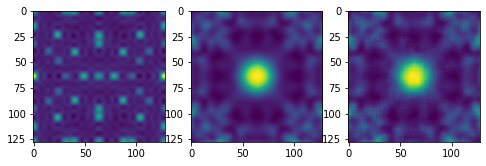

In [84]:
average_loss = 0

#data = [i for i in gen_paths_labels(data_path)]
#data[0][0], data[0][1]
best_image = [None, None, None, None]
lowest_loss = np.inf
vae.encoder.sampling.gamma=0
AugmentedLoss = [0, 0, 0, 0]
for i in range(0, len(TestPathsInput)):
    x = np.load(TestPathsInput[i])
    y = np.load(TestPathsOutput[i])
    #x = np.load(data[0][i])
    #y = np.load(data[1][i])

    a = np.reshape(vae(np.reshape(x, (1, 128, 128, 1))), (128, 128))

    #print(i)
    log_loss = 0

    for j in range(0, a.shape[0]):
        for k in range(0, a.shape[1]):
            log_loss+=(math.log(1+a[j][k]) - math.log(1+y[j][k])) ** 2
    
    average_loss += log_loss
    AugmentedLoss[i % 4]+=log_loss / (len(TestPathsInput) / 4)
    if log_loss > 0:
        if log_loss < lowest_loss:
            best_image = [x, y, a, i]
            lowest_loss = log_loss
        print(i)
        print("Log loss is: ", log_loss)
        w=10
        h=10
        #fig=plt.figure(figsize=(8, 8))
        #columns = 3
        #rows = 1
        #fig.add_subplot(rows, columns, 1)
        #plt.imshow(x)
        #fig.add_subplot(rows, columns, 2)
        #plt.imshow(y)
        #fig.add_subplot(rows, columns, 3)
        #plt.imshow(a)
        #plt.show()
    
    
        
AugmentedLoss = AugmentedLoss
print("Average loss: ", average_loss / len(TestPathsInput))
print("Average loss of each orentation ", AugmentedLoss)
print("Best reconstruction: ", best_image[3], lowest_loss)
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(best_image[0])
fig.add_subplot(rows, columns, 2)
plt.imshow(best_image[1])
fig.add_subplot(rows, columns, 3)
plt.imshow(best_image[2])
plt.show()

In [ ]:
for i in range(0, len(TrainingPaths[0])):
    #x = np.load(data[0][0][i])
    #y = np.load(data[0][1][i])
    x = np.load(TrainingPaths[0][i])
    y = np.load(TrainingPaths[1][i])
    a = np.reshape(vae(np.reshape(x, (1, 128, 128, 1))), (128, 128))
    print(TrainingPaths[0][i])

    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 3
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(x)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(y)
    fig.add_subplot(rows, columns, 3)
    plt.imshow(a)
    plt.show()